# Scalable Signature-Based Distribution Regression via Reference Sets

## 2nd-order Sig-MMD Approximator: Model

### Andrew Alden, Blanka Horvath, Carmine Ventre

### Table of Contents

- [Initial Setup](#initial-setup)
- [Train Models](#train-models)
    - [Truncation Level 2](#train-models-trunc2)
    - [Truncation Level 3](#train-models-trunc3)
    - [Truncation Level 4](#train-models-trunc4)
- [Test Models](#test-models)
- [Testing Metric Properties](#metric-test)
    - [Metric Property 1](#metric-test-1)
    - [Metric Property 2](#metric-test-2)
    - [Metric Property 3](#metric-test-3)
- [Filtration-Sensitive Sig-Kernel Two-Sample Hypothesis Test](#hyp-test)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
import warnings
warnings.filterwarnings("ignore", "You are using `torch.load` with `weights_only=False`*.")
warnings.filterwarnings("ignore", message=r"Trying to unpickle estimator StandardScaler from version .*", category=UserWarning)

### Import libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import Counter
from torch import nn
import torch.cuda
import iisignature
from pathlib import Path


from src.MMD.mmd import RBFKernel, SigKernel
from src.utils import save_dataset, load_dataset, save_path_params, load_path_params

from src.RegressionModel.regression_scaler_model import RegressionModelWithScaler

from src.StochasticProcesses.rBergomi import r_bergomi_sample_paths_functional_central_limit
from src.StochasticProcesses.Heston import heston_sample_paths_inv
from src.StochasticProcesses.BlackScholes import GBM_sample_paths

In [4]:
import sys

sys.modules['numpy._core'] = np.core
sys.modules['numpy._core.multiarray'] = np.core.multiarray

### Set device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.backends.cudnn.benchmark = True

Device: cuda


# Train Models <a class="anchor" id="train-models"></a>

In [6]:
distances, expected_sigs = load_dataset('MMDApproxData/expected_sigs_exp', 'MMDApproxData/distances')

### Clean Dataset

In [21]:
if type(expected_sigs) != type([]):
    expected_sigs = expected_sigs.tolist()

if type(distances) != type([]):
    distances = distances.tolist()

# Remove NaN values.
while np.isnan(np.asarray(distances)).any():
    i = np.argwhere(np.isnan(np.asarray(distances)))[0][0]
    del expected_sigs[i]
    del distances[i]
    
    
    

# Remove distances larger than 2.0
distances = np.asarray(distances)

while np.max(distances) > 2.0:
    i = np.argmax(distances)
    if type(expected_sigs) != type([]):
        expected_sigs = expected_sigs.tolist()
    distances = distances.tolist()
    del expected_sigs[i]
    del distances[i]
    distances = np.asarray(distances)  


# Remove distances less than 0.0
distances = np.asarray(distances)

while np.min(distances) < 0:
    i = np.argmin(distances)
    if type(expected_sigs) != type([]):
        expected_sigs = expected_sigs.tolist()
    distances = distances.tolist()
    del expected_sigs[i]
    del distances[i]
    distances = np.asarray(distances)

In [15]:
def train_models(distances, expected_sigs_features, mmd_approx_training_param_dict, 
                               mmd_approx_dataset_loader_params, mmd_approx_input_dimension,  
                               mmd_approx_model_param_dict, trunc_level, device, scheduler_gamma=0.75,
                               use_scheduler=True, milestones=[50, 70, 90, 100, 110, 120, 130, 135,
                                                               140, 145, 150, 155, 160, 165, 170, 175,
                                                               180, 185, 190, 195], loss=nn.MSELoss(), num_runs=5, suffix=''):
    
    """
    Train the models.
    :param distances: Distances. Array of shape [Number of samples].
    :param expected_sigs_features: Expected signatures. Array of shape [Number of samples, Input dimension].
    :param mmd_approx_training_param_dict: Dictionary specifying the model training procedure. The keys are:
                                           -> lr - learning rate.
                                           -> Epochs - number of epochs.
                                           -> l2_weight - L2-regularisation weight.
                                           -> l1_weight - L1-regularisation weight.
                                           -> Train/Val Split - Percentage of data used for training as opposed to validation.
    :param mmd_approx_dataset_loader_params: Dictionary specifying the loading of the dataset. The keys are:
                                             -> batch_size - the batch size.
                                             -> shuffle - Boolean indicating whether to shuffle the order when loading the data.
                                             -> num_workers - specify how many processes are simultaneously loading the data.
                                                              If num_workers=0, the main process loads the data.
    :param mmd_approx_input_dimension: Input dimension.
    :param mmd_approx_model_param_dict: Dictionary specifying the regression model architecture. The keys are:
                                        -> input_dimension - input dimension of the model.
                                        -> intermediate_dimensions - list of hidden layer dimensions.
                                        -> activation_functions - list of activation functions.
                                        -> add_layer_norm - list of Booleans indicating whether to add layer normalisation
                                           before a neural network layer.
                                        -> output_dimension - output dimension of the model.
                                        -> output_activation_fn - output layer activation function.
    :param trunc_level: Signature truncation level.
    :param device: System device.
    :param scheduler_gamma: scheduler decay factor. Default is 0.75.
    :param use_scheduler: Boolean indicating whether to use a learning rate scheduler. Default is True.
    :param milestones: List of milestones for the MultiStepLR scheduler. Default is [50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195].
    :param loss: PyTorch or custom loss function. Default is MSE loss.
    :param num_runs: Number of independent training runs. Default is 5.
    :return: Nothing.
    """
    
    
    for i in range(num_runs):
            
        mmd_approx_model_mixture = RegressionModelWithScaler(mmd_approx_model_param_dict, mmd_approx_training_param_dict, 
                                                             mmd_approx_dataset_loader_params, loss, device, 
                                                             f'MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis{suffix}.pkl', 
                                                             mmd_approx_input_dimension, scheduler_gamma=scheduler_gamma,
                                                             use_scheduler=use_scheduler, milestones=milestones)

        mmd_approx_model_mixture.fit(torch.tensor(np.multiply(1, np.asarray(expected_sigs_features))).float(), 
                                     torch.tensor(np.multiply(1, distances)).float(), 
                                     **{'filename' :
                                        f'MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_checkpoint_trunc_{trunc_level}_test_{i+1}_thesis{suffix}.pth.tar', 
                                        'best_model_filename' : 
                                        f'MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_best_model_trunc_{trunc_level}_test_{i+1}_thesis{suffix}.pth.tar'})
        

        
def get_stats(trunc_level, num_runs=5, suffix=''):
    
    """
    Compute training and validation statistics.
    :param trunc_level: Signature truncation level.
    :param num_runs: Number of independent training runs. Default is 5.
    :return: Nothing.
    """
    
    train_losses = []
    valid_losses = []
    
    for i in range(num_runs):
        checkpoint = torch.load(f'MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_best_model_trunc_{trunc_level}_test_{i+1}_thesis{suffix}.pth.tar',
                                    map_location=device)

        train_losses.append(checkpoint['train_loss'])
        valid_losses.append(checkpoint['valid_loss'])
        

    print(f'Train Mean: {np.mean(train_losses)}, Train Std: {np.std(train_losses)}')
    print(f'Valid Mean: {np.mean(valid_losses)}, Valid Std: {np.std(valid_losses)}')

    return valid_losses

### Truncation Level 2 <a class="anchor" id="train-models-trunc2"></a>

In [22]:
expected_sigs_features = []
for e in expected_sigs:
    expected_sigs_features.append(e[:30][:6] + e[-30:][:6])


mmd_approx_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8
}



mmd_approx_dataset_loader_params = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}

mmd_approx_input_dimension = 12

mmd_approx_model_param_dict = {
    'input_dimension' : mmd_approx_input_dimension,
    'intermediate_dimensions' : [25, 25, 25],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}

train_models(distances, expected_sigs_features,
             mmd_approx_training_param_dict, 
             mmd_approx_dataset_loader_params, 
             mmd_approx_input_dimension, 
             mmd_approx_model_param_dict, 
             2, 
             device)

Number of Training Samples: 31459


  0%|          | 1/200 [00:00<01:27,  2.29it/s]

Epoch: 1 	 Training Loss: 0.5327394604682922 	 Validation Loss: 0.23325538635253906 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:26,  2.28it/s]

Epoch: 2 	 Training Loss: 0.11466894298791885 	 Validation Loss: 0.06459502875804901 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:44,  1.89it/s]

Epoch: 3 	 Training Loss: 0.048147398978471756 	 Validation Loss: 0.03342593461275101 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:36,  2.03it/s]

Epoch: 4 	 Training Loss: 0.026554498821496964 	 Validation Loss: 0.021644284948706627 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:32,  2.11it/s]

Epoch: 5 	 Training Loss: 0.020465027540922165 	 Validation Loss: 0.018679659813642502 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:29,  2.17it/s]

Epoch: 6 	 Training Loss: 0.01826949045062065 	 Validation Loss: 0.01683618314564228 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:27,  2.21it/s]

Epoch: 7 	 Training Loss: 0.017112763598561287 	 Validation Loss: 0.01612144708633423 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:26,  2.23it/s]

Epoch: 8 	 Training Loss: 0.016417138278484344 	 Validation Loss: 0.015403106808662415 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:24,  2.25it/s]

Epoch: 9 	 Training Loss: 0.01590760238468647 	 Validation Loss: 0.015172479674220085 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:24,  2.26it/s]

Epoch: 10 	 Training Loss: 0.015539574436843395 	 Validation Loss: 0.01484366413205862 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:23,  2.27it/s]

Epoch: 11 	 Training Loss: 0.0152204018086195 	 Validation Loss: 0.014355472289025784 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:23,  2.26it/s]

Epoch: 12 	 Training Loss: 0.015011221170425415 	 Validation Loss: 0.014199092984199524 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:22,  2.27it/s]

Epoch: 13 	 Training Loss: 0.014809082262217999 	 Validation Loss: 0.013987727463245392 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:21,  2.27it/s]

Epoch: 14 	 Training Loss: 0.0146361468359828 	 Validation Loss: 0.013749240897595882 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:21,  2.28it/s]

Epoch: 15 	 Training Loss: 0.014573083259165287 	 Validation Loss: 0.013820922002196312


  8%|▊         | 16/200 [00:07<01:33,  1.97it/s]

Epoch: 16 	 Training Loss: 0.014501002617180347 	 Validation Loss: 0.01375094149261713


  8%|▊         | 17/200 [00:07<01:29,  2.05it/s]

Epoch: 17 	 Training Loss: 0.014384021051228046 	 Validation Loss: 0.013579520396888256 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:25,  2.12it/s]

Epoch: 18 	 Training Loss: 0.01427382417023182 	 Validation Loss: 0.01341714896261692 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:23,  2.17it/s]

Epoch: 19 	 Training Loss: 0.014217264018952847 	 Validation Loss: 0.013499032706022263


 10%|█         | 20/200 [00:09<01:21,  2.21it/s]

Epoch: 20 	 Training Loss: 0.014143082313239574 	 Validation Loss: 0.013362315483391285 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:20,  2.24it/s]

Epoch: 21 	 Training Loss: 0.014170133508741856 	 Validation Loss: 0.013639772310853004


 11%|█         | 22/200 [00:10<01:19,  2.25it/s]

Epoch: 22 	 Training Loss: 0.014071929268538952 	 Validation Loss: 0.013218090869486332 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:18,  2.26it/s]

Epoch: 23 	 Training Loss: 0.014000631868839264 	 Validation Loss: 0.013259951025247574


 12%|█▏        | 24/200 [00:10<01:17,  2.27it/s]

Epoch: 24 	 Training Loss: 0.013986234553158283 	 Validation Loss: 0.013313625007867813


 12%|█▎        | 25/200 [00:11<01:16,  2.28it/s]

Epoch: 25 	 Training Loss: 0.013989073224365711 	 Validation Loss: 0.013252943754196167


 13%|█▎        | 26/200 [00:11<01:16,  2.29it/s]

Epoch: 26 	 Training Loss: 0.013910939916968346 	 Validation Loss: 0.013314569368958473


 14%|█▎        | 27/200 [00:12<01:15,  2.29it/s]

Epoch: 27 	 Training Loss: 0.013864832930266857 	 Validation Loss: 0.013305584900081158


 14%|█▍        | 28/200 [00:12<01:25,  2.01it/s]

Epoch: 28 	 Training Loss: 0.0138874975964427 	 Validation Loss: 0.013055908493697643 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:13<01:21,  2.09it/s]

Epoch: 29 	 Training Loss: 0.013810466043651104 	 Validation Loss: 0.013139930553734303


 15%|█▌        | 30/200 [00:13<01:19,  2.14it/s]

Epoch: 30 	 Training Loss: 0.013818450272083282 	 Validation Loss: 0.013048485852777958 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:14<01:17,  2.19it/s]

Epoch: 31 	 Training Loss: 0.013817406259477139 	 Validation Loss: 0.013223635032773018


 16%|█▌        | 32/200 [00:14<01:15,  2.22it/s]

Epoch: 32 	 Training Loss: 0.013776895590126514 	 Validation Loss: 0.01304295938462019 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:15<01:14,  2.24it/s]

Epoch: 33 	 Training Loss: 0.013729427941143513 	 Validation Loss: 0.013133030384778976


 17%|█▋        | 34/200 [00:15<01:13,  2.25it/s]

Epoch: 34 	 Training Loss: 0.013716134242713451 	 Validation Loss: 0.01295378990471363 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:15<01:12,  2.26it/s]

Epoch: 35 	 Training Loss: 0.013694754801690578 	 Validation Loss: 0.012962661683559418


 18%|█▊        | 36/200 [00:16<01:12,  2.27it/s]

Epoch: 36 	 Training Loss: 0.013717961497604847 	 Validation Loss: 0.013056392781436443


 18%|█▊        | 37/200 [00:16<01:11,  2.28it/s]

Epoch: 37 	 Training Loss: 0.013649147003889084 	 Validation Loss: 0.012915585190057755 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:17<01:10,  2.28it/s]

Epoch: 38 	 Training Loss: 0.013633565977215767 	 Validation Loss: 0.012925822287797928


 20%|█▉        | 39/200 [00:17<01:10,  2.29it/s]

Epoch: 39 	 Training Loss: 0.013685113750398159 	 Validation Loss: 0.012986555695533752


 20%|██        | 40/200 [00:18<01:19,  2.02it/s]

Epoch: 40 	 Training Loss: 0.013612687587738037 	 Validation Loss: 0.012836833484470844 	 Saving Checkpoint


 20%|██        | 41/200 [00:18<01:15,  2.10it/s]

Epoch: 41 	 Training Loss: 0.013594668358564377 	 Validation Loss: 0.012817725539207458 	 Saving Checkpoint


 21%|██        | 42/200 [00:19<01:13,  2.15it/s]

Epoch: 42 	 Training Loss: 0.013551600277423859 	 Validation Loss: 0.012752743437886238 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:19<01:11,  2.20it/s]

Epoch: 43 	 Training Loss: 0.013569371774792671 	 Validation Loss: 0.012818459421396255


 22%|██▏       | 44/200 [00:20<01:09,  2.23it/s]

Epoch: 44 	 Training Loss: 0.013581780716776848 	 Validation Loss: 0.012854469940066338


 22%|██▎       | 45/200 [00:20<01:08,  2.25it/s]

Epoch: 45 	 Training Loss: 0.013514786027371883 	 Validation Loss: 0.012793281115591526


 23%|██▎       | 46/200 [00:20<01:08,  2.26it/s]

Epoch: 46 	 Training Loss: 0.013496515341103077 	 Validation Loss: 0.01264436636120081 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:21<01:07,  2.27it/s]

Epoch: 47 	 Training Loss: 0.013551048934459686 	 Validation Loss: 0.012821613810956478


 24%|██▍       | 48/200 [00:21<01:06,  2.28it/s]

Epoch: 48 	 Training Loss: 0.013512946665287018 	 Validation Loss: 0.012658015824854374


 24%|██▍       | 49/200 [00:22<01:06,  2.28it/s]

Epoch: 49 	 Training Loss: 0.013498172163963318 	 Validation Loss: 0.012780181132256985


 25%|██▌       | 50/200 [00:22<01:05,  2.29it/s]

Epoch: 50 	 Training Loss: 0.013503538444638252 	 Validation Loss: 0.012749874964356422


 26%|██▌       | 51/200 [00:23<01:05,  2.29it/s]

Epoch: 51 	 Training Loss: 0.013455959036946297 	 Validation Loss: 0.012907574884593487


 26%|██▌       | 52/200 [00:23<01:12,  2.04it/s]

Epoch: 52 	 Training Loss: 0.013442949391901493 	 Validation Loss: 0.012707634828984737


 26%|██▋       | 53/200 [00:24<01:09,  2.11it/s]

Epoch: 53 	 Training Loss: 0.013372551649808884 	 Validation Loss: 0.01267508789896965


 27%|██▋       | 54/200 [00:24<01:07,  2.16it/s]

Epoch: 54 	 Training Loss: 0.013363097794353962 	 Validation Loss: 0.012665342539548874


 28%|██▊       | 55/200 [00:25<01:05,  2.20it/s]

Epoch: 55 	 Training Loss: 0.013389525935053825 	 Validation Loss: 0.012879742309451103


 28%|██▊       | 56/200 [00:25<01:04,  2.22it/s]

Epoch: 56 	 Training Loss: 0.013365386053919792 	 Validation Loss: 0.012699950486421585


 28%|██▊       | 57/200 [00:25<01:03,  2.24it/s]

Epoch: 57 	 Training Loss: 0.013340224511921406 	 Validation Loss: 0.012671888805925846


 29%|██▉       | 58/200 [00:26<01:03,  2.25it/s]

Epoch: 58 	 Training Loss: 0.013361570425331593 	 Validation Loss: 0.012544105760753155 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:26<01:02,  2.26it/s]

Epoch: 59 	 Training Loss: 0.013318396173417568 	 Validation Loss: 0.01256400067359209


 30%|███       | 60/200 [00:27<01:01,  2.28it/s]

Epoch: 60 	 Training Loss: 0.013338926248252392 	 Validation Loss: 0.012548979371786118


 30%|███       | 61/200 [00:27<01:00,  2.29it/s]

Epoch: 61 	 Training Loss: 0.013325560837984085 	 Validation Loss: 0.012576578184962273


 31%|███       | 62/200 [00:28<01:00,  2.29it/s]

Epoch: 62 	 Training Loss: 0.01333067286759615 	 Validation Loss: 0.012858410365879536


 32%|███▏      | 63/200 [00:28<00:59,  2.29it/s]

Epoch: 63 	 Training Loss: 0.01330768596380949 	 Validation Loss: 0.012554560787975788


 32%|███▏      | 64/200 [00:28<00:59,  2.30it/s]

Epoch: 64 	 Training Loss: 0.013330669142305851 	 Validation Loss: 0.012567891739308834


 32%|███▎      | 65/200 [00:29<01:06,  2.04it/s]

Epoch: 65 	 Training Loss: 0.01326248049736023 	 Validation Loss: 0.012556502595543861


 33%|███▎      | 66/200 [00:29<01:03,  2.11it/s]

Epoch: 66 	 Training Loss: 0.013321258127689362 	 Validation Loss: 0.012663771398365498


 34%|███▎      | 67/200 [00:30<01:01,  2.17it/s]

Epoch: 67 	 Training Loss: 0.013284703716635704 	 Validation Loss: 0.012581844814121723


 34%|███▍      | 68/200 [00:30<01:00,  2.17it/s]

Epoch: 68 	 Training Loss: 0.013303451240062714 	 Validation Loss: 0.012691636569797993


 34%|███▍      | 69/200 [00:31<00:59,  2.21it/s]

Epoch: 69 	 Training Loss: 0.013300602324306965 	 Validation Loss: 0.012584305368363857


 35%|███▌      | 70/200 [00:31<00:58,  2.23it/s]

Epoch: 70 	 Training Loss: 0.013256178237497807 	 Validation Loss: 0.012514720670878887 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:32<00:57,  2.25it/s]

Epoch: 71 	 Training Loss: 0.01320580206811428 	 Validation Loss: 0.01245901733636856 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:32<00:56,  2.27it/s]

Epoch: 72 	 Training Loss: 0.01319663506001234 	 Validation Loss: 0.012678197585046291


 36%|███▋      | 73/200 [00:33<00:55,  2.27it/s]

Epoch: 73 	 Training Loss: 0.01319247018545866 	 Validation Loss: 0.01245866809040308 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:33<00:55,  2.27it/s]

Epoch: 74 	 Training Loss: 0.013196129351854324 	 Validation Loss: 0.01257065124809742


 38%|███▊      | 75/200 [00:33<00:54,  2.29it/s]

Epoch: 75 	 Training Loss: 0.013200920075178146 	 Validation Loss: 0.01248560007661581


 38%|███▊      | 76/200 [00:34<00:54,  2.29it/s]

Epoch: 76 	 Training Loss: 0.01319178007543087 	 Validation Loss: 0.01252566184848547


 38%|███▊      | 77/200 [00:34<01:00,  2.03it/s]

Epoch: 77 	 Training Loss: 0.013194316066801548 	 Validation Loss: 0.012524967081844807


 39%|███▉      | 78/200 [00:35<00:58,  2.10it/s]

Epoch: 78 	 Training Loss: 0.013158435933291912 	 Validation Loss: 0.012481411918997765


 40%|███▉      | 79/200 [00:35<00:56,  2.15it/s]

Epoch: 79 	 Training Loss: 0.01317543163895607 	 Validation Loss: 0.012483811005949974


 40%|████      | 80/200 [00:36<00:54,  2.19it/s]

Epoch: 80 	 Training Loss: 0.013181757181882858 	 Validation Loss: 0.012394829653203487 	 Saving Checkpoint


 40%|████      | 81/200 [00:36<00:53,  2.22it/s]

Epoch: 81 	 Training Loss: 0.013159846886992455 	 Validation Loss: 0.01258145272731781


 41%|████      | 82/200 [00:37<00:52,  2.25it/s]

Epoch: 82 	 Training Loss: 0.013148763217031956 	 Validation Loss: 0.012426257133483887


 42%|████▏     | 83/200 [00:37<00:51,  2.27it/s]

Epoch: 83 	 Training Loss: 0.013151331804692745 	 Validation Loss: 0.012466436251997948


 42%|████▏     | 84/200 [00:38<00:50,  2.28it/s]

Epoch: 84 	 Training Loss: 0.013139137998223305 	 Validation Loss: 0.012516840361058712


 42%|████▎     | 85/200 [00:38<00:50,  2.29it/s]

Epoch: 85 	 Training Loss: 0.01314088236540556 	 Validation Loss: 0.012425720691680908


 43%|████▎     | 86/200 [00:38<00:49,  2.29it/s]

Epoch: 86 	 Training Loss: 0.013165714219212532 	 Validation Loss: 0.01252436637878418


 44%|████▎     | 87/200 [00:39<00:49,  2.30it/s]

Epoch: 87 	 Training Loss: 0.01316008809953928 	 Validation Loss: 0.012463442049920559


 44%|████▍     | 88/200 [00:39<00:48,  2.29it/s]

Epoch: 88 	 Training Loss: 0.013136472553014755 	 Validation Loss: 0.012463231571018696


 44%|████▍     | 89/200 [00:40<00:55,  2.00it/s]

Epoch: 89 	 Training Loss: 0.013139129616320133 	 Validation Loss: 0.012451839633286


 45%|████▌     | 90/200 [00:40<00:52,  2.08it/s]

Epoch: 90 	 Training Loss: 0.013114738278090954 	 Validation Loss: 0.012539161369204521


 46%|████▌     | 91/200 [00:41<00:50,  2.14it/s]

Epoch: 91 	 Training Loss: 0.013101540505886078 	 Validation Loss: 0.01241731084883213


 46%|████▌     | 92/200 [00:41<00:49,  2.19it/s]

Epoch: 92 	 Training Loss: 0.013090342283248901 	 Validation Loss: 0.012458877637982368


 46%|████▋     | 93/200 [00:42<00:48,  2.22it/s]

Epoch: 93 	 Training Loss: 0.01307822484523058 	 Validation Loss: 0.012439043261110783


 47%|████▋     | 94/200 [00:42<00:47,  2.25it/s]

Epoch: 94 	 Training Loss: 0.013089294545352459 	 Validation Loss: 0.012656459584832191


 48%|████▊     | 95/200 [00:43<00:46,  2.26it/s]

Epoch: 95 	 Training Loss: 0.01309772115200758 	 Validation Loss: 0.012415526434779167


 48%|████▊     | 96/200 [00:43<00:45,  2.27it/s]

Epoch: 96 	 Training Loss: 0.013120532035827637 	 Validation Loss: 0.012372642755508423 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:43<00:45,  2.28it/s]

Epoch: 97 	 Training Loss: 0.013094546273350716 	 Validation Loss: 0.012369178235530853 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:44<00:44,  2.27it/s]

Epoch: 98 	 Training Loss: 0.013075640425086021 	 Validation Loss: 0.012406927533447742


 50%|████▉     | 99/200 [00:44<00:44,  2.28it/s]

Epoch: 99 	 Training Loss: 0.013112640008330345 	 Validation Loss: 0.012540480121970177


 50%|█████     | 100/200 [00:45<00:43,  2.29it/s]

Epoch: 100 	 Training Loss: 0.0131111741065979 	 Validation Loss: 0.012424783781170845


 50%|█████     | 101/200 [00:45<00:43,  2.28it/s]

Epoch: 101 	 Training Loss: 0.013057242147624493 	 Validation Loss: 0.012358371168375015 	 Saving Checkpoint


 51%|█████     | 102/200 [00:46<00:48,  2.01it/s]

Epoch: 102 	 Training Loss: 0.013045067898929119 	 Validation Loss: 0.012341339141130447 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:46<00:46,  2.09it/s]

Epoch: 103 	 Training Loss: 0.013022461906075478 	 Validation Loss: 0.012359393760561943


 52%|█████▏    | 104/200 [00:47<00:44,  2.15it/s]

Epoch: 104 	 Training Loss: 0.013098965398967266 	 Validation Loss: 0.01235213503241539


 52%|█████▎    | 105/200 [00:47<00:43,  2.19it/s]

Epoch: 105 	 Training Loss: 0.01305318996310234 	 Validation Loss: 0.012345762923359871


 53%|█████▎    | 106/200 [00:48<00:42,  2.22it/s]

Epoch: 106 	 Training Loss: 0.01304591167718172 	 Validation Loss: 0.012365386821329594


 54%|█████▎    | 107/200 [00:48<00:41,  2.25it/s]

Epoch: 107 	 Training Loss: 0.013024577870965004 	 Validation Loss: 0.012360453605651855


 54%|█████▍    | 108/200 [00:48<00:40,  2.26it/s]

Epoch: 108 	 Training Loss: 0.013036140240728855 	 Validation Loss: 0.01240708027034998


 55%|█████▍    | 109/200 [00:49<00:40,  2.27it/s]

Epoch: 109 	 Training Loss: 0.01303724106401205 	 Validation Loss: 0.012373225763440132


 55%|█████▌    | 110/200 [00:49<00:39,  2.28it/s]

Epoch: 110 	 Training Loss: 0.01303540077060461 	 Validation Loss: 0.012379013001918793


 56%|█████▌    | 111/200 [00:50<00:38,  2.29it/s]

Epoch: 111 	 Training Loss: 0.013025172054767609 	 Validation Loss: 0.012380859814584255


 56%|█████▌    | 112/200 [00:50<00:38,  2.29it/s]

Epoch: 112 	 Training Loss: 0.01300444919615984 	 Validation Loss: 0.012350316159427166


 56%|█████▋    | 113/200 [00:51<00:38,  2.29it/s]

Epoch: 113 	 Training Loss: 0.013016389682888985 	 Validation Loss: 0.012333401478827 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:51<00:42,  2.03it/s]

Epoch: 114 	 Training Loss: 0.01300689298659563 	 Validation Loss: 0.01236579567193985


 57%|█████▊    | 115/200 [00:52<00:40,  2.10it/s]

Epoch: 115 	 Training Loss: 0.013002915307879448 	 Validation Loss: 0.01233221311122179 	 Saving Checkpoint


 58%|█████▊    | 116/200 [00:52<00:39,  2.15it/s]

Epoch: 116 	 Training Loss: 0.013003230094909668 	 Validation Loss: 0.012319470755755901 	 Saving Checkpoint


 58%|█████▊    | 117/200 [00:52<00:37,  2.20it/s]

Epoch: 117 	 Training Loss: 0.013005678541958332 	 Validation Loss: 0.012321370653808117


 59%|█████▉    | 118/200 [00:53<00:36,  2.23it/s]

Epoch: 118 	 Training Loss: 0.013011392205953598 	 Validation Loss: 0.01238334272056818


 60%|█████▉    | 119/200 [00:53<00:35,  2.25it/s]

Epoch: 119 	 Training Loss: 0.013007765635848045 	 Validation Loss: 0.012328313663601875


 60%|██████    | 120/200 [00:54<00:35,  2.27it/s]

Epoch: 120 	 Training Loss: 0.013005712069571018 	 Validation Loss: 0.012335826642811298


 60%|██████    | 121/200 [00:54<00:34,  2.28it/s]

Epoch: 121 	 Training Loss: 0.01299361139535904 	 Validation Loss: 0.012320948764681816


 61%|██████    | 122/200 [00:55<00:34,  2.29it/s]

Epoch: 122 	 Training Loss: 0.012979627586901188 	 Validation Loss: 0.012341690249741077


 62%|██████▏   | 123/200 [00:55<00:33,  2.27it/s]

Epoch: 123 	 Training Loss: 0.012985603883862495 	 Validation Loss: 0.012314791791141033 	 Saving Checkpoint


 62%|██████▏   | 124/200 [00:56<00:33,  2.28it/s]

Epoch: 124 	 Training Loss: 0.012991315685212612 	 Validation Loss: 0.012344125658273697


 62%|██████▎   | 125/200 [00:56<00:32,  2.28it/s]

Epoch: 125 	 Training Loss: 0.01299082487821579 	 Validation Loss: 0.012343480251729488


 63%|██████▎   | 126/200 [00:57<00:36,  2.03it/s]

Epoch: 126 	 Training Loss: 0.012988557107746601 	 Validation Loss: 0.012318696826696396


 64%|██████▎   | 127/200 [00:57<00:35,  2.06it/s]

Epoch: 127 	 Training Loss: 0.012985932640731335 	 Validation Loss: 0.012331012636423111


 64%|██████▍   | 128/200 [00:58<00:33,  2.12it/s]

Epoch: 128 	 Training Loss: 0.012985791079699993 	 Validation Loss: 0.012313117273151875 	 Saving Checkpoint


 64%|██████▍   | 129/200 [00:58<00:32,  2.17it/s]

Epoch: 129 	 Training Loss: 0.01297441590577364 	 Validation Loss: 0.012310038320720196 	 Saving Checkpoint


 65%|██████▌   | 130/200 [00:58<00:31,  2.21it/s]

Epoch: 130 	 Training Loss: 0.012988601811230183 	 Validation Loss: 0.012340826913714409


 66%|██████▌   | 131/200 [00:59<00:30,  2.23it/s]

Epoch: 131 	 Training Loss: 0.01297002099454403 	 Validation Loss: 0.012302867136895657 	 Saving Checkpoint


 66%|██████▌   | 132/200 [00:59<00:30,  2.25it/s]

Epoch: 132 	 Training Loss: 0.012966053560376167 	 Validation Loss: 0.012309370562434196


 66%|██████▋   | 133/200 [01:00<00:29,  2.27it/s]

Epoch: 133 	 Training Loss: 0.012976551428437233 	 Validation Loss: 0.012308746576309204


 67%|██████▋   | 134/200 [01:00<00:29,  2.27it/s]

Epoch: 134 	 Training Loss: 0.012959551997482777 	 Validation Loss: 0.012313573621213436


 68%|██████▊   | 135/200 [01:01<00:28,  2.29it/s]

Epoch: 135 	 Training Loss: 0.012958591803908348 	 Validation Loss: 0.012355739250779152


 68%|██████▊   | 136/200 [01:01<00:27,  2.29it/s]

Epoch: 136 	 Training Loss: 0.01296968013048172 	 Validation Loss: 0.012318054214119911


 68%|██████▊   | 137/200 [01:01<00:27,  2.29it/s]

Epoch: 137 	 Training Loss: 0.012954886071383953 	 Validation Loss: 0.012360426597297192


 69%|██████▉   | 138/200 [01:02<00:26,  2.30it/s]

Epoch: 138 	 Training Loss: 0.012954752892255783 	 Validation Loss: 0.012307647615671158


 70%|██████▉   | 139/200 [01:03<00:30,  1.99it/s]

Epoch: 139 	 Training Loss: 0.012952136807143688 	 Validation Loss: 0.012313329614698887


 70%|███████   | 140/200 [01:03<00:29,  2.07it/s]

Epoch: 140 	 Training Loss: 0.012961787171661854 	 Validation Loss: 0.012294531799852848 	 Saving Checkpoint


 70%|███████   | 141/200 [01:03<00:27,  2.12it/s]

Epoch: 141 	 Training Loss: 0.012944783084094524 	 Validation Loss: 0.012294300831854343 	 Saving Checkpoint


 71%|███████   | 142/200 [01:04<00:26,  2.17it/s]

Epoch: 142 	 Training Loss: 0.01295000035315752 	 Validation Loss: 0.012300604023039341


 72%|███████▏  | 143/200 [01:04<00:25,  2.21it/s]

Epoch: 143 	 Training Loss: 0.012948919087648392 	 Validation Loss: 0.012299608439207077


 72%|███████▏  | 144/200 [01:05<00:25,  2.23it/s]

Epoch: 144 	 Training Loss: 0.012953059747815132 	 Validation Loss: 0.01229274645447731 	 Saving Checkpoint


 72%|███████▎  | 145/200 [01:05<00:24,  2.24it/s]

Epoch: 145 	 Training Loss: 0.012945633381605148 	 Validation Loss: 0.012299269437789917


 73%|███████▎  | 146/200 [01:06<00:23,  2.26it/s]

Epoch: 146 	 Training Loss: 0.012943929992616177 	 Validation Loss: 0.012294021435081959


 74%|███████▎  | 147/200 [01:06<00:23,  2.26it/s]

Epoch: 147 	 Training Loss: 0.01293894648551941 	 Validation Loss: 0.012297289445996284


 74%|███████▍  | 148/200 [01:06<00:22,  2.27it/s]

Epoch: 148 	 Training Loss: 0.012939490377902985 	 Validation Loss: 0.012295946478843689


 74%|███████▍  | 149/200 [01:07<00:22,  2.28it/s]

Epoch: 149 	 Training Loss: 0.01294315792620182 	 Validation Loss: 0.01229296438395977


 75%|███████▌  | 150/200 [01:07<00:21,  2.29it/s]

Epoch: 150 	 Training Loss: 0.012933519668877125 	 Validation Loss: 0.012306757271289825


 76%|███████▌  | 151/200 [01:08<00:24,  2.03it/s]

Epoch: 151 	 Training Loss: 0.012935448437929153 	 Validation Loss: 0.012298602610826492


 76%|███████▌  | 152/200 [01:08<00:22,  2.10it/s]

Epoch: 152 	 Training Loss: 0.01293417438864708 	 Validation Loss: 0.012297662906348705


 76%|███████▋  | 153/200 [01:09<00:21,  2.16it/s]

Epoch: 153 	 Training Loss: 0.012933740392327309 	 Validation Loss: 0.012304332107305527


 77%|███████▋  | 154/200 [01:09<00:20,  2.20it/s]

Epoch: 154 	 Training Loss: 0.012935584411025047 	 Validation Loss: 0.012291108258068562 	 Saving Checkpoint


 78%|███████▊  | 155/200 [01:10<00:20,  2.23it/s]

Epoch: 155 	 Training Loss: 0.0129356374964118 	 Validation Loss: 0.01229181606322527


 78%|███████▊  | 156/200 [01:10<00:19,  2.25it/s]

Epoch: 156 	 Training Loss: 0.012934106402099133 	 Validation Loss: 0.012292636558413506


 78%|███████▊  | 157/200 [01:11<00:18,  2.27it/s]

Epoch: 157 	 Training Loss: 0.0129332784563303 	 Validation Loss: 0.012292325496673584


 79%|███████▉  | 158/200 [01:11<00:18,  2.28it/s]

Epoch: 158 	 Training Loss: 0.012930932454764843 	 Validation Loss: 0.012292155995965004


 80%|███████▉  | 159/200 [01:11<00:17,  2.29it/s]

Epoch: 159 	 Training Loss: 0.012929108925163746 	 Validation Loss: 0.012290296144783497 	 Saving Checkpoint


 80%|████████  | 160/200 [01:12<00:17,  2.30it/s]

Epoch: 160 	 Training Loss: 0.012929234653711319 	 Validation Loss: 0.012290408834815025


 80%|████████  | 161/200 [01:12<00:17,  2.29it/s]

Epoch: 161 	 Training Loss: 0.012929219752550125 	 Validation Loss: 0.012289820238947868 	 Saving Checkpoint


 81%|████████  | 162/200 [01:13<00:16,  2.29it/s]

Epoch: 162 	 Training Loss: 0.012927237898111343 	 Validation Loss: 0.0122916828840971


 82%|████████▏ | 163/200 [01:13<00:18,  2.04it/s]

Epoch: 163 	 Training Loss: 0.012928657233715057 	 Validation Loss: 0.012289856560528278


 82%|████████▏ | 164/200 [01:14<00:17,  2.10it/s]

Epoch: 164 	 Training Loss: 0.012925664894282818 	 Validation Loss: 0.012288806028664112 	 Saving Checkpoint


 82%|████████▎ | 165/200 [01:14<00:16,  2.16it/s]

Epoch: 165 	 Training Loss: 0.012926578521728516 	 Validation Loss: 0.012288058176636696 	 Saving Checkpoint


 83%|████████▎ | 166/200 [01:15<00:15,  2.20it/s]

Epoch: 166 	 Training Loss: 0.012929157353937626 	 Validation Loss: 0.012288836762309074


 84%|████████▎ | 167/200 [01:15<00:16,  2.00it/s]

Epoch: 167 	 Training Loss: 0.012924885377287865 	 Validation Loss: 0.01229664497077465


 84%|████████▍ | 168/200 [01:16<00:15,  2.07it/s]

Epoch: 168 	 Training Loss: 0.012926693074405193 	 Validation Loss: 0.012288397178053856


 84%|████████▍ | 169/200 [01:16<00:14,  2.14it/s]

Epoch: 169 	 Training Loss: 0.012924142181873322 	 Validation Loss: 0.012291102670133114


 85%|████████▌ | 170/200 [01:17<00:13,  2.19it/s]

Epoch: 170 	 Training Loss: 0.012926536612212658 	 Validation Loss: 0.012288440950214863


 86%|████████▌ | 171/200 [01:17<00:13,  2.22it/s]

Epoch: 171 	 Training Loss: 0.012923321686685085 	 Validation Loss: 0.012288105674088001


 86%|████████▌ | 172/200 [01:17<00:12,  2.24it/s]

Epoch: 172 	 Training Loss: 0.012922811321914196 	 Validation Loss: 0.012287871912121773 	 Saving Checkpoint


 86%|████████▋ | 173/200 [01:18<00:11,  2.26it/s]

Epoch: 173 	 Training Loss: 0.012922768481075764 	 Validation Loss: 0.01228894479572773


 87%|████████▋ | 174/200 [01:18<00:11,  2.27it/s]

Epoch: 174 	 Training Loss: 0.01292358711361885 	 Validation Loss: 0.012288762256503105


 88%|████████▊ | 175/200 [01:19<00:10,  2.28it/s]

Epoch: 175 	 Training Loss: 0.012922448106110096 	 Validation Loss: 0.012288065627217293


 88%|████████▊ | 176/200 [01:19<00:11,  2.02it/s]

Epoch: 176 	 Training Loss: 0.012922816909849644 	 Validation Loss: 0.012289363890886307


 88%|████████▊ | 177/200 [01:20<00:11,  2.07it/s]

Epoch: 177 	 Training Loss: 0.012921569868922234 	 Validation Loss: 0.01229088194668293


 89%|████████▉ | 178/200 [01:20<00:10,  2.12it/s]

Epoch: 178 	 Training Loss: 0.012920968234539032 	 Validation Loss: 0.012287613935768604 	 Saving Checkpoint


 90%|████████▉ | 179/200 [01:21<00:09,  2.16it/s]

Epoch: 179 	 Training Loss: 0.012921883724629879 	 Validation Loss: 0.012287711724638939


 90%|█████████ | 180/200 [01:21<00:09,  2.19it/s]

Epoch: 180 	 Training Loss: 0.012922667898237705 	 Validation Loss: 0.012287621386349201


 90%|█████████ | 181/200 [01:22<00:08,  2.22it/s]

Epoch: 181 	 Training Loss: 0.012920846231281757 	 Validation Loss: 0.012288866564631462


 91%|█████████ | 182/200 [01:22<00:08,  2.23it/s]

Epoch: 182 	 Training Loss: 0.012921133078634739 	 Validation Loss: 0.012288549914956093


 92%|█████████▏| 183/200 [01:22<00:07,  2.25it/s]

Epoch: 183 	 Training Loss: 0.01292162761092186 	 Validation Loss: 0.012287961319088936


 92%|█████████▏| 184/200 [01:23<00:07,  2.26it/s]

Epoch: 184 	 Training Loss: 0.01292119175195694 	 Validation Loss: 0.012289207428693771


 92%|█████████▎| 185/200 [01:23<00:06,  2.26it/s]

Epoch: 185 	 Training Loss: 0.012920871376991272 	 Validation Loss: 0.012287743389606476


 93%|█████████▎| 186/200 [01:24<00:06,  2.27it/s]

Epoch: 186 	 Training Loss: 0.012920834124088287 	 Validation Loss: 0.01228814385831356


 94%|█████████▎| 187/200 [01:24<00:05,  2.27it/s]

Epoch: 187 	 Training Loss: 0.012919768691062927 	 Validation Loss: 0.012288888916373253


 94%|█████████▍| 188/200 [01:25<00:05,  2.01it/s]

Epoch: 188 	 Training Loss: 0.012920805253088474 	 Validation Loss: 0.012288528494536877


 94%|█████████▍| 189/200 [01:25<00:05,  2.09it/s]

Epoch: 189 	 Training Loss: 0.012921024113893509 	 Validation Loss: 0.012289644218981266


 95%|█████████▌| 190/200 [01:26<00:04,  2.14it/s]

Epoch: 190 	 Training Loss: 0.012919450178742409 	 Validation Loss: 0.01228746585547924 	 Saving Checkpoint


 96%|█████████▌| 191/200 [01:26<00:04,  2.18it/s]

Epoch: 191 	 Training Loss: 0.012919389642775059 	 Validation Loss: 0.012288020923733711


 96%|█████████▌| 192/200 [01:27<00:03,  2.20it/s]

Epoch: 192 	 Training Loss: 0.012919413857161999 	 Validation Loss: 0.012287224642932415 	 Saving Checkpoint


 96%|█████████▋| 193/200 [01:27<00:03,  2.22it/s]

Epoch: 193 	 Training Loss: 0.012919646687805653 	 Validation Loss: 0.012287282384932041


 97%|█████████▋| 194/200 [01:27<00:02,  2.23it/s]

Epoch: 194 	 Training Loss: 0.012919123284518719 	 Validation Loss: 0.012287816032767296


 98%|█████████▊| 195/200 [01:28<00:02,  2.25it/s]

Epoch: 195 	 Training Loss: 0.012919480912387371 	 Validation Loss: 0.012287535704672337


 98%|█████████▊| 196/200 [01:28<00:01,  2.25it/s]

Epoch: 196 	 Training Loss: 0.01291881874203682 	 Validation Loss: 0.012288138270378113


 98%|█████████▊| 197/200 [01:29<00:01,  2.26it/s]

Epoch: 197 	 Training Loss: 0.012918778695166111 	 Validation Loss: 0.012287842109799385


 99%|█████████▉| 198/200 [01:29<00:00,  2.27it/s]

Epoch: 198 	 Training Loss: 0.012918956577777863 	 Validation Loss: 0.012287537567317486


100%|█████████▉| 199/200 [01:30<00:00,  2.26it/s]

Epoch: 199 	 Training Loss: 0.012918641790747643 	 Validation Loss: 0.012288167141377926


100%|██████████| 200/200 [01:30<00:00,  2.20it/s]


Epoch: 200 	 Training Loss: 0.012918898835778236 	 Validation Loss: 0.01228847075253725
Number of Training Samples: 31367


  0%|          | 1/200 [00:00<01:26,  2.30it/s]

Epoch: 1 	 Training Loss: 0.5061877369880676 	 Validation Loss: 0.17360366880893707 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:26,  2.29it/s]

Epoch: 2 	 Training Loss: 0.11227626353502274 	 Validation Loss: 0.0781848281621933 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:26,  2.28it/s]

Epoch: 3 	 Training Loss: 0.05791258439421654 	 Validation Loss: 0.049729082733392715 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:25,  2.28it/s]

Epoch: 4 	 Training Loss: 0.04084998741745949 	 Validation Loss: 0.03603431582450867 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:34,  2.07it/s]

Epoch: 5 	 Training Loss: 0.02971702441573143 	 Validation Loss: 0.02577752061188221 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:31,  2.13it/s]

Epoch: 6 	 Training Loss: 0.02257418818771839 	 Validation Loss: 0.02082066424190998 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:28,  2.18it/s]

Epoch: 7 	 Training Loss: 0.019287142902612686 	 Validation Loss: 0.01863657869398594 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:27,  2.20it/s]

Epoch: 8 	 Training Loss: 0.017819790169596672 	 Validation Loss: 0.017483333125710487 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:26,  2.22it/s]

Epoch: 9 	 Training Loss: 0.017018496990203857 	 Validation Loss: 0.016832740977406502 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:25,  2.23it/s]

Epoch: 10 	 Training Loss: 0.01645921915769577 	 Validation Loss: 0.01627551205456257 	 Saving Checkpoint


  6%|▌         | 11/200 [00:04<01:24,  2.24it/s]

Epoch: 11 	 Training Loss: 0.016097627580165863 	 Validation Loss: 0.01589849218726158 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:23,  2.25it/s]

Epoch: 12 	 Training Loss: 0.015678036957979202 	 Validation Loss: 0.015675125643610954 	 Saving Checkpoint


  6%|▋         | 13/200 [00:06<01:33,  1.99it/s]

Epoch: 13 	 Training Loss: 0.015378025360405445 	 Validation Loss: 0.01527415867894888 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:29,  2.07it/s]

Epoch: 14 	 Training Loss: 0.015087898820638657 	 Validation Loss: 0.015115471556782722 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:27,  2.13it/s]

Epoch: 15 	 Training Loss: 0.014902269467711449 	 Validation Loss: 0.014807554893195629 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:29,  2.05it/s]

Epoch: 16 	 Training Loss: 0.01465062890201807 	 Validation Loss: 0.014601467177271843 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:26,  2.11it/s]

Epoch: 17 	 Training Loss: 0.014578728936612606 	 Validation Loss: 0.014350882731378078 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:24,  2.16it/s]

Epoch: 18 	 Training Loss: 0.014307983219623566 	 Validation Loss: 0.014254842884838581 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:22,  2.19it/s]

Epoch: 19 	 Training Loss: 0.014194353483617306 	 Validation Loss: 0.014089541509747505 	 Saving Checkpoint


 10%|█         | 20/200 [00:09<01:21,  2.21it/s]

Epoch: 20 	 Training Loss: 0.014084361493587494 	 Validation Loss: 0.013942534103989601 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:20,  2.22it/s]

Epoch: 21 	 Training Loss: 0.013932710513472557 	 Validation Loss: 0.013804503716528416 	 Saving Checkpoint


 11%|█         | 22/200 [00:10<01:19,  2.25it/s]

Epoch: 22 	 Training Loss: 0.013882357627153397 	 Validation Loss: 0.013813994824886322


 12%|█▏        | 23/200 [00:10<01:18,  2.26it/s]

Epoch: 23 	 Training Loss: 0.013810165226459503 	 Validation Loss: 0.013818220235407352


 12%|█▏        | 24/200 [00:10<01:17,  2.27it/s]

Epoch: 24 	 Training Loss: 0.013757269829511642 	 Validation Loss: 0.013599887490272522 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:27,  2.00it/s]

Epoch: 25 	 Training Loss: 0.013686388731002808 	 Validation Loss: 0.01354306098073721 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:12<01:23,  2.07it/s]

Epoch: 26 	 Training Loss: 0.013660882599651814 	 Validation Loss: 0.013494075275957584 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:12<01:21,  2.13it/s]

Epoch: 27 	 Training Loss: 0.013613440096378326 	 Validation Loss: 0.013492017053067684 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:18,  2.18it/s]

Epoch: 28 	 Training Loss: 0.013503405265510082 	 Validation Loss: 0.013509436510503292


 14%|█▍        | 29/200 [00:13<01:16,  2.22it/s]

Epoch: 29 	 Training Loss: 0.013496591709554195 	 Validation Loss: 0.013586369343101978


 15%|█▌        | 30/200 [00:13<01:15,  2.26it/s]

Epoch: 30 	 Training Loss: 0.013537541963160038 	 Validation Loss: 0.013580660335719585


 16%|█▌        | 31/200 [00:14<01:14,  2.28it/s]

Epoch: 31 	 Training Loss: 0.013446906581521034 	 Validation Loss: 0.013492437079548836


 16%|█▌        | 32/200 [00:14<01:13,  2.29it/s]

Epoch: 32 	 Training Loss: 0.01338823139667511 	 Validation Loss: 0.0136520154774189


 16%|█▋        | 33/200 [00:15<01:13,  2.27it/s]

Epoch: 33 	 Training Loss: 0.013415556401014328 	 Validation Loss: 0.013431373052299023 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:15<01:13,  2.27it/s]

Epoch: 34 	 Training Loss: 0.013390605337917805 	 Validation Loss: 0.013727793470025063


 18%|█▊        | 35/200 [00:15<01:12,  2.26it/s]

Epoch: 35 	 Training Loss: 0.013387336395680904 	 Validation Loss: 0.013398884795606136 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:16<01:12,  2.27it/s]

Epoch: 36 	 Training Loss: 0.013334810733795166 	 Validation Loss: 0.013421489857137203


 18%|█▊        | 37/200 [00:17<01:21,  2.00it/s]

Epoch: 37 	 Training Loss: 0.013299437239766121 	 Validation Loss: 0.01324127521365881 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:17<01:18,  2.07it/s]

Epoch: 38 	 Training Loss: 0.01330559328198433 	 Validation Loss: 0.013228939846158028 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:17<01:15,  2.13it/s]

Epoch: 39 	 Training Loss: 0.0132895577698946 	 Validation Loss: 0.013410856947302818


 20%|██        | 40/200 [00:18<01:14,  2.15it/s]

Epoch: 40 	 Training Loss: 0.013271995820105076 	 Validation Loss: 0.01316589955240488 	 Saving Checkpoint


 20%|██        | 41/200 [00:18<01:12,  2.19it/s]

Epoch: 41 	 Training Loss: 0.01324173528701067 	 Validation Loss: 0.013454441912472248


 21%|██        | 42/200 [00:19<01:11,  2.21it/s]

Epoch: 42 	 Training Loss: 0.013207932934165001 	 Validation Loss: 0.0132698779925704


 22%|██▏       | 43/200 [00:19<01:10,  2.23it/s]

Epoch: 43 	 Training Loss: 0.013259759172797203 	 Validation Loss: 0.013187356293201447


 22%|██▏       | 44/200 [00:20<01:09,  2.23it/s]

Epoch: 44 	 Training Loss: 0.013179630041122437 	 Validation Loss: 0.013056295923888683 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:20<01:08,  2.25it/s]

Epoch: 45 	 Training Loss: 0.013165837153792381 	 Validation Loss: 0.013153184205293655


 23%|██▎       | 46/200 [00:21<01:08,  2.26it/s]

Epoch: 46 	 Training Loss: 0.013191139325499535 	 Validation Loss: 0.013401859439909458


 24%|██▎       | 47/200 [00:21<01:07,  2.28it/s]

Epoch: 47 	 Training Loss: 0.013110608793795109 	 Validation Loss: 0.013144977390766144


 24%|██▍       | 48/200 [00:21<01:06,  2.28it/s]

Epoch: 48 	 Training Loss: 0.013142143376171589 	 Validation Loss: 0.013065828941762447


 24%|██▍       | 49/200 [00:22<01:06,  2.27it/s]

Epoch: 49 	 Training Loss: 0.013099375180900097 	 Validation Loss: 0.013040837831795216 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:22<01:14,  2.01it/s]

Epoch: 50 	 Training Loss: 0.013100632466375828 	 Validation Loss: 0.013154814019799232


 26%|██▌       | 51/200 [00:23<01:11,  2.09it/s]

Epoch: 51 	 Training Loss: 0.013073338195681572 	 Validation Loss: 0.013247535564005375


 26%|██▌       | 52/200 [00:23<01:09,  2.14it/s]

Epoch: 52 	 Training Loss: 0.013054311275482178 	 Validation Loss: 0.012996637262403965 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:24<01:07,  2.18it/s]

Epoch: 53 	 Training Loss: 0.0130569813773036 	 Validation Loss: 0.01301233097910881


 27%|██▋       | 54/200 [00:24<01:06,  2.21it/s]

Epoch: 54 	 Training Loss: 0.013050241395831108 	 Validation Loss: 0.013168437406420708


 28%|██▊       | 55/200 [00:25<01:05,  2.23it/s]

Epoch: 55 	 Training Loss: 0.013006598688662052 	 Validation Loss: 0.01304966863244772


 28%|██▊       | 56/200 [00:25<01:04,  2.24it/s]

Epoch: 56 	 Training Loss: 0.01301139872521162 	 Validation Loss: 0.01295847911387682 	 Saving Checkpoint


 28%|██▊       | 57/200 [00:26<01:03,  2.25it/s]

Epoch: 57 	 Training Loss: 0.0130086001008749 	 Validation Loss: 0.013144874013960361


 29%|██▉       | 58/200 [00:26<01:02,  2.25it/s]

Epoch: 58 	 Training Loss: 0.013029512949287891 	 Validation Loss: 0.013031572103500366


 30%|██▉       | 59/200 [00:26<01:02,  2.26it/s]

Epoch: 59 	 Training Loss: 0.012994751334190369 	 Validation Loss: 0.013137809932231903


 30%|███       | 60/200 [00:27<01:01,  2.27it/s]

Epoch: 60 	 Training Loss: 0.013019410893321037 	 Validation Loss: 0.013004781678318977


 30%|███       | 61/200 [00:27<01:02,  2.24it/s]

Epoch: 61 	 Training Loss: 0.013039762154221535 	 Validation Loss: 0.013035384938120842


 31%|███       | 62/200 [00:28<01:09,  1.99it/s]

Epoch: 62 	 Training Loss: 0.013000291772186756 	 Validation Loss: 0.013028261251747608


 32%|███▏      | 63/200 [00:28<01:05,  2.08it/s]

Epoch: 63 	 Training Loss: 0.012997511774301529 	 Validation Loss: 0.01308879442512989


 32%|███▏      | 64/200 [00:29<01:03,  2.14it/s]

Epoch: 64 	 Training Loss: 0.012966115027666092 	 Validation Loss: 0.013139117509126663


 32%|███▎      | 65/200 [00:29<01:02,  2.17it/s]

Epoch: 65 	 Training Loss: 0.012961408123373985 	 Validation Loss: 0.012997857294976711


 33%|███▎      | 66/200 [00:30<01:00,  2.20it/s]

Epoch: 66 	 Training Loss: 0.012936633080244064 	 Validation Loss: 0.012983245775103569


 34%|███▎      | 67/200 [00:30<00:59,  2.23it/s]

Epoch: 67 	 Training Loss: 0.01294467318803072 	 Validation Loss: 0.012990404851734638


 34%|███▍      | 68/200 [00:31<00:58,  2.25it/s]

Epoch: 68 	 Training Loss: 0.012961698696017265 	 Validation Loss: 0.012961640022695065


 34%|███▍      | 69/200 [00:31<00:57,  2.27it/s]

Epoch: 69 	 Training Loss: 0.012905698269605637 	 Validation Loss: 0.013033963739871979


 35%|███▌      | 70/200 [00:31<00:56,  2.28it/s]

Epoch: 70 	 Training Loss: 0.012949538417160511 	 Validation Loss: 0.013014452531933784


 36%|███▌      | 71/200 [00:32<00:56,  2.28it/s]

Epoch: 71 	 Training Loss: 0.0128709115087986 	 Validation Loss: 0.012910624966025352 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:32<00:56,  2.29it/s]

Epoch: 72 	 Training Loss: 0.012894895859062672 	 Validation Loss: 0.012949878349900246


 36%|███▋      | 73/200 [00:33<00:55,  2.29it/s]

Epoch: 73 	 Training Loss: 0.012883038260042667 	 Validation Loss: 0.012999976053833961


 37%|███▋      | 74/200 [00:33<00:54,  2.29it/s]

Epoch: 74 	 Training Loss: 0.012904449366033077 	 Validation Loss: 0.01291987206786871


 38%|███▊      | 75/200 [00:34<01:01,  2.03it/s]

Epoch: 75 	 Training Loss: 0.012886290438473225 	 Validation Loss: 0.013038133271038532


 38%|███▊      | 76/200 [00:34<00:58,  2.10it/s]

Epoch: 76 	 Training Loss: 0.012927102856338024 	 Validation Loss: 0.013016882352530956


 38%|███▊      | 77/200 [00:35<00:56,  2.16it/s]

Epoch: 77 	 Training Loss: 0.012887763790786266 	 Validation Loss: 0.012966188602149487


 39%|███▉      | 78/200 [00:35<00:55,  2.20it/s]

Epoch: 78 	 Training Loss: 0.012916199862957 	 Validation Loss: 0.013067738153040409


 40%|███▉      | 79/200 [00:36<00:54,  2.23it/s]

Epoch: 79 	 Training Loss: 0.012879489921033382 	 Validation Loss: 0.01296120323240757


 40%|████      | 80/200 [00:36<00:53,  2.25it/s]

Epoch: 80 	 Training Loss: 0.012878349050879478 	 Validation Loss: 0.012899176217615604 	 Saving Checkpoint


 40%|████      | 81/200 [00:36<00:52,  2.26it/s]

Epoch: 81 	 Training Loss: 0.012825371697545052 	 Validation Loss: 0.012933204881846905


 41%|████      | 82/200 [00:37<00:52,  2.27it/s]

Epoch: 82 	 Training Loss: 0.012841258198022842 	 Validation Loss: 0.012892528437077999 	 Saving Checkpoint


 42%|████▏     | 83/200 [00:37<00:51,  2.27it/s]

Epoch: 83 	 Training Loss: 0.012842281721532345 	 Validation Loss: 0.012869703583419323 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:38<00:50,  2.28it/s]

Epoch: 84 	 Training Loss: 0.012837509624660015 	 Validation Loss: 0.01284653041511774 	 Saving Checkpoint


 42%|████▎     | 85/200 [00:38<00:50,  2.29it/s]

Epoch: 85 	 Training Loss: 0.012850130908191204 	 Validation Loss: 0.012994264252483845


 43%|████▎     | 86/200 [00:39<00:49,  2.29it/s]

Epoch: 86 	 Training Loss: 0.012838373892009258 	 Validation Loss: 0.012884797528386116


 44%|████▎     | 87/200 [00:39<00:55,  2.02it/s]

Epoch: 87 	 Training Loss: 0.012816517613828182 	 Validation Loss: 0.012883436866104603


 44%|████▍     | 88/200 [00:40<00:53,  2.10it/s]

Epoch: 88 	 Training Loss: 0.012819335795938969 	 Validation Loss: 0.01293102651834488


 44%|████▍     | 89/200 [00:40<00:51,  2.16it/s]

Epoch: 89 	 Training Loss: 0.01281479187309742 	 Validation Loss: 0.012883820571005344


 45%|████▌     | 90/200 [00:41<00:49,  2.20it/s]

Epoch: 90 	 Training Loss: 0.012828724458813667 	 Validation Loss: 0.012866095639765263


 46%|████▌     | 91/200 [00:41<00:48,  2.23it/s]

Epoch: 91 	 Training Loss: 0.01278649177402258 	 Validation Loss: 0.01290183700621128


 46%|████▌     | 92/200 [00:41<00:47,  2.25it/s]

Epoch: 92 	 Training Loss: 0.012795316986739635 	 Validation Loss: 0.012874333187937737


 46%|████▋     | 93/200 [00:42<00:47,  2.27it/s]

Epoch: 93 	 Training Loss: 0.012783113867044449 	 Validation Loss: 0.012911193072795868


 47%|████▋     | 94/200 [00:42<00:46,  2.28it/s]

Epoch: 94 	 Training Loss: 0.012791918590664864 	 Validation Loss: 0.012865252792835236


 48%|████▊     | 95/200 [00:43<00:46,  2.28it/s]

Epoch: 95 	 Training Loss: 0.012785244733095169 	 Validation Loss: 0.012841889634728432 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:43<00:45,  2.29it/s]

Epoch: 96 	 Training Loss: 0.012791900895535946 	 Validation Loss: 0.012894608080387115


 48%|████▊     | 97/200 [00:44<00:44,  2.29it/s]

Epoch: 97 	 Training Loss: 0.012773208320140839 	 Validation Loss: 0.012903549708425999


 49%|████▉     | 98/200 [00:44<00:44,  2.30it/s]

Epoch: 98 	 Training Loss: 0.012772097252309322 	 Validation Loss: 0.012867225334048271


 50%|████▉     | 99/200 [00:45<00:49,  2.03it/s]

Epoch: 99 	 Training Loss: 0.012803320772945881 	 Validation Loss: 0.012849478982388973


 50%|█████     | 100/200 [00:45<00:47,  2.10it/s]

Epoch: 100 	 Training Loss: 0.012784046120941639 	 Validation Loss: 0.012855098582804203


 50%|█████     | 101/200 [00:45<00:45,  2.16it/s]

Epoch: 101 	 Training Loss: 0.012750012800097466 	 Validation Loss: 0.012848781421780586


 51%|█████     | 102/200 [00:46<00:44,  2.20it/s]

Epoch: 102 	 Training Loss: 0.012746049091219902 	 Validation Loss: 0.012828122824430466 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:46<00:43,  2.22it/s]

Epoch: 103 	 Training Loss: 0.012758812867105007 	 Validation Loss: 0.012825909070670605 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:47<00:42,  2.25it/s]

Epoch: 104 	 Training Loss: 0.012753915041685104 	 Validation Loss: 0.012837882153689861


 52%|█████▎    | 105/200 [00:47<00:42,  2.25it/s]

Epoch: 105 	 Training Loss: 0.012759980745613575 	 Validation Loss: 0.012808877974748611 	 Saving Checkpoint


 53%|█████▎    | 106/200 [00:48<00:41,  2.27it/s]

Epoch: 106 	 Training Loss: 0.01274164579808712 	 Validation Loss: 0.01290727499872446


 54%|█████▎    | 107/200 [00:48<00:40,  2.27it/s]

Epoch: 107 	 Training Loss: 0.012744376435875893 	 Validation Loss: 0.012831303291022778


 54%|█████▍    | 108/200 [00:49<00:40,  2.28it/s]

Epoch: 108 	 Training Loss: 0.012731613591313362 	 Validation Loss: 0.012828931212425232


 55%|█████▍    | 109/200 [00:49<00:39,  2.29it/s]

Epoch: 109 	 Training Loss: 0.012736938893795013 	 Validation Loss: 0.01301025040447712


 55%|█████▌    | 110/200 [00:49<00:39,  2.28it/s]

Epoch: 110 	 Training Loss: 0.01274990476667881 	 Validation Loss: 0.0129105718806386


 56%|█████▌    | 111/200 [00:50<00:39,  2.28it/s]

Epoch: 111 	 Training Loss: 0.012713921256363392 	 Validation Loss: 0.012791642919182777 	 Saving Checkpoint


 56%|█████▌    | 112/200 [00:50<00:43,  2.03it/s]

Epoch: 112 	 Training Loss: 0.012714010663330555 	 Validation Loss: 0.01284732948988676


 56%|█████▋    | 113/200 [00:51<00:41,  2.10it/s]

Epoch: 113 	 Training Loss: 0.01271128375083208 	 Validation Loss: 0.012807182036340237


 57%|█████▋    | 114/200 [00:51<00:39,  2.16it/s]

Epoch: 114 	 Training Loss: 0.012712226249277592 	 Validation Loss: 0.01286125648766756


 57%|█████▊    | 115/200 [00:52<00:38,  2.20it/s]

Epoch: 115 	 Training Loss: 0.012699980288743973 	 Validation Loss: 0.012808130122721195


 58%|█████▊    | 116/200 [00:52<00:37,  2.23it/s]

Epoch: 116 	 Training Loss: 0.012722830288112164 	 Validation Loss: 0.012811075896024704


 58%|█████▊    | 117/200 [00:53<00:36,  2.25it/s]

Epoch: 117 	 Training Loss: 0.012699752114713192 	 Validation Loss: 0.012814038433134556


 59%|█████▉    | 118/200 [00:53<00:36,  2.26it/s]

Epoch: 118 	 Training Loss: 0.012711619958281517 	 Validation Loss: 0.012833284214138985


 60%|█████▉    | 119/200 [00:54<00:35,  2.28it/s]

Epoch: 119 	 Training Loss: 0.0126950703561306 	 Validation Loss: 0.012812569737434387


 60%|██████    | 120/200 [00:54<00:35,  2.27it/s]

Epoch: 120 	 Training Loss: 0.012704876251518726 	 Validation Loss: 0.012777820229530334 	 Saving Checkpoint


 60%|██████    | 121/200 [00:54<00:34,  2.28it/s]

Epoch: 121 	 Training Loss: 0.012698397040367126 	 Validation Loss: 0.012810622341930866


 61%|██████    | 122/200 [00:55<00:34,  2.28it/s]

Epoch: 122 	 Training Loss: 0.012696086429059505 	 Validation Loss: 0.0127912238240242


 62%|██████▏   | 123/200 [00:55<00:33,  2.29it/s]

Epoch: 123 	 Training Loss: 0.012698549777269363 	 Validation Loss: 0.012782090343534946


 62%|██████▏   | 124/200 [00:56<00:37,  2.03it/s]

Epoch: 124 	 Training Loss: 0.012693075463175774 	 Validation Loss: 0.012799522839486599


 62%|██████▎   | 125/200 [00:56<00:35,  2.10it/s]

Epoch: 125 	 Training Loss: 0.012688406743109226 	 Validation Loss: 0.01281027402728796


 63%|██████▎   | 126/200 [00:57<00:34,  2.16it/s]

Epoch: 126 	 Training Loss: 0.012683991342782974 	 Validation Loss: 0.012781612575054169


 64%|██████▎   | 127/200 [00:57<00:33,  2.20it/s]

Epoch: 127 	 Training Loss: 0.012684357352554798 	 Validation Loss: 0.012838565744459629


 64%|██████▍   | 128/200 [00:58<00:32,  2.23it/s]

Epoch: 128 	 Training Loss: 0.012681378051638603 	 Validation Loss: 0.01280660554766655


 64%|██████▍   | 129/200 [00:58<00:31,  2.25it/s]

Epoch: 129 	 Training Loss: 0.012691204436123371 	 Validation Loss: 0.012778529897332191


 65%|██████▌   | 130/200 [00:59<00:30,  2.26it/s]

Epoch: 130 	 Training Loss: 0.012692735530436039 	 Validation Loss: 0.012760400772094727 	 Saving Checkpoint


 66%|██████▌   | 131/200 [00:59<00:30,  2.28it/s]

Epoch: 131 	 Training Loss: 0.012671620585024357 	 Validation Loss: 0.012803479097783566


 66%|██████▌   | 132/200 [00:59<00:29,  2.28it/s]

Epoch: 132 	 Training Loss: 0.0126655837520957 	 Validation Loss: 0.012763837352395058


 66%|██████▋   | 133/200 [01:00<00:29,  2.28it/s]

Epoch: 133 	 Training Loss: 0.012670443393290043 	 Validation Loss: 0.01280069537460804


 67%|██████▋   | 134/200 [01:00<00:28,  2.28it/s]

Epoch: 134 	 Training Loss: 0.012678825296461582 	 Validation Loss: 0.012776099145412445


 68%|██████▊   | 135/200 [01:01<00:28,  2.29it/s]

Epoch: 135 	 Training Loss: 0.012661280110478401 	 Validation Loss: 0.012782171368598938


 68%|██████▊   | 136/200 [01:01<00:27,  2.29it/s]

Epoch: 136 	 Training Loss: 0.01266203261911869 	 Validation Loss: 0.012791099958121777


 68%|██████▊   | 137/200 [01:02<00:31,  2.03it/s]

Epoch: 137 	 Training Loss: 0.01265579555183649 	 Validation Loss: 0.012796716764569283


 69%|██████▉   | 138/200 [01:02<00:29,  2.10it/s]

Epoch: 138 	 Training Loss: 0.012656349688768387 	 Validation Loss: 0.012791566550731659


 70%|██████▉   | 139/200 [01:03<00:28,  2.16it/s]

Epoch: 139 	 Training Loss: 0.012651911936700344 	 Validation Loss: 0.012760545127093792


 70%|███████   | 140/200 [01:03<00:27,  2.20it/s]

Epoch: 140 	 Training Loss: 0.012663524597883224 	 Validation Loss: 0.012833230197429657


 70%|███████   | 141/200 [01:03<00:26,  2.23it/s]

Epoch: 141 	 Training Loss: 0.012653120793402195 	 Validation Loss: 0.012765794061124325


 71%|███████   | 142/200 [01:04<00:25,  2.25it/s]

Epoch: 142 	 Training Loss: 0.012645545415580273 	 Validation Loss: 0.012783277779817581


 72%|███████▏  | 143/200 [01:04<00:25,  2.27it/s]

Epoch: 143 	 Training Loss: 0.012642414309084415 	 Validation Loss: 0.012813488021492958


 72%|███████▏  | 144/200 [01:05<00:24,  2.26it/s]

Epoch: 144 	 Training Loss: 0.012649069540202618 	 Validation Loss: 0.01275702379643917 	 Saving Checkpoint


 72%|███████▎  | 145/200 [01:05<00:24,  2.27it/s]

Epoch: 145 	 Training Loss: 0.012648293748497963 	 Validation Loss: 0.012781038880348206


 73%|███████▎  | 146/200 [01:06<00:23,  2.28it/s]

Epoch: 146 	 Training Loss: 0.012644004076719284 	 Validation Loss: 0.012775198556482792


 74%|███████▎  | 147/200 [01:06<00:23,  2.28it/s]

Epoch: 147 	 Training Loss: 0.012642040848731995 	 Validation Loss: 0.012763961218297482


 74%|███████▍  | 148/200 [01:07<00:22,  2.29it/s]

Epoch: 148 	 Training Loss: 0.012643653899431229 	 Validation Loss: 0.012761476449668407


 74%|███████▍  | 149/200 [01:07<00:25,  2.03it/s]

Epoch: 149 	 Training Loss: 0.012642118148505688 	 Validation Loss: 0.012757718563079834


 75%|███████▌  | 150/200 [01:08<00:23,  2.11it/s]

Epoch: 150 	 Training Loss: 0.012643817812204361 	 Validation Loss: 0.012767760083079338


 76%|███████▌  | 151/200 [01:08<00:22,  2.17it/s]

Epoch: 151 	 Training Loss: 0.012635544873774052 	 Validation Loss: 0.012760108336806297


 76%|███████▌  | 152/200 [01:08<00:21,  2.21it/s]

Epoch: 152 	 Training Loss: 0.012638837099075317 	 Validation Loss: 0.012762648984789848


 76%|███████▋  | 153/200 [01:09<00:21,  2.23it/s]

Epoch: 153 	 Training Loss: 0.012637619860470295 	 Validation Loss: 0.012757663615047932


 77%|███████▋  | 154/200 [01:09<00:20,  2.25it/s]

Epoch: 154 	 Training Loss: 0.012639197520911694 	 Validation Loss: 0.012755398638546467 	 Saving Checkpoint


 78%|███████▊  | 155/200 [01:10<00:19,  2.26it/s]

Epoch: 155 	 Training Loss: 0.012637349776923656 	 Validation Loss: 0.012781250290572643


 78%|███████▊  | 156/200 [01:10<00:19,  2.27it/s]

Epoch: 156 	 Training Loss: 0.012635326012969017 	 Validation Loss: 0.012763464823365211


 78%|███████▊  | 157/200 [01:11<00:18,  2.28it/s]

Epoch: 157 	 Training Loss: 0.012631634250283241 	 Validation Loss: 0.01275806874036789


 79%|███████▉  | 158/200 [01:11<00:18,  2.29it/s]

Epoch: 158 	 Training Loss: 0.012634609825909138 	 Validation Loss: 0.012759530916810036


 80%|███████▉  | 159/200 [01:12<00:17,  2.29it/s]

Epoch: 159 	 Training Loss: 0.012637942098081112 	 Validation Loss: 0.012763076461851597


 80%|████████  | 160/200 [01:12<00:17,  2.29it/s]

Epoch: 160 	 Training Loss: 0.01263305265456438 	 Validation Loss: 0.012769879773259163


 80%|████████  | 161/200 [01:13<00:19,  2.03it/s]

Epoch: 161 	 Training Loss: 0.012629511766135693 	 Validation Loss: 0.012753907591104507 	 Saving Checkpoint


 81%|████████  | 162/200 [01:13<00:18,  2.10it/s]

Epoch: 162 	 Training Loss: 0.012628922238945961 	 Validation Loss: 0.01275830902159214


 82%|████████▏ | 163/200 [01:13<00:17,  2.16it/s]

Epoch: 163 	 Training Loss: 0.012627859599888325 	 Validation Loss: 0.012758538126945496


 82%|████████▏ | 164/200 [01:14<00:16,  2.20it/s]

Epoch: 164 	 Training Loss: 0.012628275901079178 	 Validation Loss: 0.012757989577949047


 82%|████████▎ | 165/200 [01:14<00:15,  2.23it/s]

Epoch: 165 	 Training Loss: 0.012629978358745575 	 Validation Loss: 0.012756920419633389


 83%|████████▎ | 166/200 [01:15<00:15,  2.25it/s]

Epoch: 166 	 Training Loss: 0.01262783631682396 	 Validation Loss: 0.012754807248711586


 84%|████████▎ | 167/200 [01:15<00:14,  2.26it/s]

Epoch: 167 	 Training Loss: 0.01262706983834505 	 Validation Loss: 0.012759210541844368


 84%|████████▍ | 168/200 [01:16<00:14,  2.28it/s]

Epoch: 168 	 Training Loss: 0.01262668613344431 	 Validation Loss: 0.012755824252963066


 84%|████████▍ | 169/200 [01:16<00:13,  2.28it/s]

Epoch: 169 	 Training Loss: 0.012626334093511105 	 Validation Loss: 0.012753970921039581


 85%|████████▌ | 170/200 [01:16<00:13,  2.29it/s]

Epoch: 170 	 Training Loss: 0.01262799184769392 	 Validation Loss: 0.012756475247442722


 86%|████████▌ | 171/200 [01:17<00:12,  2.29it/s]

Epoch: 171 	 Training Loss: 0.012625884264707565 	 Validation Loss: 0.012758215889334679


 86%|████████▌ | 172/200 [01:17<00:12,  2.29it/s]

Epoch: 172 	 Training Loss: 0.012624598108232021 	 Validation Loss: 0.012753117829561234 	 Saving Checkpoint


 86%|████████▋ | 173/200 [01:18<00:11,  2.29it/s]

Epoch: 173 	 Training Loss: 0.012623989954590797 	 Validation Loss: 0.012753540650010109


 87%|████████▋ | 174/200 [01:18<00:12,  2.03it/s]

Epoch: 174 	 Training Loss: 0.012624774128198624 	 Validation Loss: 0.012755871750414371


 88%|████████▊ | 175/200 [01:19<00:11,  2.11it/s]

Epoch: 175 	 Training Loss: 0.01262519508600235 	 Validation Loss: 0.01276067178696394


 88%|████████▊ | 176/200 [01:19<00:11,  2.16it/s]

Epoch: 176 	 Training Loss: 0.012622550129890442 	 Validation Loss: 0.0127557422965765


 88%|████████▊ | 177/200 [01:20<00:10,  2.19it/s]

Epoch: 177 	 Training Loss: 0.012623265385627747 	 Validation Loss: 0.012756602838635445


 89%|████████▉ | 178/200 [01:20<00:09,  2.23it/s]

Epoch: 178 	 Training Loss: 0.012623250484466553 	 Validation Loss: 0.01275624893605709


 90%|████████▉ | 179/200 [01:21<00:09,  2.25it/s]

Epoch: 179 	 Training Loss: 0.012623605318367481 	 Validation Loss: 0.01276298239827156


 90%|█████████ | 180/200 [01:21<00:08,  2.26it/s]

Epoch: 180 	 Training Loss: 0.012622807174921036 	 Validation Loss: 0.012754015624523163


 90%|█████████ | 181/200 [01:21<00:08,  2.28it/s]

Epoch: 181 	 Training Loss: 0.012622075155377388 	 Validation Loss: 0.012754745781421661


 91%|█████████ | 182/200 [01:22<00:07,  2.29it/s]

Epoch: 182 	 Training Loss: 0.01262275967746973 	 Validation Loss: 0.012754294089972973


 92%|█████████▏| 183/200 [01:22<00:07,  2.29it/s]

Epoch: 183 	 Training Loss: 0.012622198089957237 	 Validation Loss: 0.012754782103002071


 92%|█████████▏| 184/200 [01:23<00:06,  2.29it/s]

Epoch: 184 	 Training Loss: 0.0126216234639287 	 Validation Loss: 0.012758219614624977


 92%|█████████▎| 185/200 [01:23<00:06,  2.30it/s]

Epoch: 185 	 Training Loss: 0.012622781097888947 	 Validation Loss: 0.01275506243109703


 93%|█████████▎| 186/200 [01:24<00:06,  2.04it/s]

Epoch: 186 	 Training Loss: 0.01262144185602665 	 Validation Loss: 0.012753743678331375


 94%|█████████▎| 187/200 [01:24<00:06,  2.10it/s]

Epoch: 187 	 Training Loss: 0.012621969915926456 	 Validation Loss: 0.012752772308886051 	 Saving Checkpoint


 94%|█████████▍| 188/200 [01:25<00:05,  2.16it/s]

Epoch: 188 	 Training Loss: 0.012621094472706318 	 Validation Loss: 0.012754248455166817


 94%|█████████▍| 189/200 [01:25<00:04,  2.20it/s]

Epoch: 189 	 Training Loss: 0.012621683068573475 	 Validation Loss: 0.012755043804645538


 95%|█████████▌| 190/200 [01:26<00:04,  2.23it/s]

Epoch: 190 	 Training Loss: 0.012621420435607433 	 Validation Loss: 0.01275322400033474


 96%|█████████▌| 191/200 [01:26<00:04,  2.25it/s]

Epoch: 191 	 Training Loss: 0.01262094359844923 	 Validation Loss: 0.012753601185977459


 96%|█████████▌| 192/200 [01:26<00:03,  2.27it/s]

Epoch: 192 	 Training Loss: 0.012620978988707066 	 Validation Loss: 0.012754599563777447


 96%|█████████▋| 193/200 [01:27<00:03,  2.28it/s]

Epoch: 193 	 Training Loss: 0.012620529159903526 	 Validation Loss: 0.012754147872328758


 97%|█████████▋| 194/200 [01:27<00:02,  2.29it/s]

Epoch: 194 	 Training Loss: 0.012620978988707066 	 Validation Loss: 0.012754242867231369


 98%|█████████▊| 195/200 [01:28<00:02,  2.24it/s]

Epoch: 195 	 Training Loss: 0.012620389461517334 	 Validation Loss: 0.012754653580486774


 98%|█████████▊| 196/200 [01:28<00:01,  2.26it/s]

Epoch: 196 	 Training Loss: 0.012620866298675537 	 Validation Loss: 0.01275331899523735


 98%|█████████▊| 197/200 [01:29<00:01,  2.27it/s]

Epoch: 197 	 Training Loss: 0.012620173394680023 	 Validation Loss: 0.0127546526491642


 99%|█████████▉| 198/200 [01:29<00:00,  2.28it/s]

Epoch: 198 	 Training Loss: 0.01262002531439066 	 Validation Loss: 0.012754663825035095


100%|█████████▉| 199/200 [01:30<00:00,  2.03it/s]

Epoch: 199 	 Training Loss: 0.012620371766388416 	 Validation Loss: 0.012754579074680805


100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


Epoch: 200 	 Training Loss: 0.012620634399354458 	 Validation Loss: 0.0127546526491642
Number of Training Samples: 31571


  0%|          | 1/200 [00:00<01:26,  2.31it/s]

Epoch: 1 	 Training Loss: 0.8175210356712341 	 Validation Loss: 0.24727021157741547 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:26,  2.30it/s]

Epoch: 2 	 Training Loss: 0.1368127018213272 	 Validation Loss: 0.08248382806777954 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:25,  2.29it/s]

Epoch: 3 	 Training Loss: 0.06709989160299301 	 Validation Loss: 0.05774685740470886 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:25,  2.29it/s]

Epoch: 4 	 Training Loss: 0.04846372455358505 	 Validation Loss: 0.043819278478622437 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:25,  2.28it/s]

Epoch: 5 	 Training Loss: 0.03694427013397217 	 Validation Loss: 0.032619912177324295 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:25,  2.28it/s]

Epoch: 6 	 Training Loss: 0.027750641107559204 	 Validation Loss: 0.02461218647658825 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:24,  2.28it/s]

Epoch: 7 	 Training Loss: 0.021905912086367607 	 Validation Loss: 0.020407607778906822 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:24,  2.28it/s]

Epoch: 8 	 Training Loss: 0.018910154700279236 	 Validation Loss: 0.01795722171664238 	 Saving Checkpoint


  4%|▍         | 9/200 [00:03<01:23,  2.28it/s]

Epoch: 9 	 Training Loss: 0.017262613400816917 	 Validation Loss: 0.01675090193748474 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:23,  2.28it/s]

Epoch: 10 	 Training Loss: 0.016443602740764618 	 Validation Loss: 0.016221199184656143 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:33,  2.02it/s]

Epoch: 11 	 Training Loss: 0.01590328849852085 	 Validation Loss: 0.01559386309236288 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:30,  2.07it/s]

Epoch: 12 	 Training Loss: 0.015524948947131634 	 Validation Loss: 0.015503031201660633 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:27,  2.13it/s]

Epoch: 13 	 Training Loss: 0.015247984789311886 	 Validation Loss: 0.015096952207386494 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:25,  2.17it/s]

Epoch: 14 	 Training Loss: 0.01508259866386652 	 Validation Loss: 0.014901701360940933 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:25,  2.15it/s]

Epoch: 15 	 Training Loss: 0.014881608076393604 	 Validation Loss: 0.014747904613614082 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:24,  2.19it/s]

Epoch: 16 	 Training Loss: 0.014780213125050068 	 Validation Loss: 0.014663663692772388 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:22,  2.21it/s]

Epoch: 17 	 Training Loss: 0.014700223691761494 	 Validation Loss: 0.014485879801213741 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:21,  2.23it/s]

Epoch: 18 	 Training Loss: 0.01459856703877449 	 Validation Loss: 0.014454484917223454 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:20,  2.25it/s]

Epoch: 19 	 Training Loss: 0.01448109745979309 	 Validation Loss: 0.014324492774903774 	 Saving Checkpoint


 10%|█         | 20/200 [00:09<01:19,  2.26it/s]

Epoch: 20 	 Training Loss: 0.014459384605288506 	 Validation Loss: 0.014229783788323402 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:18,  2.27it/s]

Epoch: 21 	 Training Loss: 0.014402388595044613 	 Validation Loss: 0.014283115044236183


 11%|█         | 22/200 [00:09<01:18,  2.26it/s]

Epoch: 22 	 Training Loss: 0.014271642081439495 	 Validation Loss: 0.014174853451550007 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:27,  2.02it/s]

Epoch: 23 	 Training Loss: 0.014278397895395756 	 Validation Loss: 0.01436536479741335


 12%|█▏        | 24/200 [00:10<01:24,  2.09it/s]

Epoch: 24 	 Training Loss: 0.014214710332453251 	 Validation Loss: 0.014096131548285484 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:21,  2.15it/s]

Epoch: 25 	 Training Loss: 0.014150445349514484 	 Validation Loss: 0.01419810950756073


 13%|█▎        | 26/200 [00:11<01:19,  2.19it/s]

Epoch: 26 	 Training Loss: 0.014082466252148151 	 Validation Loss: 0.014260566793382168


 14%|█▎        | 27/200 [00:12<01:18,  2.21it/s]

Epoch: 27 	 Training Loss: 0.014069630764424801 	 Validation Loss: 0.014004518277943134 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:16,  2.24it/s]

Epoch: 28 	 Training Loss: 0.014000657945871353 	 Validation Loss: 0.014189127832651138


 14%|█▍        | 29/200 [00:13<01:16,  2.25it/s]

Epoch: 29 	 Training Loss: 0.013978331349790096 	 Validation Loss: 0.01386191975325346 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:13<01:15,  2.26it/s]

Epoch: 30 	 Training Loss: 0.013964973390102386 	 Validation Loss: 0.013901587575674057


 16%|█▌        | 31/200 [00:14<01:14,  2.27it/s]

Epoch: 31 	 Training Loss: 0.013945884071290493 	 Validation Loss: 0.013826766982674599 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:14<01:14,  2.26it/s]

Epoch: 32 	 Training Loss: 0.013879857026040554 	 Validation Loss: 0.013805477879941463 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:15<01:22,  2.04it/s]

Epoch: 33 	 Training Loss: 0.013871868140995502 	 Validation Loss: 0.013807062990963459


 17%|█▋        | 34/200 [00:15<01:19,  2.09it/s]

Epoch: 34 	 Training Loss: 0.013825635425746441 	 Validation Loss: 0.0137888602912426 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:15<01:17,  2.14it/s]

Epoch: 35 	 Training Loss: 0.01381442230194807 	 Validation Loss: 0.01374373771250248 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:16<01:33,  1.75it/s]

Epoch: 36 	 Training Loss: 0.013766365125775337 	 Validation Loss: 0.013741208240389824 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:17<01:26,  1.89it/s]

Epoch: 37 	 Training Loss: 0.013768360018730164 	 Validation Loss: 0.013907963410019875


 19%|█▉        | 38/200 [00:17<01:21,  2.00it/s]

Epoch: 38 	 Training Loss: 0.013686878606677055 	 Validation Loss: 0.013771445490419865


 20%|█▉        | 39/200 [00:18<01:17,  2.07it/s]

Epoch: 39 	 Training Loss: 0.013699378818273544 	 Validation Loss: 0.013630837202072144 	 Saving Checkpoint


 20%|██        | 40/200 [00:18<01:15,  2.13it/s]

Epoch: 40 	 Training Loss: 0.013683509081602097 	 Validation Loss: 0.013597039505839348 	 Saving Checkpoint


 20%|██        | 41/200 [00:18<01:12,  2.18it/s]

Epoch: 41 	 Training Loss: 0.013609340414404869 	 Validation Loss: 0.013619458302855492


 21%|██        | 42/200 [00:19<01:11,  2.21it/s]

Epoch: 42 	 Training Loss: 0.013668159022927284 	 Validation Loss: 0.013907312415540218


 22%|██▏       | 43/200 [00:19<01:10,  2.23it/s]

Epoch: 43 	 Training Loss: 0.013688301667571068 	 Validation Loss: 0.013540510088205338 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:20<01:09,  2.25it/s]

Epoch: 44 	 Training Loss: 0.013565934263169765 	 Validation Loss: 0.013529966585338116 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:20<01:08,  2.26it/s]

Epoch: 45 	 Training Loss: 0.013508257456123829 	 Validation Loss: 0.01384074054658413


 23%|██▎       | 46/200 [00:21<01:07,  2.27it/s]

Epoch: 46 	 Training Loss: 0.01354963704943657 	 Validation Loss: 0.01422963384538889


 24%|██▎       | 47/200 [00:21<01:07,  2.28it/s]

Epoch: 47 	 Training Loss: 0.013561693951487541 	 Validation Loss: 0.013572060503065586


 24%|██▍       | 48/200 [00:22<01:14,  2.03it/s]

Epoch: 48 	 Training Loss: 0.013484859839081764 	 Validation Loss: 0.013798853382468224


 24%|██▍       | 49/200 [00:22<01:12,  2.10it/s]

Epoch: 49 	 Training Loss: 0.013499093241989613 	 Validation Loss: 0.013503039255738258 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:23<01:09,  2.15it/s]

Epoch: 50 	 Training Loss: 0.013484685681760311 	 Validation Loss: 0.013533618301153183


 26%|██▌       | 51/200 [00:23<01:07,  2.19it/s]

Epoch: 51 	 Training Loss: 0.013379020616412163 	 Validation Loss: 0.01355668529868126


 26%|██▌       | 52/200 [00:23<01:06,  2.22it/s]

Epoch: 52 	 Training Loss: 0.01336382981389761 	 Validation Loss: 0.013455860316753387 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:24<01:05,  2.24it/s]

Epoch: 53 	 Training Loss: 0.01337414514273405 	 Validation Loss: 0.013473853468894958


 27%|██▋       | 54/200 [00:24<01:04,  2.25it/s]

Epoch: 54 	 Training Loss: 0.013376936316490173 	 Validation Loss: 0.013495667837560177


 28%|██▊       | 55/200 [00:25<01:04,  2.26it/s]

Epoch: 55 	 Training Loss: 0.01336919516324997 	 Validation Loss: 0.01368305180221796


 28%|██▊       | 56/200 [00:25<01:03,  2.27it/s]

Epoch: 56 	 Training Loss: 0.013386249542236328 	 Validation Loss: 0.013531224802136421


 28%|██▊       | 57/200 [00:26<01:03,  2.27it/s]

Epoch: 57 	 Training Loss: 0.013358228839933872 	 Validation Loss: 0.013421840034425259 	 Saving Checkpoint


 29%|██▉       | 58/200 [00:26<01:02,  2.27it/s]

Epoch: 58 	 Training Loss: 0.013334931805729866 	 Validation Loss: 0.013360099866986275 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:27<01:01,  2.27it/s]

Epoch: 59 	 Training Loss: 0.013324146158993244 	 Validation Loss: 0.013347840867936611 	 Saving Checkpoint


 30%|███       | 60/200 [00:27<01:01,  2.28it/s]

Epoch: 60 	 Training Loss: 0.013352109119296074 	 Validation Loss: 0.013567036017775536


 30%|███       | 61/200 [00:28<01:08,  2.02it/s]

Epoch: 61 	 Training Loss: 0.013376572169363499 	 Validation Loss: 0.01342241745442152


 31%|███       | 62/200 [00:28<01:05,  2.10it/s]

Epoch: 62 	 Training Loss: 0.013300192542374134 	 Validation Loss: 0.013378433883190155


 32%|███▏      | 63/200 [00:28<01:03,  2.15it/s]

Epoch: 63 	 Training Loss: 0.013267909176647663 	 Validation Loss: 0.01356585044413805


 32%|███▏      | 64/200 [00:29<01:02,  2.19it/s]

Epoch: 64 	 Training Loss: 0.013273616321384907 	 Validation Loss: 0.01341231819242239


 32%|███▎      | 65/200 [00:29<01:00,  2.21it/s]

Epoch: 65 	 Training Loss: 0.013372842222452164 	 Validation Loss: 0.013311602175235748 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:30<00:59,  2.24it/s]

Epoch: 66 	 Training Loss: 0.013243556022644043 	 Validation Loss: 0.013372426852583885


 34%|███▎      | 67/200 [00:30<00:58,  2.26it/s]

Epoch: 67 	 Training Loss: 0.013296837918460369 	 Validation Loss: 0.0136154405772686


 34%|███▍      | 68/200 [00:31<00:58,  2.27it/s]

Epoch: 68 	 Training Loss: 0.013279933482408524 	 Validation Loss: 0.013569334521889687


 34%|███▍      | 69/200 [00:31<00:57,  2.28it/s]

Epoch: 69 	 Training Loss: 0.013290072791278362 	 Validation Loss: 0.01332333404570818


 35%|███▌      | 70/200 [00:31<00:56,  2.28it/s]

Epoch: 70 	 Training Loss: 0.01321721263229847 	 Validation Loss: 0.013371424749493599


 36%|███▌      | 71/200 [00:32<00:56,  2.28it/s]

Epoch: 71 	 Training Loss: 0.013188043609261513 	 Validation Loss: 0.013304982334375381 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:32<00:56,  2.28it/s]

Epoch: 72 	 Training Loss: 0.013203219510614872 	 Validation Loss: 0.013365191407501698


 36%|███▋      | 73/200 [00:33<01:02,  2.02it/s]

Epoch: 73 	 Training Loss: 0.013213389553129673 	 Validation Loss: 0.013297373428940773 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:33<01:00,  2.10it/s]

Epoch: 74 	 Training Loss: 0.013173216953873634 	 Validation Loss: 0.013299227692186832


 38%|███▊      | 75/200 [00:34<00:58,  2.15it/s]

Epoch: 75 	 Training Loss: 0.013159075751900673 	 Validation Loss: 0.013452976010739803


 38%|███▊      | 76/200 [00:34<00:56,  2.19it/s]

Epoch: 76 	 Training Loss: 0.013194621540606022 	 Validation Loss: 0.01330370269715786


 38%|███▊      | 77/200 [00:35<00:55,  2.22it/s]

Epoch: 77 	 Training Loss: 0.01318146288394928 	 Validation Loss: 0.013486035168170929


 39%|███▉      | 78/200 [00:35<00:55,  2.21it/s]

Epoch: 78 	 Training Loss: 0.013159039430320263 	 Validation Loss: 0.013236879371106625 	 Saving Checkpoint


 40%|███▉      | 79/200 [00:36<00:54,  2.23it/s]

Epoch: 79 	 Training Loss: 0.013144398108124733 	 Validation Loss: 0.013228708878159523 	 Saving Checkpoint


 40%|████      | 80/200 [00:36<00:53,  2.25it/s]

Epoch: 80 	 Training Loss: 0.013170436955988407 	 Validation Loss: 0.01325300894677639


 40%|████      | 81/200 [00:37<00:52,  2.27it/s]

Epoch: 81 	 Training Loss: 0.013137678615748882 	 Validation Loss: 0.013316777534782887


 41%|████      | 82/200 [00:37<00:51,  2.27it/s]

Epoch: 82 	 Training Loss: 0.013143336400389671 	 Validation Loss: 0.013273527845740318


 42%|████▏     | 83/200 [00:37<00:51,  2.28it/s]

Epoch: 83 	 Training Loss: 0.013134469278156757 	 Validation Loss: 0.013349609449505806


 42%|████▏     | 84/200 [00:38<00:50,  2.28it/s]

Epoch: 84 	 Training Loss: 0.013142372481524944 	 Validation Loss: 0.013307702727615833


 42%|████▎     | 85/200 [00:39<01:03,  1.81it/s]

Epoch: 85 	 Training Loss: 0.01310481783002615 	 Validation Loss: 0.013225788250565529 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:39<00:59,  1.93it/s]

Epoch: 86 	 Training Loss: 0.013113084249198437 	 Validation Loss: 0.01327565684914589


 44%|████▎     | 87/200 [00:40<00:55,  2.02it/s]

Epoch: 87 	 Training Loss: 0.013108905404806137 	 Validation Loss: 0.013188550248742104 	 Saving Checkpoint


 44%|████▍     | 88/200 [00:40<00:53,  2.09it/s]

Epoch: 88 	 Training Loss: 0.013089262880384922 	 Validation Loss: 0.013163748197257519 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:40<00:51,  2.15it/s]

Epoch: 89 	 Training Loss: 0.0131539860740304 	 Validation Loss: 0.013286003842949867


 45%|████▌     | 90/200 [00:41<00:50,  2.19it/s]

Epoch: 90 	 Training Loss: 0.013095875270664692 	 Validation Loss: 0.013373051770031452


 46%|████▌     | 91/200 [00:41<00:49,  2.22it/s]

Epoch: 91 	 Training Loss: 0.013090728782117367 	 Validation Loss: 0.013213162310421467


 46%|████▌     | 92/200 [00:42<00:48,  2.24it/s]

Epoch: 92 	 Training Loss: 0.013048574328422546 	 Validation Loss: 0.013172687962651253


 46%|████▋     | 93/200 [00:42<00:47,  2.26it/s]

Epoch: 93 	 Training Loss: 0.013049798086285591 	 Validation Loss: 0.013256738893687725


 47%|████▋     | 94/200 [00:43<00:46,  2.27it/s]

Epoch: 94 	 Training Loss: 0.013041951693594456 	 Validation Loss: 0.01320455688983202


 48%|████▊     | 95/200 [00:43<00:46,  2.28it/s]

Epoch: 95 	 Training Loss: 0.013040734454989433 	 Validation Loss: 0.013185027055442333


 48%|████▊     | 96/200 [00:43<00:45,  2.28it/s]

Epoch: 96 	 Training Loss: 0.013053681701421738 	 Validation Loss: 0.01316381711512804


 48%|████▊     | 97/200 [00:44<00:45,  2.29it/s]

Epoch: 97 	 Training Loss: 0.01302946824580431 	 Validation Loss: 0.01324312761425972


 49%|████▉     | 98/200 [00:45<00:50,  2.02it/s]

Epoch: 98 	 Training Loss: 0.013028481975197792 	 Validation Loss: 0.013154201209545135 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:45<00:48,  2.09it/s]

Epoch: 99 	 Training Loss: 0.013025524094700813 	 Validation Loss: 0.013190650381147861


 50%|█████     | 100/200 [00:45<00:46,  2.14it/s]

Epoch: 100 	 Training Loss: 0.013025892898440361 	 Validation Loss: 0.013302885927259922


 50%|█████     | 101/200 [00:46<00:45,  2.18it/s]

Epoch: 101 	 Training Loss: 0.013038335368037224 	 Validation Loss: 0.013580746948719025


 51%|█████     | 102/200 [00:46<00:44,  2.21it/s]

Epoch: 102 	 Training Loss: 0.013016319833695889 	 Validation Loss: 0.013105877675116062 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:47<00:43,  2.23it/s]

Epoch: 103 	 Training Loss: 0.012989993207156658 	 Validation Loss: 0.01311485841870308


 52%|█████▏    | 104/200 [00:47<00:42,  2.25it/s]

Epoch: 104 	 Training Loss: 0.012999339960515499 	 Validation Loss: 0.013182619586586952


 52%|█████▎    | 105/200 [00:48<00:41,  2.26it/s]

Epoch: 105 	 Training Loss: 0.01302234549075365 	 Validation Loss: 0.013118064031004906


 53%|█████▎    | 106/200 [00:48<00:41,  2.27it/s]

Epoch: 106 	 Training Loss: 0.01301027275621891 	 Validation Loss: 0.013266394846141338


 54%|█████▎    | 107/200 [00:48<00:40,  2.28it/s]

Epoch: 107 	 Training Loss: 0.013026416301727295 	 Validation Loss: 0.013144065625965595


 54%|█████▍    | 108/200 [00:49<00:40,  2.28it/s]

Epoch: 108 	 Training Loss: 0.01300522405654192 	 Validation Loss: 0.013219744898378849


 55%|█████▍    | 109/200 [00:49<00:39,  2.29it/s]

Epoch: 109 	 Training Loss: 0.012973804026842117 	 Validation Loss: 0.013200752437114716


 55%|█████▌    | 110/200 [00:50<00:44,  2.03it/s]

Epoch: 110 	 Training Loss: 0.012979330494999886 	 Validation Loss: 0.013122949749231339


 56%|█████▌    | 111/200 [00:50<00:42,  2.10it/s]

Epoch: 111 	 Training Loss: 0.012966258451342583 	 Validation Loss: 0.013118636794388294


 56%|█████▌    | 112/200 [00:51<00:41,  2.12it/s]

Epoch: 112 	 Training Loss: 0.01296817883849144 	 Validation Loss: 0.013162735849618912


 56%|█████▋    | 113/200 [00:51<00:40,  2.17it/s]

Epoch: 113 	 Training Loss: 0.012959057465195656 	 Validation Loss: 0.01312200166285038


 57%|█████▋    | 114/200 [00:52<00:39,  2.20it/s]

Epoch: 114 	 Training Loss: 0.01296975463628769 	 Validation Loss: 0.013177222572267056


 57%|█████▊    | 115/200 [00:52<00:38,  2.23it/s]

Epoch: 115 	 Training Loss: 0.012949897907674313 	 Validation Loss: 0.013134838081896305


 58%|█████▊    | 116/200 [00:53<00:37,  2.25it/s]

Epoch: 116 	 Training Loss: 0.012952431105077267 	 Validation Loss: 0.013120632618665695


 58%|█████▊    | 117/200 [00:53<00:36,  2.26it/s]

Epoch: 117 	 Training Loss: 0.012948773801326752 	 Validation Loss: 0.013169546611607075


 59%|█████▉    | 118/200 [00:53<00:36,  2.26it/s]

Epoch: 118 	 Training Loss: 0.012988942675292492 	 Validation Loss: 0.013080541044473648 	 Saving Checkpoint


 60%|█████▉    | 119/200 [00:54<00:35,  2.27it/s]

Epoch: 119 	 Training Loss: 0.01295416709035635 	 Validation Loss: 0.013149373233318329


 60%|██████    | 120/200 [00:54<00:35,  2.27it/s]

Epoch: 120 	 Training Loss: 0.01293728593736887 	 Validation Loss: 0.013078943826258183 	 Saving Checkpoint


 60%|██████    | 121/200 [00:55<00:34,  2.28it/s]

Epoch: 121 	 Training Loss: 0.012934436090290546 	 Validation Loss: 0.013086848892271519


 61%|██████    | 122/200 [00:55<00:34,  2.28it/s]

Epoch: 122 	 Training Loss: 0.012936538085341454 	 Validation Loss: 0.013159488327801228


 62%|██████▏   | 123/200 [00:56<00:38,  2.01it/s]

Epoch: 123 	 Training Loss: 0.012932173907756805 	 Validation Loss: 0.013077142648398876 	 Saving Checkpoint


 62%|██████▏   | 124/200 [00:56<00:36,  2.09it/s]

Epoch: 124 	 Training Loss: 0.012924609705805779 	 Validation Loss: 0.013075816445052624 	 Saving Checkpoint


 62%|██████▎   | 125/200 [00:57<00:34,  2.15it/s]

Epoch: 125 	 Training Loss: 0.012931420467793941 	 Validation Loss: 0.013121047057211399


 63%|██████▎   | 126/200 [00:57<00:34,  2.13it/s]

Epoch: 126 	 Training Loss: 0.01292074378579855 	 Validation Loss: 0.013108417391777039


 64%|██████▎   | 127/200 [00:58<00:33,  2.18it/s]

Epoch: 127 	 Training Loss: 0.012921520508825779 	 Validation Loss: 0.013116556219756603


 64%|██████▍   | 128/200 [00:58<00:32,  2.21it/s]

Epoch: 128 	 Training Loss: 0.01291472278535366 	 Validation Loss: 0.01310360711067915


 64%|██████▍   | 129/200 [00:59<00:31,  2.23it/s]

Epoch: 129 	 Training Loss: 0.012914285063743591 	 Validation Loss: 0.013099280185997486


 65%|██████▌   | 130/200 [00:59<00:31,  2.25it/s]

Epoch: 130 	 Training Loss: 0.012928041629493237 	 Validation Loss: 0.013076016679406166


 66%|██████▌   | 131/200 [00:59<00:30,  2.26it/s]

Epoch: 131 	 Training Loss: 0.012896854430437088 	 Validation Loss: 0.013054748065769672 	 Saving Checkpoint


 66%|██████▌   | 132/200 [01:00<00:29,  2.27it/s]

Epoch: 132 	 Training Loss: 0.012900114059448242 	 Validation Loss: 0.013069022446870804


 66%|██████▋   | 133/200 [01:00<00:29,  2.27it/s]

Epoch: 133 	 Training Loss: 0.012904791161417961 	 Validation Loss: 0.013066459447145462


 67%|██████▋   | 134/200 [01:01<00:28,  2.28it/s]

Epoch: 134 	 Training Loss: 0.012896876782178879 	 Validation Loss: 0.013079184107482433


 68%|██████▊   | 135/200 [01:01<00:32,  2.03it/s]

Epoch: 135 	 Training Loss: 0.012920624576508999 	 Validation Loss: 0.013080245815217495


 68%|██████▊   | 136/200 [01:02<00:30,  2.09it/s]

Epoch: 136 	 Training Loss: 0.0128904078155756 	 Validation Loss: 0.013051014393568039 	 Saving Checkpoint


 68%|██████▊   | 137/200 [01:02<00:29,  2.15it/s]

Epoch: 137 	 Training Loss: 0.012880482710897923 	 Validation Loss: 0.013058858923614025


 69%|██████▉   | 138/200 [01:03<00:28,  2.19it/s]

Epoch: 138 	 Training Loss: 0.012898297980427742 	 Validation Loss: 0.013076145201921463


 70%|██████▉   | 139/200 [01:03<00:27,  2.22it/s]

Epoch: 139 	 Training Loss: 0.012879248708486557 	 Validation Loss: 0.013057229109108448


 70%|███████   | 140/200 [01:03<00:26,  2.24it/s]

Epoch: 140 	 Training Loss: 0.012881826609373093 	 Validation Loss: 0.013074244372546673


 70%|███████   | 141/200 [01:04<00:26,  2.26it/s]

Epoch: 141 	 Training Loss: 0.012878856621682644 	 Validation Loss: 0.013095167465507984


 71%|███████   | 142/200 [01:04<00:25,  2.27it/s]

Epoch: 142 	 Training Loss: 0.012876353226602077 	 Validation Loss: 0.01306353323161602


 72%|███████▏  | 143/200 [01:05<00:25,  2.26it/s]

Epoch: 143 	 Training Loss: 0.01287997979670763 	 Validation Loss: 0.013046923093497753 	 Saving Checkpoint


 72%|███████▏  | 144/200 [01:05<00:24,  2.26it/s]

Epoch: 144 	 Training Loss: 0.012888437137007713 	 Validation Loss: 0.01307912077754736


 72%|███████▎  | 145/200 [01:06<00:24,  2.27it/s]

Epoch: 145 	 Training Loss: 0.012875774875283241 	 Validation Loss: 0.013067075982689857


 73%|███████▎  | 146/200 [01:06<00:24,  2.24it/s]

Epoch: 146 	 Training Loss: 0.012876954860985279 	 Validation Loss: 0.013045184314250946 	 Saving Checkpoint


 74%|███████▎  | 147/200 [01:07<00:26,  2.00it/s]

Epoch: 147 	 Training Loss: 0.012864346615970135 	 Validation Loss: 0.013053704053163528


 74%|███████▍  | 148/200 [01:07<00:24,  2.08it/s]

Epoch: 148 	 Training Loss: 0.012867623940110207 	 Validation Loss: 0.013049565255641937


 74%|███████▍  | 149/200 [01:08<00:23,  2.14it/s]

Epoch: 149 	 Training Loss: 0.01286899670958519 	 Validation Loss: 0.01304378267377615 	 Saving Checkpoint


 75%|███████▌  | 150/200 [01:08<00:22,  2.18it/s]

Epoch: 150 	 Training Loss: 0.012868632562458515 	 Validation Loss: 0.013056941330432892


 76%|███████▌  | 151/200 [01:09<00:22,  2.21it/s]

Epoch: 151 	 Training Loss: 0.012863569892942905 	 Validation Loss: 0.013046151958405972


 76%|███████▌  | 152/200 [01:09<00:21,  2.24it/s]

Epoch: 152 	 Training Loss: 0.01286244671791792 	 Validation Loss: 0.01305638812482357


 76%|███████▋  | 153/200 [01:09<00:20,  2.25it/s]

Epoch: 153 	 Training Loss: 0.012869271449744701 	 Validation Loss: 0.013061780482530594


 77%|███████▋  | 154/200 [01:10<00:20,  2.27it/s]

Epoch: 154 	 Training Loss: 0.012866079807281494 	 Validation Loss: 0.01307375356554985


 78%|███████▊  | 155/200 [01:10<00:19,  2.28it/s]

Epoch: 155 	 Training Loss: 0.012865087948739529 	 Validation Loss: 0.013050965033471584


 78%|███████▊  | 156/200 [01:11<00:19,  2.28it/s]

Epoch: 156 	 Training Loss: 0.01286572590470314 	 Validation Loss: 0.013047952204942703


 78%|███████▊  | 157/200 [01:11<00:18,  2.28it/s]

Epoch: 157 	 Training Loss: 0.012860188260674477 	 Validation Loss: 0.013045454397797585


 79%|███████▉  | 158/200 [01:12<00:18,  2.29it/s]

Epoch: 158 	 Training Loss: 0.012860197573900223 	 Validation Loss: 0.013044091872870922


 80%|███████▉  | 159/200 [01:12<00:17,  2.28it/s]

Epoch: 159 	 Training Loss: 0.012860638089478016 	 Validation Loss: 0.013040965422987938 	 Saving Checkpoint


 80%|████████  | 160/200 [01:13<00:19,  2.02it/s]

Epoch: 160 	 Training Loss: 0.012855885550379753 	 Validation Loss: 0.013057450763881207


 80%|████████  | 161/200 [01:13<00:18,  2.10it/s]

Epoch: 161 	 Training Loss: 0.012854421511292458 	 Validation Loss: 0.01304811704903841


 81%|████████  | 162/200 [01:14<00:17,  2.15it/s]

Epoch: 162 	 Training Loss: 0.012857717461884022 	 Validation Loss: 0.013042887672781944


 82%|████████▏ | 163/200 [01:14<00:16,  2.19it/s]

Epoch: 163 	 Training Loss: 0.012856315821409225 	 Validation Loss: 0.013040636666119099 	 Saving Checkpoint


 82%|████████▏ | 164/200 [01:14<00:16,  2.21it/s]

Epoch: 164 	 Training Loss: 0.012853861786425114 	 Validation Loss: 0.013039584271609783 	 Saving Checkpoint


 82%|████████▎ | 165/200 [01:15<00:15,  2.22it/s]

Epoch: 165 	 Training Loss: 0.01285580825060606 	 Validation Loss: 0.01303897239267826 	 Saving Checkpoint


 83%|████████▎ | 166/200 [01:15<00:15,  2.24it/s]

Epoch: 166 	 Training Loss: 0.012854102067649364 	 Validation Loss: 0.013039710931479931


 84%|████████▎ | 167/200 [01:16<00:14,  2.24it/s]

Epoch: 167 	 Training Loss: 0.012853926979005337 	 Validation Loss: 0.013037308119237423 	 Saving Checkpoint


 84%|████████▍ | 168/200 [01:16<00:14,  2.25it/s]

Epoch: 168 	 Training Loss: 0.012852983549237251 	 Validation Loss: 0.013039528392255306


 84%|████████▍ | 169/200 [01:17<00:13,  2.26it/s]

Epoch: 169 	 Training Loss: 0.01285345759242773 	 Validation Loss: 0.01304551400244236


 85%|████████▌ | 170/200 [01:17<00:13,  2.27it/s]

Epoch: 170 	 Training Loss: 0.012858659960329533 	 Validation Loss: 0.01303931139409542


 86%|████████▌ | 171/200 [01:17<00:12,  2.28it/s]

Epoch: 171 	 Training Loss: 0.012850654311478138 	 Validation Loss: 0.013038131408393383


 86%|████████▌ | 172/200 [01:18<00:13,  2.02it/s]

Epoch: 172 	 Training Loss: 0.012850010767579079 	 Validation Loss: 0.013038042932748795


 86%|████████▋ | 173/200 [01:19<00:12,  2.10it/s]

Epoch: 173 	 Training Loss: 0.012851200997829437 	 Validation Loss: 0.013037702068686485


 87%|████████▋ | 174/200 [01:19<00:12,  2.14it/s]

Epoch: 174 	 Training Loss: 0.012849153950810432 	 Validation Loss: 0.0130361532792449 	 Saving Checkpoint


 88%|████████▊ | 175/200 [01:19<00:11,  2.19it/s]

Epoch: 175 	 Training Loss: 0.012850107625126839 	 Validation Loss: 0.013037936761975288


 88%|████████▊ | 176/200 [01:20<00:10,  2.22it/s]

Epoch: 176 	 Training Loss: 0.012849203310906887 	 Validation Loss: 0.013038530945777893


 88%|████████▊ | 177/200 [01:20<00:10,  2.24it/s]

Epoch: 177 	 Training Loss: 0.012848692014813423 	 Validation Loss: 0.013038133271038532


 89%|████████▉ | 178/200 [01:21<00:09,  2.26it/s]

Epoch: 178 	 Training Loss: 0.012848399579524994 	 Validation Loss: 0.01303843129426241


 90%|████████▉ | 179/200 [01:21<00:09,  2.22it/s]

Epoch: 179 	 Training Loss: 0.012848522514104843 	 Validation Loss: 0.013037611730396748


 90%|█████████ | 180/200 [01:22<00:08,  2.24it/s]

Epoch: 180 	 Training Loss: 0.01285066269338131 	 Validation Loss: 0.013037948869168758


 90%|█████████ | 181/200 [01:22<00:08,  2.25it/s]

Epoch: 181 	 Training Loss: 0.012848208658397198 	 Validation Loss: 0.013037700206041336


 91%|█████████ | 182/200 [01:22<00:07,  2.27it/s]

Epoch: 182 	 Training Loss: 0.012848001904785633 	 Validation Loss: 0.013038018718361855


 92%|█████████▏| 183/200 [01:23<00:07,  2.28it/s]

Epoch: 183 	 Training Loss: 0.012847651727497578 	 Validation Loss: 0.013038096949458122


 92%|█████████▏| 184/200 [01:23<00:07,  2.28it/s]

Epoch: 184 	 Training Loss: 0.012847757898271084 	 Validation Loss: 0.013037058524787426


 92%|█████████▎| 185/200 [01:24<00:07,  2.02it/s]

Epoch: 185 	 Training Loss: 0.012846886180341244 	 Validation Loss: 0.013038000091910362


 93%|█████████▎| 186/200 [01:24<00:06,  2.10it/s]

Epoch: 186 	 Training Loss: 0.012846654281020164 	 Validation Loss: 0.013037546537816525


 94%|█████████▎| 187/200 [01:25<00:06,  2.15it/s]

Epoch: 187 	 Training Loss: 0.012846543453633785 	 Validation Loss: 0.013037508353590965


 94%|█████████▍| 188/200 [01:25<00:05,  2.18it/s]

Epoch: 188 	 Training Loss: 0.012847092933952808 	 Validation Loss: 0.013038269244134426


 94%|█████████▍| 189/200 [01:26<00:04,  2.21it/s]

Epoch: 189 	 Training Loss: 0.012846602126955986 	 Validation Loss: 0.013038207776844501


 95%|█████████▌| 190/200 [01:26<00:04,  2.23it/s]

Epoch: 190 	 Training Loss: 0.01284701470285654 	 Validation Loss: 0.013037518598139286


 96%|█████████▌| 191/200 [01:27<00:03,  2.25it/s]

Epoch: 191 	 Training Loss: 0.0128459008410573 	 Validation Loss: 0.013036860153079033


 96%|█████████▌| 192/200 [01:27<00:03,  2.26it/s]

Epoch: 192 	 Training Loss: 0.012846686877310276 	 Validation Loss: 0.01303683128207922


 96%|█████████▋| 193/200 [01:27<00:03,  2.27it/s]

Epoch: 193 	 Training Loss: 0.012845980934798717 	 Validation Loss: 0.013036866672337055


 97%|█████████▋| 194/200 [01:28<00:02,  2.28it/s]

Epoch: 194 	 Training Loss: 0.012846246361732483 	 Validation Loss: 0.013036811724305153


 98%|█████████▊| 195/200 [01:28<00:02,  2.28it/s]

Epoch: 195 	 Training Loss: 0.012845942750573158 	 Validation Loss: 0.013037015683948994


 98%|█████████▊| 196/200 [01:29<00:01,  2.29it/s]

Epoch: 196 	 Training Loss: 0.01284519862383604 	 Validation Loss: 0.01303664781153202


 98%|█████████▊| 197/200 [01:29<00:01,  2.03it/s]

Epoch: 197 	 Training Loss: 0.012845491990447044 	 Validation Loss: 0.013037002645432949


 99%|█████████▉| 198/200 [01:30<00:00,  2.10it/s]

Epoch: 198 	 Training Loss: 0.012845258228480816 	 Validation Loss: 0.013036920689046383


100%|█████████▉| 199/200 [01:30<00:00,  2.16it/s]

Epoch: 199 	 Training Loss: 0.012845275923609734 	 Validation Loss: 0.013036588206887245


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Epoch: 200 	 Training Loss: 0.01284528523683548 	 Validation Loss: 0.013036455027759075
Number of Training Samples: 31423


  0%|          | 1/200 [00:00<01:25,  2.34it/s]

Epoch: 1 	 Training Loss: 0.48696109652519226 	 Validation Loss: 0.2658764719963074 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:25,  2.32it/s]

Epoch: 2 	 Training Loss: 0.1469811201095581 	 Validation Loss: 0.09035695344209671 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:25,  2.31it/s]

Epoch: 3 	 Training Loss: 0.06463279575109482 	 Validation Loss: 0.050779134035110474 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:25,  2.31it/s]

Epoch: 4 	 Training Loss: 0.040376827120780945 	 Validation Loss: 0.03218121454119682 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:24,  2.31it/s]

Epoch: 5 	 Training Loss: 0.026283778250217438 	 Validation Loss: 0.022678334265947342 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:24,  2.30it/s]

Epoch: 6 	 Training Loss: 0.020800985395908356 	 Validation Loss: 0.019268080592155457 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:23,  2.30it/s]

Epoch: 7 	 Training Loss: 0.01878342591226101 	 Validation Loss: 0.017721986398100853 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:23,  2.30it/s]

Epoch: 8 	 Training Loss: 0.017667755484580994 	 Validation Loss: 0.016904857009649277 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:34,  2.03it/s]

Epoch: 9 	 Training Loss: 0.016956061124801636 	 Validation Loss: 0.016512321308255196 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:30,  2.09it/s]

Epoch: 10 	 Training Loss: 0.016416987404227257 	 Validation Loss: 0.015914030373096466 	 Saving Checkpoint


  6%|▌         | 11/200 [00:04<01:29,  2.12it/s]

Epoch: 11 	 Training Loss: 0.016026144847273827 	 Validation Loss: 0.015742331743240356 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:26,  2.17it/s]

Epoch: 12 	 Training Loss: 0.015788977965712547 	 Validation Loss: 0.015322237275540829 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:24,  2.21it/s]

Epoch: 13 	 Training Loss: 0.015465053729712963 	 Validation Loss: 0.015071002766489983 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:23,  2.22it/s]

Epoch: 14 	 Training Loss: 0.015287639573216438 	 Validation Loss: 0.014999575912952423 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:22,  2.24it/s]

Epoch: 15 	 Training Loss: 0.015048671513795853 	 Validation Loss: 0.01475085411220789 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:21,  2.26it/s]

Epoch: 16 	 Training Loss: 0.01493925228714943 	 Validation Loss: 0.014697443693876266 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:20,  2.27it/s]

Epoch: 17 	 Training Loss: 0.014746911823749542 	 Validation Loss: 0.01438642106950283 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:19,  2.29it/s]

Epoch: 18 	 Training Loss: 0.014576894231140614 	 Validation Loss: 0.014754057861864567


 10%|▉         | 19/200 [00:08<01:19,  2.29it/s]

Epoch: 19 	 Training Loss: 0.01446225680410862 	 Validation Loss: 0.014221015386283398 	 Saving Checkpoint


 10%|█         | 20/200 [00:08<01:20,  2.24it/s]

Epoch: 20 	 Training Loss: 0.014331656508147717 	 Validation Loss: 0.014078749343752861 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:19,  2.25it/s]

Epoch: 21 	 Training Loss: 0.01427856832742691 	 Validation Loss: 0.014106886461377144


 11%|█         | 22/200 [00:10<01:29,  1.98it/s]

Epoch: 22 	 Training Loss: 0.0141533724963665 	 Validation Loss: 0.013863629661500454 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:25,  2.06it/s]

Epoch: 23 	 Training Loss: 0.014033609069883823 	 Validation Loss: 0.014061978086829185


 12%|█▏        | 24/200 [00:10<01:23,  2.11it/s]

Epoch: 24 	 Training Loss: 0.013961815275251865 	 Validation Loss: 0.013727447018027306 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:21,  2.16it/s]

Epoch: 25 	 Training Loss: 0.013859234750270844 	 Validation Loss: 0.014026195742189884


 13%|█▎        | 26/200 [00:11<01:19,  2.19it/s]

Epoch: 26 	 Training Loss: 0.013865935616195202 	 Validation Loss: 0.013667482882738113 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:12<01:18,  2.21it/s]

Epoch: 27 	 Training Loss: 0.013742031529545784 	 Validation Loss: 0.013551410287618637 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:17,  2.23it/s]

Epoch: 28 	 Training Loss: 0.013723074458539486 	 Validation Loss: 0.013684048317372799


 14%|█▍        | 29/200 [00:13<01:16,  2.24it/s]

Epoch: 29 	 Training Loss: 0.01370510458946228 	 Validation Loss: 0.013456177897751331 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:13<01:15,  2.25it/s]

Epoch: 30 	 Training Loss: 0.013612044043838978 	 Validation Loss: 0.013384568504989147 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:14<01:15,  2.25it/s]

Epoch: 31 	 Training Loss: 0.01361887902021408 	 Validation Loss: 0.013383169658482075 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:14<01:14,  2.25it/s]

Epoch: 32 	 Training Loss: 0.013560953550040722 	 Validation Loss: 0.013653970323503017


 16%|█▋        | 33/200 [00:14<01:13,  2.26it/s]

Epoch: 33 	 Training Loss: 0.013510805554687977 	 Validation Loss: 0.013694905675947666


 17%|█▋        | 34/200 [00:15<01:22,  2.01it/s]

Epoch: 34 	 Training Loss: 0.013568700291216373 	 Validation Loss: 0.013192003592848778 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:15<01:19,  2.09it/s]

Epoch: 35 	 Training Loss: 0.013438213616609573 	 Validation Loss: 0.013256859965622425


 18%|█▊        | 36/200 [00:16<01:16,  2.14it/s]

Epoch: 36 	 Training Loss: 0.01346723921597004 	 Validation Loss: 0.013293451629579067


 18%|█▊        | 37/200 [00:16<01:14,  2.18it/s]

Epoch: 37 	 Training Loss: 0.013414188288152218 	 Validation Loss: 0.013351173140108585


 19%|█▉        | 38/200 [00:17<01:13,  2.21it/s]

Epoch: 38 	 Training Loss: 0.013433624990284443 	 Validation Loss: 0.013292614370584488


 20%|█▉        | 39/200 [00:17<01:12,  2.23it/s]

Epoch: 39 	 Training Loss: 0.01339896209537983 	 Validation Loss: 0.013199090957641602


 20%|██        | 40/200 [00:18<01:11,  2.24it/s]

Epoch: 40 	 Training Loss: 0.013366920873522758 	 Validation Loss: 0.013105046935379505 	 Saving Checkpoint


 20%|██        | 41/200 [00:18<01:10,  2.25it/s]

Epoch: 41 	 Training Loss: 0.013310051523149014 	 Validation Loss: 0.0131536228582263


 21%|██        | 42/200 [00:19<01:10,  2.25it/s]

Epoch: 42 	 Training Loss: 0.013270470313727856 	 Validation Loss: 0.013095599599182606 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:19<01:09,  2.26it/s]

Epoch: 43 	 Training Loss: 0.013271685689687729 	 Validation Loss: 0.013186812400817871


 22%|██▏       | 44/200 [00:19<01:09,  2.26it/s]

Epoch: 44 	 Training Loss: 0.013411733321845531 	 Validation Loss: 0.013053195551037788 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:20<01:08,  2.26it/s]

Epoch: 45 	 Training Loss: 0.013261603191494942 	 Validation Loss: 0.01322551816701889


 23%|██▎       | 46/200 [00:20<01:07,  2.27it/s]

Epoch: 46 	 Training Loss: 0.013234310783445835 	 Validation Loss: 0.012951324693858624 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:21<01:15,  2.01it/s]

Epoch: 47 	 Training Loss: 0.013260302133858204 	 Validation Loss: 0.0134365763515234


 24%|██▍       | 48/200 [00:21<01:12,  2.09it/s]

Epoch: 48 	 Training Loss: 0.01322123408317566 	 Validation Loss: 0.012966480106115341


 24%|██▍       | 49/200 [00:22<01:10,  2.15it/s]

Epoch: 49 	 Training Loss: 0.013217576779425144 	 Validation Loss: 0.01307628396898508


 25%|██▌       | 50/200 [00:22<01:08,  2.19it/s]

Epoch: 50 	 Training Loss: 0.013202008791267872 	 Validation Loss: 0.013160036876797676


 26%|██▌       | 51/200 [00:23<01:07,  2.22it/s]

Epoch: 51 	 Training Loss: 0.01315869577229023 	 Validation Loss: 0.01301407627761364


 26%|██▌       | 52/200 [00:23<01:06,  2.24it/s]

Epoch: 52 	 Training Loss: 0.013167315162718296 	 Validation Loss: 0.013055057264864445


 26%|██▋       | 53/200 [00:24<01:05,  2.25it/s]

Epoch: 53 	 Training Loss: 0.013150938786566257 	 Validation Loss: 0.012936519458889961 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:24<01:04,  2.25it/s]

Epoch: 54 	 Training Loss: 0.013102935627102852 	 Validation Loss: 0.01296274084597826


 28%|██▊       | 55/200 [00:24<01:04,  2.26it/s]

Epoch: 55 	 Training Loss: 0.013154263608157635 	 Validation Loss: 0.013046101666986942


 28%|██▊       | 56/200 [00:25<01:03,  2.27it/s]

Epoch: 56 	 Training Loss: 0.013126423582434654 	 Validation Loss: 0.012856150977313519 	 Saving Checkpoint


 28%|██▊       | 57/200 [00:25<01:02,  2.27it/s]

Epoch: 57 	 Training Loss: 0.013098486699163914 	 Validation Loss: 0.0130003672093153


 29%|██▉       | 58/200 [00:26<01:02,  2.28it/s]

Epoch: 58 	 Training Loss: 0.013100887648761272 	 Validation Loss: 0.012893995270133018


 30%|██▉       | 59/200 [00:26<01:09,  2.02it/s]

Epoch: 59 	 Training Loss: 0.013096373528242111 	 Validation Loss: 0.01306201796978712


 30%|███       | 60/200 [00:27<01:06,  2.09it/s]

Epoch: 60 	 Training Loss: 0.013071944005787373 	 Validation Loss: 0.012895680032670498


 30%|███       | 61/200 [00:27<01:04,  2.15it/s]

Epoch: 61 	 Training Loss: 0.01303797122091055 	 Validation Loss: 0.012928158044815063


 31%|███       | 62/200 [00:28<01:02,  2.19it/s]

Epoch: 62 	 Training Loss: 0.013098723255097866 	 Validation Loss: 0.01296413503587246


 32%|███▏      | 63/200 [00:28<01:01,  2.22it/s]

Epoch: 63 	 Training Loss: 0.013049931265413761 	 Validation Loss: 0.012882807292044163


 32%|███▏      | 64/200 [00:29<01:00,  2.24it/s]

Epoch: 64 	 Training Loss: 0.013139820657670498 	 Validation Loss: 0.013302565552294254


 32%|███▎      | 65/200 [00:29<00:59,  2.25it/s]

Epoch: 65 	 Training Loss: 0.013092394918203354 	 Validation Loss: 0.0128679433837533


 33%|███▎      | 66/200 [00:29<00:59,  2.27it/s]

Epoch: 66 	 Training Loss: 0.013069238513708115 	 Validation Loss: 0.01293797418475151


 34%|███▎      | 67/200 [00:30<00:58,  2.27it/s]

Epoch: 67 	 Training Loss: 0.013072862289845943 	 Validation Loss: 0.012920032255351543


 34%|███▍      | 68/200 [00:30<00:57,  2.28it/s]

Epoch: 68 	 Training Loss: 0.013123054057359695 	 Validation Loss: 0.012898791581392288


 34%|███▍      | 69/200 [00:31<00:57,  2.27it/s]

Epoch: 69 	 Training Loss: 0.013084077276289463 	 Validation Loss: 0.012833589687943459 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:31<00:57,  2.28it/s]

Epoch: 70 	 Training Loss: 0.01307512167841196 	 Validation Loss: 0.013044646009802818


 36%|███▌      | 71/200 [00:32<01:03,  2.02it/s]

Epoch: 71 	 Training Loss: 0.013008239679038525 	 Validation Loss: 0.012865249998867512


 36%|███▌      | 72/200 [00:32<01:00,  2.10it/s]

Epoch: 72 	 Training Loss: 0.0129823824390769 	 Validation Loss: 0.01290917582809925


 36%|███▋      | 73/200 [00:33<00:58,  2.17it/s]

Epoch: 73 	 Training Loss: 0.01295224204659462 	 Validation Loss: 0.012949290685355663


 37%|███▋      | 74/200 [00:33<00:57,  2.21it/s]

Epoch: 74 	 Training Loss: 0.012987613677978516 	 Validation Loss: 0.012795276939868927 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:34<00:55,  2.24it/s]

Epoch: 75 	 Training Loss: 0.012979996390640736 	 Validation Loss: 0.012850238010287285


 38%|███▊      | 76/200 [00:34<00:54,  2.27it/s]

Epoch: 76 	 Training Loss: 0.012991325929760933 	 Validation Loss: 0.012824500910937786


 38%|███▊      | 77/200 [00:34<00:54,  2.26it/s]

Epoch: 77 	 Training Loss: 0.013024969957768917 	 Validation Loss: 0.012913824059069157


 39%|███▉      | 78/200 [00:35<00:54,  2.26it/s]

Epoch: 78 	 Training Loss: 0.01301181223243475 	 Validation Loss: 0.012877373956143856


 40%|███▉      | 79/200 [00:35<00:53,  2.26it/s]

Epoch: 79 	 Training Loss: 0.01301568653434515 	 Validation Loss: 0.012883069925010204


 40%|████      | 80/200 [00:36<00:53,  2.26it/s]

Epoch: 80 	 Training Loss: 0.012979349121451378 	 Validation Loss: 0.012837028130888939


 40%|████      | 81/200 [00:36<00:52,  2.27it/s]

Epoch: 81 	 Training Loss: 0.01299925148487091 	 Validation Loss: 0.012941901572048664


 41%|████      | 82/200 [00:37<00:52,  2.27it/s]

Epoch: 82 	 Training Loss: 0.012994641438126564 	 Validation Loss: 0.012810008600354195


 42%|████▏     | 83/200 [00:37<00:51,  2.27it/s]

Epoch: 83 	 Training Loss: 0.012998443096876144 	 Validation Loss: 0.012831421568989754


 42%|████▏     | 84/200 [00:38<00:57,  2.01it/s]

Epoch: 84 	 Training Loss: 0.012973492033779621 	 Validation Loss: 0.012840411625802517


 42%|████▎     | 85/200 [00:38<00:55,  2.09it/s]

Epoch: 85 	 Training Loss: 0.013017307966947556 	 Validation Loss: 0.012816064059734344


 43%|████▎     | 86/200 [00:39<00:53,  2.14it/s]

Epoch: 86 	 Training Loss: 0.013017205521464348 	 Validation Loss: 0.012787953019142151 	 Saving Checkpoint


 44%|████▎     | 87/200 [00:39<00:51,  2.18it/s]

Epoch: 87 	 Training Loss: 0.012996308505535126 	 Validation Loss: 0.012804447673261166


 44%|████▍     | 88/200 [00:39<00:50,  2.21it/s]

Epoch: 88 	 Training Loss: 0.012957971543073654 	 Validation Loss: 0.012826324440538883


 44%|████▍     | 89/200 [00:40<00:49,  2.23it/s]

Epoch: 89 	 Training Loss: 0.012987960129976273 	 Validation Loss: 0.01286438200622797


 45%|████▌     | 90/200 [00:40<00:48,  2.25it/s]

Epoch: 90 	 Training Loss: 0.012979571707546711 	 Validation Loss: 0.012828518636524677


 46%|████▌     | 91/200 [00:41<00:48,  2.27it/s]

Epoch: 91 	 Training Loss: 0.012936996296048164 	 Validation Loss: 0.012862547300755978


 46%|████▌     | 92/200 [00:41<00:47,  2.28it/s]

Epoch: 92 	 Training Loss: 0.012907165102660656 	 Validation Loss: 0.012832150794565678


 46%|████▋     | 93/200 [00:42<00:47,  2.28it/s]

Epoch: 93 	 Training Loss: 0.012971920892596245 	 Validation Loss: 0.012882021255791187


 47%|████▋     | 94/200 [00:42<00:46,  2.27it/s]

Epoch: 94 	 Training Loss: 0.012938359752297401 	 Validation Loss: 0.0127717275172472 	 Saving Checkpoint


 48%|████▊     | 95/200 [00:43<00:47,  2.23it/s]

Epoch: 95 	 Training Loss: 0.012926998548209667 	 Validation Loss: 0.012906353920698166


 48%|████▊     | 96/200 [00:43<00:52,  1.98it/s]

Epoch: 96 	 Training Loss: 0.012929716147482395 	 Validation Loss: 0.012772857211530209


 48%|████▊     | 97/200 [00:44<00:49,  2.06it/s]

Epoch: 97 	 Training Loss: 0.01290194597095251 	 Validation Loss: 0.012785982340574265


 49%|████▉     | 98/200 [00:44<00:53,  1.89it/s]

Epoch: 98 	 Training Loss: 0.012909827753901482 	 Validation Loss: 0.012823604978621006


 50%|████▉     | 99/200 [00:45<00:50,  1.99it/s]

Epoch: 99 	 Training Loss: 0.012907457537949085 	 Validation Loss: 0.012771870009601116


 50%|█████     | 100/200 [00:45<00:48,  2.07it/s]

Epoch: 100 	 Training Loss: 0.012919907458126545 	 Validation Loss: 0.012888983823359013


 50%|█████     | 101/200 [00:46<00:46,  2.12it/s]

Epoch: 101 	 Training Loss: 0.012886892072856426 	 Validation Loss: 0.012747266329824924 	 Saving Checkpoint


 51%|█████     | 102/200 [00:46<00:45,  2.16it/s]

Epoch: 102 	 Training Loss: 0.012913491576910019 	 Validation Loss: 0.012848583050072193


 52%|█████▏    | 103/200 [00:46<00:44,  2.20it/s]

Epoch: 103 	 Training Loss: 0.012892917729914188 	 Validation Loss: 0.012790641747415066


 52%|█████▏    | 104/200 [00:47<00:43,  2.23it/s]

Epoch: 104 	 Training Loss: 0.012886622920632362 	 Validation Loss: 0.012757047079503536


 52%|█████▎    | 105/200 [00:47<00:42,  2.24it/s]

Epoch: 105 	 Training Loss: 0.012864564545452595 	 Validation Loss: 0.012791161425411701


 53%|█████▎    | 106/200 [00:48<00:41,  2.25it/s]

Epoch: 106 	 Training Loss: 0.012873746454715729 	 Validation Loss: 0.013031700626015663


 54%|█████▎    | 107/200 [00:48<00:41,  2.26it/s]

Epoch: 107 	 Training Loss: 0.012882345356047153 	 Validation Loss: 0.012797679752111435


 54%|█████▍    | 108/200 [00:49<00:40,  2.27it/s]

Epoch: 108 	 Training Loss: 0.012876201421022415 	 Validation Loss: 0.01275534275919199


 55%|█████▍    | 109/200 [00:49<00:45,  2.01it/s]

Epoch: 109 	 Training Loss: 0.012907433323562145 	 Validation Loss: 0.012775869108736515


 55%|█████▌    | 110/200 [00:50<00:43,  2.09it/s]

Epoch: 110 	 Training Loss: 0.012873274274170399 	 Validation Loss: 0.012756160460412502


 56%|█████▌    | 111/200 [00:50<00:41,  2.15it/s]

Epoch: 111 	 Training Loss: 0.012851158156991005 	 Validation Loss: 0.012790270149707794


 56%|█████▌    | 112/200 [00:51<00:40,  2.19it/s]

Epoch: 112 	 Training Loss: 0.01285656075924635 	 Validation Loss: 0.012747006490826607 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:51<00:39,  2.22it/s]

Epoch: 113 	 Training Loss: 0.012855335138738155 	 Validation Loss: 0.012743483297526836 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:51<00:38,  2.24it/s]

Epoch: 114 	 Training Loss: 0.012851080857217312 	 Validation Loss: 0.012714967131614685 	 Saving Checkpoint


 57%|█████▊    | 115/200 [00:52<00:37,  2.26it/s]

Epoch: 115 	 Training Loss: 0.012862710282206535 	 Validation Loss: 0.012905697338283062


 58%|█████▊    | 116/200 [00:52<00:36,  2.27it/s]

Epoch: 116 	 Training Loss: 0.012872443534433842 	 Validation Loss: 0.012728643603622913


 58%|█████▊    | 117/200 [00:53<00:36,  2.28it/s]

Epoch: 117 	 Training Loss: 0.012868179008364677 	 Validation Loss: 0.01283267606049776


 59%|█████▉    | 118/200 [00:53<00:35,  2.29it/s]

Epoch: 118 	 Training Loss: 0.012862717732787132 	 Validation Loss: 0.012780464254319668


 60%|█████▉    | 119/200 [00:54<00:35,  2.29it/s]

Epoch: 119 	 Training Loss: 0.01284562237560749 	 Validation Loss: 0.01275754626840353


 60%|██████    | 120/200 [00:54<00:34,  2.29it/s]

Epoch: 120 	 Training Loss: 0.012849558144807816 	 Validation Loss: 0.012751429341733456


 60%|██████    | 121/200 [00:55<00:39,  2.02it/s]

Epoch: 121 	 Training Loss: 0.012826234102249146 	 Validation Loss: 0.012725715525448322


 61%|██████    | 122/200 [00:55<00:37,  2.10it/s]

Epoch: 122 	 Training Loss: 0.012841357849538326 	 Validation Loss: 0.012760793790221214


 62%|██████▏   | 123/200 [00:56<00:35,  2.15it/s]

Epoch: 123 	 Training Loss: 0.012828542850911617 	 Validation Loss: 0.012744207866489887


 62%|██████▏   | 124/200 [00:56<00:34,  2.20it/s]

Epoch: 124 	 Training Loss: 0.012830553576350212 	 Validation Loss: 0.012837402522563934


 62%|██████▎   | 125/200 [00:56<00:33,  2.23it/s]

Epoch: 125 	 Training Loss: 0.01283151376992464 	 Validation Loss: 0.012814963236451149


 63%|██████▎   | 126/200 [00:57<00:32,  2.25it/s]

Epoch: 126 	 Training Loss: 0.012838590890169144 	 Validation Loss: 0.012806103564798832


 64%|██████▎   | 127/200 [00:57<00:32,  2.27it/s]

Epoch: 127 	 Training Loss: 0.012827846221625805 	 Validation Loss: 0.012750995345413685


 64%|██████▍   | 128/200 [00:58<00:31,  2.28it/s]

Epoch: 128 	 Training Loss: 0.012826190330088139 	 Validation Loss: 0.012787501327693462


 64%|██████▍   | 129/200 [00:58<00:31,  2.29it/s]

Epoch: 129 	 Training Loss: 0.01282900758087635 	 Validation Loss: 0.012789128348231316


 65%|██████▌   | 130/200 [00:59<00:31,  2.25it/s]

Epoch: 130 	 Training Loss: 0.012830785475671291 	 Validation Loss: 0.012810597196221352


 66%|██████▌   | 131/200 [00:59<00:30,  2.26it/s]

Epoch: 131 	 Training Loss: 0.012815996073186398 	 Validation Loss: 0.012773201800882816


 66%|██████▌   | 132/200 [00:59<00:29,  2.28it/s]

Epoch: 132 	 Training Loss: 0.012815131805837154 	 Validation Loss: 0.012768699787557125


 66%|██████▋   | 133/200 [01:00<00:33,  2.03it/s]

Epoch: 133 	 Training Loss: 0.01282537542283535 	 Validation Loss: 0.012755196541547775


 67%|██████▋   | 134/200 [01:01<00:31,  2.10it/s]

Epoch: 134 	 Training Loss: 0.012824499979615211 	 Validation Loss: 0.012733000330626965


 68%|██████▊   | 135/200 [01:01<00:30,  2.16it/s]

Epoch: 135 	 Training Loss: 0.012810580432415009 	 Validation Loss: 0.012731428258121014


 68%|██████▊   | 136/200 [01:01<00:29,  2.20it/s]

Epoch: 136 	 Training Loss: 0.012805726379156113 	 Validation Loss: 0.012737229466438293


 68%|██████▊   | 137/200 [01:02<00:28,  2.23it/s]

Epoch: 137 	 Training Loss: 0.012802296318113804 	 Validation Loss: 0.012746394611895084


 69%|██████▉   | 138/200 [01:02<00:27,  2.25it/s]

Epoch: 138 	 Training Loss: 0.012801040895283222 	 Validation Loss: 0.012740138918161392


 70%|██████▉   | 139/200 [01:03<00:26,  2.27it/s]

Epoch: 139 	 Training Loss: 0.012803028337657452 	 Validation Loss: 0.012727978639304638


 70%|███████   | 140/200 [01:03<00:26,  2.28it/s]

Epoch: 140 	 Training Loss: 0.012803757563233376 	 Validation Loss: 0.012732175178825855


 70%|███████   | 141/200 [01:04<00:25,  2.29it/s]

Epoch: 141 	 Training Loss: 0.012800000607967377 	 Validation Loss: 0.012777782045304775


 71%|███████   | 142/200 [01:04<00:25,  2.28it/s]

Epoch: 142 	 Training Loss: 0.012794243171811104 	 Validation Loss: 0.012714664451777935 	 Saving Checkpoint


 72%|███████▏  | 143/200 [01:04<00:24,  2.28it/s]

Epoch: 143 	 Training Loss: 0.01279713399708271 	 Validation Loss: 0.012725534848868847


 72%|███████▏  | 144/200 [01:05<00:24,  2.29it/s]

Epoch: 144 	 Training Loss: 0.012796681374311447 	 Validation Loss: 0.012748652137815952


 72%|███████▎  | 145/200 [01:05<00:24,  2.29it/s]

Epoch: 145 	 Training Loss: 0.012794878333806992 	 Validation Loss: 0.01273928303271532


 73%|███████▎  | 146/200 [01:06<00:26,  2.03it/s]

Epoch: 146 	 Training Loss: 0.012787644751369953 	 Validation Loss: 0.012708554975688457 	 Saving Checkpoint


 74%|███████▎  | 147/200 [01:06<00:25,  2.10it/s]

Epoch: 147 	 Training Loss: 0.012789016589522362 	 Validation Loss: 0.012709531933069229


 74%|███████▍  | 148/200 [01:07<00:24,  2.16it/s]

Epoch: 148 	 Training Loss: 0.012790191918611526 	 Validation Loss: 0.01272006519138813


 74%|███████▍  | 149/200 [01:07<00:23,  2.20it/s]

Epoch: 149 	 Training Loss: 0.012782999314367771 	 Validation Loss: 0.01275298185646534


 75%|███████▌  | 150/200 [01:08<00:22,  2.23it/s]

Epoch: 150 	 Training Loss: 0.01279003918170929 	 Validation Loss: 0.01273554377257824


 76%|███████▌  | 151/200 [01:08<00:21,  2.25it/s]

Epoch: 151 	 Training Loss: 0.012789471074938774 	 Validation Loss: 0.012724122032523155


 76%|███████▌  | 152/200 [01:09<00:21,  2.27it/s]

Epoch: 152 	 Training Loss: 0.012785607948899269 	 Validation Loss: 0.012737466022372246


 76%|███████▋  | 153/200 [01:09<00:20,  2.28it/s]

Epoch: 153 	 Training Loss: 0.012784061953425407 	 Validation Loss: 0.01272101141512394


 77%|███████▋  | 154/200 [01:09<00:20,  2.29it/s]

Epoch: 154 	 Training Loss: 0.012783477082848549 	 Validation Loss: 0.012711647897958755


 78%|███████▊  | 155/200 [01:10<00:19,  2.29it/s]

Epoch: 155 	 Training Loss: 0.012780270539224148 	 Validation Loss: 0.0127405421808362


 78%|███████▊  | 156/200 [01:10<00:19,  2.30it/s]

Epoch: 156 	 Training Loss: 0.012777945958077908 	 Validation Loss: 0.01272145751863718


 78%|███████▊  | 157/200 [01:11<00:18,  2.30it/s]

Epoch: 157 	 Training Loss: 0.012780011631548405 	 Validation Loss: 0.012720477767288685


 79%|███████▉  | 158/200 [01:11<00:20,  2.04it/s]

Epoch: 158 	 Training Loss: 0.01278041210025549 	 Validation Loss: 0.012717471458017826


 80%|███████▉  | 159/200 [01:12<00:19,  2.11it/s]

Epoch: 159 	 Training Loss: 0.012780983000993729 	 Validation Loss: 0.012725275941193104


 80%|████████  | 160/200 [01:12<00:18,  2.17it/s]

Epoch: 160 	 Training Loss: 0.012778112664818764 	 Validation Loss: 0.012727768160402775


 80%|████████  | 161/200 [01:13<00:17,  2.21it/s]

Epoch: 161 	 Training Loss: 0.012774670496582985 	 Validation Loss: 0.012710122391581535


 81%|████████  | 162/200 [01:13<00:17,  2.23it/s]

Epoch: 162 	 Training Loss: 0.01277825329452753 	 Validation Loss: 0.012715443968772888


 82%|████████▏ | 163/200 [01:13<00:16,  2.25it/s]

Epoch: 163 	 Training Loss: 0.012776818126440048 	 Validation Loss: 0.012718799524009228


 82%|████████▏ | 164/200 [01:14<00:15,  2.27it/s]

Epoch: 164 	 Training Loss: 0.012775341980159283 	 Validation Loss: 0.012715203687548637


 82%|████████▎ | 165/200 [01:14<00:15,  2.27it/s]

Epoch: 165 	 Training Loss: 0.012775428593158722 	 Validation Loss: 0.012717008590698242


 83%|████████▎ | 166/200 [01:15<00:14,  2.27it/s]

Epoch: 166 	 Training Loss: 0.012769822031259537 	 Validation Loss: 0.012713599018752575


 84%|████████▎ | 167/200 [01:15<00:14,  2.29it/s]

Epoch: 167 	 Training Loss: 0.012775466777384281 	 Validation Loss: 0.01271115429699421


 84%|████████▍ | 168/200 [01:16<00:13,  2.29it/s]

Epoch: 168 	 Training Loss: 0.012775775045156479 	 Validation Loss: 0.012714451178908348


 84%|████████▍ | 169/200 [01:16<00:13,  2.29it/s]

Epoch: 169 	 Training Loss: 0.012772765010595322 	 Validation Loss: 0.012713134288787842


 85%|████████▌ | 170/200 [01:17<00:13,  2.30it/s]

Epoch: 170 	 Training Loss: 0.01277309563010931 	 Validation Loss: 0.012720233760774136


 86%|████████▌ | 171/200 [01:17<00:14,  2.03it/s]

Epoch: 171 	 Training Loss: 0.012772087007761002 	 Validation Loss: 0.01271282508969307


 86%|████████▌ | 172/200 [01:18<00:13,  2.11it/s]

Epoch: 172 	 Training Loss: 0.012771968729794025 	 Validation Loss: 0.012716417200863361


 86%|████████▋ | 173/200 [01:18<00:12,  2.16it/s]

Epoch: 173 	 Training Loss: 0.012771866284310818 	 Validation Loss: 0.012719796970486641


 87%|████████▋ | 174/200 [01:18<00:11,  2.20it/s]

Epoch: 174 	 Training Loss: 0.012772709131240845 	 Validation Loss: 0.012719301506876945


 88%|████████▊ | 175/200 [01:19<00:11,  2.23it/s]

Epoch: 175 	 Training Loss: 0.012771503068506718 	 Validation Loss: 0.012717833742499352


 88%|████████▊ | 176/200 [01:19<00:10,  2.25it/s]

Epoch: 176 	 Training Loss: 0.012770705856382847 	 Validation Loss: 0.01271293219178915


 88%|████████▊ | 177/200 [01:20<00:10,  2.27it/s]

Epoch: 177 	 Training Loss: 0.012771934270858765 	 Validation Loss: 0.012716672383248806


 89%|████████▉ | 178/200 [01:20<00:09,  2.28it/s]

Epoch: 178 	 Training Loss: 0.012771757319569588 	 Validation Loss: 0.012716548517346382


 90%|████████▉ | 179/200 [01:21<00:09,  2.29it/s]

Epoch: 179 	 Training Loss: 0.012770729139447212 	 Validation Loss: 0.01271617691963911


 90%|█████████ | 180/200 [01:21<00:08,  2.29it/s]

Epoch: 180 	 Training Loss: 0.012770333327353 	 Validation Loss: 0.012712649069726467


 90%|█████████ | 181/200 [01:21<00:08,  2.30it/s]

Epoch: 181 	 Training Loss: 0.012769956141710281 	 Validation Loss: 0.0127156563103199


 91%|█████████ | 182/200 [01:22<00:07,  2.30it/s]

Epoch: 182 	 Training Loss: 0.01276964321732521 	 Validation Loss: 0.01271593477576971


 92%|█████████▏| 183/200 [01:23<00:08,  2.04it/s]

Epoch: 183 	 Training Loss: 0.01276897732168436 	 Validation Loss: 0.0127165662124753


 92%|█████████▏| 184/200 [01:23<00:07,  2.11it/s]

Epoch: 184 	 Training Loss: 0.012770876288414001 	 Validation Loss: 0.01271756924688816


 92%|█████████▎| 185/200 [01:23<00:06,  2.15it/s]

Epoch: 185 	 Training Loss: 0.012769591063261032 	 Validation Loss: 0.012715655378997326


 93%|█████████▎| 186/200 [01:24<00:06,  2.19it/s]

Epoch: 186 	 Training Loss: 0.012768622487783432 	 Validation Loss: 0.01271560788154602


 94%|█████████▎| 187/200 [01:24<00:05,  2.22it/s]

Epoch: 187 	 Training Loss: 0.012769210152328014 	 Validation Loss: 0.012714692391455173


 94%|█████████▍| 188/200 [01:25<00:05,  2.24it/s]

Epoch: 188 	 Training Loss: 0.012768654152750969 	 Validation Loss: 0.012716200202703476


 94%|█████████▍| 189/200 [01:25<00:04,  2.26it/s]

Epoch: 189 	 Training Loss: 0.012768243439495564 	 Validation Loss: 0.012715840712189674


 95%|█████████▌| 190/200 [01:26<00:04,  2.27it/s]

Epoch: 190 	 Training Loss: 0.012769963592290878 	 Validation Loss: 0.012715894728899002


 96%|█████████▌| 191/200 [01:26<00:03,  2.28it/s]

Epoch: 191 	 Training Loss: 0.012768357060849667 	 Validation Loss: 0.01271575503051281


 96%|█████████▌| 192/200 [01:26<00:03,  2.29it/s]

Epoch: 192 	 Training Loss: 0.01276814378798008 	 Validation Loss: 0.012715747579932213


 96%|█████████▋| 193/200 [01:27<00:03,  2.29it/s]

Epoch: 193 	 Training Loss: 0.012767739593982697 	 Validation Loss: 0.012715787626802921


 97%|█████████▋| 194/200 [01:27<00:02,  2.30it/s]

Epoch: 194 	 Training Loss: 0.012767832726240158 	 Validation Loss: 0.012715891003608704


 98%|█████████▊| 195/200 [01:28<00:02,  2.03it/s]

Epoch: 195 	 Training Loss: 0.01276771817356348 	 Validation Loss: 0.01271608006209135


 98%|█████████▊| 196/200 [01:28<00:01,  2.11it/s]

Epoch: 196 	 Training Loss: 0.012767784297466278 	 Validation Loss: 0.012716337107121944


 98%|█████████▊| 197/200 [01:29<00:01,  2.16it/s]

Epoch: 197 	 Training Loss: 0.012767982669174671 	 Validation Loss: 0.01271470170468092


 99%|█████████▉| 198/200 [01:29<00:00,  2.20it/s]

Epoch: 198 	 Training Loss: 0.012767551466822624 	 Validation Loss: 0.012715186923742294


100%|█████████▉| 199/200 [01:30<00:00,  2.23it/s]

Epoch: 199 	 Training Loss: 0.012767762877047062 	 Validation Loss: 0.01271459087729454


100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


Epoch: 200 	 Training Loss: 0.012767399661242962 	 Validation Loss: 0.012714449316263199
Number of Training Samples: 31608


  0%|          | 1/200 [00:00<01:26,  2.31it/s]

Epoch: 1 	 Training Loss: 0.47325801849365234 	 Validation Loss: 0.20617660880088806 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:26,  2.30it/s]

Epoch: 2 	 Training Loss: 0.11225086450576782 	 Validation Loss: 0.0667562261223793 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:26,  2.29it/s]

Epoch: 3 	 Training Loss: 0.054036833345890045 	 Validation Loss: 0.04349778965115547 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:25,  2.28it/s]

Epoch: 4 	 Training Loss: 0.036985527724027634 	 Validation Loss: 0.03171847015619278 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:25,  2.28it/s]

Epoch: 5 	 Training Loss: 0.02755540981888771 	 Validation Loss: 0.02504241280257702 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:25,  2.28it/s]

Epoch: 6 	 Training Loss: 0.022547902539372444 	 Validation Loss: 0.02153714932501316 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:24,  2.27it/s]

Epoch: 7 	 Training Loss: 0.019655199721455574 	 Validation Loss: 0.01880796253681183 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:36,  2.00it/s]

Epoch: 8 	 Training Loss: 0.017766527831554413 	 Validation Loss: 0.017285525798797607 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:32,  2.07it/s]

Epoch: 9 	 Training Loss: 0.01675552688539028 	 Validation Loss: 0.016491428017616272 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:29,  2.13it/s]

Epoch: 10 	 Training Loss: 0.016051646322011948 	 Validation Loss: 0.015902744606137276 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:27,  2.17it/s]

Epoch: 11 	 Training Loss: 0.01559685729444027 	 Validation Loss: 0.015436144545674324 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:25,  2.20it/s]

Epoch: 12 	 Training Loss: 0.015228054486215115 	 Validation Loss: 0.015226688235998154 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:24,  2.22it/s]

Epoch: 13 	 Training Loss: 0.014885694719851017 	 Validation Loss: 0.01491215918213129 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:23,  2.23it/s]

Epoch: 14 	 Training Loss: 0.014693058095872402 	 Validation Loss: 0.01477356068789959 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:22,  2.24it/s]

Epoch: 15 	 Training Loss: 0.01453451719135046 	 Validation Loss: 0.014555894769728184 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:21,  2.26it/s]

Epoch: 16 	 Training Loss: 0.014343873597681522 	 Validation Loss: 0.014421041123569012 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:20,  2.26it/s]

Epoch: 17 	 Training Loss: 0.014223087579011917 	 Validation Loss: 0.014247093349695206 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:20,  2.27it/s]

Epoch: 18 	 Training Loss: 0.014100530184805393 	 Validation Loss: 0.01416112668812275 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:19,  2.27it/s]

Epoch: 19 	 Training Loss: 0.013990453444421291 	 Validation Loss: 0.014131929725408554 	 Saving Checkpoint


 10%|█         | 20/200 [00:09<01:29,  2.01it/s]

Epoch: 20 	 Training Loss: 0.01383531466126442 	 Validation Loss: 0.01391525100916624 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:26,  2.08it/s]

Epoch: 21 	 Training Loss: 0.013744350522756577 	 Validation Loss: 0.013832448981702328 	 Saving Checkpoint


 11%|█         | 22/200 [00:10<01:23,  2.14it/s]

Epoch: 22 	 Training Loss: 0.013664704747498035 	 Validation Loss: 0.013771835714578629 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:21,  2.18it/s]

Epoch: 23 	 Training Loss: 0.013577048666775227 	 Validation Loss: 0.01366780512034893 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:10<01:19,  2.21it/s]

Epoch: 24 	 Training Loss: 0.013549414463341236 	 Validation Loss: 0.013672669418156147


 12%|█▎        | 25/200 [00:11<01:18,  2.23it/s]

Epoch: 25 	 Training Loss: 0.013515084981918335 	 Validation Loss: 0.013606331311166286 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:11<01:17,  2.25it/s]

Epoch: 26 	 Training Loss: 0.013445010408759117 	 Validation Loss: 0.013654058799147606


 14%|█▎        | 27/200 [00:12<01:16,  2.25it/s]

Epoch: 27 	 Training Loss: 0.013447820208966732 	 Validation Loss: 0.013568180613219738 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:16,  2.26it/s]

Epoch: 28 	 Training Loss: 0.013400018215179443 	 Validation Loss: 0.013539809733629227 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:13<01:15,  2.27it/s]

Epoch: 29 	 Training Loss: 0.0134143540635705 	 Validation Loss: 0.013623969629406929


 15%|█▌        | 30/200 [00:13<01:14,  2.27it/s]

Epoch: 30 	 Training Loss: 0.013340409845113754 	 Validation Loss: 0.013484551571309566 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:14<01:14,  2.27it/s]

Epoch: 31 	 Training Loss: 0.013316708616912365 	 Validation Loss: 0.013456196524202824 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:14<01:14,  2.26it/s]

Epoch: 32 	 Training Loss: 0.013280277140438557 	 Validation Loss: 0.013417302630841732 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:15<01:22,  2.02it/s]

Epoch: 33 	 Training Loss: 0.01322823017835617 	 Validation Loss: 0.01342843845486641


 17%|█▋        | 34/200 [00:15<01:19,  2.09it/s]

Epoch: 34 	 Training Loss: 0.013236770406365395 	 Validation Loss: 0.013540142215788364


 18%|█▊        | 35/200 [00:15<01:16,  2.15it/s]

Epoch: 35 	 Training Loss: 0.013243157416582108 	 Validation Loss: 0.013352484442293644 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:16<01:14,  2.19it/s]

Epoch: 36 	 Training Loss: 0.013180646114051342 	 Validation Loss: 0.013386758975684643


 18%|█▊        | 37/200 [00:16<01:13,  2.22it/s]

Epoch: 37 	 Training Loss: 0.013180932030081749 	 Validation Loss: 0.013497899286448956


 19%|█▉        | 38/200 [00:17<01:12,  2.25it/s]

Epoch: 38 	 Training Loss: 0.013180243782699108 	 Validation Loss: 0.013395311310887337


 20%|█▉        | 39/200 [00:17<01:11,  2.26it/s]

Epoch: 39 	 Training Loss: 0.013146903365850449 	 Validation Loss: 0.013439531438052654


 20%|██        | 40/200 [00:18<01:10,  2.27it/s]

Epoch: 40 	 Training Loss: 0.013146799989044666 	 Validation Loss: 0.013494797982275486


 20%|██        | 41/200 [00:18<01:09,  2.27it/s]

Epoch: 41 	 Training Loss: 0.013140873983502388 	 Validation Loss: 0.013311236165463924 	 Saving Checkpoint


 21%|██        | 42/200 [00:18<01:09,  2.28it/s]

Epoch: 42 	 Training Loss: 0.013151212595403194 	 Validation Loss: 0.013316498138010502


 22%|██▏       | 43/200 [00:19<01:08,  2.28it/s]

Epoch: 43 	 Training Loss: 0.013075689785182476 	 Validation Loss: 0.013231785036623478 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:19<01:08,  2.29it/s]

Epoch: 44 	 Training Loss: 0.01306369062513113 	 Validation Loss: 0.013474242761731148


 22%|██▎       | 45/200 [00:20<01:16,  2.03it/s]

Epoch: 45 	 Training Loss: 0.01304555218666792 	 Validation Loss: 0.013308004476130009


 23%|██▎       | 46/200 [00:20<01:13,  2.11it/s]

Epoch: 46 	 Training Loss: 0.0130926463752985 	 Validation Loss: 0.013248072937130928


 24%|██▎       | 47/200 [00:21<01:11,  2.14it/s]

Epoch: 47 	 Training Loss: 0.013022171333432198 	 Validation Loss: 0.013220326043665409 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:21<01:09,  2.19it/s]

Epoch: 48 	 Training Loss: 0.013015800155699253 	 Validation Loss: 0.0134006068110466


 24%|██▍       | 49/200 [00:22<01:08,  2.22it/s]

Epoch: 49 	 Training Loss: 0.013072062283754349 	 Validation Loss: 0.013279342092573643


 25%|██▌       | 50/200 [00:22<01:07,  2.24it/s]

Epoch: 50 	 Training Loss: 0.012973650358617306 	 Validation Loss: 0.013337288051843643


 26%|██▌       | 51/200 [00:23<01:06,  2.25it/s]

Epoch: 51 	 Training Loss: 0.012936585582792759 	 Validation Loss: 0.013137285597622395 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:23<01:05,  2.26it/s]

Epoch: 52 	 Training Loss: 0.012907297350466251 	 Validation Loss: 0.01310640387237072 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:23<01:04,  2.27it/s]

Epoch: 53 	 Training Loss: 0.012879950925707817 	 Validation Loss: 0.013173481449484825


 27%|██▋       | 54/200 [00:24<01:04,  2.27it/s]

Epoch: 54 	 Training Loss: 0.012893248349428177 	 Validation Loss: 0.013156249187886715


 28%|██▊       | 55/200 [00:24<01:03,  2.28it/s]

Epoch: 55 	 Training Loss: 0.012862345203757286 	 Validation Loss: 0.013238521292805672


 28%|██▊       | 56/200 [00:25<01:02,  2.29it/s]

Epoch: 56 	 Training Loss: 0.01287525799125433 	 Validation Loss: 0.013171396218240261


 28%|██▊       | 57/200 [00:25<01:10,  2.03it/s]

Epoch: 57 	 Training Loss: 0.01289859414100647 	 Validation Loss: 0.013180640526115894


 29%|██▉       | 58/200 [00:26<01:07,  2.09it/s]

Epoch: 58 	 Training Loss: 0.012868886813521385 	 Validation Loss: 0.013099576346576214 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:26<01:05,  2.15it/s]

Epoch: 59 	 Training Loss: 0.01284555159509182 	 Validation Loss: 0.013217942789196968


 30%|███       | 60/200 [00:27<01:03,  2.19it/s]

Epoch: 60 	 Training Loss: 0.01285319309681654 	 Validation Loss: 0.013241360895335674


 30%|███       | 61/200 [00:27<01:02,  2.22it/s]

Epoch: 61 	 Training Loss: 0.012877446599304676 	 Validation Loss: 0.01311077643185854


 31%|███       | 62/200 [00:28<01:03,  2.19it/s]

Epoch: 62 	 Training Loss: 0.012875230982899666 	 Validation Loss: 0.013090644963085651 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:28<01:01,  2.22it/s]

Epoch: 63 	 Training Loss: 0.012832521460950375 	 Validation Loss: 0.013373486697673798


 32%|███▏      | 64/200 [00:29<01:00,  2.24it/s]

Epoch: 64 	 Training Loss: 0.012842975556850433 	 Validation Loss: 0.013087657280266285 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:29<00:59,  2.26it/s]

Epoch: 65 	 Training Loss: 0.01282142847776413 	 Validation Loss: 0.013255830854177475


 33%|███▎      | 66/200 [00:29<00:59,  2.27it/s]

Epoch: 66 	 Training Loss: 0.01282279659062624 	 Validation Loss: 0.013324500061571598


 34%|███▎      | 67/200 [00:30<00:58,  2.27it/s]

Epoch: 67 	 Training Loss: 0.012845080345869064 	 Validation Loss: 0.013132661581039429


 34%|███▍      | 68/200 [00:30<00:57,  2.28it/s]

Epoch: 68 	 Training Loss: 0.01282084733247757 	 Validation Loss: 0.013167119584977627


 34%|███▍      | 69/200 [00:31<00:57,  2.27it/s]

Epoch: 69 	 Training Loss: 0.012807026505470276 	 Validation Loss: 0.013079206459224224 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:31<01:05,  2.00it/s]

Epoch: 70 	 Training Loss: 0.012756938114762306 	 Validation Loss: 0.01304491888731718 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:32<01:02,  2.07it/s]

Epoch: 71 	 Training Loss: 0.012744099833071232 	 Validation Loss: 0.013007783330976963 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:32<00:59,  2.14it/s]

Epoch: 72 	 Training Loss: 0.012730852700769901 	 Validation Loss: 0.013180176727473736


 36%|███▋      | 73/200 [00:33<00:58,  2.18it/s]

Epoch: 73 	 Training Loss: 0.01272338442504406 	 Validation Loss: 0.013023237697780132


 37%|███▋      | 74/200 [00:33<00:56,  2.22it/s]

Epoch: 74 	 Training Loss: 0.012719846330583096 	 Validation Loss: 0.013069084845483303


 38%|███▊      | 75/200 [00:34<00:55,  2.24it/s]

Epoch: 75 	 Training Loss: 0.012720076367259026 	 Validation Loss: 0.01305933203548193


 38%|███▊      | 76/200 [00:34<00:55,  2.25it/s]

Epoch: 76 	 Training Loss: 0.01272535603493452 	 Validation Loss: 0.01309842336922884


 38%|███▊      | 77/200 [00:34<00:54,  2.26it/s]

Epoch: 77 	 Training Loss: 0.01270719338208437 	 Validation Loss: 0.013069498352706432


 39%|███▉      | 78/200 [00:35<00:53,  2.27it/s]

Epoch: 78 	 Training Loss: 0.01272188127040863 	 Validation Loss: 0.013064272701740265


 40%|███▉      | 79/200 [00:35<00:53,  2.28it/s]

Epoch: 79 	 Training Loss: 0.012699032202363014 	 Validation Loss: 0.01300918310880661


 40%|████      | 80/200 [00:36<00:52,  2.28it/s]

Epoch: 80 	 Training Loss: 0.012727638706564903 	 Validation Loss: 0.013071185909211636


 40%|████      | 81/200 [00:36<00:51,  2.29it/s]

Epoch: 81 	 Training Loss: 0.012705421075224876 	 Validation Loss: 0.013018568977713585


 41%|████      | 82/200 [00:37<00:58,  2.03it/s]

Epoch: 82 	 Training Loss: 0.012704799883067608 	 Validation Loss: 0.01312005240470171


 42%|████▏     | 83/200 [00:37<00:55,  2.10it/s]

Epoch: 83 	 Training Loss: 0.01268334873020649 	 Validation Loss: 0.01306028850376606


 42%|████▏     | 84/200 [00:38<00:53,  2.16it/s]

Epoch: 84 	 Training Loss: 0.012683765962719917 	 Validation Loss: 0.013007069937884808 	 Saving Checkpoint


 42%|████▎     | 85/200 [00:38<00:52,  2.19it/s]

Epoch: 85 	 Training Loss: 0.012714283540844917 	 Validation Loss: 0.013232575729489326


 43%|████▎     | 86/200 [00:39<00:51,  2.22it/s]

Epoch: 86 	 Training Loss: 0.012740427628159523 	 Validation Loss: 0.013026171363890171


 44%|████▎     | 87/200 [00:39<00:50,  2.24it/s]

Epoch: 87 	 Training Loss: 0.012672520242631435 	 Validation Loss: 0.01302103977650404


 44%|████▍     | 88/200 [00:39<00:49,  2.26it/s]

Epoch: 88 	 Training Loss: 0.012684700079262257 	 Validation Loss: 0.013019964098930359


 44%|████▍     | 89/200 [00:40<00:48,  2.27it/s]

Epoch: 89 	 Training Loss: 0.012682796455919743 	 Validation Loss: 0.01304802019149065


 45%|████▌     | 90/200 [00:40<00:48,  2.28it/s]

Epoch: 90 	 Training Loss: 0.012669979594647884 	 Validation Loss: 0.013118602335453033


 46%|████▌     | 91/200 [00:41<00:47,  2.28it/s]

Epoch: 91 	 Training Loss: 0.012626483105123043 	 Validation Loss: 0.01302376575767994


 46%|████▌     | 92/200 [00:41<00:47,  2.29it/s]

Epoch: 92 	 Training Loss: 0.0126339765265584 	 Validation Loss: 0.013019985519349575


 46%|████▋     | 93/200 [00:42<00:46,  2.29it/s]

Epoch: 93 	 Training Loss: 0.01261328998953104 	 Validation Loss: 0.013027708977460861


 47%|████▋     | 94/200 [00:42<00:46,  2.30it/s]

Epoch: 94 	 Training Loss: 0.012655012309551239 	 Validation Loss: 0.013012663461267948


 48%|████▊     | 95/200 [00:43<00:53,  1.98it/s]

Epoch: 95 	 Training Loss: 0.01262852642685175 	 Validation Loss: 0.013040279038250446


 48%|████▊     | 96/200 [00:43<00:50,  2.07it/s]

Epoch: 96 	 Training Loss: 0.012618966400623322 	 Validation Loss: 0.013021329417824745


 48%|████▊     | 97/200 [00:44<00:48,  2.11it/s]

Epoch: 97 	 Training Loss: 0.012632707133889198 	 Validation Loss: 0.012980999425053596 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:44<00:47,  2.17it/s]

Epoch: 98 	 Training Loss: 0.012616666033864021 	 Validation Loss: 0.013024858199059963


 50%|████▉     | 99/200 [00:44<00:45,  2.20it/s]

Epoch: 99 	 Training Loss: 0.012624287977814674 	 Validation Loss: 0.013069726526737213


 50%|█████     | 100/200 [00:45<00:44,  2.22it/s]

Epoch: 100 	 Training Loss: 0.012616480700671673 	 Validation Loss: 0.013021279126405716


 50%|█████     | 101/200 [00:45<00:44,  2.24it/s]

Epoch: 101 	 Training Loss: 0.012577858753502369 	 Validation Loss: 0.013063081540167332


 51%|█████     | 102/200 [00:46<00:43,  2.26it/s]

Epoch: 102 	 Training Loss: 0.012599586509168148 	 Validation Loss: 0.012966534122824669 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:46<00:42,  2.27it/s]

Epoch: 103 	 Training Loss: 0.012592293322086334 	 Validation Loss: 0.013007206842303276


 52%|█████▏    | 104/200 [00:47<00:42,  2.28it/s]

Epoch: 104 	 Training Loss: 0.012589087709784508 	 Validation Loss: 0.01299302652478218


 52%|█████▎    | 105/200 [00:47<00:41,  2.29it/s]

Epoch: 105 	 Training Loss: 0.012591798789799213 	 Validation Loss: 0.013079747557640076


 53%|█████▎    | 106/200 [00:47<00:40,  2.29it/s]

Epoch: 106 	 Training Loss: 0.012585162185132504 	 Validation Loss: 0.01301608793437481


 54%|█████▎    | 107/200 [00:48<00:45,  2.03it/s]

Epoch: 107 	 Training Loss: 0.012582315132021904 	 Validation Loss: 0.012989431619644165


 54%|█████▍    | 108/200 [00:49<00:43,  2.09it/s]

Epoch: 108 	 Training Loss: 0.012577791698276997 	 Validation Loss: 0.012959224171936512 	 Saving Checkpoint


 55%|█████▍    | 109/200 [00:49<00:42,  2.15it/s]

Epoch: 109 	 Training Loss: 0.012561959214508533 	 Validation Loss: 0.012990649789571762


 55%|█████▌    | 110/200 [00:49<00:40,  2.20it/s]

Epoch: 110 	 Training Loss: 0.01257352065294981 	 Validation Loss: 0.012991315685212612


 56%|█████▌    | 111/200 [00:50<00:39,  2.23it/s]

Epoch: 111 	 Training Loss: 0.01257007010281086 	 Validation Loss: 0.012982065789401531


 56%|█████▌    | 112/200 [00:50<00:39,  2.24it/s]

Epoch: 112 	 Training Loss: 0.012557938694953918 	 Validation Loss: 0.012950586155056953 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:51<00:38,  2.26it/s]

Epoch: 113 	 Training Loss: 0.012558361515402794 	 Validation Loss: 0.012962515465915203


 57%|█████▋    | 114/200 [00:51<00:37,  2.27it/s]

Epoch: 114 	 Training Loss: 0.012547388672828674 	 Validation Loss: 0.012961413711309433


 57%|█████▊    | 115/200 [00:52<00:37,  2.28it/s]

Epoch: 115 	 Training Loss: 0.012563491240143776 	 Validation Loss: 0.012972258031368256


 58%|█████▊    | 116/200 [00:52<00:36,  2.28it/s]

Epoch: 116 	 Training Loss: 0.012551224790513515 	 Validation Loss: 0.01294992957264185 	 Saving Checkpoint


 58%|█████▊    | 117/200 [00:52<00:36,  2.28it/s]

Epoch: 117 	 Training Loss: 0.012536977417767048 	 Validation Loss: 0.012947963550686836 	 Saving Checkpoint


 59%|█████▉    | 118/200 [00:53<00:35,  2.28it/s]

Epoch: 118 	 Training Loss: 0.012540561147034168 	 Validation Loss: 0.01297035999596119


 60%|█████▉    | 119/200 [00:54<00:39,  2.03it/s]

Epoch: 119 	 Training Loss: 0.012546279467642307 	 Validation Loss: 0.012999928556382656


 60%|██████    | 120/200 [00:54<00:38,  2.10it/s]

Epoch: 120 	 Training Loss: 0.012536651454865932 	 Validation Loss: 0.012965071015059948


 60%|██████    | 121/200 [00:54<00:36,  2.15it/s]

Epoch: 121 	 Training Loss: 0.012525586411356926 	 Validation Loss: 0.012955295853316784


 61%|██████    | 122/200 [00:55<00:35,  2.19it/s]

Epoch: 122 	 Training Loss: 0.012529265135526657 	 Validation Loss: 0.012948328629136086


 62%|██████▏   | 123/200 [00:55<00:34,  2.22it/s]

Epoch: 123 	 Training Loss: 0.012547560967504978 	 Validation Loss: 0.013031824491918087


 62%|██████▏   | 124/200 [00:56<00:33,  2.24it/s]

Epoch: 124 	 Training Loss: 0.012529891915619373 	 Validation Loss: 0.012974036857485771


 62%|██████▎   | 125/200 [00:56<00:33,  2.26it/s]

Epoch: 125 	 Training Loss: 0.012538358569145203 	 Validation Loss: 0.01298634521663189


 63%|██████▎   | 126/200 [00:57<00:32,  2.27it/s]

Epoch: 126 	 Training Loss: 0.01253154594451189 	 Validation Loss: 0.012982645072042942


 64%|██████▎   | 127/200 [00:57<00:32,  2.28it/s]

Epoch: 127 	 Training Loss: 0.012523946352303028 	 Validation Loss: 0.012930439785122871 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:57<00:31,  2.28it/s]

Epoch: 128 	 Training Loss: 0.012533827684819698 	 Validation Loss: 0.012955882586538792


 64%|██████▍   | 129/200 [00:58<00:31,  2.28it/s]

Epoch: 129 	 Training Loss: 0.012527167797088623 	 Validation Loss: 0.012959945946931839


 65%|██████▌   | 130/200 [00:58<00:30,  2.29it/s]

Epoch: 130 	 Training Loss: 0.012530344538390636 	 Validation Loss: 0.012960059568285942


 66%|██████▌   | 131/200 [00:59<00:30,  2.29it/s]

Epoch: 131 	 Training Loss: 0.012506715953350067 	 Validation Loss: 0.012977815233170986


 66%|██████▌   | 132/200 [00:59<00:33,  2.03it/s]

Epoch: 132 	 Training Loss: 0.01251309271901846 	 Validation Loss: 0.012967372313141823


 66%|██████▋   | 133/200 [01:00<00:31,  2.10it/s]

Epoch: 133 	 Training Loss: 0.01250256784260273 	 Validation Loss: 0.012939685955643654


 67%|██████▋   | 134/200 [01:00<00:31,  2.11it/s]

Epoch: 134 	 Training Loss: 0.01250536274164915 	 Validation Loss: 0.01294773444533348


 68%|██████▊   | 135/200 [01:01<00:30,  2.16it/s]

Epoch: 135 	 Training Loss: 0.012501995079219341 	 Validation Loss: 0.012929782271385193 	 Saving Checkpoint


 68%|██████▊   | 136/200 [01:01<00:29,  2.20it/s]

Epoch: 136 	 Training Loss: 0.012496910989284515 	 Validation Loss: 0.012933900579810143


 68%|██████▊   | 137/200 [01:02<00:28,  2.23it/s]

Epoch: 137 	 Training Loss: 0.012497635558247566 	 Validation Loss: 0.012939895503222942


 69%|██████▉   | 138/200 [01:02<00:27,  2.25it/s]

Epoch: 138 	 Training Loss: 0.012495625764131546 	 Validation Loss: 0.012940443120896816


 70%|██████▉   | 139/200 [01:02<00:26,  2.26it/s]

Epoch: 139 	 Training Loss: 0.012491390109062195 	 Validation Loss: 0.012956432066857815


 70%|███████   | 140/200 [01:03<00:26,  2.27it/s]

Epoch: 140 	 Training Loss: 0.012500911019742489 	 Validation Loss: 0.01293217297643423


 70%|███████   | 141/200 [01:03<00:25,  2.27it/s]

Epoch: 141 	 Training Loss: 0.012489540502429008 	 Validation Loss: 0.01292420830577612 	 Saving Checkpoint


 71%|███████   | 142/200 [01:04<00:25,  2.28it/s]

Epoch: 142 	 Training Loss: 0.0124917421489954 	 Validation Loss: 0.012930046766996384


 72%|███████▏  | 143/200 [01:04<00:25,  2.28it/s]

Epoch: 143 	 Training Loss: 0.01249243039637804 	 Validation Loss: 0.01293408777564764


 72%|███████▏  | 144/200 [01:05<00:27,  2.02it/s]

Epoch: 144 	 Training Loss: 0.012486789375543594 	 Validation Loss: 0.012946457602083683


 72%|███████▎  | 145/200 [01:05<00:26,  2.10it/s]

Epoch: 145 	 Training Loss: 0.012492604553699493 	 Validation Loss: 0.012934026308357716


 73%|███████▎  | 146/200 [01:06<00:25,  2.15it/s]

Epoch: 146 	 Training Loss: 0.012483121827244759 	 Validation Loss: 0.012938091531395912


 74%|███████▎  | 147/200 [01:06<00:24,  2.19it/s]

Epoch: 147 	 Training Loss: 0.012481744401156902 	 Validation Loss: 0.012928367592394352


 74%|███████▍  | 148/200 [01:07<00:23,  2.23it/s]

Epoch: 148 	 Training Loss: 0.012479690834879875 	 Validation Loss: 0.012933146208524704


 74%|███████▍  | 149/200 [01:07<00:23,  2.21it/s]

Epoch: 149 	 Training Loss: 0.01248177234083414 	 Validation Loss: 0.012935481034219265


 75%|███████▌  | 150/200 [01:07<00:22,  2.23it/s]

Epoch: 150 	 Training Loss: 0.012482833117246628 	 Validation Loss: 0.012927119620144367


 76%|███████▌  | 151/200 [01:08<00:21,  2.25it/s]

Epoch: 151 	 Training Loss: 0.012476209551095963 	 Validation Loss: 0.012936266139149666


 76%|███████▌  | 152/200 [01:08<00:21,  2.26it/s]

Epoch: 152 	 Training Loss: 0.012483402155339718 	 Validation Loss: 0.012929742224514484


 76%|███████▋  | 153/200 [01:09<00:20,  2.28it/s]

Epoch: 153 	 Training Loss: 0.01247785147279501 	 Validation Loss: 0.012928549200296402


 77%|███████▋  | 154/200 [01:09<00:20,  2.28it/s]

Epoch: 154 	 Training Loss: 0.012474806047976017 	 Validation Loss: 0.01292214635759592 	 Saving Checkpoint


 78%|███████▊  | 155/200 [01:10<00:19,  2.29it/s]

Epoch: 155 	 Training Loss: 0.012476679868996143 	 Validation Loss: 0.01292491890490055


 78%|███████▊  | 156/200 [01:10<00:19,  2.29it/s]

Epoch: 156 	 Training Loss: 0.012473978102207184 	 Validation Loss: 0.01292442623525858


 78%|███████▊  | 157/200 [01:11<00:21,  2.03it/s]

Epoch: 157 	 Training Loss: 0.012471933849155903 	 Validation Loss: 0.012924461625516415


 79%|███████▉  | 158/200 [01:11<00:19,  2.11it/s]

Epoch: 158 	 Training Loss: 0.012472759932279587 	 Validation Loss: 0.012938219122588634


 80%|███████▉  | 159/200 [01:12<00:19,  2.16it/s]

Epoch: 159 	 Training Loss: 0.012473802082240582 	 Validation Loss: 0.012916326522827148 	 Saving Checkpoint


 80%|████████  | 160/200 [01:12<00:18,  2.20it/s]

Epoch: 160 	 Training Loss: 0.012473922222852707 	 Validation Loss: 0.012917817570269108


 80%|████████  | 161/200 [01:12<00:17,  2.23it/s]

Epoch: 161 	 Training Loss: 0.012469010427594185 	 Validation Loss: 0.012921097688376904


 81%|████████  | 162/200 [01:13<00:16,  2.25it/s]

Epoch: 162 	 Training Loss: 0.01247327122837305 	 Validation Loss: 0.012923575937747955


 82%|████████▏ | 163/200 [01:13<00:16,  2.26it/s]

Epoch: 163 	 Training Loss: 0.012469543144106865 	 Validation Loss: 0.012918478809297085


 82%|████████▏ | 164/200 [01:14<00:15,  2.26it/s]

Epoch: 164 	 Training Loss: 0.012468592263758183 	 Validation Loss: 0.012922233901917934


 82%|████████▎ | 165/200 [01:14<00:17,  1.97it/s]

Epoch: 165 	 Training Loss: 0.012466827407479286 	 Validation Loss: 0.012918150052428246


 83%|████████▎ | 166/200 [01:15<00:16,  2.06it/s]

Epoch: 166 	 Training Loss: 0.012467836029827595 	 Validation Loss: 0.012920673936605453


 84%|████████▎ | 167/200 [01:15<00:15,  2.12it/s]

Epoch: 167 	 Training Loss: 0.012466573156416416 	 Validation Loss: 0.012917887419462204


 84%|████████▍ | 168/200 [01:16<00:14,  2.17it/s]

Epoch: 168 	 Training Loss: 0.01246566791087389 	 Validation Loss: 0.012919064611196518


 84%|████████▍ | 169/200 [01:16<00:15,  1.96it/s]

Epoch: 169 	 Training Loss: 0.012467630207538605 	 Validation Loss: 0.012916435487568378


 85%|████████▌ | 170/200 [01:17<00:14,  2.05it/s]

Epoch: 170 	 Training Loss: 0.012466834858059883 	 Validation Loss: 0.012916729785501957


 86%|████████▌ | 171/200 [01:17<00:13,  2.12it/s]

Epoch: 171 	 Training Loss: 0.012464300729334354 	 Validation Loss: 0.012923325411975384


 86%|████████▌ | 172/200 [01:18<00:12,  2.17it/s]

Epoch: 172 	 Training Loss: 0.012465870007872581 	 Validation Loss: 0.012921284884214401


 86%|████████▋ | 173/200 [01:18<00:12,  2.21it/s]

Epoch: 173 	 Training Loss: 0.012465696781873703 	 Validation Loss: 0.012922881171107292


 87%|████████▋ | 174/200 [01:19<00:11,  2.24it/s]

Epoch: 174 	 Training Loss: 0.012465506792068481 	 Validation Loss: 0.012921222485601902


 88%|████████▊ | 175/200 [01:19<00:11,  2.25it/s]

Epoch: 175 	 Training Loss: 0.012464866042137146 	 Validation Loss: 0.01291743479669094


 88%|████████▊ | 176/200 [01:19<00:10,  2.27it/s]

Epoch: 176 	 Training Loss: 0.012464496307075024 	 Validation Loss: 0.01292126439511776


 88%|████████▊ | 177/200 [01:20<00:10,  2.28it/s]

Epoch: 177 	 Training Loss: 0.012463920749723911 	 Validation Loss: 0.012920825742185116


 89%|████████▉ | 178/200 [01:20<00:09,  2.28it/s]

Epoch: 178 	 Training Loss: 0.012463959865272045 	 Validation Loss: 0.012922205962240696


 90%|████████▉ | 179/200 [01:21<00:09,  2.29it/s]

Epoch: 179 	 Training Loss: 0.012464109808206558 	 Validation Loss: 0.012918855994939804


 90%|█████████ | 180/200 [01:21<00:08,  2.29it/s]

Epoch: 180 	 Training Loss: 0.012463978491723537 	 Validation Loss: 0.012919374741613865


 90%|█████████ | 181/200 [01:22<00:09,  2.03it/s]

Epoch: 181 	 Training Loss: 0.012462815269827843 	 Validation Loss: 0.01291901059448719


 91%|█████████ | 182/200 [01:22<00:08,  2.11it/s]

Epoch: 182 	 Training Loss: 0.012462439015507698 	 Validation Loss: 0.012920700013637543


 92%|█████████▏| 183/200 [01:23<00:07,  2.16it/s]

Epoch: 183 	 Training Loss: 0.012462078593671322 	 Validation Loss: 0.012918422929942608


 92%|█████████▏| 184/200 [01:23<00:07,  2.20it/s]

Epoch: 184 	 Training Loss: 0.012462854385375977 	 Validation Loss: 0.012920222245156765


 92%|█████████▎| 185/200 [01:23<00:06,  2.22it/s]

Epoch: 185 	 Training Loss: 0.01246275007724762 	 Validation Loss: 0.012920507229864597


 93%|█████████▎| 186/200 [01:24<00:06,  2.24it/s]

Epoch: 186 	 Training Loss: 0.012462141923606396 	 Validation Loss: 0.012919900938868523


 94%|█████████▎| 187/200 [01:24<00:05,  2.26it/s]

Epoch: 187 	 Training Loss: 0.01246199943125248 	 Validation Loss: 0.012918602675199509


 94%|█████████▍| 188/200 [01:25<00:05,  2.27it/s]

Epoch: 188 	 Training Loss: 0.01246153935790062 	 Validation Loss: 0.012918232008814812


 94%|█████████▍| 189/200 [01:25<00:04,  2.28it/s]

Epoch: 189 	 Training Loss: 0.012461344711482525 	 Validation Loss: 0.012918801978230476


 95%|█████████▌| 190/200 [01:26<00:04,  2.28it/s]

Epoch: 190 	 Training Loss: 0.012461435049772263 	 Validation Loss: 0.01291938591748476


 96%|█████████▌| 191/200 [01:26<00:03,  2.29it/s]

Epoch: 191 	 Training Loss: 0.012460935860872269 	 Validation Loss: 0.012918317690491676


 96%|█████████▌| 192/200 [01:27<00:03,  2.29it/s]

Epoch: 192 	 Training Loss: 0.012460973113775253 	 Validation Loss: 0.012918487191200256


 96%|█████████▋| 193/200 [01:27<00:03,  2.29it/s]

Epoch: 193 	 Training Loss: 0.01246107928454876 	 Validation Loss: 0.012918796390295029


 97%|█████████▋| 194/200 [01:28<00:02,  2.03it/s]

Epoch: 194 	 Training Loss: 0.012460955418646336 	 Validation Loss: 0.012918485328555107


 98%|█████████▊| 195/200 [01:28<00:02,  2.10it/s]

Epoch: 195 	 Training Loss: 0.01246100664138794 	 Validation Loss: 0.01291873212903738


 98%|█████████▊| 196/200 [01:28<00:01,  2.16it/s]

Epoch: 196 	 Training Loss: 0.012460441328585148 	 Validation Loss: 0.012918124906718731


 98%|█████████▊| 197/200 [01:29<00:01,  2.20it/s]

Epoch: 197 	 Training Loss: 0.01246053446084261 	 Validation Loss: 0.012918095104396343


 99%|█████████▉| 198/200 [01:29<00:00,  2.23it/s]

Epoch: 198 	 Training Loss: 0.012460668571293354 	 Validation Loss: 0.012917794287204742


100%|█████████▉| 199/200 [01:30<00:00,  2.25it/s]

Epoch: 199 	 Training Loss: 0.01246054656803608 	 Validation Loss: 0.012917864136397839


100%|██████████| 200/200 [01:30<00:00,  2.20it/s]

Epoch: 200 	 Training Loss: 0.012460482306778431 	 Validation Loss: 0.012917838990688324


Epoch: 86 	 Training Loss: 0.013202864676713943 	 Validation Loss: 0.014768113382160664
Epoch: 87 	 Training Loss: 0.01321861706674099 	 Validation Loss: 0.014780952595174313
Epoch: 88 	 Training Loss: 0.013238036073744297 	 Validation Loss: 0.014737890101969242
Epoch: 89 	 Training Loss: 0.01318112388253212 	 Validation Loss: 0.014776955358684063
Epoch: 90 	 Training Loss: 0.013174613006412983 	 Validation Loss: 0.014784381724894047
Epoch: 91 	 Training Loss: 0.013163144700229168 	 Validation Loss: 0.014828048646450043
Epoch: 92 	 Training Loss: 0.013137375004589558 	 Validation Loss: 0.014722342602908611 	 Saving Checkpoint
Epoch: 93 	 Training Loss: 0.01314743235707283 	 Validation Loss: 0.014841563068330288
Epoch: 94 	 Training Loss: 0.013120941817760468 	 Validation Loss: 0.014700203202664852 	 Saving Checkpoint
Epoch: 95 	 Training Loss: 0.01314056757837534 	 Validation Loss: 0.014756522141397
Epoch: 96 	 Training Loss: 0.01312992349267006 	 Validation Loss: 0.014698004350066185 

Epoch: 176 	 Training Loss: 0.012932253070175648 	 Validation Loss: 0.014604334719479084
Epoch: 177 	 Training Loss: 0.012932419776916504 	 Validation Loss: 0.014605499804019928
Epoch: 178 	 Training Loss: 0.012931265868246555 	 Validation Loss: 0.014603927731513977
Epoch: 179 	 Training Loss: 0.0129318842664361 	 Validation Loss: 0.014608293771743774
Epoch: 180 	 Training Loss: 0.012931505218148232 	 Validation Loss: 0.014607341960072517
Epoch: 181 	 Training Loss: 0.012930184602737427 	 Validation Loss: 0.014604988507926464
Epoch: 182 	 Training Loss: 0.01293052639812231 	 Validation Loss: 0.014603163115680218
Epoch: 183 	 Training Loss: 0.012930328026413918 	 Validation Loss: 0.014603253453969955
Epoch: 184 	 Training Loss: 0.012930386699736118 	 Validation Loss: 0.01460222713649273
Epoch: 185 	 Training Loss: 0.012929772958159447 	 Validation Loss: 0.014606890268623829
Epoch: 186 	 Training Loss: 0.012930166907608509 	 Validation Loss: 0.01460231188684702
Epoch: 187 	 Training Loss

In [17]:
valid_losses = get_stats(2)

Train Mean: 0.012730396911501884, Train Std: 0.00016168195636787782
Valid Mean: 0.012740206345915795, Valid Std: 0.00025493334029214336


### Truncation Level 3 <a class="anchor" id="train-models-trunc3"></a>

In [24]:
expected_sigs_features = []
for e in expected_sigs:
    expected_sigs_features.append(e[:30][:14] + e[-30:][:14])


mmd_approx_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}



mmd_approx_dataset_loader_params = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}

mmd_approx_input_dimension = 28

mmd_approx_model_param_dict = {
    'input_dimension' : mmd_approx_input_dimension,
    'intermediate_dimensions' : [60, 60, 60],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


train_models(distances, expected_sigs_features,
             mmd_approx_training_param_dict, 
             mmd_approx_dataset_loader_params, 
             mmd_approx_input_dimension,
             mmd_approx_model_param_dict,
             3, 
             device)

Number of Training Samples: 31503


  0%|          | 1/200 [00:00<01:58,  1.68it/s]

Epoch: 1 	 Training Loss: 0.24239064753055573 	 Validation Loss: 0.04668869823217392 	 Saving Checkpoint


  1%|          | 2/200 [00:01<01:40,  1.98it/s]

Epoch: 2 	 Training Loss: 0.031051181256771088 	 Validation Loss: 0.022692998871207237 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:51,  1.76it/s]

Epoch: 3 	 Training Loss: 0.018935803323984146 	 Validation Loss: 0.01670415885746479 	 Saving Checkpoint


  2%|▏         | 4/200 [00:02<01:41,  1.93it/s]

Epoch: 4 	 Training Loss: 0.015084183774888515 	 Validation Loss: 0.013881759718060493 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:35,  2.04it/s]

Epoch: 5 	 Training Loss: 0.013151354156434536 	 Validation Loss: 0.012306449934840202 	 Saving Checkpoint


  3%|▎         | 6/200 [00:03<01:31,  2.11it/s]

Epoch: 6 	 Training Loss: 0.012209868058562279 	 Validation Loss: 0.011369548738002777 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:29,  2.16it/s]

Epoch: 7 	 Training Loss: 0.01147024892270565 	 Validation Loss: 0.010974152944982052 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:27,  2.19it/s]

Epoch: 8 	 Training Loss: 0.010858461260795593 	 Validation Loss: 0.010201903060078621 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:26,  2.21it/s]

Epoch: 9 	 Training Loss: 0.01032734103500843 	 Validation Loss: 0.009640955366194248 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:25,  2.23it/s]

Epoch: 10 	 Training Loss: 0.009792768396437168 	 Validation Loss: 0.009335284121334553 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:24,  2.25it/s]

Epoch: 11 	 Training Loss: 0.009396395646035671 	 Validation Loss: 0.009591464884579182


  6%|▌         | 12/200 [00:05<01:22,  2.27it/s]

Epoch: 12 	 Training Loss: 0.009019478224217892 	 Validation Loss: 0.010232863947749138


  6%|▋         | 13/200 [00:06<01:22,  2.28it/s]

Epoch: 13 	 Training Loss: 0.008877672255039215 	 Validation Loss: 0.008548957295715809 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:21,  2.28it/s]

Epoch: 14 	 Training Loss: 0.008333231322467327 	 Validation Loss: 0.008467902429401875 	 Saving Checkpoint


  8%|▊         | 15/200 [00:07<01:31,  2.02it/s]

Epoch: 15 	 Training Loss: 0.008191217668354511 	 Validation Loss: 0.007850551046431065 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Epoch: 16 	 Training Loss: 0.007901493459939957 	 Validation Loss: 0.007998714223504066


  8%|▊         | 17/200 [00:08<01:26,  2.11it/s]

Epoch: 17 	 Training Loss: 0.007717082742601633 	 Validation Loss: 0.00798109732568264


  9%|▉         | 18/200 [00:08<01:24,  2.15it/s]

Epoch: 18 	 Training Loss: 0.0075307199731469154 	 Validation Loss: 0.007482492830604315 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:23,  2.17it/s]

Epoch: 19 	 Training Loss: 0.007401121314615011 	 Validation Loss: 0.007354412227869034 	 Saving Checkpoint


 10%|█         | 20/200 [00:09<01:21,  2.20it/s]

Epoch: 20 	 Training Loss: 0.007220321800559759 	 Validation Loss: 0.007366018835455179


 10%|█         | 21/200 [00:09<01:20,  2.21it/s]

Epoch: 21 	 Training Loss: 0.007023587357252836 	 Validation Loss: 0.007144015748053789 	 Saving Checkpoint


 11%|█         | 22/200 [00:10<01:20,  2.22it/s]

Epoch: 22 	 Training Loss: 0.0070044794119894505 	 Validation Loss: 0.00706284586340189 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:24,  2.08it/s]

Epoch: 23 	 Training Loss: 0.006923784501850605 	 Validation Loss: 0.0074541810899972916


 12%|█▏        | 24/200 [00:11<01:22,  2.13it/s]

Epoch: 24 	 Training Loss: 0.006862677168101072 	 Validation Loss: 0.006615433841943741 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:20,  2.17it/s]

Epoch: 25 	 Training Loss: 0.006645365618169308 	 Validation Loss: 0.006706847809255123


 13%|█▎        | 26/200 [00:12<01:19,  2.20it/s]

Epoch: 26 	 Training Loss: 0.006651449948549271 	 Validation Loss: 0.006409430410712957 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:12<01:17,  2.22it/s]

Epoch: 27 	 Training Loss: 0.00646063219755888 	 Validation Loss: 0.006936803925782442


 14%|█▍        | 28/200 [00:13<01:27,  1.97it/s]

Epoch: 28 	 Training Loss: 0.0063969409093260765 	 Validation Loss: 0.006505120079964399


 14%|█▍        | 29/200 [00:13<01:23,  2.06it/s]

Epoch: 29 	 Training Loss: 0.006281916052103043 	 Validation Loss: 0.006456487346440554


 15%|█▌        | 30/200 [00:14<01:20,  2.12it/s]

Epoch: 30 	 Training Loss: 0.006362735293805599 	 Validation Loss: 0.006339075975120068 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:14<01:18,  2.15it/s]

Epoch: 31 	 Training Loss: 0.006099148653447628 	 Validation Loss: 0.006105405278503895 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:15<01:17,  2.18it/s]

Epoch: 32 	 Training Loss: 0.006027103401720524 	 Validation Loss: 0.006731985602527857


 16%|█▋        | 33/200 [00:15<01:15,  2.21it/s]

Epoch: 33 	 Training Loss: 0.006077621132135391 	 Validation Loss: 0.006254087667912245


 17%|█▋        | 34/200 [00:15<01:19,  2.09it/s]

Epoch: 34 	 Training Loss: 0.005945852492004633 	 Validation Loss: 0.006707653868943453


 18%|█▊        | 35/200 [00:16<01:17,  2.14it/s]

Epoch: 35 	 Training Loss: 0.005913445260375738 	 Validation Loss: 0.006182095501571894


 18%|█▊        | 36/200 [00:16<01:15,  2.17it/s]

Epoch: 36 	 Training Loss: 0.005777865648269653 	 Validation Loss: 0.0060467589646577835 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:17<01:13,  2.20it/s]

Epoch: 37 	 Training Loss: 0.005812676157802343 	 Validation Loss: 0.006230257451534271


 19%|█▉        | 38/200 [00:17<01:12,  2.22it/s]

Epoch: 38 	 Training Loss: 0.0056979176588356495 	 Validation Loss: 0.006169984117150307


 20%|█▉        | 39/200 [00:18<01:12,  2.24it/s]

Epoch: 39 	 Training Loss: 0.005763472057878971 	 Validation Loss: 0.005880390293896198 	 Saving Checkpoint


 20%|██        | 40/200 [00:18<01:21,  1.96it/s]

Epoch: 40 	 Training Loss: 0.0055461605079472065 	 Validation Loss: 0.00558465113863349 	 Saving Checkpoint


 20%|██        | 41/200 [00:19<01:17,  2.04it/s]

Epoch: 41 	 Training Loss: 0.005552017595618963 	 Validation Loss: 0.005722964182496071


 21%|██        | 42/200 [00:19<01:15,  2.11it/s]

Epoch: 42 	 Training Loss: 0.0055137816816568375 	 Validation Loss: 0.005608902312815189


 22%|██▏       | 43/200 [00:20<01:12,  2.16it/s]

Epoch: 43 	 Training Loss: 0.005497528240084648 	 Validation Loss: 0.005719366017729044


 22%|██▏       | 44/200 [00:20<01:11,  2.19it/s]

Epoch: 44 	 Training Loss: 0.005455171223729849 	 Validation Loss: 0.005628474988043308


 22%|██▎       | 45/200 [00:21<01:09,  2.22it/s]

Epoch: 45 	 Training Loss: 0.005441546905785799 	 Validation Loss: 0.005917188245803118


 23%|██▎       | 46/200 [00:21<01:15,  2.05it/s]

Epoch: 46 	 Training Loss: 0.005480916704982519 	 Validation Loss: 0.005477108992636204 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:22<01:12,  2.11it/s]

Epoch: 47 	 Training Loss: 0.005320255178958178 	 Validation Loss: 0.005611426196992397


 24%|██▍       | 48/200 [00:22<01:10,  2.16it/s]

Epoch: 48 	 Training Loss: 0.005326293408870697 	 Validation Loss: 0.0063576106913387775


 24%|██▍       | 49/200 [00:22<01:08,  2.19it/s]

Epoch: 49 	 Training Loss: 0.005373922176659107 	 Validation Loss: 0.005379162263125181 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:23<01:07,  2.22it/s]

Epoch: 50 	 Training Loss: 0.005297929048538208 	 Validation Loss: 0.0059333182871341705


 26%|██▌       | 51/200 [00:23<01:06,  2.24it/s]

Epoch: 51 	 Training Loss: 0.005201366264373064 	 Validation Loss: 0.0053477357141673565 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:24<01:05,  2.24it/s]

Epoch: 52 	 Training Loss: 0.005116165149956942 	 Validation Loss: 0.005194490309804678 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:24<01:14,  1.97it/s]

Epoch: 53 	 Training Loss: 0.005134545266628265 	 Validation Loss: 0.005327957682311535


 27%|██▋       | 54/200 [00:25<01:10,  2.06it/s]

Epoch: 54 	 Training Loss: 0.00510066794231534 	 Validation Loss: 0.005528165027499199


 28%|██▊       | 55/200 [00:25<01:10,  2.05it/s]

Epoch: 55 	 Training Loss: 0.00512727489694953 	 Validation Loss: 0.005448583979159594


 28%|██▊       | 56/200 [00:26<01:08,  2.12it/s]

Epoch: 56 	 Training Loss: 0.00511163379997015 	 Validation Loss: 0.005775386933237314


 28%|██▊       | 57/200 [00:26<01:05,  2.17it/s]

Epoch: 57 	 Training Loss: 0.00506585231050849 	 Validation Loss: 0.0053141056559979916


 29%|██▉       | 58/200 [00:27<01:05,  2.18it/s]

Epoch: 58 	 Training Loss: 0.005012449808418751 	 Validation Loss: 0.005170098971575499 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:27<01:03,  2.22it/s]

Epoch: 59 	 Training Loss: 0.004958181641995907 	 Validation Loss: 0.005232866387814283


 30%|███       | 60/200 [00:28<01:02,  2.23it/s]

Epoch: 60 	 Training Loss: 0.005036040674895048 	 Validation Loss: 0.005106897093355656 	 Saving Checkpoint


 30%|███       | 61/200 [00:28<01:01,  2.25it/s]

Epoch: 61 	 Training Loss: 0.0049868240021169186 	 Validation Loss: 0.005401221103966236


 31%|███       | 62/200 [00:28<01:01,  2.26it/s]

Epoch: 62 	 Training Loss: 0.004958076402544975 	 Validation Loss: 0.005361455492675304


 32%|███▏      | 63/200 [00:29<01:00,  2.26it/s]

Epoch: 63 	 Training Loss: 0.00501755578443408 	 Validation Loss: 0.005200271029025316


 32%|███▏      | 64/200 [00:29<00:59,  2.27it/s]

Epoch: 64 	 Training Loss: 0.004968069493770599 	 Validation Loss: 0.006063589360564947


 32%|███▎      | 65/200 [00:30<01:07,  2.00it/s]

Epoch: 65 	 Training Loss: 0.0050365254282951355 	 Validation Loss: 0.0050651864148676395 	 Saving Checkpoint


 33%|███▎      | 66/200 [00:30<01:04,  2.08it/s]

Epoch: 66 	 Training Loss: 0.004845858085900545 	 Validation Loss: 0.005209905095398426


 34%|███▎      | 67/200 [00:31<01:02,  2.14it/s]

Epoch: 67 	 Training Loss: 0.004863284528255463 	 Validation Loss: 0.005143578164279461


 34%|███▍      | 68/200 [00:31<01:00,  2.18it/s]

Epoch: 68 	 Training Loss: 0.004879035521298647 	 Validation Loss: 0.0052904956974089146


 34%|███▍      | 69/200 [00:32<00:59,  2.22it/s]

Epoch: 69 	 Training Loss: 0.004883051384240389 	 Validation Loss: 0.005304631777107716


 35%|███▌      | 70/200 [00:32<00:58,  2.23it/s]

Epoch: 70 	 Training Loss: 0.004941126331686974 	 Validation Loss: 0.004964630119502544 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:33<00:57,  2.25it/s]

Epoch: 71 	 Training Loss: 0.004764118231832981 	 Validation Loss: 0.005022133234888315


 36%|███▌      | 72/200 [00:33<00:56,  2.26it/s]

Epoch: 72 	 Training Loss: 0.004808078054338694 	 Validation Loss: 0.004951943643391132 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:33<00:56,  2.27it/s]

Epoch: 73 	 Training Loss: 0.004752478562295437 	 Validation Loss: 0.005196615122258663


 37%|███▋      | 74/200 [00:34<00:55,  2.27it/s]

Epoch: 74 	 Training Loss: 0.0047108386643230915 	 Validation Loss: 0.005157975945621729


 38%|███▊      | 75/200 [00:34<00:54,  2.28it/s]

Epoch: 75 	 Training Loss: 0.00473417341709137 	 Validation Loss: 0.0050207702443003654


 38%|███▊      | 76/200 [00:35<00:54,  2.28it/s]

Epoch: 76 	 Training Loss: 0.004682373721152544 	 Validation Loss: 0.0051292432472109795


 38%|███▊      | 77/200 [00:35<01:01,  2.00it/s]

Epoch: 77 	 Training Loss: 0.004713014233857393 	 Validation Loss: 0.004969221539795399


 39%|███▉      | 78/200 [00:36<00:58,  2.08it/s]

Epoch: 78 	 Training Loss: 0.004678346216678619 	 Validation Loss: 0.005103392992168665


 40%|███▉      | 79/200 [00:36<00:56,  2.13it/s]

Epoch: 79 	 Training Loss: 0.004714380484074354 	 Validation Loss: 0.004844057373702526 	 Saving Checkpoint


 40%|████      | 80/200 [00:37<00:55,  2.18it/s]

Epoch: 80 	 Training Loss: 0.004659953061491251 	 Validation Loss: 0.004962812643498182


 40%|████      | 81/200 [00:37<00:53,  2.21it/s]

Epoch: 81 	 Training Loss: 0.00467661814764142 	 Validation Loss: 0.005075131542980671


 41%|████      | 82/200 [00:38<00:52,  2.23it/s]

Epoch: 82 	 Training Loss: 0.004685771185904741 	 Validation Loss: 0.005087180528789759


 42%|████▏     | 83/200 [00:38<00:52,  2.25it/s]

Epoch: 83 	 Training Loss: 0.0046456120908260345 	 Validation Loss: 0.005123514216393232


 42%|████▏     | 84/200 [00:38<00:51,  2.26it/s]

Epoch: 84 	 Training Loss: 0.004715349990874529 	 Validation Loss: 0.005260065663605928


 42%|████▎     | 85/200 [00:39<00:50,  2.26it/s]

Epoch: 85 	 Training Loss: 0.004626627080142498 	 Validation Loss: 0.004873583093285561


 43%|████▎     | 86/200 [00:39<00:50,  2.26it/s]

Epoch: 86 	 Training Loss: 0.004637036472558975 	 Validation Loss: 0.0048847319558262825


 44%|████▎     | 87/200 [00:40<00:49,  2.27it/s]

Epoch: 87 	 Training Loss: 0.004633565898984671 	 Validation Loss: 0.005098865367472172


 44%|████▍     | 88/200 [00:40<00:49,  2.28it/s]

Epoch: 88 	 Training Loss: 0.004622284788638353 	 Validation Loss: 0.005012071691453457


 44%|████▍     | 89/200 [00:41<00:48,  2.28it/s]

Epoch: 89 	 Training Loss: 0.004623071756213903 	 Validation Loss: 0.0048651560209691525


 45%|████▌     | 90/200 [00:41<00:56,  1.95it/s]

Epoch: 90 	 Training Loss: 0.004613733384758234 	 Validation Loss: 0.004949551075696945


 46%|████▌     | 91/200 [00:42<00:53,  2.04it/s]

Epoch: 91 	 Training Loss: 0.004548851866275072 	 Validation Loss: 0.004908719565719366


 46%|████▌     | 92/200 [00:42<00:51,  2.11it/s]

Epoch: 92 	 Training Loss: 0.004552820231765509 	 Validation Loss: 0.004869135096669197


 46%|████▋     | 93/200 [00:43<00:49,  2.16it/s]

Epoch: 93 	 Training Loss: 0.004588613286614418 	 Validation Loss: 0.004939177073538303


 47%|████▋     | 94/200 [00:43<00:48,  2.20it/s]

Epoch: 94 	 Training Loss: 0.004599957261234522 	 Validation Loss: 0.0049394103698432446


 48%|████▊     | 95/200 [00:43<00:47,  2.23it/s]

Epoch: 95 	 Training Loss: 0.004562936257570982 	 Validation Loss: 0.00487205246463418


 48%|████▊     | 96/200 [00:44<00:46,  2.24it/s]

Epoch: 96 	 Training Loss: 0.004597123712301254 	 Validation Loss: 0.0047640143893659115 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:44<00:45,  2.25it/s]

Epoch: 97 	 Training Loss: 0.004514769650995731 	 Validation Loss: 0.004762954544275999 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:45<00:45,  2.26it/s]

Epoch: 98 	 Training Loss: 0.0045183454640209675 	 Validation Loss: 0.004871514160186052


 50%|████▉     | 99/200 [00:45<00:44,  2.27it/s]

Epoch: 99 	 Training Loss: 0.004537765868008137 	 Validation Loss: 0.004830471705645323


 50%|█████     | 100/200 [00:46<00:43,  2.28it/s]

Epoch: 100 	 Training Loss: 0.004487932194024324 	 Validation Loss: 0.004836877807974815


 50%|█████     | 101/200 [00:46<00:43,  2.28it/s]

Epoch: 101 	 Training Loss: 0.0044795433059334755 	 Validation Loss: 0.004808387253433466


 51%|█████     | 102/200 [00:47<00:49,  2.00it/s]

Epoch: 102 	 Training Loss: 0.004458704497665167 	 Validation Loss: 0.004823281429708004


 52%|█████▏    | 103/200 [00:47<00:46,  2.07it/s]

Epoch: 103 	 Training Loss: 0.004500424489378929 	 Validation Loss: 0.004750462714582682 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:48<00:44,  2.13it/s]

Epoch: 104 	 Training Loss: 0.004444751422852278 	 Validation Loss: 0.004831285215914249


 52%|█████▎    | 105/200 [00:48<00:45,  2.07it/s]

Epoch: 105 	 Training Loss: 0.00444938987493515 	 Validation Loss: 0.0048782238736748695


 53%|█████▎    | 106/200 [00:49<00:44,  2.12it/s]

Epoch: 106 	 Training Loss: 0.004441211931407452 	 Validation Loss: 0.004741933662444353 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:49<00:43,  2.16it/s]

Epoch: 107 	 Training Loss: 0.004478622227907181 	 Validation Loss: 0.004941903054714203


 54%|█████▍    | 108/200 [00:49<00:41,  2.20it/s]

Epoch: 108 	 Training Loss: 0.004458985291421413 	 Validation Loss: 0.005068776663392782


 55%|█████▍    | 109/200 [00:50<00:40,  2.23it/s]

Epoch: 109 	 Training Loss: 0.004459074232727289 	 Validation Loss: 0.004767736420035362


 55%|█████▌    | 110/200 [00:50<00:40,  2.25it/s]

Epoch: 110 	 Training Loss: 0.004465170204639435 	 Validation Loss: 0.00488293869420886


 56%|█████▌    | 111/200 [00:51<00:39,  2.26it/s]

Epoch: 111 	 Training Loss: 0.004426844883710146 	 Validation Loss: 0.00476632546633482


 56%|█████▌    | 112/200 [00:51<00:38,  2.26it/s]

Epoch: 112 	 Training Loss: 0.004414317663758993 	 Validation Loss: 0.004717476200312376 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:52<00:38,  2.27it/s]

Epoch: 113 	 Training Loss: 0.004391029477119446 	 Validation Loss: 0.004686144646257162 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:52<00:37,  2.27it/s]

Epoch: 114 	 Training Loss: 0.004390631336718798 	 Validation Loss: 0.004756399895995855


 57%|█████▊    | 115/200 [00:53<00:42,  2.01it/s]

Epoch: 115 	 Training Loss: 0.004385856445878744 	 Validation Loss: 0.0047271219082176685


 58%|█████▊    | 116/200 [00:53<00:40,  2.09it/s]

Epoch: 116 	 Training Loss: 0.004429311491549015 	 Validation Loss: 0.004965273197740316


 58%|█████▊    | 117/200 [00:54<00:38,  2.15it/s]

Epoch: 117 	 Training Loss: 0.004386219661682844 	 Validation Loss: 0.004860816523432732


 59%|█████▉    | 118/200 [00:54<00:37,  2.18it/s]

Epoch: 118 	 Training Loss: 0.004414084833115339 	 Validation Loss: 0.004794769454747438


 60%|█████▉    | 119/200 [00:54<00:36,  2.21it/s]

Epoch: 119 	 Training Loss: 0.004381455946713686 	 Validation Loss: 0.0047636874951422215


 60%|██████    | 120/200 [00:55<00:35,  2.24it/s]

Epoch: 120 	 Training Loss: 0.004389030858874321 	 Validation Loss: 0.004791250918060541


 60%|██████    | 121/200 [00:55<00:35,  2.25it/s]

Epoch: 121 	 Training Loss: 0.004369174595922232 	 Validation Loss: 0.004657466895878315 	 Saving Checkpoint


 61%|██████    | 122/200 [00:56<00:34,  2.26it/s]

Epoch: 122 	 Training Loss: 0.0043665519915521145 	 Validation Loss: 0.004690663423389196


 62%|██████▏   | 123/200 [00:56<00:33,  2.27it/s]

Epoch: 123 	 Training Loss: 0.004348432645201683 	 Validation Loss: 0.004698650911450386


 62%|██████▏   | 124/200 [00:57<00:33,  2.28it/s]

Epoch: 124 	 Training Loss: 0.004339961335062981 	 Validation Loss: 0.004688573069870472


 62%|██████▎   | 125/200 [00:57<00:32,  2.28it/s]

Epoch: 125 	 Training Loss: 0.0043488540686666965 	 Validation Loss: 0.004715838003903627


 63%|██████▎   | 126/200 [00:58<00:32,  2.29it/s]

Epoch: 126 	 Training Loss: 0.004358223639428616 	 Validation Loss: 0.004727713763713837


 64%|██████▎   | 127/200 [00:58<00:36,  2.01it/s]

Epoch: 127 	 Training Loss: 0.004365053027868271 	 Validation Loss: 0.004670080728828907


 64%|██████▍   | 128/200 [00:59<00:34,  2.09it/s]

Epoch: 128 	 Training Loss: 0.004337667487561703 	 Validation Loss: 0.004680225625634193


 64%|██████▍   | 129/200 [00:59<00:33,  2.13it/s]

Epoch: 129 	 Training Loss: 0.004333017859607935 	 Validation Loss: 0.004687197506427765


 65%|██████▌   | 130/200 [01:00<00:32,  2.17it/s]

Epoch: 130 	 Training Loss: 0.00434712041169405 	 Validation Loss: 0.004654814023524523 	 Saving Checkpoint


 66%|██████▌   | 131/200 [01:00<00:31,  2.21it/s]

Epoch: 131 	 Training Loss: 0.004325422458350658 	 Validation Loss: 0.0047471593134105206


 66%|██████▌   | 132/200 [01:00<00:31,  2.14it/s]

Epoch: 132 	 Training Loss: 0.004314074292778969 	 Validation Loss: 0.0046552736312150955


 66%|██████▋   | 133/200 [01:01<00:32,  2.03it/s]

Epoch: 133 	 Training Loss: 0.00432787649333477 	 Validation Loss: 0.004656560719013214


 67%|██████▋   | 134/200 [01:01<00:31,  2.11it/s]

Epoch: 134 	 Training Loss: 0.004306849092245102 	 Validation Loss: 0.0046591004356741905


 68%|██████▊   | 135/200 [01:02<00:30,  2.15it/s]

Epoch: 135 	 Training Loss: 0.004295156337320805 	 Validation Loss: 0.004643939435482025 	 Saving Checkpoint


 68%|██████▊   | 136/200 [01:02<00:29,  2.19it/s]

Epoch: 136 	 Training Loss: 0.004288515076041222 	 Validation Loss: 0.004762290045619011


 68%|██████▊   | 137/200 [01:03<00:28,  2.22it/s]

Epoch: 137 	 Training Loss: 0.004294273443520069 	 Validation Loss: 0.0046559772454202175


 69%|██████▉   | 138/200 [01:03<00:27,  2.24it/s]

Epoch: 138 	 Training Loss: 0.004294338636100292 	 Validation Loss: 0.004666896536946297


 70%|██████▉   | 139/200 [01:04<00:30,  1.98it/s]

Epoch: 139 	 Training Loss: 0.0042909886687994 	 Validation Loss: 0.004653093870729208


 70%|███████   | 140/200 [01:04<00:29,  2.06it/s]

Epoch: 140 	 Training Loss: 0.004292236641049385 	 Validation Loss: 0.004659778904169798


 70%|███████   | 141/200 [01:05<00:31,  1.90it/s]

Epoch: 141 	 Training Loss: 0.0042760842479765415 	 Validation Loss: 0.004664982203394175


 71%|███████   | 142/200 [01:05<00:29,  1.99it/s]

Epoch: 142 	 Training Loss: 0.004292081575840712 	 Validation Loss: 0.0046411361545324326 	 Saving Checkpoint


 72%|███████▏  | 143/200 [01:06<00:27,  2.07it/s]

Epoch: 143 	 Training Loss: 0.004283661488443613 	 Validation Loss: 0.00465767178684473


 72%|███████▏  | 144/200 [01:06<00:26,  2.13it/s]

Epoch: 144 	 Training Loss: 0.004274547565728426 	 Validation Loss: 0.004636870697140694 	 Saving Checkpoint


 72%|███████▎  | 145/200 [01:07<00:25,  2.17it/s]

Epoch: 145 	 Training Loss: 0.004276318941265345 	 Validation Loss: 0.004648913629353046


 73%|███████▎  | 146/200 [01:07<00:24,  2.20it/s]

Epoch: 146 	 Training Loss: 0.004260046873241663 	 Validation Loss: 0.00463605672121048 	 Saving Checkpoint


 74%|███████▎  | 147/200 [01:08<00:23,  2.23it/s]

Epoch: 147 	 Training Loss: 0.004266752395778894 	 Validation Loss: 0.004650929011404514


 74%|███████▍  | 148/200 [01:08<00:23,  2.25it/s]

Epoch: 148 	 Training Loss: 0.004263580776751041 	 Validation Loss: 0.004671324044466019


 74%|███████▍  | 149/200 [01:08<00:22,  2.26it/s]

Epoch: 149 	 Training Loss: 0.004258321598172188 	 Validation Loss: 0.004645124077796936


 75%|███████▌  | 150/200 [01:09<00:22,  2.27it/s]

Epoch: 150 	 Training Loss: 0.0042624943889677525 	 Validation Loss: 0.004719664342701435


 76%|███████▌  | 151/200 [01:09<00:21,  2.27it/s]

Epoch: 151 	 Training Loss: 0.0042587402276694775 	 Validation Loss: 0.004628898575901985 	 Saving Checkpoint


 76%|███████▌  | 152/200 [01:10<00:24,  1.99it/s]

Epoch: 152 	 Training Loss: 0.004251540172845125 	 Validation Loss: 0.004619413521140814 	 Saving Checkpoint


 76%|███████▋  | 153/200 [01:10<00:22,  2.07it/s]

Epoch: 153 	 Training Loss: 0.004246890544891357 	 Validation Loss: 0.004639150574803352


 77%|███████▋  | 154/200 [01:11<00:21,  2.13it/s]

Epoch: 154 	 Training Loss: 0.004256703890860081 	 Validation Loss: 0.00462303264066577


 78%|███████▊  | 155/200 [01:11<00:20,  2.18it/s]

Epoch: 155 	 Training Loss: 0.00425662100315094 	 Validation Loss: 0.004626815672963858


 78%|███████▊  | 156/200 [01:12<00:19,  2.21it/s]

Epoch: 156 	 Training Loss: 0.004251869861036539 	 Validation Loss: 0.004628169350326061


 78%|███████▊  | 157/200 [01:12<00:19,  2.24it/s]

Epoch: 157 	 Training Loss: 0.004247416742146015 	 Validation Loss: 0.004625292960554361


 79%|███████▉  | 158/200 [01:13<00:18,  2.26it/s]

Epoch: 158 	 Training Loss: 0.004245799034833908 	 Validation Loss: 0.004623039625585079


 80%|███████▉  | 159/200 [01:13<00:18,  2.26it/s]

Epoch: 159 	 Training Loss: 0.004247686360031366 	 Validation Loss: 0.004630494397133589


 80%|████████  | 160/200 [01:13<00:17,  2.27it/s]

Epoch: 160 	 Training Loss: 0.0042469981126487255 	 Validation Loss: 0.004626392852514982


 80%|████████  | 161/200 [01:14<00:17,  2.28it/s]

Epoch: 161 	 Training Loss: 0.004240543581545353 	 Validation Loss: 0.004624747205525637


 81%|████████  | 162/200 [01:14<00:16,  2.28it/s]

Epoch: 162 	 Training Loss: 0.004236786160618067 	 Validation Loss: 0.004629908129572868


 82%|████████▏ | 163/200 [01:15<00:16,  2.28it/s]

Epoch: 163 	 Training Loss: 0.004241702612489462 	 Validation Loss: 0.004642719868570566


 82%|████████▏ | 164/200 [01:15<00:17,  2.00it/s]

Epoch: 164 	 Training Loss: 0.0042403265833854675 	 Validation Loss: 0.004617216531187296 	 Saving Checkpoint


 82%|████████▎ | 165/200 [01:16<00:17,  2.00it/s]

Epoch: 165 	 Training Loss: 0.004236770793795586 	 Validation Loss: 0.004626906011253595


 83%|████████▎ | 166/200 [01:16<00:16,  2.08it/s]

Epoch: 166 	 Training Loss: 0.0042353542521595955 	 Validation Loss: 0.004624074324965477


 84%|████████▎ | 167/200 [01:17<00:15,  2.08it/s]

Epoch: 167 	 Training Loss: 0.004234760534018278 	 Validation Loss: 0.004629930481314659


 84%|████████▍ | 168/200 [01:17<00:14,  2.14it/s]

Epoch: 168 	 Training Loss: 0.004235781263560057 	 Validation Loss: 0.0046212091110646725


 84%|████████▍ | 169/200 [01:18<00:14,  2.19it/s]

Epoch: 169 	 Training Loss: 0.0042324373498559 	 Validation Loss: 0.004617768339812756


 85%|████████▌ | 170/200 [01:18<00:13,  2.22it/s]

Epoch: 170 	 Training Loss: 0.004233422689139843 	 Validation Loss: 0.004619874060153961


 86%|████████▌ | 171/200 [01:19<00:13,  2.23it/s]

Epoch: 171 	 Training Loss: 0.004230980295687914 	 Validation Loss: 0.004616389982402325 	 Saving Checkpoint


 86%|████████▌ | 172/200 [01:19<00:12,  2.25it/s]

Epoch: 172 	 Training Loss: 0.004230375401675701 	 Validation Loss: 0.004622598644345999


 86%|████████▋ | 173/200 [01:19<00:11,  2.25it/s]

Epoch: 173 	 Training Loss: 0.004230530932545662 	 Validation Loss: 0.004621364641934633


 87%|████████▋ | 174/200 [01:20<00:11,  2.27it/s]

Epoch: 174 	 Training Loss: 0.004235480912029743 	 Validation Loss: 0.00461850268766284


 88%|████████▊ | 175/200 [01:20<00:10,  2.28it/s]

Epoch: 175 	 Training Loss: 0.004229411017149687 	 Validation Loss: 0.004627227317541838


 88%|████████▊ | 176/200 [01:21<00:10,  2.29it/s]

Epoch: 176 	 Training Loss: 0.004227807745337486 	 Validation Loss: 0.004617833998054266


 88%|████████▊ | 177/200 [01:21<00:11,  2.01it/s]

Epoch: 177 	 Training Loss: 0.0042302608489990234 	 Validation Loss: 0.004619540646672249


 89%|████████▉ | 178/200 [01:22<00:10,  2.09it/s]

Epoch: 178 	 Training Loss: 0.004227107390761375 	 Validation Loss: 0.0046170600689947605


 90%|████████▉ | 179/200 [01:22<00:09,  2.14it/s]

Epoch: 179 	 Training Loss: 0.004229078069329262 	 Validation Loss: 0.004622657783329487


 90%|█████████ | 180/200 [01:23<00:09,  2.19it/s]

Epoch: 180 	 Training Loss: 0.004226071294397116 	 Validation Loss: 0.004623759537935257


 90%|█████████ | 181/200 [01:23<00:08,  2.21it/s]

Epoch: 181 	 Training Loss: 0.004227840807288885 	 Validation Loss: 0.00461936742067337


 91%|█████████ | 182/200 [01:24<00:08,  2.23it/s]

Epoch: 182 	 Training Loss: 0.004227023106068373 	 Validation Loss: 0.004620308987796307


 92%|█████████▏| 183/200 [01:24<00:07,  2.24it/s]

Epoch: 183 	 Training Loss: 0.004227209370583296 	 Validation Loss: 0.004618698265403509


 92%|█████████▏| 184/200 [01:24<00:07,  2.26it/s]

Epoch: 184 	 Training Loss: 0.004226405639201403 	 Validation Loss: 0.004622080363333225


 92%|█████████▎| 185/200 [01:25<00:06,  2.27it/s]

Epoch: 185 	 Training Loss: 0.004225004464387894 	 Validation Loss: 0.0046214088797569275


 93%|█████████▎| 186/200 [01:25<00:06,  2.27it/s]

Epoch: 186 	 Training Loss: 0.0042269593104720116 	 Validation Loss: 0.004616102669388056 	 Saving Checkpoint


 94%|█████████▎| 187/200 [01:26<00:05,  2.28it/s]

Epoch: 187 	 Training Loss: 0.004224325530230999 	 Validation Loss: 0.004617258440703154


 94%|█████████▍| 188/200 [01:26<00:05,  2.27it/s]

Epoch: 188 	 Training Loss: 0.004224853124469519 	 Validation Loss: 0.004616091959178448 	 Saving Checkpoint


 94%|█████████▍| 189/200 [01:27<00:05,  2.01it/s]

Epoch: 189 	 Training Loss: 0.004223957192152739 	 Validation Loss: 0.004620034247636795


 95%|█████████▌| 190/200 [01:27<00:04,  2.09it/s]

Epoch: 190 	 Training Loss: 0.004224721342325211 	 Validation Loss: 0.0046188258565962315


 96%|█████████▌| 191/200 [01:28<00:04,  2.14it/s]

Epoch: 191 	 Training Loss: 0.004223614931106567 	 Validation Loss: 0.004618445411324501


 96%|█████████▌| 192/200 [01:28<00:03,  2.19it/s]

Epoch: 192 	 Training Loss: 0.004223560448735952 	 Validation Loss: 0.00461685610935092


 96%|█████████▋| 193/200 [01:29<00:03,  2.18it/s]

Epoch: 193 	 Training Loss: 0.004223146475851536 	 Validation Loss: 0.0046183206140995026


 97%|█████████▋| 194/200 [01:29<00:02,  2.22it/s]

Epoch: 194 	 Training Loss: 0.004223871510475874 	 Validation Loss: 0.004617638885974884


 98%|█████████▊| 195/200 [01:29<00:02,  2.23it/s]

Epoch: 195 	 Training Loss: 0.004222921095788479 	 Validation Loss: 0.004618708975613117


 98%|█████████▊| 196/200 [01:30<00:01,  2.25it/s]

Epoch: 196 	 Training Loss: 0.00422242796048522 	 Validation Loss: 0.0046182735823094845


 98%|█████████▊| 197/200 [01:30<00:01,  2.25it/s]

Epoch: 197 	 Training Loss: 0.004222129471600056 	 Validation Loss: 0.004618542734533548


 99%|█████████▉| 198/200 [01:31<00:00,  2.26it/s]

Epoch: 198 	 Training Loss: 0.004222056828439236 	 Validation Loss: 0.004617094527930021


100%|█████████▉| 199/200 [01:31<00:00,  2.26it/s]

Epoch: 199 	 Training Loss: 0.004222031217068434 	 Validation Loss: 0.004618442617356777


100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


Epoch: 200 	 Training Loss: 0.00422201631590724 	 Validation Loss: 0.004617216531187296
Number of Training Samples: 31579


  0%|          | 1/200 [00:00<02:04,  1.60it/s]

Epoch: 1 	 Training Loss: 0.29586535692214966 	 Validation Loss: 0.05383135750889778 	 Saving Checkpoint


  1%|          | 2/200 [00:01<01:41,  1.94it/s]

Epoch: 2 	 Training Loss: 0.03827382251620293 	 Validation Loss: 0.028067439794540405 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:34,  2.08it/s]

Epoch: 3 	 Training Loss: 0.02377799153327942 	 Validation Loss: 0.02037104405462742 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:30,  2.16it/s]

Epoch: 4 	 Training Loss: 0.018107378855347633 	 Validation Loss: 0.016228074207901955 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:28,  2.20it/s]

Epoch: 5 	 Training Loss: 0.015074297785758972 	 Validation Loss: 0.013725003227591515 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:27,  2.23it/s]

Epoch: 6 	 Training Loss: 0.01327602006494999 	 Validation Loss: 0.012304253876209259 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:25,  2.24it/s]

Epoch: 7 	 Training Loss: 0.012078850530087948 	 Validation Loss: 0.012056445702910423 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:25,  2.26it/s]

Epoch: 8 	 Training Loss: 0.011301626451313496 	 Validation Loss: 0.010901084169745445 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:24,  2.26it/s]

Epoch: 9 	 Training Loss: 0.010430235415697098 	 Validation Loss: 0.010267108678817749 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:24,  2.24it/s]

Epoch: 10 	 Training Loss: 0.009829550981521606 	 Validation Loss: 0.009576012380421162 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:24,  2.24it/s]

Epoch: 11 	 Training Loss: 0.009381608106195927 	 Validation Loss: 0.009134338237345219 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:23,  2.25it/s]

Epoch: 12 	 Training Loss: 0.008863667957484722 	 Validation Loss: 0.00882511306554079 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:22,  2.26it/s]

Epoch: 13 	 Training Loss: 0.008443174883723259 	 Validation Loss: 0.008679685182869434 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:33,  1.99it/s]

Epoch: 14 	 Training Loss: 0.008253976702690125 	 Validation Loss: 0.008449137210845947 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:29,  2.07it/s]

Epoch: 15 	 Training Loss: 0.00785587728023529 	 Validation Loss: 0.007961614988744259 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:26,  2.13it/s]

Epoch: 16 	 Training Loss: 0.0076317330822348595 	 Validation Loss: 0.007721361704170704 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:24,  2.17it/s]

Epoch: 17 	 Training Loss: 0.007383693475276232 	 Validation Loss: 0.007631643209606409 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:22,  2.20it/s]

Epoch: 18 	 Training Loss: 0.007136634550988674 	 Validation Loss: 0.0073037901893258095 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:21,  2.22it/s]

Epoch: 19 	 Training Loss: 0.006927650421857834 	 Validation Loss: 0.007351180538535118


 10%|█         | 20/200 [00:09<01:20,  2.24it/s]

Epoch: 20 	 Training Loss: 0.006860808003693819 	 Validation Loss: 0.007086946628987789 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:19,  2.25it/s]

Epoch: 21 	 Training Loss: 0.006661701016128063 	 Validation Loss: 0.007253246381878853


 11%|█         | 22/200 [00:10<01:18,  2.26it/s]

Epoch: 22 	 Training Loss: 0.006523581687361002 	 Validation Loss: 0.006757749244570732 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:18,  2.26it/s]

Epoch: 23 	 Training Loss: 0.006357857026159763 	 Validation Loss: 0.006590935401618481 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:10<01:17,  2.27it/s]

Epoch: 24 	 Training Loss: 0.006275686901062727 	 Validation Loss: 0.0068664210848510265


 12%|█▎        | 25/200 [00:11<01:17,  2.27it/s]

Epoch: 25 	 Training Loss: 0.00623338483273983 	 Validation Loss: 0.006608262192457914


 13%|█▎        | 26/200 [00:12<01:27,  2.00it/s]

Epoch: 26 	 Training Loss: 0.006110306363552809 	 Validation Loss: 0.0065791914239525795 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:12<01:23,  2.07it/s]

Epoch: 27 	 Training Loss: 0.005997903179377317 	 Validation Loss: 0.006365581415593624 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:20,  2.13it/s]

Epoch: 28 	 Training Loss: 0.0060219597071409225 	 Validation Loss: 0.006381543818861246


 14%|█▍        | 29/200 [00:13<01:18,  2.17it/s]

Epoch: 29 	 Training Loss: 0.005834905430674553 	 Validation Loss: 0.006237262859940529 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:13<01:17,  2.21it/s]

Epoch: 30 	 Training Loss: 0.005759757943451405 	 Validation Loss: 0.006283204071223736


 16%|█▌        | 31/200 [00:14<01:16,  2.22it/s]

Epoch: 31 	 Training Loss: 0.0057216244749724865 	 Validation Loss: 0.005952176637947559 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:14<01:15,  2.24it/s]

Epoch: 32 	 Training Loss: 0.005832307506352663 	 Validation Loss: 0.005919591523706913 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:15<01:14,  2.26it/s]

Epoch: 33 	 Training Loss: 0.005664955358952284 	 Validation Loss: 0.005989844910800457


 17%|█▋        | 34/200 [00:15<01:13,  2.27it/s]

Epoch: 34 	 Training Loss: 0.005569352302700281 	 Validation Loss: 0.006060156039893627


 18%|█▊        | 35/200 [00:15<01:12,  2.27it/s]

Epoch: 35 	 Training Loss: 0.00553827453404665 	 Validation Loss: 0.0059780520386993885


 18%|█▊        | 36/200 [00:16<01:12,  2.28it/s]

Epoch: 36 	 Training Loss: 0.005476516671478748 	 Validation Loss: 0.005833005532622337 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:16<01:11,  2.28it/s]

Epoch: 37 	 Training Loss: 0.0054303561337292194 	 Validation Loss: 0.006197524257004261


 19%|█▉        | 38/200 [00:17<01:10,  2.28it/s]

Epoch: 38 	 Training Loss: 0.00546817434951663 	 Validation Loss: 0.0060216947458684444


 20%|█▉        | 39/200 [00:17<01:19,  2.02it/s]

Epoch: 39 	 Training Loss: 0.00536496052518487 	 Validation Loss: 0.0058763762935996056


 20%|██        | 40/200 [00:18<01:16,  2.09it/s]

Epoch: 40 	 Training Loss: 0.005340966861695051 	 Validation Loss: 0.005846662446856499


 20%|██        | 41/200 [00:18<01:14,  2.15it/s]

Epoch: 41 	 Training Loss: 0.005296763032674789 	 Validation Loss: 0.005681883543729782 	 Saving Checkpoint


 21%|██        | 42/200 [00:19<01:12,  2.18it/s]

Epoch: 42 	 Training Loss: 0.005234084092080593 	 Validation Loss: 0.00560299027711153 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:19<01:11,  2.21it/s]

Epoch: 43 	 Training Loss: 0.005238342098891735 	 Validation Loss: 0.005820741876959801


 22%|██▏       | 44/200 [00:20<01:09,  2.23it/s]

Epoch: 44 	 Training Loss: 0.005172755103558302 	 Validation Loss: 0.005636771209537983


 22%|██▎       | 45/200 [00:20<01:08,  2.25it/s]

Epoch: 45 	 Training Loss: 0.005210562609136105 	 Validation Loss: 0.005506491754204035 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:20<01:08,  2.26it/s]

Epoch: 46 	 Training Loss: 0.005236723460257053 	 Validation Loss: 0.005632506217807531


 24%|██▎       | 47/200 [00:21<01:07,  2.27it/s]

Epoch: 47 	 Training Loss: 0.005189007148146629 	 Validation Loss: 0.005537410266697407


 24%|██▍       | 48/200 [00:21<01:06,  2.28it/s]

Epoch: 48 	 Training Loss: 0.005193735472857952 	 Validation Loss: 0.006174212787300348


 24%|██▍       | 49/200 [00:22<01:06,  2.29it/s]

Epoch: 49 	 Training Loss: 0.0052702901884913445 	 Validation Loss: 0.005604899954050779


 25%|██▌       | 50/200 [00:22<01:05,  2.29it/s]

Epoch: 50 	 Training Loss: 0.005182981491088867 	 Validation Loss: 0.005807621404528618


 26%|██▌       | 51/200 [00:23<01:14,  2.00it/s]

Epoch: 51 	 Training Loss: 0.005020305514335632 	 Validation Loss: 0.005485453177243471 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:23<01:11,  2.08it/s]

Epoch: 52 	 Training Loss: 0.004964299034327269 	 Validation Loss: 0.005541028454899788


 26%|██▋       | 53/200 [00:24<01:08,  2.14it/s]

Epoch: 53 	 Training Loss: 0.004983271937817335 	 Validation Loss: 0.00536554679274559 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:24<01:06,  2.18it/s]

Epoch: 54 	 Training Loss: 0.004942803177982569 	 Validation Loss: 0.005496715195477009


 28%|██▊       | 55/200 [00:25<01:05,  2.21it/s]

Epoch: 55 	 Training Loss: 0.0050311340019106865 	 Validation Loss: 0.00530821830034256 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:25<01:04,  2.24it/s]

Epoch: 56 	 Training Loss: 0.0048973835073411465 	 Validation Loss: 0.005595987197011709


 28%|██▊       | 57/200 [00:25<01:03,  2.25it/s]

Epoch: 57 	 Training Loss: 0.004972731228917837 	 Validation Loss: 0.005371452774852514


 29%|██▉       | 58/200 [00:26<01:02,  2.27it/s]

Epoch: 58 	 Training Loss: 0.004888731986284256 	 Validation Loss: 0.005356197711080313


 30%|██▉       | 59/200 [00:26<01:01,  2.27it/s]

Epoch: 59 	 Training Loss: 0.004887544550001621 	 Validation Loss: 0.005470572505146265


 30%|███       | 60/200 [00:27<01:01,  2.28it/s]

Epoch: 60 	 Training Loss: 0.004882382694631815 	 Validation Loss: 0.005346949677914381


 30%|███       | 61/200 [00:27<01:01,  2.27it/s]

Epoch: 61 	 Training Loss: 0.004859219305217266 	 Validation Loss: 0.005367443431168795


 31%|███       | 62/200 [00:28<01:00,  2.27it/s]

Epoch: 62 	 Training Loss: 0.004831760190427303 	 Validation Loss: 0.005290764383971691 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:28<01:08,  2.01it/s]

Epoch: 63 	 Training Loss: 0.004816045984625816 	 Validation Loss: 0.005296223796904087


 32%|███▏      | 64/200 [00:29<01:05,  2.08it/s]

Epoch: 64 	 Training Loss: 0.004834730643779039 	 Validation Loss: 0.005284739658236504 	 Saving Checkpoint


 32%|███▎      | 65/200 [00:29<01:03,  2.14it/s]

Epoch: 65 	 Training Loss: 0.004817262291908264 	 Validation Loss: 0.005400654394179583


 33%|███▎      | 66/200 [00:30<01:01,  2.18it/s]

Epoch: 66 	 Training Loss: 0.004825460724532604 	 Validation Loss: 0.005362725351005793


 34%|███▎      | 67/200 [00:30<00:59,  2.22it/s]

Epoch: 67 	 Training Loss: 0.004935594741255045 	 Validation Loss: 0.005415881052613258


 34%|███▍      | 68/200 [00:30<00:58,  2.24it/s]

Epoch: 68 	 Training Loss: 0.004807658493518829 	 Validation Loss: 0.0053919232450425625


 34%|███▍      | 69/200 [00:31<00:58,  2.26it/s]

Epoch: 69 	 Training Loss: 0.004804851952940226 	 Validation Loss: 0.00523904524743557 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:31<00:57,  2.26it/s]

Epoch: 70 	 Training Loss: 0.004819721449166536 	 Validation Loss: 0.005201088264584541 	 Saving Checkpoint


 36%|███▌      | 71/200 [00:32<00:56,  2.27it/s]

Epoch: 71 	 Training Loss: 0.004749462939798832 	 Validation Loss: 0.005231583956629038


 36%|███▌      | 72/200 [00:32<00:56,  2.29it/s]

Epoch: 72 	 Training Loss: 0.00471598282456398 	 Validation Loss: 0.005205044522881508


 36%|███▋      | 73/200 [00:33<00:55,  2.28it/s]

Epoch: 73 	 Training Loss: 0.004730699583888054 	 Validation Loss: 0.005162675864994526 	 Saving Checkpoint


 37%|███▋      | 74/200 [00:33<00:55,  2.28it/s]

Epoch: 74 	 Training Loss: 0.004709399770945311 	 Validation Loss: 0.005131227895617485 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:34<00:54,  2.29it/s]

Epoch: 75 	 Training Loss: 0.004757656715810299 	 Validation Loss: 0.00520667340606451


 38%|███▊      | 76/200 [00:34<01:01,  2.02it/s]

Epoch: 76 	 Training Loss: 0.004685474094003439 	 Validation Loss: 0.005237411241978407


 38%|███▊      | 77/200 [00:35<00:58,  2.10it/s]

Epoch: 77 	 Training Loss: 0.004644520580768585 	 Validation Loss: 0.005198462400585413


 39%|███▉      | 78/200 [00:35<00:56,  2.15it/s]

Epoch: 78 	 Training Loss: 0.00467198621481657 	 Validation Loss: 0.005142004229128361


 40%|███▉      | 79/200 [00:35<00:55,  2.19it/s]

Epoch: 79 	 Training Loss: 0.004633104894310236 	 Validation Loss: 0.005110705271363258 	 Saving Checkpoint


 40%|████      | 80/200 [00:36<00:53,  2.22it/s]

Epoch: 80 	 Training Loss: 0.004704127553850412 	 Validation Loss: 0.005146465729922056


 40%|████      | 81/200 [00:36<00:53,  2.24it/s]

Epoch: 81 	 Training Loss: 0.0046410830691456795 	 Validation Loss: 0.005139043089002371


 41%|████      | 82/200 [00:37<00:52,  2.26it/s]

Epoch: 82 	 Training Loss: 0.004678779281675816 	 Validation Loss: 0.005238328594714403


 42%|████▏     | 83/200 [00:37<00:51,  2.27it/s]

Epoch: 83 	 Training Loss: 0.004698987118899822 	 Validation Loss: 0.00507029565051198 	 Saving Checkpoint


 42%|████▏     | 84/200 [00:38<00:51,  2.27it/s]

Epoch: 84 	 Training Loss: 0.0045929900370538235 	 Validation Loss: 0.005104019306600094


 42%|████▎     | 85/200 [00:38<00:50,  2.28it/s]

Epoch: 85 	 Training Loss: 0.004629184957593679 	 Validation Loss: 0.005434604827314615


 43%|████▎     | 86/200 [00:39<00:49,  2.28it/s]

Epoch: 86 	 Training Loss: 0.004632359836250544 	 Validation Loss: 0.005175613798201084


 44%|████▎     | 87/200 [00:39<00:49,  2.29it/s]

Epoch: 87 	 Training Loss: 0.004667338915169239 	 Validation Loss: 0.005089293699711561


 44%|████▍     | 88/200 [00:40<00:55,  2.01it/s]

Epoch: 88 	 Training Loss: 0.004702675621956587 	 Validation Loss: 0.0050430274568498135 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:40<00:53,  2.08it/s]

Epoch: 89 	 Training Loss: 0.004613879136741161 	 Validation Loss: 0.005173391662538052


 45%|████▌     | 90/200 [00:40<00:51,  2.14it/s]

Epoch: 90 	 Training Loss: 0.004646578337997198 	 Validation Loss: 0.005196628626435995


 46%|████▌     | 91/200 [00:41<00:49,  2.19it/s]

Epoch: 91 	 Training Loss: 0.004548345692455769 	 Validation Loss: 0.005147282965481281


 46%|████▌     | 92/200 [00:41<00:48,  2.22it/s]

Epoch: 92 	 Training Loss: 0.004574989899992943 	 Validation Loss: 0.0050744470208883286


 46%|████▋     | 93/200 [00:42<00:47,  2.24it/s]

Epoch: 93 	 Training Loss: 0.0045408764854073524 	 Validation Loss: 0.005065728910267353


 47%|████▋     | 94/200 [00:42<00:46,  2.26it/s]

Epoch: 94 	 Training Loss: 0.004532753489911556 	 Validation Loss: 0.0050804149359464645


 48%|████▊     | 95/200 [00:43<00:46,  2.26it/s]

Epoch: 95 	 Training Loss: 0.00455867825075984 	 Validation Loss: 0.0050574904307723045


 48%|████▊     | 96/200 [00:43<00:48,  2.13it/s]

Epoch: 96 	 Training Loss: 0.004530018195509911 	 Validation Loss: 0.005058192647993565


 48%|████▊     | 97/200 [00:44<00:47,  2.17it/s]

Epoch: 97 	 Training Loss: 0.004579540807753801 	 Validation Loss: 0.005130823235958815


 49%|████▉     | 98/200 [00:44<00:46,  2.21it/s]

Epoch: 98 	 Training Loss: 0.004518197849392891 	 Validation Loss: 0.005064740311354399


 50%|████▉     | 99/200 [00:45<00:45,  2.23it/s]

Epoch: 99 	 Training Loss: 0.004550783429294825 	 Validation Loss: 0.005028115585446358 	 Saving Checkpoint


 50%|█████     | 100/200 [00:45<00:44,  2.24it/s]

Epoch: 100 	 Training Loss: 0.004543371498584747 	 Validation Loss: 0.004980518948286772 	 Saving Checkpoint


 50%|█████     | 101/200 [00:46<00:49,  1.99it/s]

Epoch: 101 	 Training Loss: 0.004489938262850046 	 Validation Loss: 0.005126920994371176


 51%|█████     | 102/200 [00:46<00:47,  2.07it/s]

Epoch: 102 	 Training Loss: 0.0044821216724812984 	 Validation Loss: 0.005021922755986452


 52%|█████▏    | 103/200 [00:46<00:45,  2.13it/s]

Epoch: 103 	 Training Loss: 0.004486222751438618 	 Validation Loss: 0.004957358352839947 	 Saving Checkpoint


 52%|█████▏    | 104/200 [00:47<00:44,  2.17it/s]

Epoch: 104 	 Training Loss: 0.004460598807781935 	 Validation Loss: 0.005254831165075302


 52%|█████▎    | 105/200 [00:47<00:42,  2.21it/s]

Epoch: 105 	 Training Loss: 0.004461523145437241 	 Validation Loss: 0.005017868708819151


 53%|█████▎    | 106/200 [00:48<00:42,  2.23it/s]

Epoch: 106 	 Training Loss: 0.00444088876247406 	 Validation Loss: 0.0049592722207307816


 54%|█████▎    | 107/200 [00:48<00:41,  2.25it/s]

Epoch: 107 	 Training Loss: 0.004438705742359161 	 Validation Loss: 0.00498416880145669


 54%|█████▍    | 108/200 [00:49<00:40,  2.26it/s]

Epoch: 108 	 Training Loss: 0.004451709799468517 	 Validation Loss: 0.004988517612218857


 55%|█████▍    | 109/200 [00:49<00:40,  2.27it/s]

Epoch: 109 	 Training Loss: 0.004450250416994095 	 Validation Loss: 0.004927603993564844 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:50<00:39,  2.27it/s]

Epoch: 110 	 Training Loss: 0.004490477032959461 	 Validation Loss: 0.00503569794818759


 56%|█████▌    | 111/200 [00:50<00:39,  2.28it/s]

Epoch: 111 	 Training Loss: 0.004448907915502787 	 Validation Loss: 0.00497086625546217


 56%|█████▌    | 112/200 [00:50<00:38,  2.28it/s]

Epoch: 112 	 Training Loss: 0.004401861689984798 	 Validation Loss: 0.004989465232938528


 56%|█████▋    | 113/200 [00:51<00:43,  2.02it/s]

Epoch: 113 	 Training Loss: 0.004420622251927853 	 Validation Loss: 0.004945683758705854


 57%|█████▋    | 114/200 [00:51<00:41,  2.09it/s]

Epoch: 114 	 Training Loss: 0.004458422306925058 	 Validation Loss: 0.004937168676406145


 57%|█████▊    | 115/200 [00:52<00:39,  2.15it/s]

Epoch: 115 	 Training Loss: 0.004422951955348253 	 Validation Loss: 0.004949094261974096


 58%|█████▊    | 116/200 [00:52<00:38,  2.19it/s]

Epoch: 116 	 Training Loss: 0.004414450842887163 	 Validation Loss: 0.004938612226396799


 58%|█████▊    | 117/200 [00:53<00:37,  2.22it/s]

Epoch: 117 	 Training Loss: 0.004404011182487011 	 Validation Loss: 0.0049425577744841576


 59%|█████▉    | 118/200 [00:53<00:36,  2.24it/s]

Epoch: 118 	 Training Loss: 0.004393266513943672 	 Validation Loss: 0.005060880444943905


 60%|█████▉    | 119/200 [00:54<00:35,  2.26it/s]

Epoch: 119 	 Training Loss: 0.004419904202222824 	 Validation Loss: 0.004923033062368631 	 Saving Checkpoint


 60%|██████    | 120/200 [00:54<00:35,  2.26it/s]

Epoch: 120 	 Training Loss: 0.004388127475976944 	 Validation Loss: 0.004919565748423338 	 Saving Checkpoint


 60%|██████    | 121/200 [00:55<00:34,  2.27it/s]

Epoch: 121 	 Training Loss: 0.004399189725518227 	 Validation Loss: 0.004973581526428461


 61%|██████    | 122/200 [00:55<00:35,  2.18it/s]

Epoch: 122 	 Training Loss: 0.004362516105175018 	 Validation Loss: 0.004949094727635384


 62%|██████▏   | 123/200 [00:55<00:34,  2.21it/s]

Epoch: 123 	 Training Loss: 0.004402412101626396 	 Validation Loss: 0.004926817025989294


 62%|██████▏   | 124/200 [00:56<00:33,  2.24it/s]

Epoch: 124 	 Training Loss: 0.0043568359687924385 	 Validation Loss: 0.004945156630128622


 62%|██████▎   | 125/200 [00:56<00:36,  2.04it/s]

Epoch: 125 	 Training Loss: 0.004370145499706268 	 Validation Loss: 0.004925754386931658


 63%|██████▎   | 126/200 [00:57<00:39,  1.87it/s]

Epoch: 126 	 Training Loss: 0.004371705465018749 	 Validation Loss: 0.004914539400488138 	 Saving Checkpoint


 64%|██████▎   | 127/200 [00:58<00:36,  1.98it/s]

Epoch: 127 	 Training Loss: 0.0043681287206709385 	 Validation Loss: 0.004922657739371061


 64%|██████▍   | 128/200 [00:58<00:34,  2.06it/s]

Epoch: 128 	 Training Loss: 0.00435842527076602 	 Validation Loss: 0.004888659343123436 	 Saving Checkpoint


 64%|██████▍   | 129/200 [00:58<00:33,  2.12it/s]

Epoch: 129 	 Training Loss: 0.0043627312406897545 	 Validation Loss: 0.005008799489587545


 65%|██████▌   | 130/200 [00:59<00:32,  2.17it/s]

Epoch: 130 	 Training Loss: 0.00437908573076129 	 Validation Loss: 0.00488751195371151 	 Saving Checkpoint


 66%|██████▌   | 131/200 [00:59<00:31,  2.20it/s]

Epoch: 131 	 Training Loss: 0.004344031680375338 	 Validation Loss: 0.004897975828498602


 66%|██████▌   | 132/200 [01:00<00:30,  2.23it/s]

Epoch: 132 	 Training Loss: 0.004352939315140247 	 Validation Loss: 0.004904182627797127


 66%|██████▋   | 133/200 [01:00<00:29,  2.25it/s]

Epoch: 133 	 Training Loss: 0.004335330333560705 	 Validation Loss: 0.004938011988997459


 67%|██████▋   | 134/200 [01:01<00:29,  2.27it/s]

Epoch: 134 	 Training Loss: 0.00434796791523695 	 Validation Loss: 0.004910255782306194


 68%|██████▊   | 135/200 [01:01<00:28,  2.27it/s]

Epoch: 135 	 Training Loss: 0.0043349904008209705 	 Validation Loss: 0.004902784712612629


 68%|██████▊   | 136/200 [01:01<00:28,  2.28it/s]

Epoch: 136 	 Training Loss: 0.00433040177449584 	 Validation Loss: 0.00490707578137517


 68%|██████▊   | 137/200 [01:02<00:27,  2.25it/s]

Epoch: 137 	 Training Loss: 0.004327135626226664 	 Validation Loss: 0.00488266721367836 	 Saving Checkpoint


 69%|██████▉   | 138/200 [01:03<00:31,  1.98it/s]

Epoch: 138 	 Training Loss: 0.0043207514099776745 	 Validation Loss: 0.004870453849434853 	 Saving Checkpoint


 70%|██████▉   | 139/200 [01:03<00:29,  2.06it/s]

Epoch: 139 	 Training Loss: 0.004321722779422998 	 Validation Loss: 0.004903762601315975


 70%|███████   | 140/200 [01:03<00:28,  2.13it/s]

Epoch: 140 	 Training Loss: 0.004316869657486677 	 Validation Loss: 0.004909825045615435


 70%|███████   | 141/200 [01:04<00:27,  2.18it/s]

Epoch: 141 	 Training Loss: 0.004306026268750429 	 Validation Loss: 0.004888748750090599


 71%|███████   | 142/200 [01:04<00:26,  2.21it/s]

Epoch: 142 	 Training Loss: 0.004307040013372898 	 Validation Loss: 0.0048606242053210735 	 Saving Checkpoint


 72%|███████▏  | 143/200 [01:05<00:25,  2.23it/s]

Epoch: 143 	 Training Loss: 0.00430770730599761 	 Validation Loss: 0.004883371293544769


 72%|███████▏  | 144/200 [01:05<00:25,  2.24it/s]

Epoch: 144 	 Training Loss: 0.00430618692189455 	 Validation Loss: 0.004868458025157452


 72%|███████▎  | 145/200 [01:06<00:24,  2.26it/s]

Epoch: 145 	 Training Loss: 0.004301819019019604 	 Validation Loss: 0.004894724115729332


 73%|███████▎  | 146/200 [01:06<00:23,  2.26it/s]

Epoch: 146 	 Training Loss: 0.004291043151170015 	 Validation Loss: 0.004853346850723028 	 Saving Checkpoint


 74%|███████▎  | 147/200 [01:07<00:23,  2.27it/s]

Epoch: 147 	 Training Loss: 0.004289026837795973 	 Validation Loss: 0.004860976245254278


 74%|███████▍  | 148/200 [01:07<00:22,  2.28it/s]

Epoch: 148 	 Training Loss: 0.004291987977921963 	 Validation Loss: 0.004863993730396032


 74%|███████▍  | 149/200 [01:07<00:22,  2.28it/s]

Epoch: 149 	 Training Loss: 0.004288315773010254 	 Validation Loss: 0.00485576968640089


 75%|███████▌  | 150/200 [01:08<00:24,  2.02it/s]

Epoch: 150 	 Training Loss: 0.004288955125957727 	 Validation Loss: 0.004866569768637419


 76%|███████▌  | 151/200 [01:08<00:23,  2.09it/s]

Epoch: 151 	 Training Loss: 0.00429078284651041 	 Validation Loss: 0.0048907482996582985


 76%|███████▌  | 152/200 [01:09<00:22,  2.15it/s]

Epoch: 152 	 Training Loss: 0.004283902235329151 	 Validation Loss: 0.004868404474109411


 76%|███████▋  | 153/200 [01:09<00:21,  2.19it/s]

Epoch: 153 	 Training Loss: 0.004281483590602875 	 Validation Loss: 0.00487329438328743


 77%|███████▋  | 154/200 [01:10<00:20,  2.21it/s]

Epoch: 154 	 Training Loss: 0.0042834230698645115 	 Validation Loss: 0.004870956297963858


 78%|███████▊  | 155/200 [01:10<00:20,  2.24it/s]

Epoch: 155 	 Training Loss: 0.004281051456928253 	 Validation Loss: 0.004856651183217764


 78%|███████▊  | 156/200 [01:11<00:19,  2.26it/s]

Epoch: 156 	 Training Loss: 0.004278998356312513 	 Validation Loss: 0.0048574223183095455


 78%|███████▊  | 157/200 [01:11<00:18,  2.27it/s]

Epoch: 157 	 Training Loss: 0.004273613914847374 	 Validation Loss: 0.004859317094087601


 79%|███████▉  | 158/200 [01:12<00:18,  2.28it/s]

Epoch: 158 	 Training Loss: 0.004272742196917534 	 Validation Loss: 0.0048543238081038


 80%|███████▉  | 159/200 [01:12<00:17,  2.28it/s]

Epoch: 159 	 Training Loss: 0.004273445811122656 	 Validation Loss: 0.00486137205734849


 80%|████████  | 160/200 [01:12<00:17,  2.29it/s]

Epoch: 160 	 Training Loss: 0.0042706448584795 	 Validation Loss: 0.004854453261941671


 80%|████████  | 161/200 [01:13<00:18,  2.12it/s]

Epoch: 161 	 Training Loss: 0.004268886521458626 	 Validation Loss: 0.004847741685807705 	 Saving Checkpoint


 81%|████████  | 162/200 [01:13<00:17,  2.17it/s]

Epoch: 162 	 Training Loss: 0.004268881864845753 	 Validation Loss: 0.00485133146867156


 82%|████████▏ | 163/200 [01:14<00:18,  1.95it/s]

Epoch: 163 	 Training Loss: 0.004266982898116112 	 Validation Loss: 0.00484588323161006 	 Saving Checkpoint


 82%|████████▏ | 164/200 [01:14<00:17,  2.04it/s]

Epoch: 164 	 Training Loss: 0.004268021788448095 	 Validation Loss: 0.004851854871958494


 82%|████████▎ | 165/200 [01:15<00:16,  2.11it/s]

Epoch: 165 	 Training Loss: 0.004270690958946943 	 Validation Loss: 0.004853872116655111


 83%|████████▎ | 166/200 [01:15<00:15,  2.16it/s]

Epoch: 166 	 Training Loss: 0.004265132825821638 	 Validation Loss: 0.004850983154028654


 84%|████████▎ | 167/200 [01:16<00:14,  2.21it/s]

Epoch: 167 	 Training Loss: 0.004262162372469902 	 Validation Loss: 0.004851865116506815


 84%|████████▍ | 168/200 [01:16<00:14,  2.23it/s]

Epoch: 168 	 Training Loss: 0.004264348652213812 	 Validation Loss: 0.004851424600929022


 84%|████████▍ | 169/200 [01:17<00:13,  2.25it/s]

Epoch: 169 	 Training Loss: 0.004265632480382919 	 Validation Loss: 0.004855472594499588


 85%|████████▌ | 170/200 [01:17<00:13,  2.27it/s]

Epoch: 170 	 Training Loss: 0.004266116302460432 	 Validation Loss: 0.004852862097322941


 86%|████████▌ | 171/200 [01:17<00:12,  2.27it/s]

Epoch: 171 	 Training Loss: 0.0042607132345438 	 Validation Loss: 0.004844988696277142 	 Saving Checkpoint


 86%|████████▌ | 172/200 [01:18<00:12,  2.27it/s]

Epoch: 172 	 Training Loss: 0.004260122310370207 	 Validation Loss: 0.004852420184761286


 86%|████████▋ | 173/200 [01:18<00:12,  2.24it/s]

Epoch: 173 	 Training Loss: 0.004263551440089941 	 Validation Loss: 0.004843954462558031 	 Saving Checkpoint


 87%|████████▋ | 174/200 [01:19<00:11,  2.26it/s]

Epoch: 174 	 Training Loss: 0.004259241279214621 	 Validation Loss: 0.0048465426079928875


 88%|████████▊ | 175/200 [01:19<00:12,  2.00it/s]

Epoch: 175 	 Training Loss: 0.004260517656803131 	 Validation Loss: 0.004851171746850014


 88%|████████▊ | 176/200 [01:20<00:11,  2.08it/s]

Epoch: 176 	 Training Loss: 0.00425800122320652 	 Validation Loss: 0.004850292112678289


 88%|████████▊ | 177/200 [01:20<00:10,  2.14it/s]

Epoch: 177 	 Training Loss: 0.004257982596755028 	 Validation Loss: 0.004854034166783094


 89%|████████▉ | 178/200 [01:21<00:10,  2.19it/s]

Epoch: 178 	 Training Loss: 0.004256910178810358 	 Validation Loss: 0.004844871815294027


 90%|████████▉ | 179/200 [01:21<00:09,  2.22it/s]

Epoch: 179 	 Training Loss: 0.004259712528437376 	 Validation Loss: 0.004847262520343065


 90%|█████████ | 180/200 [01:22<00:08,  2.25it/s]

Epoch: 180 	 Training Loss: 0.004256678279489279 	 Validation Loss: 0.004849852528423071


 90%|█████████ | 181/200 [01:22<00:08,  2.26it/s]

Epoch: 181 	 Training Loss: 0.004255468025803566 	 Validation Loss: 0.004847720731049776


 91%|█████████ | 182/200 [01:23<00:07,  2.28it/s]

Epoch: 182 	 Training Loss: 0.004256468266248703 	 Validation Loss: 0.004846242722123861


 92%|█████████▏| 183/200 [01:23<00:07,  2.29it/s]

Epoch: 183 	 Training Loss: 0.004256648011505604 	 Validation Loss: 0.004844736773520708


 92%|█████████▏| 184/200 [01:23<00:06,  2.29it/s]

Epoch: 184 	 Training Loss: 0.004256070125848055 	 Validation Loss: 0.00484746228903532


 92%|█████████▎| 185/200 [01:24<00:06,  2.30it/s]

Epoch: 185 	 Training Loss: 0.004255238454788923 	 Validation Loss: 0.0048471675254404545


 93%|█████████▎| 186/200 [01:24<00:06,  2.30it/s]

Epoch: 186 	 Training Loss: 0.004255003295838833 	 Validation Loss: 0.004845623858273029


 94%|█████████▎| 187/200 [01:25<00:05,  2.30it/s]

Epoch: 187 	 Training Loss: 0.004252926912158728 	 Validation Loss: 0.004844286013394594


 94%|█████████▍| 188/200 [01:25<00:05,  2.03it/s]

Epoch: 188 	 Training Loss: 0.0042546517215669155 	 Validation Loss: 0.004844998940825462


 94%|█████████▍| 189/200 [01:26<00:05,  2.10it/s]

Epoch: 189 	 Training Loss: 0.004254763480275869 	 Validation Loss: 0.004843759350478649 	 Saving Checkpoint


 95%|█████████▌| 190/200 [01:26<00:04,  2.16it/s]

Epoch: 190 	 Training Loss: 0.004252622369676828 	 Validation Loss: 0.0048462748527526855


 96%|█████████▌| 191/200 [01:27<00:04,  2.20it/s]

Epoch: 191 	 Training Loss: 0.0042529054917395115 	 Validation Loss: 0.004845359828323126


 96%|█████████▌| 192/200 [01:27<00:03,  2.23it/s]

Epoch: 192 	 Training Loss: 0.004252809099853039 	 Validation Loss: 0.004844940733164549


 96%|█████████▋| 193/200 [01:27<00:03,  2.25it/s]

Epoch: 193 	 Training Loss: 0.00425276905298233 	 Validation Loss: 0.004844774026423693


 97%|█████████▋| 194/200 [01:28<00:02,  2.26it/s]

Epoch: 194 	 Training Loss: 0.004251844249665737 	 Validation Loss: 0.004846314433962107


 98%|█████████▊| 195/200 [01:28<00:02,  2.27it/s]

Epoch: 195 	 Training Loss: 0.004252470564097166 	 Validation Loss: 0.004844498820602894


 98%|█████████▊| 196/200 [01:29<00:01,  2.28it/s]

Epoch: 196 	 Training Loss: 0.004251656588166952 	 Validation Loss: 0.004845661576837301


 98%|█████████▊| 197/200 [01:29<00:01,  2.05it/s]

Epoch: 197 	 Training Loss: 0.004251988139003515 	 Validation Loss: 0.004844974260777235


 99%|█████████▉| 198/200 [01:30<00:00,  2.11it/s]

Epoch: 198 	 Training Loss: 0.004251319449394941 	 Validation Loss: 0.004845865536481142


100%|█████████▉| 199/200 [01:30<00:00,  2.16it/s]

Epoch: 199 	 Training Loss: 0.00425190944224596 	 Validation Loss: 0.0048447661101818085


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Epoch: 200 	 Training Loss: 0.004251501057296991 	 Validation Loss: 0.004845128860324621
Number of Training Samples: 31535


  0%|          | 1/200 [00:00<01:27,  2.28it/s]

Epoch: 1 	 Training Loss: 0.24213242530822754 	 Validation Loss: 0.04974271357059479 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:27,  2.27it/s]

Epoch: 2 	 Training Loss: 0.033523812890052795 	 Validation Loss: 0.023345451802015305 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:27,  2.26it/s]

Epoch: 3 	 Training Loss: 0.020025568082928658 	 Validation Loss: 0.01800266094505787 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:26,  2.26it/s]

Epoch: 4 	 Training Loss: 0.016079066321253777 	 Validation Loss: 0.015417618677020073 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:26,  2.26it/s]

Epoch: 5 	 Training Loss: 0.013944833539426327 	 Validation Loss: 0.01386439148336649 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:27,  2.21it/s]

Epoch: 6 	 Training Loss: 0.012705611996352673 	 Validation Loss: 0.013098346069455147 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:26,  2.23it/s]

Epoch: 7 	 Training Loss: 0.011785058304667473 	 Validation Loss: 0.012372909113764763 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:25,  2.24it/s]

Epoch: 8 	 Training Loss: 0.01120239682495594 	 Validation Loss: 0.011700723320245743 	 Saving Checkpoint


  4%|▍         | 9/200 [00:04<01:25,  2.24it/s]

Epoch: 9 	 Training Loss: 0.010597432032227516 	 Validation Loss: 0.01106923446059227 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:24,  2.25it/s]

Epoch: 10 	 Training Loss: 0.009938198141753674 	 Validation Loss: 0.010666809044778347 	 Saving Checkpoint


  6%|▌         | 11/200 [00:04<01:23,  2.25it/s]

Epoch: 11 	 Training Loss: 0.009494898840785027 	 Validation Loss: 0.010088546201586723 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:34,  1.99it/s]

Epoch: 12 	 Training Loss: 0.009105505421757698 	 Validation Loss: 0.009813771583139896 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:30,  2.06it/s]

Epoch: 13 	 Training Loss: 0.008729606866836548 	 Validation Loss: 0.009361372329294682 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:27,  2.13it/s]

Epoch: 14 	 Training Loss: 0.008336101658642292 	 Validation Loss: 0.00944291427731514


  8%|▊         | 15/200 [00:06<01:25,  2.17it/s]

Epoch: 15 	 Training Loss: 0.007972193881869316 	 Validation Loss: 0.008826015517115593 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:23,  2.19it/s]

Epoch: 16 	 Training Loss: 0.007675874046981335 	 Validation Loss: 0.008257625624537468 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:22,  2.22it/s]

Epoch: 17 	 Training Loss: 0.007420859299600124 	 Validation Loss: 0.008116043172776699 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:21,  2.22it/s]

Epoch: 18 	 Training Loss: 0.0071469382382929325 	 Validation Loss: 0.007758305873721838 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:21,  2.22it/s]

Epoch: 19 	 Training Loss: 0.006971118506044149 	 Validation Loss: 0.007599998265504837 	 Saving Checkpoint


 10%|█         | 20/200 [00:09<01:20,  2.24it/s]

Epoch: 20 	 Training Loss: 0.00685183284804225 	 Validation Loss: 0.007602837402373552


 10%|█         | 21/200 [00:09<01:19,  2.24it/s]

Epoch: 21 	 Training Loss: 0.00676907179877162 	 Validation Loss: 0.007480568252503872 	 Saving Checkpoint


 11%|█         | 22/200 [00:09<01:19,  2.25it/s]

Epoch: 22 	 Training Loss: 0.006512634456157684 	 Validation Loss: 0.007400402333587408 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:18,  2.26it/s]

Epoch: 23 	 Training Loss: 0.006464128382503986 	 Validation Loss: 0.007451814133673906


 12%|█▏        | 24/200 [00:10<01:17,  2.26it/s]

Epoch: 24 	 Training Loss: 0.006276291329413652 	 Validation Loss: 0.00709200045093894 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:28,  1.99it/s]

Epoch: 25 	 Training Loss: 0.006229158025234938 	 Validation Loss: 0.00705009326338768 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:11<01:24,  2.07it/s]

Epoch: 26 	 Training Loss: 0.006212858948856592 	 Validation Loss: 0.007107169833034277


 14%|█▎        | 27/200 [00:12<01:21,  2.12it/s]

Epoch: 27 	 Training Loss: 0.006117729004472494 	 Validation Loss: 0.00677526043727994 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:19,  2.17it/s]

Epoch: 28 	 Training Loss: 0.0059038447216153145 	 Validation Loss: 0.006611274555325508 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:13<01:17,  2.20it/s]

Epoch: 29 	 Training Loss: 0.0058707790449261665 	 Validation Loss: 0.006844540126621723


 15%|█▌        | 30/200 [00:13<01:16,  2.22it/s]

Epoch: 30 	 Training Loss: 0.005769460927695036 	 Validation Loss: 0.00648913299664855 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:14<01:15,  2.24it/s]

Epoch: 31 	 Training Loss: 0.005726202856749296 	 Validation Loss: 0.006687351502478123


 16%|█▌        | 32/200 [00:14<01:14,  2.25it/s]

Epoch: 32 	 Training Loss: 0.005704286973923445 	 Validation Loss: 0.006456135306507349 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:14<01:13,  2.26it/s]

Epoch: 33 	 Training Loss: 0.005747436545789242 	 Validation Loss: 0.006501121912151575


 17%|█▋        | 34/200 [00:15<01:13,  2.26it/s]

Epoch: 34 	 Training Loss: 0.0055792913772165775 	 Validation Loss: 0.006363256834447384 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:15<01:12,  2.26it/s]

Epoch: 35 	 Training Loss: 0.005470234900712967 	 Validation Loss: 0.0062679750844836235 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:16<01:12,  2.27it/s]

Epoch: 36 	 Training Loss: 0.005464903544634581 	 Validation Loss: 0.006741430144757032


 18%|█▊        | 37/200 [00:16<01:21,  2.01it/s]

Epoch: 37 	 Training Loss: 0.005414322018623352 	 Validation Loss: 0.0063753752037882805


 19%|█▉        | 38/200 [00:17<01:17,  2.08it/s]

Epoch: 38 	 Training Loss: 0.005389354657381773 	 Validation Loss: 0.006069254130125046 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:17<01:15,  2.14it/s]

Epoch: 39 	 Training Loss: 0.00533705111593008 	 Validation Loss: 0.006364918779581785


 20%|██        | 40/200 [00:18<01:13,  2.18it/s]

Epoch: 40 	 Training Loss: 0.00534629262983799 	 Validation Loss: 0.006064278073608875 	 Saving Checkpoint


 20%|██        | 41/200 [00:18<01:12,  2.19it/s]

Epoch: 41 	 Training Loss: 0.005218971520662308 	 Validation Loss: 0.005972980055958033 	 Saving Checkpoint


 21%|██        | 42/200 [00:19<01:11,  2.22it/s]

Epoch: 42 	 Training Loss: 0.0051851351745426655 	 Validation Loss: 0.005927863530814648 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:19<01:10,  2.24it/s]

Epoch: 43 	 Training Loss: 0.005223717540502548 	 Validation Loss: 0.00606202706694603


 22%|██▏       | 44/200 [00:20<01:09,  2.25it/s]

Epoch: 44 	 Training Loss: 0.005247028078883886 	 Validation Loss: 0.005957847461104393


 22%|██▎       | 45/200 [00:20<01:08,  2.26it/s]

Epoch: 45 	 Training Loss: 0.005153872072696686 	 Validation Loss: 0.005939125083386898


 23%|██▎       | 46/200 [00:20<01:07,  2.27it/s]

Epoch: 46 	 Training Loss: 0.0051061310805380344 	 Validation Loss: 0.006069896277040243


 24%|██▎       | 47/200 [00:21<01:07,  2.28it/s]

Epoch: 47 	 Training Loss: 0.005084918811917305 	 Validation Loss: 0.006298772059381008


 24%|██▍       | 48/200 [00:21<01:06,  2.27it/s]

Epoch: 48 	 Training Loss: 0.004995343741029501 	 Validation Loss: 0.0056830039247870445 	 Saving Checkpoint


 24%|██▍       | 49/200 [00:22<01:06,  2.28it/s]

Epoch: 49 	 Training Loss: 0.005071764346212149 	 Validation Loss: 0.006032874342054129


 25%|██▌       | 50/200 [00:22<01:14,  2.01it/s]

Epoch: 50 	 Training Loss: 0.004999695345759392 	 Validation Loss: 0.00575098255649209


 26%|██▌       | 51/200 [00:23<01:11,  2.08it/s]

Epoch: 51 	 Training Loss: 0.004915283992886543 	 Validation Loss: 0.00584418373182416


 26%|██▌       | 52/200 [00:23<01:09,  2.14it/s]

Epoch: 52 	 Training Loss: 0.00491655059158802 	 Validation Loss: 0.005649357568472624 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:24<01:07,  2.19it/s]

Epoch: 53 	 Training Loss: 0.004838105291128159 	 Validation Loss: 0.005680128466337919


 27%|██▋       | 54/200 [00:24<01:05,  2.23it/s]

Epoch: 54 	 Training Loss: 0.004929157439619303 	 Validation Loss: 0.005592728033661842 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:25<01:04,  2.25it/s]

Epoch: 55 	 Training Loss: 0.004857575986534357 	 Validation Loss: 0.005858230404555798


 28%|██▊       | 56/200 [00:25<01:03,  2.26it/s]

Epoch: 56 	 Training Loss: 0.004816828761249781 	 Validation Loss: 0.005543125793337822 	 Saving Checkpoint


 28%|██▊       | 57/200 [00:25<01:03,  2.25it/s]

Epoch: 57 	 Training Loss: 0.004806251265108585 	 Validation Loss: 0.005629988852888346


 29%|██▉       | 58/200 [00:26<01:02,  2.26it/s]

Epoch: 58 	 Training Loss: 0.004800089634954929 	 Validation Loss: 0.0059014419093728065


 30%|██▉       | 59/200 [00:26<01:02,  2.25it/s]

Epoch: 59 	 Training Loss: 0.004802727606147528 	 Validation Loss: 0.005464328918606043 	 Saving Checkpoint


 30%|███       | 60/200 [00:27<01:02,  2.25it/s]

Epoch: 60 	 Training Loss: 0.00483490526676178 	 Validation Loss: 0.00570725928992033


 30%|███       | 61/200 [00:27<01:01,  2.26it/s]

Epoch: 61 	 Training Loss: 0.004778934642672539 	 Validation Loss: 0.005510658025741577


 31%|███       | 62/200 [00:28<01:09,  1.98it/s]

Epoch: 62 	 Training Loss: 0.004714834038168192 	 Validation Loss: 0.005558303091675043


 32%|███▏      | 63/200 [00:28<01:06,  2.05it/s]

Epoch: 63 	 Training Loss: 0.00482353288680315 	 Validation Loss: 0.00587094109505415


 32%|███▏      | 64/200 [00:29<01:04,  2.10it/s]

Epoch: 64 	 Training Loss: 0.004810770507901907 	 Validation Loss: 0.005649819038808346


 32%|███▎      | 65/200 [00:29<01:02,  2.15it/s]

Epoch: 65 	 Training Loss: 0.004739509895443916 	 Validation Loss: 0.0055479081347584724


 33%|███▎      | 66/200 [00:30<01:01,  2.19it/s]

Epoch: 66 	 Training Loss: 0.004733005538582802 	 Validation Loss: 0.005475570447742939


 34%|███▎      | 67/200 [00:30<01:00,  2.21it/s]

Epoch: 67 	 Training Loss: 0.004708318971097469 	 Validation Loss: 0.005586425308138132


 34%|███▍      | 68/200 [00:30<00:59,  2.23it/s]

Epoch: 68 	 Training Loss: 0.004713647998869419 	 Validation Loss: 0.005444779992103577 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:31<00:59,  2.18it/s]

Epoch: 69 	 Training Loss: 0.004682173952460289 	 Validation Loss: 0.005519428290426731


 35%|███▌      | 70/200 [00:31<00:58,  2.22it/s]

Epoch: 70 	 Training Loss: 0.004782260861247778 	 Validation Loss: 0.0057416693307459354


 36%|███▌      | 71/200 [00:32<00:57,  2.23it/s]

Epoch: 71 	 Training Loss: 0.004617897793650627 	 Validation Loss: 0.005281123332679272 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:32<00:56,  2.25it/s]

Epoch: 72 	 Training Loss: 0.004571260418742895 	 Validation Loss: 0.005310496315360069


 36%|███▋      | 73/200 [00:33<00:56,  2.25it/s]

Epoch: 73 	 Training Loss: 0.004589238204061985 	 Validation Loss: 0.005742410663515329


 37%|███▋      | 74/200 [00:33<00:55,  2.26it/s]

Epoch: 74 	 Training Loss: 0.004596576560288668 	 Validation Loss: 0.005426628980785608


 38%|███▊      | 75/200 [00:34<01:02,  2.00it/s]

Epoch: 75 	 Training Loss: 0.004565227776765823 	 Validation Loss: 0.0053254542872309685


 38%|███▊      | 76/200 [00:34<00:59,  2.07it/s]

Epoch: 76 	 Training Loss: 0.004562359303236008 	 Validation Loss: 0.005533069837838411


 38%|███▊      | 77/200 [00:35<00:57,  2.13it/s]

Epoch: 77 	 Training Loss: 0.004573128651827574 	 Validation Loss: 0.005384228657931089


 39%|███▉      | 78/200 [00:35<00:56,  2.17it/s]

Epoch: 78 	 Training Loss: 0.004562958609312773 	 Validation Loss: 0.005410550627857447


 40%|███▉      | 79/200 [00:36<00:54,  2.20it/s]

Epoch: 79 	 Training Loss: 0.004577445797622204 	 Validation Loss: 0.005346727091819048


 40%|████      | 80/200 [00:36<00:53,  2.22it/s]

Epoch: 80 	 Training Loss: 0.004534045234322548 	 Validation Loss: 0.005604122765362263


 40%|████      | 81/200 [00:36<00:53,  2.23it/s]

Epoch: 81 	 Training Loss: 0.004567207768559456 	 Validation Loss: 0.005250297021120787 	 Saving Checkpoint


 41%|████      | 82/200 [00:37<00:52,  2.24it/s]

Epoch: 82 	 Training Loss: 0.004567950032651424 	 Validation Loss: 0.0053343395702540874


 42%|████▏     | 83/200 [00:37<00:51,  2.25it/s]

Epoch: 83 	 Training Loss: 0.0044939517974853516 	 Validation Loss: 0.005431883502751589


 42%|████▏     | 84/200 [00:38<00:51,  2.26it/s]

Epoch: 84 	 Training Loss: 0.004525891039520502 	 Validation Loss: 0.005251404829323292


 42%|████▎     | 85/200 [00:38<00:50,  2.26it/s]

Epoch: 85 	 Training Loss: 0.004481957759708166 	 Validation Loss: 0.0052162944339215755 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:39<00:52,  2.17it/s]

Epoch: 86 	 Training Loss: 0.004523664712905884 	 Validation Loss: 0.005311582237482071


 44%|████▎     | 87/200 [00:39<00:58,  1.95it/s]

Epoch: 87 	 Training Loss: 0.0044930498115718365 	 Validation Loss: 0.00522746704518795


 44%|████▍     | 88/200 [00:40<00:55,  2.03it/s]

Epoch: 88 	 Training Loss: 0.004522903356701136 	 Validation Loss: 0.005200798157602549 	 Saving Checkpoint


 44%|████▍     | 89/200 [00:40<00:53,  2.09it/s]

Epoch: 89 	 Training Loss: 0.004495004191994667 	 Validation Loss: 0.005369605030864477


 45%|████▌     | 90/200 [00:41<00:51,  2.15it/s]

Epoch: 90 	 Training Loss: 0.004500159993767738 	 Validation Loss: 0.005390967708081007


 46%|████▌     | 91/200 [00:41<00:49,  2.20it/s]

Epoch: 91 	 Training Loss: 0.004483264405280352 	 Validation Loss: 0.005251243710517883


 46%|████▌     | 92/200 [00:42<00:48,  2.23it/s]

Epoch: 92 	 Training Loss: 0.004414722323417664 	 Validation Loss: 0.005214949604123831


 46%|████▋     | 93/200 [00:42<00:47,  2.25it/s]

Epoch: 93 	 Training Loss: 0.00440578255802393 	 Validation Loss: 0.005290877539664507


 47%|████▋     | 94/200 [00:42<00:46,  2.26it/s]

Epoch: 94 	 Training Loss: 0.004402188118547201 	 Validation Loss: 0.005206942558288574


 48%|████▊     | 95/200 [00:43<00:46,  2.27it/s]

Epoch: 95 	 Training Loss: 0.004423005040735006 	 Validation Loss: 0.005179266445338726 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:43<00:45,  2.28it/s]

Epoch: 96 	 Training Loss: 0.004388606641441584 	 Validation Loss: 0.005268900655210018


 48%|████▊     | 97/200 [00:44<00:45,  2.28it/s]

Epoch: 97 	 Training Loss: 0.004428245592862368 	 Validation Loss: 0.005175556521862745 	 Saving Checkpoint


 49%|████▉     | 98/200 [00:44<00:46,  2.19it/s]

Epoch: 98 	 Training Loss: 0.004421149846166372 	 Validation Loss: 0.005139330867677927 	 Saving Checkpoint


 50%|████▉     | 99/200 [00:45<00:45,  2.22it/s]

Epoch: 99 	 Training Loss: 0.004413406364619732 	 Validation Loss: 0.005192103795707226


 50%|█████     | 100/200 [00:45<00:50,  1.98it/s]

Epoch: 100 	 Training Loss: 0.004400673788040876 	 Validation Loss: 0.005150665063410997


 50%|█████     | 101/200 [00:46<00:47,  2.07it/s]

Epoch: 101 	 Training Loss: 0.004357624799013138 	 Validation Loss: 0.0052314759232103825


 51%|█████     | 102/200 [00:46<00:45,  2.13it/s]

Epoch: 102 	 Training Loss: 0.004338957369327545 	 Validation Loss: 0.005170026794075966


 52%|█████▏    | 103/200 [00:47<00:44,  2.18it/s]

Epoch: 103 	 Training Loss: 0.004326573107391596 	 Validation Loss: 0.005141772795468569


 52%|█████▏    | 104/200 [00:47<00:43,  2.21it/s]

Epoch: 104 	 Training Loss: 0.004324247129261494 	 Validation Loss: 0.005134996958076954 	 Saving Checkpoint


 52%|█████▎    | 105/200 [00:47<00:42,  2.23it/s]

Epoch: 105 	 Training Loss: 0.004361022729426622 	 Validation Loss: 0.005195590201765299


 53%|█████▎    | 106/200 [00:48<00:43,  2.18it/s]

Epoch: 106 	 Training Loss: 0.004347340203821659 	 Validation Loss: 0.005129173863679171 	 Saving Checkpoint


 54%|█████▎    | 107/200 [00:48<00:42,  2.21it/s]

Epoch: 107 	 Training Loss: 0.004345410969108343 	 Validation Loss: 0.0051596942357718945


 54%|█████▍    | 108/200 [00:49<00:41,  2.23it/s]

Epoch: 108 	 Training Loss: 0.00433175778016448 	 Validation Loss: 0.00512853916734457 	 Saving Checkpoint


 55%|█████▍    | 109/200 [00:49<00:40,  2.25it/s]

Epoch: 109 	 Training Loss: 0.0043284697458148 	 Validation Loss: 0.005126611795276403 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:50<00:39,  2.26it/s]

Epoch: 110 	 Training Loss: 0.004309162963181734 	 Validation Loss: 0.005070985294878483 	 Saving Checkpoint


 56%|█████▌    | 111/200 [00:50<00:39,  2.27it/s]

Epoch: 111 	 Training Loss: 0.004293481353670359 	 Validation Loss: 0.005158752202987671


 56%|█████▌    | 112/200 [00:51<00:43,  2.01it/s]

Epoch: 112 	 Training Loss: 0.004305566195398569 	 Validation Loss: 0.005081178154796362


 56%|█████▋    | 113/200 [00:51<00:41,  2.09it/s]

Epoch: 113 	 Training Loss: 0.004297347739338875 	 Validation Loss: 0.005102713592350483


 57%|█████▋    | 114/200 [00:52<00:40,  2.15it/s]

Epoch: 114 	 Training Loss: 0.0042878310196101665 	 Validation Loss: 0.005134574603289366


 57%|█████▊    | 115/200 [00:52<00:38,  2.19it/s]

Epoch: 115 	 Training Loss: 0.004291236866265535 	 Validation Loss: 0.005080565344542265


 58%|█████▊    | 116/200 [00:53<00:37,  2.22it/s]

Epoch: 116 	 Training Loss: 0.0042572785168886185 	 Validation Loss: 0.005094081629067659


 58%|█████▊    | 117/200 [00:53<00:37,  2.24it/s]

Epoch: 117 	 Training Loss: 0.004280571825802326 	 Validation Loss: 0.005099374335259199


 59%|█████▉    | 118/200 [00:54<00:39,  2.07it/s]

Epoch: 118 	 Training Loss: 0.00426904670894146 	 Validation Loss: 0.005081632174551487


 60%|█████▉    | 119/200 [00:54<00:37,  2.13it/s]

Epoch: 119 	 Training Loss: 0.004284015856683254 	 Validation Loss: 0.005130340810865164


 60%|██████    | 120/200 [00:54<00:36,  2.18it/s]

Epoch: 120 	 Training Loss: 0.004261964000761509 	 Validation Loss: 0.00508521543815732


 60%|██████    | 121/200 [00:55<00:35,  2.21it/s]

Epoch: 121 	 Training Loss: 0.004248416516929865 	 Validation Loss: 0.005104786716401577


 61%|██████    | 122/200 [00:55<00:34,  2.23it/s]

Epoch: 122 	 Training Loss: 0.004244758747518063 	 Validation Loss: 0.005033876281231642 	 Saving Checkpoint


 62%|██████▏   | 123/200 [00:56<00:34,  2.25it/s]

Epoch: 123 	 Training Loss: 0.004240366164594889 	 Validation Loss: 0.005050046369433403


 62%|██████▏   | 124/200 [00:56<00:38,  2.00it/s]

Epoch: 124 	 Training Loss: 0.004256749991327524 	 Validation Loss: 0.005139753222465515


 62%|██████▎   | 125/200 [00:57<00:36,  2.08it/s]

Epoch: 125 	 Training Loss: 0.004240408539772034 	 Validation Loss: 0.0050582136027514935


 63%|██████▎   | 126/200 [00:57<00:34,  2.14it/s]

Epoch: 126 	 Training Loss: 0.004237585701048374 	 Validation Loss: 0.005040069110691547


 64%|██████▎   | 127/200 [00:58<00:33,  2.18it/s]

Epoch: 127 	 Training Loss: 0.004243469797074795 	 Validation Loss: 0.00503196194767952 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:58<00:32,  2.21it/s]

Epoch: 128 	 Training Loss: 0.004221480805426836 	 Validation Loss: 0.00504588708281517


 64%|██████▍   | 129/200 [00:59<00:31,  2.23it/s]

Epoch: 129 	 Training Loss: 0.004226000048220158 	 Validation Loss: 0.005035725887864828


 65%|██████▌   | 130/200 [00:59<00:31,  2.25it/s]

Epoch: 130 	 Training Loss: 0.004224928095936775 	 Validation Loss: 0.005054805427789688


 66%|██████▌   | 131/200 [00:59<00:30,  2.27it/s]

Epoch: 131 	 Training Loss: 0.004200411960482597 	 Validation Loss: 0.00506565161049366


 66%|██████▌   | 132/200 [01:00<00:29,  2.28it/s]

Epoch: 132 	 Training Loss: 0.004204566590487957 	 Validation Loss: 0.005036728922277689


 66%|██████▋   | 133/200 [01:00<00:29,  2.28it/s]

Epoch: 133 	 Training Loss: 0.004202185198664665 	 Validation Loss: 0.005053655244410038


 67%|██████▋   | 134/200 [01:01<00:28,  2.29it/s]

Epoch: 134 	 Training Loss: 0.0041991486214101315 	 Validation Loss: 0.005044922698289156


 68%|██████▊   | 135/200 [01:01<00:28,  2.28it/s]

Epoch: 135 	 Training Loss: 0.004194068722426891 	 Validation Loss: 0.00502037862315774 	 Saving Checkpoint


 68%|██████▊   | 136/200 [01:02<00:28,  2.28it/s]

Epoch: 136 	 Training Loss: 0.004180585034191608 	 Validation Loss: 0.0050173657946288586 	 Saving Checkpoint


 68%|██████▊   | 137/200 [01:02<00:31,  2.02it/s]

Epoch: 137 	 Training Loss: 0.004182804841548204 	 Validation Loss: 0.005019962787628174


 69%|██████▉   | 138/200 [01:03<00:29,  2.09it/s]

Epoch: 138 	 Training Loss: 0.004177380818873644 	 Validation Loss: 0.005013383459299803 	 Saving Checkpoint


 70%|██████▉   | 139/200 [01:03<00:28,  2.14it/s]

Epoch: 139 	 Training Loss: 0.004190470091998577 	 Validation Loss: 0.004997971002012491 	 Saving Checkpoint


 70%|███████   | 140/200 [01:04<00:27,  2.19it/s]

Epoch: 140 	 Training Loss: 0.004177539609372616 	 Validation Loss: 0.005014720372855663


 70%|███████   | 141/200 [01:04<00:26,  2.22it/s]

Epoch: 141 	 Training Loss: 0.004163117613643408 	 Validation Loss: 0.005020400043576956


 71%|███████   | 142/200 [01:04<00:25,  2.24it/s]

Epoch: 142 	 Training Loss: 0.004173459485173225 	 Validation Loss: 0.00502391904592514


 72%|███████▏  | 143/200 [01:05<00:25,  2.25it/s]

Epoch: 143 	 Training Loss: 0.004172906279563904 	 Validation Loss: 0.0049976478330791 	 Saving Checkpoint


 72%|███████▏  | 144/200 [01:05<00:24,  2.27it/s]

Epoch: 144 	 Training Loss: 0.004165467340499163 	 Validation Loss: 0.005000557750463486


 72%|███████▎  | 145/200 [01:06<00:24,  2.27it/s]

Epoch: 145 	 Training Loss: 0.0041654943488538265 	 Validation Loss: 0.005006736144423485


 73%|███████▎  | 146/200 [01:06<00:23,  2.28it/s]

Epoch: 146 	 Training Loss: 0.004148370120674372 	 Validation Loss: 0.005023594945669174


 74%|███████▎  | 147/200 [01:07<00:23,  2.29it/s]

Epoch: 147 	 Training Loss: 0.0041510178707540035 	 Validation Loss: 0.005005418322980404


 74%|███████▍  | 148/200 [01:07<00:22,  2.29it/s]

Epoch: 148 	 Training Loss: 0.004149912856519222 	 Validation Loss: 0.0049911485984921455 	 Saving Checkpoint


 74%|███████▍  | 149/200 [01:08<00:25,  2.02it/s]

Epoch: 149 	 Training Loss: 0.004148873034864664 	 Validation Loss: 0.004994523245841265


 75%|███████▌  | 150/200 [01:08<00:23,  2.09it/s]

Epoch: 150 	 Training Loss: 0.004146983381360769 	 Validation Loss: 0.005006256978958845


 76%|███████▌  | 151/200 [01:09<00:22,  2.13it/s]

Epoch: 151 	 Training Loss: 0.004143950529396534 	 Validation Loss: 0.004987815860658884 	 Saving Checkpoint


 76%|███████▌  | 152/200 [01:09<00:22,  2.18it/s]

Epoch: 152 	 Training Loss: 0.004140534438192844 	 Validation Loss: 0.0050004529766738415


 76%|███████▋  | 153/200 [01:09<00:21,  2.21it/s]

Epoch: 153 	 Training Loss: 0.004143445286899805 	 Validation Loss: 0.004991999827325344


 77%|███████▋  | 154/200 [01:10<00:20,  2.24it/s]

Epoch: 154 	 Training Loss: 0.004142104182392359 	 Validation Loss: 0.004993169102817774


 78%|███████▊  | 155/200 [01:10<00:21,  2.06it/s]

Epoch: 155 	 Training Loss: 0.004145326092839241 	 Validation Loss: 0.004992597736418247


 78%|███████▊  | 156/200 [01:11<00:20,  2.12it/s]

Epoch: 156 	 Training Loss: 0.004137666895985603 	 Validation Loss: 0.004995598923414946


 78%|███████▊  | 157/200 [01:11<00:19,  2.17it/s]

Epoch: 157 	 Training Loss: 0.004136617761105299 	 Validation Loss: 0.0049947830848395824


 79%|███████▉  | 158/200 [01:12<00:19,  2.21it/s]

Epoch: 158 	 Training Loss: 0.004135889001190662 	 Validation Loss: 0.004991808906197548


 80%|███████▉  | 159/200 [01:12<00:18,  2.24it/s]

Epoch: 159 	 Training Loss: 0.0041405558586120605 	 Validation Loss: 0.00500470818951726


 80%|████████  | 160/200 [01:13<00:17,  2.25it/s]

Epoch: 160 	 Training Loss: 0.004134662915021181 	 Validation Loss: 0.00498352013528347 	 Saving Checkpoint


 80%|████████  | 161/200 [01:13<00:17,  2.26it/s]

Epoch: 161 	 Training Loss: 0.004125972744077444 	 Validation Loss: 0.0049971286207437515


 81%|████████  | 162/200 [01:14<00:18,  2.00it/s]

Epoch: 162 	 Training Loss: 0.004130453336983919 	 Validation Loss: 0.004985606297850609


 82%|████████▏ | 163/200 [01:14<00:17,  2.09it/s]

Epoch: 163 	 Training Loss: 0.004127186257392168 	 Validation Loss: 0.004995816852897406


 82%|████████▏ | 164/200 [01:15<00:16,  2.14it/s]

Epoch: 164 	 Training Loss: 0.004129895009100437 	 Validation Loss: 0.004981882870197296 	 Saving Checkpoint


 82%|████████▎ | 165/200 [01:15<00:16,  2.19it/s]

Epoch: 165 	 Training Loss: 0.004127474036067724 	 Validation Loss: 0.004988968838006258


 83%|████████▎ | 166/200 [01:15<00:15,  2.21it/s]

Epoch: 166 	 Training Loss: 0.00412413477897644 	 Validation Loss: 0.004980066791176796 	 Saving Checkpoint


 84%|████████▎ | 167/200 [01:16<00:14,  2.23it/s]

Epoch: 167 	 Training Loss: 0.004123158752918243 	 Validation Loss: 0.0049798619002103806 	 Saving Checkpoint


 84%|████████▍ | 168/200 [01:16<00:14,  2.25it/s]

Epoch: 168 	 Training Loss: 0.0041246660985052586 	 Validation Loss: 0.0049810162745416164


 84%|████████▍ | 169/200 [01:17<00:13,  2.26it/s]

Epoch: 169 	 Training Loss: 0.004123448859900236 	 Validation Loss: 0.004986253101378679


 85%|████████▌ | 170/200 [01:17<00:13,  2.27it/s]

Epoch: 170 	 Training Loss: 0.004122043028473854 	 Validation Loss: 0.004983313847333193


 86%|████████▌ | 171/200 [01:18<00:12,  2.27it/s]

Epoch: 171 	 Training Loss: 0.004120077006518841 	 Validation Loss: 0.004985288716852665


 86%|████████▌ | 172/200 [01:18<00:12,  2.28it/s]

Epoch: 172 	 Training Loss: 0.004119649529457092 	 Validation Loss: 0.0049827187322080135


 86%|████████▋ | 173/200 [01:18<00:11,  2.28it/s]

Epoch: 173 	 Training Loss: 0.004117651842534542 	 Validation Loss: 0.0049818879924714565


 87%|████████▋ | 174/200 [01:19<00:12,  2.01it/s]

Epoch: 174 	 Training Loss: 0.004120151977986097 	 Validation Loss: 0.004982964601367712


 88%|████████▊ | 175/200 [01:20<00:12,  2.08it/s]

Epoch: 175 	 Training Loss: 0.004119411576539278 	 Validation Loss: 0.004978950601071119 	 Saving Checkpoint


 88%|████████▊ | 176/200 [01:20<00:11,  2.14it/s]

Epoch: 176 	 Training Loss: 0.0041170502081513405 	 Validation Loss: 0.004981950856745243


 88%|████████▊ | 177/200 [01:20<00:10,  2.18it/s]

Epoch: 177 	 Training Loss: 0.004117123782634735 	 Validation Loss: 0.004978743381798267 	 Saving Checkpoint


 89%|████████▉ | 178/200 [01:21<00:09,  2.21it/s]

Epoch: 178 	 Training Loss: 0.004117801319807768 	 Validation Loss: 0.004976876545697451 	 Saving Checkpoint


 90%|████████▉ | 179/200 [01:21<00:09,  2.23it/s]

Epoch: 179 	 Training Loss: 0.004116543103009462 	 Validation Loss: 0.004978698678314686


 90%|█████████ | 180/200 [01:22<00:08,  2.25it/s]

Epoch: 180 	 Training Loss: 0.004117246717214584 	 Validation Loss: 0.0049790311604738235


 90%|█████████ | 181/200 [01:22<00:08,  2.27it/s]

Epoch: 181 	 Training Loss: 0.004115232732146978 	 Validation Loss: 0.004978518933057785


 91%|█████████ | 182/200 [01:23<00:07,  2.28it/s]

Epoch: 182 	 Training Loss: 0.004114558920264244 	 Validation Loss: 0.004979359917342663


 92%|█████████▏| 183/200 [01:23<00:07,  2.28it/s]

Epoch: 183 	 Training Loss: 0.00411552470177412 	 Validation Loss: 0.00497773801907897


 92%|█████████▏| 184/200 [01:23<00:06,  2.29it/s]

Epoch: 184 	 Training Loss: 0.004115763586014509 	 Validation Loss: 0.004980920348316431


 92%|█████████▎| 185/200 [01:24<00:06,  2.29it/s]

Epoch: 185 	 Training Loss: 0.004115199204534292 	 Validation Loss: 0.004979354795068502


 93%|█████████▎| 186/200 [01:24<00:06,  2.29it/s]

Epoch: 186 	 Training Loss: 0.004113425500690937 	 Validation Loss: 0.004978717304766178


 94%|█████████▎| 187/200 [01:25<00:06,  2.02it/s]

Epoch: 187 	 Training Loss: 0.0041129495948553085 	 Validation Loss: 0.004977517761290073


 94%|█████████▍| 188/200 [01:25<00:05,  2.10it/s]

Epoch: 188 	 Training Loss: 0.004113944713026285 	 Validation Loss: 0.004978368524461985


 94%|█████████▍| 189/200 [01:26<00:05,  2.15it/s]

Epoch: 189 	 Training Loss: 0.004112784285098314 	 Validation Loss: 0.004977069329470396


 95%|█████████▌| 190/200 [01:26<00:04,  2.20it/s]

Epoch: 190 	 Training Loss: 0.004113498609513044 	 Validation Loss: 0.004981779959052801


 96%|█████████▌| 191/200 [01:27<00:04,  2.23it/s]

Epoch: 191 	 Training Loss: 0.004112645052373409 	 Validation Loss: 0.004979497287422419


 96%|█████████▌| 192/200 [01:27<00:03,  2.25it/s]

Epoch: 192 	 Training Loss: 0.004112208727747202 	 Validation Loss: 0.004981136880815029


 96%|█████████▋| 193/200 [01:28<00:03,  2.26it/s]

Epoch: 193 	 Training Loss: 0.004112537018954754 	 Validation Loss: 0.004980112891644239


 97%|█████████▋| 194/200 [01:28<00:02,  2.28it/s]

Epoch: 194 	 Training Loss: 0.004111644346266985 	 Validation Loss: 0.004978575743734837


 98%|█████████▊| 195/200 [01:28<00:02,  2.28it/s]

Epoch: 195 	 Training Loss: 0.00411194795742631 	 Validation Loss: 0.004977003671228886


 98%|█████████▊| 196/200 [01:29<00:01,  2.27it/s]

Epoch: 196 	 Training Loss: 0.004111286252737045 	 Validation Loss: 0.004977100528776646


 98%|█████████▊| 197/200 [01:29<00:01,  2.28it/s]

Epoch: 197 	 Training Loss: 0.004111282527446747 	 Validation Loss: 0.004977253265678883


 99%|█████████▉| 198/200 [01:30<00:00,  2.29it/s]

Epoch: 198 	 Training Loss: 0.004110860638320446 	 Validation Loss: 0.004980155732482672


100%|█████████▉| 199/200 [01:30<00:00,  2.02it/s]

Epoch: 199 	 Training Loss: 0.00411135982722044 	 Validation Loss: 0.0049777645617723465


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Epoch: 200 	 Training Loss: 0.0041109854355454445 	 Validation Loss: 0.004977477248758078
Number of Training Samples: 31542


  0%|          | 1/200 [00:00<01:25,  2.32it/s]

Epoch: 1 	 Training Loss: 0.2937737703323364 	 Validation Loss: 0.04770788177847862 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:26,  2.30it/s]

Epoch: 2 	 Training Loss: 0.03221258148550987 	 Validation Loss: 0.023066919296979904 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:25,  2.29it/s]

Epoch: 3 	 Training Loss: 0.01963464543223381 	 Validation Loss: 0.016890468075871468 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:25,  2.29it/s]

Epoch: 4 	 Training Loss: 0.0155231524258852 	 Validation Loss: 0.01405618991702795 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:25,  2.28it/s]

Epoch: 5 	 Training Loss: 0.013641685247421265 	 Validation Loss: 0.012306056916713715 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:25,  2.27it/s]

Epoch: 6 	 Training Loss: 0.012307594530284405 	 Validation Loss: 0.011463225819170475 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:25,  2.27it/s]

Epoch: 7 	 Training Loss: 0.011586328037083149 	 Validation Loss: 0.011164378374814987 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:24,  2.27it/s]

Epoch: 8 	 Training Loss: 0.010806855745613575 	 Validation Loss: 0.0106212068349123 	 Saving Checkpoint


  4%|▍         | 9/200 [00:03<01:24,  2.26it/s]

Epoch: 9 	 Training Loss: 0.010267658159136772 	 Validation Loss: 0.010018802247941494 	 Saving Checkpoint


  5%|▌         | 10/200 [00:04<01:24,  2.26it/s]

Epoch: 10 	 Training Loss: 0.009837173856794834 	 Validation Loss: 0.00951122771948576 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:34,  2.00it/s]

Epoch: 11 	 Training Loss: 0.009374130517244339 	 Validation Loss: 0.009151140227913857 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:30,  2.07it/s]

Epoch: 12 	 Training Loss: 0.009046998806297779 	 Validation Loss: 0.00864703580737114 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:27,  2.13it/s]

Epoch: 13 	 Training Loss: 0.008756835013628006 	 Validation Loss: 0.008588328026235104 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:25,  2.18it/s]

Epoch: 14 	 Training Loss: 0.008515521883964539 	 Validation Loss: 0.008395670913159847 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:23,  2.20it/s]

Epoch: 15 	 Training Loss: 0.008222226053476334 	 Validation Loss: 0.008190174587070942 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:22,  2.23it/s]

Epoch: 16 	 Training Loss: 0.007888467982411385 	 Validation Loss: 0.007783306762576103 	 Saving Checkpoint


  8%|▊         | 17/200 [00:07<01:21,  2.24it/s]

Epoch: 17 	 Training Loss: 0.0077195423655211926 	 Validation Loss: 0.0076776109635829926 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:21,  2.24it/s]

Epoch: 18 	 Training Loss: 0.00756290415301919 	 Validation Loss: 0.007464906666427851 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:20,  2.25it/s]

Epoch: 19 	 Training Loss: 0.007309600245207548 	 Validation Loss: 0.007286900654435158 	 Saving Checkpoint


 10%|█         | 20/200 [00:08<01:19,  2.26it/s]

Epoch: 20 	 Training Loss: 0.007116633001714945 	 Validation Loss: 0.007167316507548094 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:18,  2.27it/s]

Epoch: 21 	 Training Loss: 0.007024717517197132 	 Validation Loss: 0.008339467458426952


 11%|█         | 22/200 [00:09<01:18,  2.28it/s]

Epoch: 22 	 Training Loss: 0.007153806742280722 	 Validation Loss: 0.007393945939838886


 12%|█▏        | 23/200 [00:10<01:17,  2.28it/s]

Epoch: 23 	 Training Loss: 0.006800530944019556 	 Validation Loss: 0.006842547096312046 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:10<01:27,  2.00it/s]

Epoch: 24 	 Training Loss: 0.006643371656537056 	 Validation Loss: 0.006746909115463495 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:24,  2.08it/s]

Epoch: 25 	 Training Loss: 0.006644273642450571 	 Validation Loss: 0.006650125607848167 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:11<01:21,  2.14it/s]

Epoch: 26 	 Training Loss: 0.006471030879765749 	 Validation Loss: 0.007069979794323444


 14%|█▎        | 27/200 [00:12<01:19,  2.18it/s]

Epoch: 27 	 Training Loss: 0.006367855239659548 	 Validation Loss: 0.006568244192749262 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:12<01:17,  2.21it/s]

Epoch: 28 	 Training Loss: 0.006274179555475712 	 Validation Loss: 0.006432017777115107 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:13<01:16,  2.23it/s]

Epoch: 29 	 Training Loss: 0.006147691980004311 	 Validation Loss: 0.006153562106192112 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:13<01:15,  2.24it/s]

Epoch: 30 	 Training Loss: 0.006082234438508749 	 Validation Loss: 0.006058903876692057 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:14<01:15,  2.24it/s]

Epoch: 31 	 Training Loss: 0.0060514528304338455 	 Validation Loss: 0.006328563205897808


 16%|█▌        | 32/200 [00:14<01:14,  2.25it/s]

Epoch: 32 	 Training Loss: 0.005930868908762932 	 Validation Loss: 0.006498582195490599


 16%|█▋        | 33/200 [00:14<01:13,  2.26it/s]

Epoch: 33 	 Training Loss: 0.006049137096852064 	 Validation Loss: 0.006168761290609837


 17%|█▋        | 34/200 [00:15<01:13,  2.27it/s]

Epoch: 34 	 Training Loss: 0.0058526163920760155 	 Validation Loss: 0.006211386527866125


 18%|█▊        | 35/200 [00:15<01:12,  2.27it/s]

Epoch: 35 	 Training Loss: 0.005790990777313709 	 Validation Loss: 0.005798826925456524 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:16<01:21,  2.00it/s]

Epoch: 36 	 Training Loss: 0.0056844125501811504 	 Validation Loss: 0.005726563278585672 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:16<01:18,  2.08it/s]

Epoch: 37 	 Training Loss: 0.005630426108837128 	 Validation Loss: 0.006499594077467918


 19%|█▉        | 38/200 [00:17<01:15,  2.13it/s]

Epoch: 38 	 Training Loss: 0.00567933265119791 	 Validation Loss: 0.005706787109375 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:17<01:14,  2.17it/s]

Epoch: 39 	 Training Loss: 0.00559190521016717 	 Validation Loss: 0.0055945683270692825 	 Saving Checkpoint


 20%|██        | 40/200 [00:18<01:12,  2.20it/s]

Epoch: 40 	 Training Loss: 0.005492812488228083 	 Validation Loss: 0.005693542305380106


 20%|██        | 41/200 [00:18<01:11,  2.23it/s]

Epoch: 41 	 Training Loss: 0.005451557692140341 	 Validation Loss: 0.005721738561987877


 21%|██        | 42/200 [00:19<01:10,  2.25it/s]

Epoch: 42 	 Training Loss: 0.005435686558485031 	 Validation Loss: 0.006398651283234358


 22%|██▏       | 43/200 [00:19<01:09,  2.25it/s]

Epoch: 43 	 Training Loss: 0.0053665065206587315 	 Validation Loss: 0.005279792472720146 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:19<01:09,  2.26it/s]

Epoch: 44 	 Training Loss: 0.005345301236957312 	 Validation Loss: 0.00557052344083786


 22%|██▎       | 45/200 [00:20<01:08,  2.27it/s]

Epoch: 45 	 Training Loss: 0.0053168670274317265 	 Validation Loss: 0.005556568503379822


 23%|██▎       | 46/200 [00:20<01:07,  2.27it/s]

Epoch: 46 	 Training Loss: 0.005191219504922628 	 Validation Loss: 0.005505915731191635


 24%|██▎       | 47/200 [00:21<01:07,  2.28it/s]

Epoch: 47 	 Training Loss: 0.005125591531395912 	 Validation Loss: 0.005759458523243666


 24%|██▍       | 48/200 [00:21<01:06,  2.29it/s]

Epoch: 48 	 Training Loss: 0.005213423166424036 	 Validation Loss: 0.0059324572794139385


 24%|██▍       | 49/200 [00:22<01:14,  2.02it/s]

Epoch: 49 	 Training Loss: 0.005179815459996462 	 Validation Loss: 0.005336872301995754


 25%|██▌       | 50/200 [00:22<01:11,  2.09it/s]

Epoch: 50 	 Training Loss: 0.005157227627933025 	 Validation Loss: 0.005114899016916752 	 Saving Checkpoint


 26%|██▌       | 51/200 [00:23<01:09,  2.14it/s]

Epoch: 51 	 Training Loss: 0.004978707525879145 	 Validation Loss: 0.005426623392850161


 26%|██▌       | 52/200 [00:23<01:07,  2.18it/s]

Epoch: 52 	 Training Loss: 0.005015418399125338 	 Validation Loss: 0.005110403057187796 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:24<01:06,  2.20it/s]

Epoch: 53 	 Training Loss: 0.004929900635033846 	 Validation Loss: 0.005095462314784527 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:24<01:05,  2.23it/s]

Epoch: 54 	 Training Loss: 0.0049286806024611 	 Validation Loss: 0.005378451198339462


 28%|██▊       | 55/200 [00:24<01:04,  2.25it/s]

Epoch: 55 	 Training Loss: 0.004977389704436064 	 Validation Loss: 0.005293424241244793


 28%|██▊       | 56/200 [00:25<01:03,  2.26it/s]

Epoch: 56 	 Training Loss: 0.0049867453053593636 	 Validation Loss: 0.005145467817783356


 28%|██▊       | 57/200 [00:25<01:03,  2.27it/s]

Epoch: 57 	 Training Loss: 0.0048795402981340885 	 Validation Loss: 0.005238919984549284


 29%|██▉       | 58/200 [00:26<01:02,  2.27it/s]

Epoch: 58 	 Training Loss: 0.004893460776656866 	 Validation Loss: 0.0050276294350624084 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:26<01:05,  2.15it/s]

Epoch: 59 	 Training Loss: 0.004886105190962553 	 Validation Loss: 0.005064882803708315


 30%|███       | 60/200 [00:27<01:04,  2.18it/s]

Epoch: 60 	 Training Loss: 0.004916973877698183 	 Validation Loss: 0.00516684353351593


 30%|███       | 61/200 [00:28<01:19,  1.76it/s]

Epoch: 61 	 Training Loss: 0.004836962558329105 	 Validation Loss: 0.0051192534156143665


 31%|███       | 62/200 [00:28<01:12,  1.89it/s]

Epoch: 62 	 Training Loss: 0.00479504931718111 	 Validation Loss: 0.005050440784543753


 32%|███▏      | 63/200 [00:28<01:08,  1.99it/s]

Epoch: 63 	 Training Loss: 0.004849615506827831 	 Validation Loss: 0.005024342332035303 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:29<01:05,  2.07it/s]

Epoch: 64 	 Training Loss: 0.004794079344719648 	 Validation Loss: 0.005892010405659676


 32%|███▎      | 65/200 [00:29<01:03,  2.14it/s]

Epoch: 65 	 Training Loss: 0.004819124471396208 	 Validation Loss: 0.005468450020998716


 33%|███▎      | 66/200 [00:30<01:01,  2.18it/s]

Epoch: 66 	 Training Loss: 0.004834180232137442 	 Validation Loss: 0.005024627782404423


 34%|███▎      | 67/200 [00:30<01:00,  2.21it/s]

Epoch: 67 	 Training Loss: 0.004757222253829241 	 Validation Loss: 0.005044147372245789


 34%|███▍      | 68/200 [00:31<00:58,  2.24it/s]

Epoch: 68 	 Training Loss: 0.004790327977389097 	 Validation Loss: 0.005038130562752485


 34%|███▍      | 69/200 [00:31<00:58,  2.25it/s]

Epoch: 69 	 Training Loss: 0.004744681995362043 	 Validation Loss: 0.004922062624245882 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:31<00:57,  2.24it/s]

Epoch: 70 	 Training Loss: 0.004772691987454891 	 Validation Loss: 0.005015658214688301


 36%|███▌      | 71/200 [00:32<00:57,  2.26it/s]

Epoch: 71 	 Training Loss: 0.0046591744758188725 	 Validation Loss: 0.005186527036130428


 36%|███▌      | 72/200 [00:32<00:56,  2.26it/s]

Epoch: 72 	 Training Loss: 0.004679530393332243 	 Validation Loss: 0.004774844273924828 	 Saving Checkpoint


 36%|███▋      | 73/200 [00:33<00:55,  2.27it/s]

Epoch: 73 	 Training Loss: 0.00468238303437829 	 Validation Loss: 0.00478721596300602


 37%|███▋      | 74/200 [00:33<01:02,  2.00it/s]

Epoch: 74 	 Training Loss: 0.004655397497117519 	 Validation Loss: 0.004881440661847591


 38%|███▊      | 75/200 [00:34<00:59,  2.08it/s]

Epoch: 75 	 Training Loss: 0.00465209037065506 	 Validation Loss: 0.004877294413745403


 38%|███▊      | 76/200 [00:34<00:58,  2.14it/s]

Epoch: 76 	 Training Loss: 0.004628931637853384 	 Validation Loss: 0.004704322665929794 	 Saving Checkpoint


 38%|███▊      | 77/200 [00:35<00:57,  2.12it/s]

Epoch: 77 	 Training Loss: 0.004640957806259394 	 Validation Loss: 0.004997927229851484


 39%|███▉      | 78/200 [00:35<00:56,  2.17it/s]

Epoch: 78 	 Training Loss: 0.004605627153068781 	 Validation Loss: 0.004768612328916788


 40%|███▉      | 79/200 [00:36<00:54,  2.21it/s]

Epoch: 79 	 Training Loss: 0.004566401243209839 	 Validation Loss: 0.004704308696091175 	 Saving Checkpoint


 40%|████      | 80/200 [00:36<00:54,  2.22it/s]

Epoch: 80 	 Training Loss: 0.004571902099996805 	 Validation Loss: 0.004861453548073769


 40%|████      | 81/200 [00:37<00:53,  2.24it/s]

Epoch: 81 	 Training Loss: 0.004595619160681963 	 Validation Loss: 0.0047889575362205505


 41%|████      | 82/200 [00:37<00:52,  2.26it/s]

Epoch: 82 	 Training Loss: 0.004541434813290834 	 Validation Loss: 0.004794025328010321


 42%|████▏     | 83/200 [00:37<00:51,  2.27it/s]

Epoch: 83 	 Training Loss: 0.004566613584756851 	 Validation Loss: 0.004848250187933445


 42%|████▏     | 84/200 [00:38<00:51,  2.26it/s]

Epoch: 84 	 Training Loss: 0.004607300274074078 	 Validation Loss: 0.004751905798912048


 42%|████▎     | 85/200 [00:38<00:50,  2.27it/s]

Epoch: 85 	 Training Loss: 0.004561541136354208 	 Validation Loss: 0.005007936153560877


 43%|████▎     | 86/200 [00:39<00:57,  1.99it/s]

Epoch: 86 	 Training Loss: 0.00461517134681344 	 Validation Loss: 0.004842120688408613


 44%|████▎     | 87/200 [00:39<00:54,  2.07it/s]

Epoch: 87 	 Training Loss: 0.004543754272162914 	 Validation Loss: 0.004756690002977848


 44%|████▍     | 88/200 [00:40<00:53,  2.11it/s]

Epoch: 88 	 Training Loss: 0.00456096651032567 	 Validation Loss: 0.004735276103019714


 44%|████▍     | 89/200 [00:40<00:51,  2.16it/s]

Epoch: 89 	 Training Loss: 0.00453404663130641 	 Validation Loss: 0.0049314601346850395


 45%|████▌     | 90/200 [00:41<00:50,  2.19it/s]

Epoch: 90 	 Training Loss: 0.004546105396002531 	 Validation Loss: 0.004767870530486107


 46%|████▌     | 91/200 [00:41<00:49,  2.22it/s]

Epoch: 91 	 Training Loss: 0.004465981852263212 	 Validation Loss: 0.004738650284707546


 46%|████▌     | 92/200 [00:42<00:48,  2.24it/s]

Epoch: 92 	 Training Loss: 0.004444793798029423 	 Validation Loss: 0.004728258121758699


 46%|████▋     | 93/200 [00:42<00:47,  2.26it/s]

Epoch: 93 	 Training Loss: 0.004481219220906496 	 Validation Loss: 0.004652425646781921 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:42<00:46,  2.27it/s]

Epoch: 94 	 Training Loss: 0.00445884745568037 	 Validation Loss: 0.004693968687206507


 48%|████▊     | 95/200 [00:43<00:46,  2.28it/s]

Epoch: 95 	 Training Loss: 0.0044730473309755325 	 Validation Loss: 0.004777239169925451


 48%|████▊     | 96/200 [00:43<00:45,  2.28it/s]

Epoch: 96 	 Training Loss: 0.00447218120098114 	 Validation Loss: 0.00495092011988163


 48%|████▊     | 97/200 [00:44<00:45,  2.28it/s]

Epoch: 97 	 Training Loss: 0.004461641423404217 	 Validation Loss: 0.004857420455664396


 49%|████▉     | 98/200 [00:44<00:44,  2.29it/s]

Epoch: 98 	 Training Loss: 0.004437034018337727 	 Validation Loss: 0.004681175108999014


 50%|████▉     | 99/200 [00:45<00:50,  2.01it/s]

Epoch: 99 	 Training Loss: 0.004451337736099958 	 Validation Loss: 0.004671256057918072


 50%|█████     | 100/200 [00:45<00:47,  2.09it/s]

Epoch: 100 	 Training Loss: 0.004438117146492004 	 Validation Loss: 0.004798936657607555


 50%|█████     | 101/200 [00:46<00:46,  2.14it/s]

Epoch: 101 	 Training Loss: 0.004423925653100014 	 Validation Loss: 0.004645156674087048 	 Saving Checkpoint


 51%|█████     | 102/200 [00:46<00:44,  2.18it/s]

Epoch: 102 	 Training Loss: 0.004398254211992025 	 Validation Loss: 0.004611453507095575 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:47<00:43,  2.21it/s]

Epoch: 103 	 Training Loss: 0.004402881488204002 	 Validation Loss: 0.00468864943832159


 52%|█████▏    | 104/200 [00:47<00:42,  2.24it/s]

Epoch: 104 	 Training Loss: 0.004400827921926975 	 Validation Loss: 0.004751146305352449


 52%|█████▎    | 105/200 [00:47<00:42,  2.25it/s]

Epoch: 105 	 Training Loss: 0.004370361566543579 	 Validation Loss: 0.004815398249775171


 53%|█████▎    | 106/200 [00:48<00:41,  2.25it/s]

Epoch: 106 	 Training Loss: 0.0043858750723302364 	 Validation Loss: 0.004679193254560232


 54%|█████▎    | 107/200 [00:48<00:41,  2.26it/s]

Epoch: 107 	 Training Loss: 0.004351125564426184 	 Validation Loss: 0.00459233857691288 	 Saving Checkpoint


 54%|█████▍    | 108/200 [00:49<00:40,  2.27it/s]

Epoch: 108 	 Training Loss: 0.004366186447441578 	 Validation Loss: 0.004761013202369213


 55%|█████▍    | 109/200 [00:49<00:40,  2.27it/s]

Epoch: 109 	 Training Loss: 0.004392791539430618 	 Validation Loss: 0.004669032525271177


 55%|█████▌    | 110/200 [00:50<00:39,  2.28it/s]

Epoch: 110 	 Training Loss: 0.004368352238088846 	 Validation Loss: 0.004670897964388132


 56%|█████▌    | 111/200 [00:50<00:44,  2.01it/s]

Epoch: 111 	 Training Loss: 0.004321728833019733 	 Validation Loss: 0.004625706933438778


 56%|█████▌    | 112/200 [00:51<00:42,  2.08it/s]

Epoch: 112 	 Training Loss: 0.004327211994677782 	 Validation Loss: 0.004575706087052822 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:51<00:40,  2.14it/s]

Epoch: 113 	 Training Loss: 0.0043181683868169785 	 Validation Loss: 0.004677832592278719


 57%|█████▋    | 114/200 [00:52<00:39,  2.18it/s]

Epoch: 114 	 Training Loss: 0.004318724386394024 	 Validation Loss: 0.0046268654987216


 57%|█████▊    | 115/200 [00:52<00:38,  2.22it/s]

Epoch: 115 	 Training Loss: 0.004309273324906826 	 Validation Loss: 0.004589439835399389


 58%|█████▊    | 116/200 [00:52<00:37,  2.24it/s]

Epoch: 116 	 Training Loss: 0.004309728741645813 	 Validation Loss: 0.004628190770745277


 58%|█████▊    | 117/200 [00:53<00:36,  2.26it/s]

Epoch: 117 	 Training Loss: 0.004302759654819965 	 Validation Loss: 0.004648477304726839


 59%|█████▉    | 118/200 [00:53<00:36,  2.27it/s]

Epoch: 118 	 Training Loss: 0.004293395671993494 	 Validation Loss: 0.004617393482476473


 60%|█████▉    | 119/200 [00:54<00:35,  2.27it/s]

Epoch: 119 	 Training Loss: 0.004322647117078304 	 Validation Loss: 0.004572316538542509 	 Saving Checkpoint


 60%|██████    | 120/200 [00:54<00:35,  2.26it/s]

Epoch: 120 	 Training Loss: 0.004307152703404427 	 Validation Loss: 0.004587765317410231


 60%|██████    | 121/200 [00:55<00:35,  2.26it/s]

Epoch: 121 	 Training Loss: 0.00428090849891305 	 Validation Loss: 0.004556182771921158 	 Saving Checkpoint


 61%|██████    | 122/200 [00:55<00:34,  2.27it/s]

Epoch: 122 	 Training Loss: 0.004279810469597578 	 Validation Loss: 0.004685238003730774


 62%|██████▏   | 123/200 [00:56<00:33,  2.27it/s]

Epoch: 123 	 Training Loss: 0.00429223058745265 	 Validation Loss: 0.004594386555254459


 62%|██████▏   | 124/200 [00:56<00:37,  2.01it/s]

Epoch: 124 	 Training Loss: 0.004268178250640631 	 Validation Loss: 0.004583628848195076


 62%|██████▎   | 125/200 [00:57<00:35,  2.09it/s]

Epoch: 125 	 Training Loss: 0.004262937698513269 	 Validation Loss: 0.004614649340510368


 63%|██████▎   | 126/200 [00:57<00:34,  2.15it/s]

Epoch: 126 	 Training Loss: 0.004269441124051809 	 Validation Loss: 0.004613920114934444


 64%|██████▎   | 127/200 [00:57<00:33,  2.19it/s]

Epoch: 127 	 Training Loss: 0.004279574379324913 	 Validation Loss: 0.004588806536048651


 64%|██████▍   | 128/200 [00:58<00:32,  2.21it/s]

Epoch: 128 	 Training Loss: 0.0042620012536644936 	 Validation Loss: 0.004559756722301245


 64%|██████▍   | 129/200 [00:58<00:31,  2.24it/s]

Epoch: 129 	 Training Loss: 0.004273298662155867 	 Validation Loss: 0.004579122178256512


 65%|██████▌   | 130/200 [00:59<00:31,  2.26it/s]

Epoch: 130 	 Training Loss: 0.004274115432053804 	 Validation Loss: 0.004626384936273098


 66%|██████▌   | 131/200 [00:59<00:30,  2.26it/s]

Epoch: 131 	 Training Loss: 0.0042549604550004005 	 Validation Loss: 0.004553041886538267 	 Saving Checkpoint


 66%|██████▌   | 132/200 [01:00<00:29,  2.27it/s]

Epoch: 132 	 Training Loss: 0.004232576582580805 	 Validation Loss: 0.004563646856695414


 66%|██████▋   | 133/200 [01:00<00:29,  2.27it/s]

Epoch: 133 	 Training Loss: 0.0042321691289544106 	 Validation Loss: 0.004558692220598459


 67%|██████▋   | 134/200 [01:01<00:28,  2.28it/s]

Epoch: 134 	 Training Loss: 0.004252169746905565 	 Validation Loss: 0.004568397533148527


 68%|██████▊   | 135/200 [01:01<00:28,  2.28it/s]

Epoch: 135 	 Training Loss: 0.004223181866109371 	 Validation Loss: 0.004576453473418951


 68%|██████▊   | 136/200 [01:02<00:32,  1.96it/s]

Epoch: 136 	 Training Loss: 0.0042168330401182175 	 Validation Loss: 0.004542607814073563 	 Saving Checkpoint


 68%|██████▊   | 137/200 [01:02<00:30,  2.05it/s]

Epoch: 137 	 Training Loss: 0.004213445819914341 	 Validation Loss: 0.004603504668921232


 69%|██████▉   | 138/200 [01:03<00:29,  2.12it/s]

Epoch: 138 	 Training Loss: 0.004224473610520363 	 Validation Loss: 0.004567851312458515


 70%|██████▉   | 139/200 [01:03<00:28,  2.16it/s]

Epoch: 139 	 Training Loss: 0.00421712314710021 	 Validation Loss: 0.004537840373814106 	 Saving Checkpoint


 70%|███████   | 140/200 [01:03<00:27,  2.20it/s]

Epoch: 140 	 Training Loss: 0.004212571308016777 	 Validation Loss: 0.004566894378513098


 70%|███████   | 141/200 [01:04<00:26,  2.22it/s]

Epoch: 141 	 Training Loss: 0.004196437541395426 	 Validation Loss: 0.004536845255643129 	 Saving Checkpoint


 71%|███████   | 142/200 [01:04<00:25,  2.23it/s]

Epoch: 142 	 Training Loss: 0.00419660983607173 	 Validation Loss: 0.0045288316905498505 	 Saving Checkpoint


 72%|███████▏  | 143/200 [01:05<00:25,  2.25it/s]

Epoch: 143 	 Training Loss: 0.004194114822894335 	 Validation Loss: 0.004586561117321253


 72%|███████▏  | 144/200 [01:05<00:24,  2.26it/s]

Epoch: 144 	 Training Loss: 0.004200583789497614 	 Validation Loss: 0.004540279507637024


 72%|███████▎  | 145/200 [01:06<00:24,  2.27it/s]

Epoch: 145 	 Training Loss: 0.004194865934550762 	 Validation Loss: 0.004572443198412657


 73%|███████▎  | 146/200 [01:06<00:23,  2.28it/s]

Epoch: 146 	 Training Loss: 0.0041803354397416115 	 Validation Loss: 0.004550419747829437


 74%|███████▎  | 147/200 [01:06<00:23,  2.28it/s]

Epoch: 147 	 Training Loss: 0.004183095879852772 	 Validation Loss: 0.004544904455542564


 74%|███████▍  | 148/200 [01:07<00:22,  2.29it/s]

Epoch: 148 	 Training Loss: 0.0041809785179793835 	 Validation Loss: 0.004532010294497013


 74%|███████▍  | 149/200 [01:08<00:25,  2.01it/s]

Epoch: 149 	 Training Loss: 0.004189415369182825 	 Validation Loss: 0.004531647078692913


 75%|███████▌  | 150/200 [01:08<00:24,  2.08it/s]

Epoch: 150 	 Training Loss: 0.004180385265499353 	 Validation Loss: 0.004576566629111767


 76%|███████▌  | 151/200 [01:08<00:22,  2.14it/s]

Epoch: 151 	 Training Loss: 0.004180689807981253 	 Validation Loss: 0.004536064807325602


 76%|███████▌  | 152/200 [01:09<00:21,  2.18it/s]

Epoch: 152 	 Training Loss: 0.004176545422524214 	 Validation Loss: 0.004539187997579575


 76%|███████▋  | 153/200 [01:09<00:21,  2.22it/s]

Epoch: 153 	 Training Loss: 0.004172748886048794 	 Validation Loss: 0.004536396823823452


 77%|███████▋  | 154/200 [01:10<00:20,  2.23it/s]

Epoch: 154 	 Training Loss: 0.004175572190433741 	 Validation Loss: 0.004527394659817219 	 Saving Checkpoint


 78%|███████▊  | 155/200 [01:10<00:20,  2.25it/s]

Epoch: 155 	 Training Loss: 0.004174973350018263 	 Validation Loss: 0.004529122728854418


 78%|███████▊  | 156/200 [01:11<00:19,  2.25it/s]

Epoch: 156 	 Training Loss: 0.004170848987996578 	 Validation Loss: 0.004526995588093996 	 Saving Checkpoint


 78%|███████▊  | 157/200 [01:11<00:18,  2.27it/s]

Epoch: 157 	 Training Loss: 0.0041662841103971004 	 Validation Loss: 0.004532753024250269


 79%|███████▉  | 158/200 [01:11<00:18,  2.28it/s]

Epoch: 158 	 Training Loss: 0.004164926707744598 	 Validation Loss: 0.0045400019735097885


 80%|███████▉  | 159/200 [01:12<00:17,  2.28it/s]

Epoch: 159 	 Training Loss: 0.004165261518210173 	 Validation Loss: 0.004535324405878782


 80%|████████  | 160/200 [01:12<00:17,  2.29it/s]

Epoch: 160 	 Training Loss: 0.004167600534856319 	 Validation Loss: 0.004527909681200981


 80%|████████  | 161/200 [01:13<00:19,  2.01it/s]

Epoch: 161 	 Training Loss: 0.004162193741649389 	 Validation Loss: 0.0045235720463097095 	 Saving Checkpoint


 81%|████████  | 162/200 [01:13<00:18,  2.08it/s]

Epoch: 162 	 Training Loss: 0.004162435419857502 	 Validation Loss: 0.004531863145530224


 82%|████████▏ | 163/200 [01:14<00:17,  2.14it/s]

Epoch: 163 	 Training Loss: 0.004158822353929281 	 Validation Loss: 0.004532957449555397


 82%|████████▏ | 164/200 [01:14<00:16,  2.19it/s]

Epoch: 164 	 Training Loss: 0.00416007312014699 	 Validation Loss: 0.004525585565716028


 82%|████████▎ | 165/200 [01:15<00:15,  2.22it/s]

Epoch: 165 	 Training Loss: 0.004159736447036266 	 Validation Loss: 0.004526698961853981


 83%|████████▎ | 166/200 [01:15<00:15,  2.24it/s]

Epoch: 166 	 Training Loss: 0.004156176466494799 	 Validation Loss: 0.004529022611677647


 84%|████████▎ | 167/200 [01:16<00:14,  2.25it/s]

Epoch: 167 	 Training Loss: 0.004155457019805908 	 Validation Loss: 0.004524515476077795


 84%|████████▍ | 168/200 [01:16<00:14,  2.27it/s]

Epoch: 168 	 Training Loss: 0.0041546449065208435 	 Validation Loss: 0.004529207944869995


 84%|████████▍ | 169/200 [01:16<00:13,  2.27it/s]

Epoch: 169 	 Training Loss: 0.004154757130891085 	 Validation Loss: 0.00452967407181859


 85%|████████▌ | 170/200 [01:17<00:13,  2.28it/s]

Epoch: 170 	 Training Loss: 0.00415379460901022 	 Validation Loss: 0.004528244491666555


 86%|████████▌ | 171/200 [01:17<00:12,  2.28it/s]

Epoch: 171 	 Training Loss: 0.004152749199420214 	 Validation Loss: 0.004529418423771858


 86%|████████▌ | 172/200 [01:18<00:12,  2.28it/s]

Epoch: 172 	 Training Loss: 0.004154010210186243 	 Validation Loss: 0.0045237187296152115


 86%|████████▋ | 173/200 [01:18<00:11,  2.28it/s]

Epoch: 173 	 Training Loss: 0.004151045344769955 	 Validation Loss: 0.004528125748038292


 87%|████████▋ | 174/200 [01:19<00:12,  2.01it/s]

Epoch: 174 	 Training Loss: 0.0041514174081385136 	 Validation Loss: 0.004524062387645245


 88%|████████▊ | 175/200 [01:19<00:11,  2.09it/s]

Epoch: 175 	 Training Loss: 0.0041504474356770515 	 Validation Loss: 0.004528275690972805


 88%|████████▊ | 176/200 [01:20<00:11,  2.15it/s]

Epoch: 176 	 Training Loss: 0.004151210188865662 	 Validation Loss: 0.004525362513959408


 88%|████████▊ | 177/200 [01:20<00:10,  2.19it/s]

Epoch: 177 	 Training Loss: 0.004148891195654869 	 Validation Loss: 0.004528034944087267


 89%|████████▉ | 178/200 [01:21<00:09,  2.22it/s]

Epoch: 178 	 Training Loss: 0.004148941021412611 	 Validation Loss: 0.00453142449259758


 90%|████████▉ | 179/200 [01:21<00:10,  2.06it/s]

Epoch: 179 	 Training Loss: 0.004148784559220076 	 Validation Loss: 0.004523741081357002


 90%|█████████ | 180/200 [01:22<00:09,  2.12it/s]

Epoch: 180 	 Training Loss: 0.0041491687297821045 	 Validation Loss: 0.004525795578956604


 90%|█████████ | 181/200 [01:22<00:08,  2.17it/s]

Epoch: 181 	 Training Loss: 0.004146875813603401 	 Validation Loss: 0.0045248595997691154


 91%|█████████ | 182/200 [01:22<00:08,  2.21it/s]

Epoch: 182 	 Training Loss: 0.004146512597799301 	 Validation Loss: 0.004524312447756529


 92%|█████████▏| 183/200 [01:23<00:07,  2.23it/s]

Epoch: 183 	 Training Loss: 0.00414767861366272 	 Validation Loss: 0.00452382629737258


 92%|█████████▏| 184/200 [01:23<00:07,  2.23it/s]

Epoch: 184 	 Training Loss: 0.004147588741034269 	 Validation Loss: 0.004525520373135805


 92%|█████████▎| 185/200 [01:24<00:06,  2.25it/s]

Epoch: 185 	 Training Loss: 0.004149812739342451 	 Validation Loss: 0.004521319177001715 	 Saving Checkpoint


 93%|█████████▎| 186/200 [01:24<00:07,  1.99it/s]

Epoch: 186 	 Training Loss: 0.004145463928580284 	 Validation Loss: 0.004523564595729113


 94%|█████████▎| 187/200 [01:25<00:06,  2.07it/s]

Epoch: 187 	 Training Loss: 0.004146449733525515 	 Validation Loss: 0.004525287542492151


 94%|█████████▍| 188/200 [01:25<00:05,  2.13it/s]

Epoch: 188 	 Training Loss: 0.004145041108131409 	 Validation Loss: 0.004524930380284786


 94%|█████████▍| 189/200 [01:26<00:05,  2.18it/s]

Epoch: 189 	 Training Loss: 0.0041448506526649 	 Validation Loss: 0.0045228032395243645


 95%|█████████▌| 190/200 [01:26<00:04,  2.21it/s]

Epoch: 190 	 Training Loss: 0.004144659731537104 	 Validation Loss: 0.004523282404989004


 96%|█████████▌| 191/200 [01:27<00:04,  2.24it/s]

Epoch: 191 	 Training Loss: 0.004143495112657547 	 Validation Loss: 0.004523290786892176


 96%|█████████▌| 192/200 [01:27<00:03,  2.25it/s]

Epoch: 192 	 Training Loss: 0.004143907222896814 	 Validation Loss: 0.0045264787040650845


 96%|█████████▋| 193/200 [01:27<00:03,  2.27it/s]

Epoch: 193 	 Training Loss: 0.004144205246120691 	 Validation Loss: 0.004525932017713785


 97%|█████████▋| 194/200 [01:28<00:02,  2.27it/s]

Epoch: 194 	 Training Loss: 0.0041450983844697475 	 Validation Loss: 0.004524521064013243


 98%|█████████▊| 195/200 [01:28<00:02,  2.26it/s]

Epoch: 195 	 Training Loss: 0.004143384750932455 	 Validation Loss: 0.004526431206613779


 98%|█████████▊| 196/200 [01:29<00:01,  2.27it/s]

Epoch: 196 	 Training Loss: 0.004143887665122747 	 Validation Loss: 0.004524680320173502


 98%|█████████▊| 197/200 [01:29<00:01,  2.28it/s]

Epoch: 197 	 Training Loss: 0.004143270198255777 	 Validation Loss: 0.0045235115103423595


 99%|█████████▉| 198/200 [01:30<00:00,  2.28it/s]

Epoch: 198 	 Training Loss: 0.004143339116126299 	 Validation Loss: 0.004523906856775284


100%|█████████▉| 199/200 [01:30<00:00,  2.02it/s]

Epoch: 199 	 Training Loss: 0.004143154248595238 	 Validation Loss: 0.004524892661720514


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Epoch: 200 	 Training Loss: 0.004142691381275654 	 Validation Loss: 0.004523318726569414
Number of Training Samples: 31559


  0%|          | 1/200 [00:00<01:25,  2.31it/s]

Epoch: 1 	 Training Loss: 0.27813395857810974 	 Validation Loss: 0.051607538014650345 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:26,  2.29it/s]

Epoch: 2 	 Training Loss: 0.033966064453125 	 Validation Loss: 0.023317432031035423 	 Saving Checkpoint


  2%|▏         | 3/200 [00:01<01:26,  2.29it/s]

Epoch: 3 	 Training Loss: 0.02049565128982067 	 Validation Loss: 0.017945947125554085 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:25,  2.28it/s]

Epoch: 4 	 Training Loss: 0.016031254082918167 	 Validation Loss: 0.014441821724176407 	 Saving Checkpoint


  2%|▎         | 5/200 [00:02<01:25,  2.29it/s]

Epoch: 5 	 Training Loss: 0.013570156879723072 	 Validation Loss: 0.012722584418952465 	 Saving Checkpoint


  3%|▎         | 6/200 [00:02<01:25,  2.28it/s]

Epoch: 6 	 Training Loss: 0.011953171342611313 	 Validation Loss: 0.012157621793448925 	 Saving Checkpoint


  4%|▎         | 7/200 [00:03<01:24,  2.28it/s]

Epoch: 7 	 Training Loss: 0.010984267108142376 	 Validation Loss: 0.010833906941115856 	 Saving Checkpoint


  4%|▍         | 8/200 [00:03<01:24,  2.28it/s]

Epoch: 8 	 Training Loss: 0.010243118740618229 	 Validation Loss: 0.010191005654633045 	 Saving Checkpoint


  4%|▍         | 9/200 [00:03<01:23,  2.29it/s]

Epoch: 9 	 Training Loss: 0.009743941016495228 	 Validation Loss: 0.01019540335983038


  5%|▌         | 10/200 [00:04<01:23,  2.28it/s]

Epoch: 10 	 Training Loss: 0.009219369851052761 	 Validation Loss: 0.009125666692852974 	 Saving Checkpoint


  6%|▌         | 11/200 [00:05<01:34,  2.00it/s]

Epoch: 11 	 Training Loss: 0.00885661132633686 	 Validation Loss: 0.008927839808166027 	 Saving Checkpoint


  6%|▌         | 12/200 [00:05<01:30,  2.08it/s]

Epoch: 12 	 Training Loss: 0.008500118739902973 	 Validation Loss: 0.008700618520379066 	 Saving Checkpoint


  6%|▋         | 13/200 [00:05<01:27,  2.13it/s]

Epoch: 13 	 Training Loss: 0.008177915588021278 	 Validation Loss: 0.008415154181420803 	 Saving Checkpoint


  7%|▋         | 14/200 [00:06<01:25,  2.17it/s]

Epoch: 14 	 Training Loss: 0.007943380624055862 	 Validation Loss: 0.008128706365823746 	 Saving Checkpoint


  8%|▊         | 15/200 [00:06<01:24,  2.20it/s]

Epoch: 15 	 Training Loss: 0.007567409425973892 	 Validation Loss: 0.008004151284694672 	 Saving Checkpoint


  8%|▊         | 16/200 [00:07<01:22,  2.23it/s]

Epoch: 16 	 Training Loss: 0.007394968532025814 	 Validation Loss: 0.008154640905559063


  8%|▊         | 17/200 [00:07<01:21,  2.23it/s]

Epoch: 17 	 Training Loss: 0.007318262942135334 	 Validation Loss: 0.007435194216668606 	 Saving Checkpoint


  9%|▉         | 18/200 [00:08<01:21,  2.24it/s]

Epoch: 18 	 Training Loss: 0.006967858877032995 	 Validation Loss: 0.0073325373232364655 	 Saving Checkpoint


 10%|▉         | 19/200 [00:08<01:20,  2.25it/s]

Epoch: 19 	 Training Loss: 0.006822594907134771 	 Validation Loss: 0.007113940082490444 	 Saving Checkpoint


 10%|█         | 20/200 [00:08<01:19,  2.26it/s]

Epoch: 20 	 Training Loss: 0.006701774895191193 	 Validation Loss: 0.006903372704982758 	 Saving Checkpoint


 10%|█         | 21/200 [00:09<01:18,  2.27it/s]

Epoch: 21 	 Training Loss: 0.006586997304111719 	 Validation Loss: 0.006988842040300369


 11%|█         | 22/200 [00:09<01:18,  2.28it/s]

Epoch: 22 	 Training Loss: 0.006414095871150494 	 Validation Loss: 0.006814481224864721 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:10<01:17,  2.28it/s]

Epoch: 23 	 Training Loss: 0.006323580630123615 	 Validation Loss: 0.0065673114731907845 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:10<01:27,  2.01it/s]

Epoch: 24 	 Training Loss: 0.0062447814270854 	 Validation Loss: 0.00644820649176836 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:11<01:23,  2.09it/s]

Epoch: 25 	 Training Loss: 0.006196651142090559 	 Validation Loss: 0.006658961996436119


 13%|█▎        | 26/200 [00:11<01:20,  2.15it/s]

Epoch: 26 	 Training Loss: 0.006072238087654114 	 Validation Loss: 0.00674440385773778


 14%|█▎        | 27/200 [00:12<01:18,  2.20it/s]

Epoch: 27 	 Training Loss: 0.005985509138554335 	 Validation Loss: 0.006535875611007214


 14%|█▍        | 28/200 [00:12<01:17,  2.23it/s]

Epoch: 28 	 Training Loss: 0.006036571692675352 	 Validation Loss: 0.006582607980817556


 14%|█▍        | 29/200 [00:13<01:16,  2.24it/s]

Epoch: 29 	 Training Loss: 0.005872592329978943 	 Validation Loss: 0.006385081447660923 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:13<01:15,  2.25it/s]

Epoch: 30 	 Training Loss: 0.005741307977586985 	 Validation Loss: 0.006272332742810249 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:13<01:14,  2.27it/s]

Epoch: 31 	 Training Loss: 0.0058181374333798885 	 Validation Loss: 0.006636620033532381


 16%|█▌        | 32/200 [00:14<01:13,  2.27it/s]

Epoch: 32 	 Training Loss: 0.0056950063444674015 	 Validation Loss: 0.006049733608961105 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:14<01:13,  2.28it/s]

Epoch: 33 	 Training Loss: 0.005673716776072979 	 Validation Loss: 0.006066749803721905


 17%|█▋        | 34/200 [00:15<01:12,  2.29it/s]

Epoch: 34 	 Training Loss: 0.005588615778833628 	 Validation Loss: 0.006128178909420967


 18%|█▊        | 35/200 [00:15<01:12,  2.29it/s]

Epoch: 35 	 Training Loss: 0.005564370192587376 	 Validation Loss: 0.005951209459453821 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:16<01:23,  1.97it/s]

Epoch: 36 	 Training Loss: 0.005440099630504847 	 Validation Loss: 0.0059717451222240925


 18%|█▊        | 37/200 [00:16<01:19,  2.06it/s]

Epoch: 37 	 Training Loss: 0.005417442414909601 	 Validation Loss: 0.005921405740082264 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:17<01:16,  2.13it/s]

Epoch: 38 	 Training Loss: 0.005380792543292046 	 Validation Loss: 0.006166929844766855


 20%|█▉        | 39/200 [00:17<01:13,  2.18it/s]

Epoch: 39 	 Training Loss: 0.00545094208791852 	 Validation Loss: 0.00636952742934227


 20%|██        | 40/200 [00:18<01:12,  2.21it/s]

Epoch: 40 	 Training Loss: 0.005301352124661207 	 Validation Loss: 0.0060874419286847115


 20%|██        | 41/200 [00:18<01:11,  2.23it/s]

Epoch: 41 	 Training Loss: 0.005341593641787767 	 Validation Loss: 0.006068480666726828


 21%|██        | 42/200 [00:19<01:10,  2.23it/s]

Epoch: 42 	 Training Loss: 0.005289992317557335 	 Validation Loss: 0.005641581956297159 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:19<01:10,  2.24it/s]

Epoch: 43 	 Training Loss: 0.005255508702248335 	 Validation Loss: 0.005840768106281757


 22%|██▏       | 44/200 [00:19<01:09,  2.25it/s]

Epoch: 44 	 Training Loss: 0.005281347781419754 	 Validation Loss: 0.005923135206103325


 22%|██▎       | 45/200 [00:20<01:08,  2.25it/s]

Epoch: 45 	 Training Loss: 0.005194691475480795 	 Validation Loss: 0.005735362879931927


 23%|██▎       | 46/200 [00:20<01:08,  2.26it/s]

Epoch: 46 	 Training Loss: 0.005186982918530703 	 Validation Loss: 0.0057383631356060505


 24%|██▎       | 47/200 [00:21<01:07,  2.26it/s]

Epoch: 47 	 Training Loss: 0.005143696442246437 	 Validation Loss: 0.005731532815843821


 24%|██▍       | 48/200 [00:21<01:16,  1.99it/s]

Epoch: 48 	 Training Loss: 0.0051483274437487125 	 Validation Loss: 0.005780188366770744


 24%|██▍       | 49/200 [00:22<01:13,  2.06it/s]

Epoch: 49 	 Training Loss: 0.00511859031394124 	 Validation Loss: 0.005600241012871265 	 Saving Checkpoint


 25%|██▌       | 50/200 [00:22<01:10,  2.12it/s]

Epoch: 50 	 Training Loss: 0.005105139687657356 	 Validation Loss: 0.005442260764539242 	 Saving Checkpoint


 26%|██▌       | 51/200 [00:23<01:08,  2.16it/s]

Epoch: 51 	 Training Loss: 0.005118802189826965 	 Validation Loss: 0.005590782500803471


 26%|██▌       | 52/200 [00:23<01:07,  2.19it/s]

Epoch: 52 	 Training Loss: 0.004928486421704292 	 Validation Loss: 0.005364658311009407 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:24<01:06,  2.21it/s]

Epoch: 53 	 Training Loss: 0.004927907604724169 	 Validation Loss: 0.005403368268162012


 27%|██▋       | 54/200 [00:24<01:05,  2.23it/s]

Epoch: 54 	 Training Loss: 0.0049202460795640945 	 Validation Loss: 0.00542056979611516


 28%|██▊       | 55/200 [00:24<01:04,  2.25it/s]

Epoch: 55 	 Training Loss: 0.004932981915771961 	 Validation Loss: 0.005498664919286966


 28%|██▊       | 56/200 [00:25<01:05,  2.21it/s]

Epoch: 56 	 Training Loss: 0.004918948281556368 	 Validation Loss: 0.005406998563557863


 28%|██▊       | 57/200 [00:25<01:04,  2.22it/s]

Epoch: 57 	 Training Loss: 0.004881266504526138 	 Validation Loss: 0.005537113174796104


 29%|██▉       | 58/200 [00:26<01:03,  2.24it/s]

Epoch: 58 	 Training Loss: 0.004841429181396961 	 Validation Loss: 0.005483702290803194


 30%|██▉       | 59/200 [00:26<01:02,  2.25it/s]

Epoch: 59 	 Training Loss: 0.004861596506088972 	 Validation Loss: 0.005258755758404732 	 Saving Checkpoint


 30%|███       | 60/200 [00:27<01:02,  2.25it/s]

Epoch: 60 	 Training Loss: 0.004858763422816992 	 Validation Loss: 0.0052524954080581665 	 Saving Checkpoint


 30%|███       | 61/200 [00:27<01:10,  1.97it/s]

Epoch: 61 	 Training Loss: 0.004835246596485376 	 Validation Loss: 0.00519242649897933 	 Saving Checkpoint


 31%|███       | 62/200 [00:28<01:07,  2.05it/s]

Epoch: 62 	 Training Loss: 0.004778481088578701 	 Validation Loss: 0.005373169668018818


 32%|███▏      | 63/200 [00:28<01:04,  2.11it/s]

Epoch: 63 	 Training Loss: 0.004793968982994556 	 Validation Loss: 0.005290827248245478


 32%|███▏      | 64/200 [00:29<01:02,  2.16it/s]

Epoch: 64 	 Training Loss: 0.004780997987836599 	 Validation Loss: 0.005226619075983763


 32%|███▎      | 65/200 [00:29<01:01,  2.19it/s]

Epoch: 65 	 Training Loss: 0.004816674627363682 	 Validation Loss: 0.005329727660864592


 33%|███▎      | 66/200 [00:30<01:00,  2.22it/s]

Epoch: 66 	 Training Loss: 0.004825136624276638 	 Validation Loss: 0.005235841032117605


 34%|███▎      | 67/200 [00:30<00:59,  2.24it/s]

Epoch: 67 	 Training Loss: 0.004815699532628059 	 Validation Loss: 0.005257593002170324


 34%|███▍      | 68/200 [00:31<01:02,  2.10it/s]

Epoch: 68 	 Training Loss: 0.004785577300935984 	 Validation Loss: 0.0051945229060947895


 34%|███▍      | 69/200 [00:31<01:01,  2.14it/s]

Epoch: 69 	 Training Loss: 0.004767485428601503 	 Validation Loss: 0.005181754007935524 	 Saving Checkpoint


 35%|███▌      | 70/200 [00:31<00:59,  2.18it/s]

Epoch: 70 	 Training Loss: 0.004769071005284786 	 Validation Loss: 0.005293550901114941


 36%|███▌      | 71/200 [00:32<00:58,  2.21it/s]

Epoch: 71 	 Training Loss: 0.004695651587098837 	 Validation Loss: 0.005153784528374672 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:32<00:57,  2.23it/s]

Epoch: 72 	 Training Loss: 0.004650163929909468 	 Validation Loss: 0.0051573822274804115


 36%|███▋      | 73/200 [00:33<01:05,  1.94it/s]

Epoch: 73 	 Training Loss: 0.00466835405677557 	 Validation Loss: 0.005221022758632898


 37%|███▋      | 74/200 [00:33<01:02,  2.02it/s]

Epoch: 74 	 Training Loss: 0.004625996109098196 	 Validation Loss: 0.005087574012577534 	 Saving Checkpoint


 38%|███▊      | 75/200 [00:34<00:59,  2.10it/s]

Epoch: 75 	 Training Loss: 0.004596545360982418 	 Validation Loss: 0.005199586972594261


 38%|███▊      | 76/200 [00:34<00:57,  2.15it/s]

Epoch: 76 	 Training Loss: 0.0046084243804216385 	 Validation Loss: 0.005170003976672888


 38%|███▊      | 77/200 [00:35<00:56,  2.18it/s]

Epoch: 77 	 Training Loss: 0.004643842577934265 	 Validation Loss: 0.005115647334605455


 39%|███▉      | 78/200 [00:35<00:55,  2.21it/s]

Epoch: 78 	 Training Loss: 0.004613999743014574 	 Validation Loss: 0.005110135301947594


 40%|███▉      | 79/200 [00:36<00:55,  2.19it/s]

Epoch: 79 	 Training Loss: 0.004580764099955559 	 Validation Loss: 0.0050676544196903706 	 Saving Checkpoint


 40%|████      | 80/200 [00:36<00:54,  2.21it/s]

Epoch: 80 	 Training Loss: 0.00459451274946332 	 Validation Loss: 0.005261300131678581


 40%|████      | 81/200 [00:37<00:53,  2.23it/s]

Epoch: 81 	 Training Loss: 0.004615059122443199 	 Validation Loss: 0.005245482083410025


 41%|████      | 82/200 [00:37<00:52,  2.24it/s]

Epoch: 82 	 Training Loss: 0.004587066825479269 	 Validation Loss: 0.005222122184932232


 42%|████▏     | 83/200 [00:37<00:52,  2.24it/s]

Epoch: 83 	 Training Loss: 0.004576787818223238 	 Validation Loss: 0.005180074833333492


 42%|████▏     | 84/200 [00:38<00:51,  2.26it/s]

Epoch: 84 	 Training Loss: 0.004584668204188347 	 Validation Loss: 0.005108844954520464


 42%|████▎     | 85/200 [00:38<00:50,  2.26it/s]

Epoch: 85 	 Training Loss: 0.004584523383527994 	 Validation Loss: 0.005095736123621464


 43%|████▎     | 86/200 [00:39<00:57,  2.00it/s]

Epoch: 86 	 Training Loss: 0.004552947357296944 	 Validation Loss: 0.005225331988185644


 44%|████▎     | 87/200 [00:39<00:54,  2.07it/s]

Epoch: 87 	 Training Loss: 0.004568721167743206 	 Validation Loss: 0.005043633282184601 	 Saving Checkpoint


 44%|████▍     | 88/200 [00:40<00:52,  2.13it/s]

Epoch: 88 	 Training Loss: 0.004552761092782021 	 Validation Loss: 0.005115261767059565


 44%|████▍     | 89/200 [00:40<00:51,  2.17it/s]

Epoch: 89 	 Training Loss: 0.004545946139842272 	 Validation Loss: 0.0050749396905303


 45%|████▌     | 90/200 [00:41<00:50,  2.18it/s]

Epoch: 90 	 Training Loss: 0.0045382180251181126 	 Validation Loss: 0.005147526506334543


 46%|████▌     | 91/200 [00:41<00:49,  2.21it/s]

Epoch: 91 	 Training Loss: 0.004516888409852982 	 Validation Loss: 0.005162540823221207


 46%|████▌     | 92/200 [00:42<00:48,  2.24it/s]

Epoch: 92 	 Training Loss: 0.004529966972768307 	 Validation Loss: 0.005065039731562138


 46%|████▋     | 93/200 [00:42<00:47,  2.26it/s]

Epoch: 93 	 Training Loss: 0.004472845699638128 	 Validation Loss: 0.005031168926507235 	 Saving Checkpoint


 47%|████▋     | 94/200 [00:42<00:46,  2.28it/s]

Epoch: 94 	 Training Loss: 0.0044525968842208385 	 Validation Loss: 0.005123592913150787


 48%|████▊     | 95/200 [00:43<00:45,  2.29it/s]

Epoch: 95 	 Training Loss: 0.004471200052648783 	 Validation Loss: 0.005059381946921349


 48%|████▊     | 96/200 [00:43<00:45,  2.29it/s]

Epoch: 96 	 Training Loss: 0.004459131974726915 	 Validation Loss: 0.004980379715561867 	 Saving Checkpoint


 48%|████▊     | 97/200 [00:44<00:45,  2.28it/s]

Epoch: 97 	 Training Loss: 0.004478459246456623 	 Validation Loss: 0.005006222054362297


 49%|████▉     | 98/200 [00:44<00:51,  1.99it/s]

Epoch: 98 	 Training Loss: 0.0044423299841582775 	 Validation Loss: 0.005025429651141167


 50%|████▉     | 99/200 [00:45<00:48,  2.06it/s]

Epoch: 99 	 Training Loss: 0.004450403619557619 	 Validation Loss: 0.005105027463287115


 50%|█████     | 100/200 [00:45<00:47,  2.12it/s]

Epoch: 100 	 Training Loss: 0.004451850429177284 	 Validation Loss: 0.004981509409844875


 50%|█████     | 101/200 [00:46<00:45,  2.15it/s]

Epoch: 101 	 Training Loss: 0.004420044366270304 	 Validation Loss: 0.004923180211335421 	 Saving Checkpoint


 51%|█████     | 102/200 [00:46<00:44,  2.18it/s]

Epoch: 102 	 Training Loss: 0.004400274250656366 	 Validation Loss: 0.00490521639585495 	 Saving Checkpoint


 52%|█████▏    | 103/200 [00:47<00:43,  2.21it/s]

Epoch: 103 	 Training Loss: 0.004389010835438967 	 Validation Loss: 0.004924710374325514


 52%|█████▏    | 104/200 [00:47<00:43,  2.23it/s]

Epoch: 104 	 Training Loss: 0.004394372925162315 	 Validation Loss: 0.004931947216391563


 52%|█████▎    | 105/200 [00:47<00:42,  2.23it/s]

Epoch: 105 	 Training Loss: 0.004394420888274908 	 Validation Loss: 0.004911899100989103


 53%|█████▎    | 106/200 [00:48<00:41,  2.24it/s]

Epoch: 106 	 Training Loss: 0.0044029876589775085 	 Validation Loss: 0.0049054683186113834


 54%|█████▎    | 107/200 [00:48<00:41,  2.25it/s]

Epoch: 107 	 Training Loss: 0.004373567644506693 	 Validation Loss: 0.005039856303483248


 54%|█████▍    | 108/200 [00:49<00:40,  2.26it/s]

Epoch: 108 	 Training Loss: 0.004408367909491062 	 Validation Loss: 0.004983013495802879


 55%|█████▍    | 109/200 [00:49<00:40,  2.26it/s]

Epoch: 109 	 Training Loss: 0.004382497165352106 	 Validation Loss: 0.0048848469741642475 	 Saving Checkpoint


 55%|█████▌    | 110/200 [00:50<00:39,  2.27it/s]

Epoch: 110 	 Training Loss: 0.0043634092435240746 	 Validation Loss: 0.00492646312341094


 56%|█████▌    | 111/200 [00:50<00:44,  2.00it/s]

Epoch: 111 	 Training Loss: 0.004355573561042547 	 Validation Loss: 0.00488340575248003 	 Saving Checkpoint


 56%|█████▌    | 112/200 [00:51<00:42,  2.07it/s]

Epoch: 112 	 Training Loss: 0.004340119194239378 	 Validation Loss: 0.004873787984251976 	 Saving Checkpoint


 56%|█████▋    | 113/200 [00:51<00:41,  2.12it/s]

Epoch: 113 	 Training Loss: 0.004339742474257946 	 Validation Loss: 0.004868625197559595 	 Saving Checkpoint


 57%|█████▋    | 114/200 [00:52<00:39,  2.16it/s]

Epoch: 114 	 Training Loss: 0.004356010351330042 	 Validation Loss: 0.004882896784693003


 57%|█████▊    | 115/200 [00:52<00:38,  2.20it/s]

Epoch: 115 	 Training Loss: 0.004360862076282501 	 Validation Loss: 0.004881414119154215


 58%|█████▊    | 116/200 [00:53<00:37,  2.22it/s]

Epoch: 116 	 Training Loss: 0.004344805143773556 	 Validation Loss: 0.00493986951187253


 58%|█████▊    | 117/200 [00:53<00:37,  2.23it/s]

Epoch: 117 	 Training Loss: 0.0043465932831168175 	 Validation Loss: 0.004908167291432619


 59%|█████▉    | 118/200 [00:53<00:37,  2.20it/s]

Epoch: 118 	 Training Loss: 0.004334760829806328 	 Validation Loss: 0.004904025699943304


 60%|█████▉    | 119/200 [00:54<00:36,  2.22it/s]

Epoch: 119 	 Training Loss: 0.004348149988800287 	 Validation Loss: 0.004930358845740557


 60%|██████    | 120/200 [00:54<00:35,  2.24it/s]

Epoch: 120 	 Training Loss: 0.004339362028986216 	 Validation Loss: 0.004884087946265936


 60%|██████    | 121/200 [00:55<00:35,  2.23it/s]

Epoch: 121 	 Training Loss: 0.004318499006330967 	 Validation Loss: 0.004855901934206486 	 Saving Checkpoint


 61%|██████    | 122/200 [00:55<00:34,  2.24it/s]

Epoch: 122 	 Training Loss: 0.004314633551985025 	 Validation Loss: 0.00483863428235054 	 Saving Checkpoint


 62%|██████▏   | 123/200 [00:56<00:38,  1.99it/s]

Epoch: 123 	 Training Loss: 0.004324629902839661 	 Validation Loss: 0.004898924846202135


 62%|██████▏   | 124/200 [00:56<00:36,  2.06it/s]

Epoch: 124 	 Training Loss: 0.00431180140003562 	 Validation Loss: 0.004863368812948465


 62%|██████▎   | 125/200 [00:57<00:36,  2.04it/s]

Epoch: 125 	 Training Loss: 0.004312864039093256 	 Validation Loss: 0.004893240053206682


 63%|██████▎   | 126/200 [00:57<00:38,  1.91it/s]

Epoch: 126 	 Training Loss: 0.0042882454581558704 	 Validation Loss: 0.004955376498401165


 64%|██████▎   | 127/200 [00:58<00:36,  2.00it/s]

Epoch: 127 	 Training Loss: 0.0042982385493814945 	 Validation Loss: 0.004873713478446007


 64%|██████▍   | 128/200 [00:58<00:34,  2.08it/s]

Epoch: 128 	 Training Loss: 0.004306610673666 	 Validation Loss: 0.004853958263993263


 64%|██████▍   | 129/200 [00:59<00:33,  2.13it/s]

Epoch: 129 	 Training Loss: 0.004286682698875666 	 Validation Loss: 0.004852161277085543


 65%|██████▌   | 130/200 [00:59<00:32,  2.18it/s]

Epoch: 130 	 Training Loss: 0.004294241778552532 	 Validation Loss: 0.004854532890021801


 66%|██████▌   | 131/200 [01:00<00:31,  2.21it/s]

Epoch: 131 	 Training Loss: 0.004284972324967384 	 Validation Loss: 0.004855772480368614


 66%|██████▌   | 132/200 [01:00<00:30,  2.23it/s]

Epoch: 132 	 Training Loss: 0.004266975913196802 	 Validation Loss: 0.004838935099542141


 66%|██████▋   | 133/200 [01:00<00:29,  2.25it/s]

Epoch: 133 	 Training Loss: 0.004284720867872238 	 Validation Loss: 0.004846331663429737


 67%|██████▋   | 134/200 [01:01<00:29,  2.26it/s]

Epoch: 134 	 Training Loss: 0.004281980916857719 	 Validation Loss: 0.004848454613238573


 68%|██████▊   | 135/200 [01:01<00:28,  2.27it/s]

Epoch: 135 	 Training Loss: 0.004287645220756531 	 Validation Loss: 0.004865966271609068


 68%|██████▊   | 136/200 [01:02<00:31,  2.00it/s]

Epoch: 136 	 Training Loss: 0.004273108672350645 	 Validation Loss: 0.00486707640811801


 68%|██████▊   | 137/200 [01:02<00:30,  2.08it/s]

Epoch: 137 	 Training Loss: 0.0042521413415670395 	 Validation Loss: 0.004842326045036316


 69%|██████▉   | 138/200 [01:03<00:28,  2.14it/s]

Epoch: 138 	 Training Loss: 0.004259223118424416 	 Validation Loss: 0.004882229492068291


 70%|██████▉   | 139/200 [01:03<00:28,  2.18it/s]

Epoch: 139 	 Training Loss: 0.004256220068782568 	 Validation Loss: 0.00481963437050581 	 Saving Checkpoint


 70%|███████   | 140/200 [01:04<00:27,  2.21it/s]

Epoch: 140 	 Training Loss: 0.004266974050551653 	 Validation Loss: 0.0048206280916929245


 70%|███████   | 141/200 [01:04<00:26,  2.23it/s]

Epoch: 141 	 Training Loss: 0.004242807161062956 	 Validation Loss: 0.004827144555747509


 71%|███████   | 142/200 [01:05<00:25,  2.25it/s]

Epoch: 142 	 Training Loss: 0.004237390588968992 	 Validation Loss: 0.004826764110475779


 72%|███████▏  | 143/200 [01:05<00:25,  2.25it/s]

Epoch: 143 	 Training Loss: 0.004239413887262344 	 Validation Loss: 0.004815251566469669 	 Saving Checkpoint


 72%|███████▏  | 144/200 [01:05<00:24,  2.27it/s]

Epoch: 144 	 Training Loss: 0.0042473203502595425 	 Validation Loss: 0.004828669596463442


 72%|███████▎  | 145/200 [01:06<00:24,  2.27it/s]

Epoch: 145 	 Training Loss: 0.004240572452545166 	 Validation Loss: 0.004838281311094761


 73%|███████▎  | 146/200 [01:06<00:23,  2.28it/s]

Epoch: 146 	 Training Loss: 0.004233184270560741 	 Validation Loss: 0.004868708085268736


 74%|███████▎  | 147/200 [01:07<00:23,  2.28it/s]

Epoch: 147 	 Training Loss: 0.004230487160384655 	 Validation Loss: 0.004827470052987337


 74%|███████▍  | 148/200 [01:07<00:25,  2.01it/s]

Epoch: 148 	 Training Loss: 0.004229312296956778 	 Validation Loss: 0.004820035770535469


 74%|███████▍  | 149/200 [01:08<00:24,  2.08it/s]

Epoch: 149 	 Training Loss: 0.004230062942951918 	 Validation Loss: 0.004836398176848888


 75%|███████▌  | 150/200 [01:08<00:23,  2.14it/s]

Epoch: 150 	 Training Loss: 0.004224427044391632 	 Validation Loss: 0.004820529837161303


 76%|███████▌  | 151/200 [01:09<00:22,  2.18it/s]

Epoch: 151 	 Training Loss: 0.00422406243160367 	 Validation Loss: 0.0048108468763530254 	 Saving Checkpoint


 76%|███████▌  | 152/200 [01:09<00:21,  2.22it/s]

Epoch: 152 	 Training Loss: 0.004224136471748352 	 Validation Loss: 0.004829301033169031


 76%|███████▋  | 153/200 [01:10<00:21,  2.24it/s]

Epoch: 153 	 Training Loss: 0.004219732712954283 	 Validation Loss: 0.004814848303794861


 77%|███████▋  | 154/200 [01:10<00:20,  2.25it/s]

Epoch: 154 	 Training Loss: 0.004219777882099152 	 Validation Loss: 0.004793561063706875 	 Saving Checkpoint


 78%|███████▊  | 155/200 [01:10<00:19,  2.26it/s]

Epoch: 155 	 Training Loss: 0.0042197247967123985 	 Validation Loss: 0.004814840853214264


 78%|███████▊  | 156/200 [01:11<00:19,  2.27it/s]

Epoch: 156 	 Training Loss: 0.004214305430650711 	 Validation Loss: 0.00480254553258419


 78%|███████▊  | 157/200 [01:11<00:18,  2.27it/s]

Epoch: 157 	 Training Loss: 0.004214650020003319 	 Validation Loss: 0.004802710842341185


 79%|███████▉  | 158/200 [01:12<00:18,  2.28it/s]

Epoch: 158 	 Training Loss: 0.004215370863676071 	 Validation Loss: 0.004799960646778345


 80%|███████▉  | 159/200 [01:12<00:17,  2.28it/s]

Epoch: 159 	 Training Loss: 0.004210113547742367 	 Validation Loss: 0.004796136636286974


 80%|████████  | 160/200 [01:13<00:17,  2.29it/s]

Epoch: 160 	 Training Loss: 0.004212269093841314 	 Validation Loss: 0.004808182828128338


 80%|████████  | 161/200 [01:13<00:19,  1.98it/s]

Epoch: 161 	 Training Loss: 0.004208795726299286 	 Validation Loss: 0.004808488301932812


 81%|████████  | 162/200 [01:14<00:18,  2.07it/s]

Epoch: 162 	 Training Loss: 0.004208664875477552 	 Validation Loss: 0.00480453809723258


 82%|████████▏ | 163/200 [01:14<00:17,  2.13it/s]

Epoch: 163 	 Training Loss: 0.004208737518638372 	 Validation Loss: 0.004799538291990757


 82%|████████▏ | 164/200 [01:15<00:16,  2.17it/s]

Epoch: 164 	 Training Loss: 0.004205215722322464 	 Validation Loss: 0.004803294315934181


 82%|████████▎ | 165/200 [01:15<00:15,  2.21it/s]

Epoch: 165 	 Training Loss: 0.004205901641398668 	 Validation Loss: 0.0048017436638474464


 83%|████████▎ | 166/200 [01:15<00:15,  2.23it/s]

Epoch: 166 	 Training Loss: 0.004204419907182455 	 Validation Loss: 0.004807790741324425


 84%|████████▎ | 167/200 [01:16<00:14,  2.25it/s]

Epoch: 167 	 Training Loss: 0.004204341676086187 	 Validation Loss: 0.004804914817214012


 84%|████████▍ | 168/200 [01:16<00:14,  2.26it/s]

Epoch: 168 	 Training Loss: 0.004205553792417049 	 Validation Loss: 0.004803950432687998


 84%|████████▍ | 169/200 [01:17<00:13,  2.28it/s]

Epoch: 169 	 Training Loss: 0.004202169831842184 	 Validation Loss: 0.004805373959243298


 85%|████████▌ | 170/200 [01:17<00:13,  2.28it/s]

Epoch: 170 	 Training Loss: 0.004204407334327698 	 Validation Loss: 0.004796442575752735


 86%|████████▌ | 171/200 [01:18<00:12,  2.27it/s]

Epoch: 171 	 Training Loss: 0.004199802875518799 	 Validation Loss: 0.00479829590767622


 86%|████████▌ | 172/200 [01:18<00:12,  2.28it/s]

Epoch: 172 	 Training Loss: 0.004200371913611889 	 Validation Loss: 0.004798751790076494


 86%|████████▋ | 173/200 [01:19<00:13,  2.01it/s]

Epoch: 173 	 Training Loss: 0.004200597759336233 	 Validation Loss: 0.00479841185733676


 87%|████████▋ | 174/200 [01:19<00:12,  2.09it/s]

Epoch: 174 	 Training Loss: 0.004199271090328693 	 Validation Loss: 0.004794698674231768


 88%|████████▊ | 175/200 [01:20<00:11,  2.15it/s]

Epoch: 175 	 Training Loss: 0.004200431983917952 	 Validation Loss: 0.0048008630983531475


 88%|████████▊ | 176/200 [01:20<00:10,  2.19it/s]

Epoch: 176 	 Training Loss: 0.004197245929390192 	 Validation Loss: 0.004805838223546743


 88%|████████▊ | 177/200 [01:20<00:10,  2.22it/s]

Epoch: 177 	 Training Loss: 0.0041970438323915005 	 Validation Loss: 0.004800153896212578


 89%|████████▉ | 178/200 [01:21<00:09,  2.23it/s]

Epoch: 178 	 Training Loss: 0.004197759088128805 	 Validation Loss: 0.004798935726284981


 90%|████████▉ | 179/200 [01:21<00:09,  2.25it/s]

Epoch: 179 	 Training Loss: 0.004197354894131422 	 Validation Loss: 0.0047977641224861145


 90%|█████████ | 180/200 [01:22<00:08,  2.26it/s]

Epoch: 180 	 Training Loss: 0.004197285510599613 	 Validation Loss: 0.00480045098811388


 90%|█████████ | 181/200 [01:22<00:08,  2.27it/s]

Epoch: 181 	 Training Loss: 0.004196184687316418 	 Validation Loss: 0.0047976127825677395


 91%|█████████ | 182/200 [01:23<00:07,  2.28it/s]

Epoch: 182 	 Training Loss: 0.004195448011159897 	 Validation Loss: 0.0047964309342205524


 92%|█████████▏| 183/200 [01:23<00:07,  2.28it/s]

Epoch: 183 	 Training Loss: 0.004195447079837322 	 Validation Loss: 0.004798672627657652


 92%|█████████▏| 184/200 [01:24<00:07,  2.28it/s]

Epoch: 184 	 Training Loss: 0.00419531250372529 	 Validation Loss: 0.004796278662979603


 92%|█████████▎| 185/200 [01:24<00:06,  2.29it/s]

Epoch: 185 	 Training Loss: 0.004194819368422031 	 Validation Loss: 0.004800628405064344


 93%|█████████▎| 186/200 [01:25<00:06,  2.02it/s]

Epoch: 186 	 Training Loss: 0.004194772336632013 	 Validation Loss: 0.004796720575541258


 94%|█████████▎| 187/200 [01:25<00:06,  2.09it/s]

Epoch: 187 	 Training Loss: 0.004193852189928293 	 Validation Loss: 0.004796176683157682


 94%|█████████▍| 188/200 [01:25<00:05,  2.15it/s]

Epoch: 188 	 Training Loss: 0.00419610645622015 	 Validation Loss: 0.004797603469341993


 94%|█████████▍| 189/200 [01:26<00:05,  2.19it/s]

Epoch: 189 	 Training Loss: 0.004194037988781929 	 Validation Loss: 0.0047938828356564045


 95%|█████████▌| 190/200 [01:26<00:04,  2.22it/s]

Epoch: 190 	 Training Loss: 0.0041935984045267105 	 Validation Loss: 0.004797033965587616


 96%|█████████▌| 191/200 [01:27<00:04,  2.24it/s]

Epoch: 191 	 Training Loss: 0.004193274304270744 	 Validation Loss: 0.004796258173882961


 96%|█████████▌| 192/200 [01:27<00:03,  2.25it/s]

Epoch: 192 	 Training Loss: 0.004192702006548643 	 Validation Loss: 0.004794666077941656


 96%|█████████▋| 193/200 [01:28<00:03,  2.25it/s]

Epoch: 193 	 Training Loss: 0.004192911554127932 	 Validation Loss: 0.004794665612280369


 97%|█████████▋| 194/200 [01:28<00:02,  2.27it/s]

Epoch: 194 	 Training Loss: 0.004192678723484278 	 Validation Loss: 0.0047955987975001335


 98%|█████████▊| 195/200 [01:29<00:02,  2.28it/s]

Epoch: 195 	 Training Loss: 0.004192591644823551 	 Validation Loss: 0.004796862602233887


 98%|█████████▊| 196/200 [01:29<00:01,  2.28it/s]

Epoch: 196 	 Training Loss: 0.004191416781395674 	 Validation Loss: 0.004796522669494152


 98%|█████████▊| 197/200 [01:29<00:01,  2.29it/s]

Epoch: 197 	 Training Loss: 0.0041914149187505245 	 Validation Loss: 0.004794828128069639


 99%|█████████▉| 198/200 [01:30<00:00,  2.02it/s]

Epoch: 198 	 Training Loss: 0.004191685002297163 	 Validation Loss: 0.00479525001719594


100%|█████████▉| 199/200 [01:30<00:00,  2.09it/s]

Epoch: 199 	 Training Loss: 0.0041919248178601265 	 Validation Loss: 0.004795934073626995


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]

Epoch: 200 	 Training Loss: 0.00419177720323205 	 Validation Loss: 0.004793660715222359


In [25]:
valid_losses = get_stats(3)

Train Mean: 0.0041934017091989515, Train Std: 5.111864266259127e-05
Valid Mean: 0.004750321619212627, Valid Std: 0.00016271884590932296


### Truncation Level 4 <a class="anchor" id="train-models-trunc4"></a>

In [26]:
mmd_approx_training_param_dict = {
    'lr' : 0.0005,
    'Epochs' : 200,
    'l2_weight' : 0.0,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}



mmd_approx_dataset_loader_params = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}

mmd_approx_input_dimension = 60

mmd_approx_model_param_dict = {
    'input_dimension' : mmd_approx_input_dimension,
    'intermediate_dimensions' : [90, 90, 90],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


train_models(distances, 
             expected_sigs,
             mmd_approx_training_param_dict,
             mmd_approx_dataset_loader_params, 
             mmd_approx_input_dimension,
             mmd_approx_model_param_dict,
             4,
             device)

Number of Training Samples: 31662


  0%|          | 1/200 [00:00<01:03,  3.12it/s]

Epoch: 1 	 Training Loss: 0.18566332757472992 	 Validation Loss: 0.034440942108631134 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:03,  3.11it/s]

Epoch: 2 	 Training Loss: 0.02537393383681774 	 Validation Loss: 0.018230095505714417 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<01:03,  3.09it/s]

Epoch: 3 	 Training Loss: 0.01577151194214821 	 Validation Loss: 0.01375636551529169 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:04,  3.06it/s]

Epoch: 4 	 Training Loss: 0.01260076742619276 	 Validation Loss: 0.011299309320747852 	 Saving Checkpoint


  2%|▎         | 5/200 [00:01<01:04,  3.02it/s]

Epoch: 5 	 Training Loss: 0.010893351398408413 	 Validation Loss: 0.010132428258657455 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<01:04,  3.01it/s]

Epoch: 6 	 Training Loss: 0.00982679333537817 	 Validation Loss: 0.009329951368272305 	 Saving Checkpoint


  4%|▎         | 7/200 [00:02<01:04,  3.00it/s]

Epoch: 7 	 Training Loss: 0.008845011703670025 	 Validation Loss: 0.008299283683300018 	 Saving Checkpoint


  4%|▍         | 8/200 [00:02<01:03,  3.00it/s]

Epoch: 8 	 Training Loss: 0.008208069950342178 	 Validation Loss: 0.008291894569993019 	 Saving Checkpoint


  4%|▍         | 9/200 [00:02<01:03,  3.01it/s]

Epoch: 9 	 Training Loss: 0.007571475580334663 	 Validation Loss: 0.0072988299652934074 	 Saving Checkpoint


  5%|▌         | 10/200 [00:03<01:04,  2.94it/s]

Epoch: 10 	 Training Loss: 0.006968329194933176 	 Validation Loss: 0.008124087005853653


  6%|▌         | 11/200 [00:03<01:15,  2.50it/s]

Epoch: 11 	 Training Loss: 0.006825046613812447 	 Validation Loss: 0.006971355061978102 	 Saving Checkpoint


  6%|▌         | 12/200 [00:04<01:11,  2.64it/s]

Epoch: 12 	 Training Loss: 0.0062141455709934235 	 Validation Loss: 0.0062433346174657345 	 Saving Checkpoint


  6%|▋         | 13/200 [00:04<01:08,  2.74it/s]

Epoch: 13 	 Training Loss: 0.005841814447194338 	 Validation Loss: 0.005940337665379047 	 Saving Checkpoint


  7%|▋         | 14/200 [00:04<01:05,  2.83it/s]

Epoch: 14 	 Training Loss: 0.005601547658443451 	 Validation Loss: 0.006024239119142294


  8%|▊         | 15/200 [00:05<01:04,  2.88it/s]

Epoch: 15 	 Training Loss: 0.005526469089090824 	 Validation Loss: 0.00587807409465313 	 Saving Checkpoint


  8%|▊         | 16/200 [00:05<01:02,  2.93it/s]

Epoch: 16 	 Training Loss: 0.005257375072687864 	 Validation Loss: 0.005621602293103933 	 Saving Checkpoint


  8%|▊         | 17/200 [00:05<01:01,  2.97it/s]

Epoch: 17 	 Training Loss: 0.005116660613566637 	 Validation Loss: 0.0057225716300308704


  9%|▉         | 18/200 [00:06<01:01,  2.98it/s]

Epoch: 18 	 Training Loss: 0.004948798101395369 	 Validation Loss: 0.005217404570430517 	 Saving Checkpoint


 10%|▉         | 19/200 [00:06<01:00,  3.00it/s]

Epoch: 19 	 Training Loss: 0.004674469120800495 	 Validation Loss: 0.005260606296360493


 10%|█         | 20/200 [00:06<00:59,  3.01it/s]

Epoch: 20 	 Training Loss: 0.004714848939329386 	 Validation Loss: 0.005050486885011196 	 Saving Checkpoint


 10%|█         | 21/200 [00:07<01:00,  2.94it/s]

Epoch: 21 	 Training Loss: 0.004539335612207651 	 Validation Loss: 0.005468348506838083


 11%|█         | 22/200 [00:07<00:59,  2.97it/s]

Epoch: 22 	 Training Loss: 0.0044611115008592606 	 Validation Loss: 0.004710850305855274 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:08<01:09,  2.55it/s]

Epoch: 23 	 Training Loss: 0.004327817820012569 	 Validation Loss: 0.00495687872171402


 12%|█▏        | 24/200 [00:08<01:05,  2.68it/s]

Epoch: 24 	 Training Loss: 0.004217339213937521 	 Validation Loss: 0.004695571959018707 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:08<01:03,  2.78it/s]

Epoch: 25 	 Training Loss: 0.004103921353816986 	 Validation Loss: 0.004711137618869543


 13%|█▎        | 26/200 [00:09<01:01,  2.85it/s]

Epoch: 26 	 Training Loss: 0.00410589249804616 	 Validation Loss: 0.004717628471553326


 14%|█▎        | 27/200 [00:09<00:59,  2.90it/s]

Epoch: 27 	 Training Loss: 0.004017226863652468 	 Validation Loss: 0.004553958773612976 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:09<00:58,  2.93it/s]

Epoch: 28 	 Training Loss: 0.003996141254901886 	 Validation Loss: 0.004546315409243107 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:10<00:57,  2.96it/s]

Epoch: 29 	 Training Loss: 0.003862299956381321 	 Validation Loss: 0.004395933821797371 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:10<00:56,  2.98it/s]

Epoch: 30 	 Training Loss: 0.003810172900557518 	 Validation Loss: 0.004444079473614693


 16%|█▌        | 31/200 [00:10<00:58,  2.88it/s]

Epoch: 31 	 Training Loss: 0.00378051376901567 	 Validation Loss: 0.004389864392578602 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:11<00:57,  2.92it/s]

Epoch: 32 	 Training Loss: 0.0037059446331113577 	 Validation Loss: 0.0043554045259952545 	 Saving Checkpoint


 16%|█▋        | 33/200 [00:11<00:56,  2.95it/s]

Epoch: 33 	 Training Loss: 0.0036537463311105967 	 Validation Loss: 0.004266439937055111 	 Saving Checkpoint


 17%|█▋        | 34/200 [00:11<00:56,  2.96it/s]

Epoch: 34 	 Training Loss: 0.0036124936304986477 	 Validation Loss: 0.004276161082088947


 18%|█▊        | 35/200 [00:12<00:55,  2.99it/s]

Epoch: 35 	 Training Loss: 0.003565843217074871 	 Validation Loss: 0.004411695059388876


 18%|█▊        | 36/200 [00:12<01:04,  2.54it/s]

Epoch: 36 	 Training Loss: 0.003557766554877162 	 Validation Loss: 0.004413763992488384


 18%|█▊        | 37/200 [00:12<01:01,  2.67it/s]

Epoch: 37 	 Training Loss: 0.0035955740604549646 	 Validation Loss: 0.004382179584354162


 19%|█▉        | 38/200 [00:13<00:58,  2.76it/s]

Epoch: 38 	 Training Loss: 0.003506224136799574 	 Validation Loss: 0.004243979696184397 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:13<00:56,  2.84it/s]

Epoch: 39 	 Training Loss: 0.0034961318597197533 	 Validation Loss: 0.004198291804641485 	 Saving Checkpoint


 20%|██        | 40/200 [00:13<00:55,  2.90it/s]

Epoch: 40 	 Training Loss: 0.003383975476026535 	 Validation Loss: 0.00430174870416522


 20%|██        | 41/200 [00:14<00:53,  2.95it/s]

Epoch: 41 	 Training Loss: 0.0033626023214310408 	 Validation Loss: 0.004396592732518911


 21%|██        | 42/200 [00:14<00:53,  2.96it/s]

Epoch: 42 	 Training Loss: 0.003330350387841463 	 Validation Loss: 0.0041114287450909615 	 Saving Checkpoint


 22%|██▏       | 43/200 [00:14<00:52,  2.99it/s]

Epoch: 43 	 Training Loss: 0.0032862494699656963 	 Validation Loss: 0.004202548880130053


 22%|██▏       | 44/200 [00:15<00:51,  3.02it/s]

Epoch: 44 	 Training Loss: 0.003313050139695406 	 Validation Loss: 0.004274824634194374


 22%|██▎       | 45/200 [00:15<00:51,  3.03it/s]

Epoch: 45 	 Training Loss: 0.0032285084016621113 	 Validation Loss: 0.00407941872254014 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:15<00:50,  3.04it/s]

Epoch: 46 	 Training Loss: 0.0032065720297396183 	 Validation Loss: 0.004153668414801359


 24%|██▎       | 47/200 [00:16<00:50,  3.03it/s]

Epoch: 47 	 Training Loss: 0.003178789047524333 	 Validation Loss: 0.003997961059212685 	 Saving Checkpoint


 24%|██▍       | 48/200 [00:16<00:59,  2.57it/s]

Epoch: 48 	 Training Loss: 0.003199577797204256 	 Validation Loss: 0.004046212416142225


 24%|██▍       | 49/200 [00:17<00:55,  2.70it/s]

Epoch: 49 	 Training Loss: 0.0031591171864420176 	 Validation Loss: 0.004306097514927387


 25%|██▌       | 50/200 [00:17<00:53,  2.80it/s]

Epoch: 50 	 Training Loss: 0.003127475967630744 	 Validation Loss: 0.004369980189949274


 26%|██▌       | 51/200 [00:17<00:52,  2.85it/s]

Epoch: 51 	 Training Loss: 0.0030081402510404587 	 Validation Loss: 0.0038310587406158447 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:18<00:50,  2.91it/s]

Epoch: 52 	 Training Loss: 0.002901013707742095 	 Validation Loss: 0.003948991186916828


 26%|██▋       | 53/200 [00:18<00:49,  2.95it/s]

Epoch: 53 	 Training Loss: 0.0028791530057787895 	 Validation Loss: 0.003873706329613924


 27%|██▋       | 54/200 [00:18<00:48,  2.99it/s]

Epoch: 54 	 Training Loss: 0.002856816630810499 	 Validation Loss: 0.003965676762163639


 28%|██▊       | 55/200 [00:19<00:48,  3.01it/s]

Epoch: 55 	 Training Loss: 0.0028434840496629477 	 Validation Loss: 0.003972006496042013


 28%|██▊       | 56/200 [00:19<00:47,  3.02it/s]

Epoch: 56 	 Training Loss: 0.0028931491542607546 	 Validation Loss: 0.004336087964475155


 28%|██▊       | 57/200 [00:19<00:47,  3.03it/s]

Epoch: 57 	 Training Loss: 0.0028371538501232862 	 Validation Loss: 0.003856777446344495


 29%|██▉       | 58/200 [00:20<00:46,  3.04it/s]

Epoch: 58 	 Training Loss: 0.00277496874332428 	 Validation Loss: 0.0038376084994524717


 30%|██▉       | 59/200 [00:20<00:46,  3.05it/s]

Epoch: 59 	 Training Loss: 0.0028499134350568056 	 Validation Loss: 0.003988903947174549


 30%|███       | 60/200 [00:20<00:46,  2.99it/s]

Epoch: 60 	 Training Loss: 0.0028675852809101343 	 Validation Loss: 0.003984895069152117


 30%|███       | 61/200 [00:21<00:54,  2.56it/s]

Epoch: 61 	 Training Loss: 0.0027326084673404694 	 Validation Loss: 0.0038865639362484217


 31%|███       | 62/200 [00:21<00:51,  2.69it/s]

Epoch: 62 	 Training Loss: 0.002780598821118474 	 Validation Loss: 0.003918818663805723


 32%|███▏      | 63/200 [00:21<00:49,  2.76it/s]

Epoch: 63 	 Training Loss: 0.0027507799677550793 	 Validation Loss: 0.003784172236919403 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:22<00:47,  2.85it/s]

Epoch: 64 	 Training Loss: 0.0027588382363319397 	 Validation Loss: 0.0038417065516114235


 32%|███▎      | 65/200 [00:22<00:46,  2.91it/s]

Epoch: 65 	 Training Loss: 0.002735208021476865 	 Validation Loss: 0.00403774157166481


 33%|███▎      | 66/200 [00:22<00:45,  2.96it/s]

Epoch: 66 	 Training Loss: 0.0027046003378927708 	 Validation Loss: 0.0039045524317771196


 34%|███▎      | 67/200 [00:23<00:44,  2.99it/s]

Epoch: 67 	 Training Loss: 0.0026462918613106012 	 Validation Loss: 0.00400808360427618


 34%|███▍      | 68/200 [00:23<00:43,  3.01it/s]

Epoch: 68 	 Training Loss: 0.002705613849684596 	 Validation Loss: 0.00398473022505641


 34%|███▍      | 69/200 [00:23<00:43,  3.02it/s]

Epoch: 69 	 Training Loss: 0.0026549245230853558 	 Validation Loss: 0.004012951627373695


 35%|███▌      | 70/200 [00:24<00:42,  3.03it/s]

Epoch: 70 	 Training Loss: 0.0027407188899815083 	 Validation Loss: 0.0038276291452348232


 36%|███▌      | 71/200 [00:24<00:42,  3.04it/s]

Epoch: 71 	 Training Loss: 0.002505906857550144 	 Validation Loss: 0.0038559329695999622


 36%|███▌      | 72/200 [00:24<00:41,  3.05it/s]

Epoch: 72 	 Training Loss: 0.0025268688332289457 	 Validation Loss: 0.004083741921931505


 36%|███▋      | 73/200 [00:25<00:48,  2.60it/s]

Epoch: 73 	 Training Loss: 0.002505591372027993 	 Validation Loss: 0.0038087121210992336


 37%|███▋      | 74/200 [00:25<00:46,  2.73it/s]

Epoch: 74 	 Training Loss: 0.0025038577150553465 	 Validation Loss: 0.003803289495408535


 38%|███▊      | 75/200 [00:25<00:44,  2.84it/s]

Epoch: 75 	 Training Loss: 0.0024652238935232162 	 Validation Loss: 0.0037928724195808172


 38%|███▊      | 76/200 [00:26<00:42,  2.92it/s]

Epoch: 76 	 Training Loss: 0.0024810254108160734 	 Validation Loss: 0.004003802314400673


 38%|███▊      | 77/200 [00:26<00:41,  2.97it/s]

Epoch: 77 	 Training Loss: 0.0024470037315040827 	 Validation Loss: 0.003750311676412821 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:26<00:40,  3.00it/s]

Epoch: 78 	 Training Loss: 0.0024291749577969313 	 Validation Loss: 0.0038356161676347256


 40%|███▉      | 79/200 [00:27<00:40,  3.01it/s]

Epoch: 79 	 Training Loss: 0.002421909011900425 	 Validation Loss: 0.0037958649918437004


 40%|████      | 80/200 [00:27<00:39,  3.01it/s]

Epoch: 80 	 Training Loss: 0.0024267404805868864 	 Validation Loss: 0.0037746699526906013


 40%|████      | 81/200 [00:27<00:39,  3.01it/s]

Epoch: 81 	 Training Loss: 0.0024289845023304224 	 Validation Loss: 0.003820345737040043


 41%|████      | 82/200 [00:28<00:39,  3.01it/s]

Epoch: 82 	 Training Loss: 0.0024577518925070763 	 Validation Loss: 0.0039043922442942858


 42%|████▏     | 83/200 [00:28<00:38,  3.02it/s]

Epoch: 83 	 Training Loss: 0.002381797879934311 	 Validation Loss: 0.0038576817605644464


 42%|████▏     | 84/200 [00:28<00:38,  3.03it/s]

Epoch: 84 	 Training Loss: 0.002376636490225792 	 Validation Loss: 0.003764332737773657


 42%|████▎     | 85/200 [00:29<00:44,  2.56it/s]

Epoch: 85 	 Training Loss: 0.002393589820712805 	 Validation Loss: 0.003834386356174946


 43%|████▎     | 86/200 [00:29<00:42,  2.69it/s]

Epoch: 86 	 Training Loss: 0.0023722872138023376 	 Validation Loss: 0.0039504352025687695


 44%|████▎     | 87/200 [00:30<00:40,  2.79it/s]

Epoch: 87 	 Training Loss: 0.0023343435022979975 	 Validation Loss: 0.0038115661591291428


 44%|████▍     | 88/200 [00:30<00:39,  2.86it/s]

Epoch: 88 	 Training Loss: 0.002325405366718769 	 Validation Loss: 0.004100651014596224


 44%|████▍     | 89/200 [00:30<00:38,  2.92it/s]

Epoch: 89 	 Training Loss: 0.002417157171294093 	 Validation Loss: 0.004010607022792101


 45%|████▌     | 90/200 [00:31<00:37,  2.96it/s]

Epoch: 90 	 Training Loss: 0.002310867188498378 	 Validation Loss: 0.003787571331486106


 46%|████▌     | 91/200 [00:31<00:36,  2.98it/s]

Epoch: 91 	 Training Loss: 0.002229062607511878 	 Validation Loss: 0.0038179473485797644


 46%|████▌     | 92/200 [00:31<00:36,  2.99it/s]

Epoch: 92 	 Training Loss: 0.0022298444528132677 	 Validation Loss: 0.0038346098735928535


 46%|████▋     | 93/200 [00:32<00:35,  3.00it/s]

Epoch: 93 	 Training Loss: 0.0022542572114616632 	 Validation Loss: 0.0038210961502045393


 47%|████▋     | 94/200 [00:32<00:35,  3.02it/s]

Epoch: 94 	 Training Loss: 0.0022024153731763363 	 Validation Loss: 0.0038535636849701405


 48%|████▊     | 95/200 [00:32<00:34,  3.03it/s]

Epoch: 95 	 Training Loss: 0.002255832776427269 	 Validation Loss: 0.003863107180222869


 48%|████▊     | 96/200 [00:33<00:34,  3.05it/s]

Epoch: 96 	 Training Loss: 0.002213673200458288 	 Validation Loss: 0.003893571672961116


 48%|████▊     | 97/200 [00:33<00:34,  2.97it/s]

Epoch: 97 	 Training Loss: 0.002203654497861862 	 Validation Loss: 0.003785662120208144


 49%|████▉     | 98/200 [00:33<00:40,  2.52it/s]

Epoch: 98 	 Training Loss: 0.0021909272763878107 	 Validation Loss: 0.003928556106984615


 50%|████▉     | 99/200 [00:34<00:38,  2.66it/s]

Epoch: 99 	 Training Loss: 0.002184150740504265 	 Validation Loss: 0.0038219832349568605


 50%|█████     | 100/200 [00:34<00:36,  2.76it/s]

Epoch: 100 	 Training Loss: 0.002184202428907156 	 Validation Loss: 0.0038333695847541094


 50%|█████     | 101/200 [00:34<00:34,  2.84it/s]

Epoch: 101 	 Training Loss: 0.0021341813262552023 	 Validation Loss: 0.0038588440511375666


 51%|█████     | 102/200 [00:35<00:33,  2.90it/s]

Epoch: 102 	 Training Loss: 0.0021257498301565647 	 Validation Loss: 0.00377344130538404


 52%|█████▏    | 103/200 [00:35<00:32,  2.95it/s]

Epoch: 103 	 Training Loss: 0.0021076269913464785 	 Validation Loss: 0.003805272514000535


 52%|█████▏    | 104/200 [00:35<00:32,  2.97it/s]

Epoch: 104 	 Training Loss: 0.0021253630984574556 	 Validation Loss: 0.003848310559988022


 52%|█████▎    | 105/200 [00:36<00:31,  2.98it/s]

Epoch: 105 	 Training Loss: 0.002111018868163228 	 Validation Loss: 0.003743482753634453 	 Saving Checkpoint


 53%|█████▎    | 106/200 [00:36<00:31,  3.00it/s]

Epoch: 106 	 Training Loss: 0.0021013538353145123 	 Validation Loss: 0.00382450083270669


 54%|█████▎    | 107/200 [00:36<00:30,  3.01it/s]

Epoch: 107 	 Training Loss: 0.0021002020221203566 	 Validation Loss: 0.0038151447661221027


 54%|█████▍    | 108/200 [00:37<00:30,  3.03it/s]

Epoch: 108 	 Training Loss: 0.002112740883603692 	 Validation Loss: 0.0038260191213339567


 55%|█████▍    | 109/200 [00:37<00:29,  3.04it/s]

Epoch: 109 	 Training Loss: 0.0020878564100712538 	 Validation Loss: 0.00380998314358294


 55%|█████▌    | 110/200 [00:38<00:35,  2.56it/s]

Epoch: 110 	 Training Loss: 0.0020626315381377935 	 Validation Loss: 0.003803991014137864


 56%|█████▌    | 111/200 [00:38<00:33,  2.69it/s]

Epoch: 111 	 Training Loss: 0.0020325416699051857 	 Validation Loss: 0.003833313938230276


 56%|█████▌    | 112/200 [00:38<00:31,  2.79it/s]

Epoch: 112 	 Training Loss: 0.002023163950070739 	 Validation Loss: 0.0037984244991093874


 56%|█████▋    | 113/200 [00:39<00:30,  2.86it/s]

Epoch: 113 	 Training Loss: 0.0020172419026494026 	 Validation Loss: 0.00377319916151464


 57%|█████▋    | 114/200 [00:39<00:29,  2.92it/s]

Epoch: 114 	 Training Loss: 0.002016792306676507 	 Validation Loss: 0.0037765707820653915


 57%|█████▊    | 115/200 [00:39<00:28,  2.96it/s]

Epoch: 115 	 Training Loss: 0.002015048172324896 	 Validation Loss: 0.0038169759791344404


 58%|█████▊    | 116/200 [00:40<00:28,  2.99it/s]

Epoch: 116 	 Training Loss: 0.0020051151514053345 	 Validation Loss: 0.0038325339555740356


 58%|█████▊    | 117/200 [00:40<00:27,  3.01it/s]

Epoch: 117 	 Training Loss: 0.002004939364269376 	 Validation Loss: 0.003770727664232254


 59%|█████▉    | 118/200 [00:40<00:27,  3.02it/s]

Epoch: 118 	 Training Loss: 0.0019873687997460365 	 Validation Loss: 0.003847771091386676


 60%|█████▉    | 119/200 [00:41<00:26,  3.03it/s]

Epoch: 119 	 Training Loss: 0.0020024909172207117 	 Validation Loss: 0.0037832518573850393


 60%|██████    | 120/200 [00:41<00:26,  3.04it/s]

Epoch: 120 	 Training Loss: 0.0019931343849748373 	 Validation Loss: 0.003875961760058999


 60%|██████    | 121/200 [00:41<00:26,  3.03it/s]

Epoch: 121 	 Training Loss: 0.001967650605365634 	 Validation Loss: 0.0038030236028134823


 61%|██████    | 122/200 [00:42<00:25,  3.04it/s]

Epoch: 122 	 Training Loss: 0.0019523872761055827 	 Validation Loss: 0.003788511035963893


 62%|██████▏   | 123/200 [00:42<00:29,  2.57it/s]

Epoch: 123 	 Training Loss: 0.0019583057146519423 	 Validation Loss: 0.0038878601044416428


 62%|██████▏   | 124/200 [00:42<00:28,  2.71it/s]

Epoch: 124 	 Training Loss: 0.001946618896909058 	 Validation Loss: 0.0038168365135788918


 62%|██████▎   | 125/200 [00:43<00:26,  2.81it/s]

Epoch: 125 	 Training Loss: 0.0019519600318744779 	 Validation Loss: 0.0038032704032957554


 63%|██████▎   | 126/200 [00:43<00:25,  2.89it/s]

Epoch: 126 	 Training Loss: 0.0019463967764750123 	 Validation Loss: 0.0038135736249387264


 64%|██████▎   | 127/200 [00:43<00:24,  2.94it/s]

Epoch: 127 	 Training Loss: 0.0019357273122295737 	 Validation Loss: 0.0037585762329399586


 64%|██████▍   | 128/200 [00:44<00:24,  2.99it/s]

Epoch: 128 	 Training Loss: 0.001957025146111846 	 Validation Loss: 0.0038595465011894703


 64%|██████▍   | 129/200 [00:44<00:23,  3.02it/s]

Epoch: 129 	 Training Loss: 0.0019411559915170074 	 Validation Loss: 0.0038490465376526117


 65%|██████▌   | 130/200 [00:44<00:23,  3.04it/s]

Epoch: 130 	 Training Loss: 0.0019379106815904379 	 Validation Loss: 0.003835180774331093


 66%|██████▌   | 131/200 [00:45<00:22,  3.05it/s]

Epoch: 131 	 Training Loss: 0.001925443997606635 	 Validation Loss: 0.003812924725934863


 66%|██████▌   | 132/200 [00:45<00:22,  3.06it/s]

Epoch: 132 	 Training Loss: 0.0019004839705303311 	 Validation Loss: 0.0037861124146729708


 66%|██████▋   | 133/200 [00:45<00:21,  3.07it/s]

Epoch: 133 	 Training Loss: 0.0018997980514541268 	 Validation Loss: 0.0037846716586500406


 67%|██████▋   | 134/200 [00:46<00:21,  3.08it/s]

Epoch: 134 	 Training Loss: 0.0018966454081237316 	 Validation Loss: 0.0038284792099148035


 68%|██████▊   | 135/200 [00:46<00:24,  2.61it/s]

Epoch: 135 	 Training Loss: 0.0018999965395778418 	 Validation Loss: 0.003797393525019288


 68%|██████▊   | 136/200 [00:46<00:23,  2.73it/s]

Epoch: 136 	 Training Loss: 0.0018695008475333452 	 Validation Loss: 0.0037709393072873354


 68%|██████▊   | 137/200 [00:47<00:22,  2.83it/s]

Epoch: 137 	 Training Loss: 0.0018673378508538008 	 Validation Loss: 0.003780660917982459


 69%|██████▉   | 138/200 [00:47<00:21,  2.90it/s]

Epoch: 138 	 Training Loss: 0.0018714485922828317 	 Validation Loss: 0.0037864134646952152


 70%|██████▉   | 139/200 [00:47<00:20,  2.95it/s]

Epoch: 139 	 Training Loss: 0.0018650199053809047 	 Validation Loss: 0.0037926414515823126


 70%|███████   | 140/200 [00:48<00:20,  2.99it/s]

Epoch: 140 	 Training Loss: 0.0018693726742640138 	 Validation Loss: 0.0038456693291664124


 70%|███████   | 141/200 [00:48<00:19,  3.02it/s]

Epoch: 141 	 Training Loss: 0.0018553627887740731 	 Validation Loss: 0.003775695338845253


 71%|███████   | 142/200 [00:48<00:19,  3.04it/s]

Epoch: 142 	 Training Loss: 0.001847662846557796 	 Validation Loss: 0.003784498665481806


 72%|███████▏  | 143/200 [00:49<00:18,  3.06it/s]

Epoch: 143 	 Training Loss: 0.0018496421398594975 	 Validation Loss: 0.0037836460396647453


 72%|███████▏  | 144/200 [00:49<00:18,  3.07it/s]

Epoch: 144 	 Training Loss: 0.0018474856624379754 	 Validation Loss: 0.0037801479920744896


 72%|███████▎  | 145/200 [00:49<00:17,  3.08it/s]

Epoch: 145 	 Training Loss: 0.001850578119046986 	 Validation Loss: 0.003782152896746993


 73%|███████▎  | 146/200 [00:50<00:17,  3.07it/s]

Epoch: 146 	 Training Loss: 0.0018340542446821928 	 Validation Loss: 0.003777812235057354


 74%|███████▎  | 147/200 [00:50<00:17,  3.08it/s]

Epoch: 147 	 Training Loss: 0.0018286663107573986 	 Validation Loss: 0.0037705511786043644


 74%|███████▍  | 148/200 [00:51<00:19,  2.61it/s]

Epoch: 148 	 Training Loss: 0.0018297460628673434 	 Validation Loss: 0.0038000214844942093


 74%|███████▍  | 149/200 [00:51<00:18,  2.73it/s]

Epoch: 149 	 Training Loss: 0.0018366244621574879 	 Validation Loss: 0.0037867105565965176


 75%|███████▌  | 150/200 [00:51<00:17,  2.83it/s]

Epoch: 150 	 Training Loss: 0.0018286184640601277 	 Validation Loss: 0.0037857850547879934


 76%|███████▌  | 151/200 [00:52<00:16,  2.89it/s]

Epoch: 151 	 Training Loss: 0.001819698722101748 	 Validation Loss: 0.003764299675822258


 76%|███████▌  | 152/200 [00:52<00:16,  2.94it/s]

Epoch: 152 	 Training Loss: 0.0018204168882220984 	 Validation Loss: 0.0037808760534971952


 76%|███████▋  | 153/200 [00:52<00:15,  2.98it/s]

Epoch: 153 	 Training Loss: 0.0018191421404480934 	 Validation Loss: 0.0037749658804386854


 77%|███████▋  | 154/200 [00:52<00:15,  3.02it/s]

Epoch: 154 	 Training Loss: 0.0018162083579227328 	 Validation Loss: 0.00379163958132267


 78%|███████▊  | 155/200 [00:53<00:14,  3.04it/s]

Epoch: 155 	 Training Loss: 0.0018174221040681005 	 Validation Loss: 0.0037780969869345427


 78%|███████▊  | 156/200 [00:53<00:14,  3.06it/s]

Epoch: 156 	 Training Loss: 0.0018111004028469324 	 Validation Loss: 0.0037870744708925486


 78%|███████▊  | 157/200 [00:53<00:14,  3.02it/s]

Epoch: 157 	 Training Loss: 0.0018080922309309244 	 Validation Loss: 0.0037777230609208345


 79%|███████▉  | 158/200 [00:54<00:13,  3.04it/s]

Epoch: 158 	 Training Loss: 0.0018073818646371365 	 Validation Loss: 0.0037832597736269236


 80%|███████▉  | 159/200 [00:54<00:13,  3.06it/s]

Epoch: 159 	 Training Loss: 0.001808917848393321 	 Validation Loss: 0.003772819647565484


 80%|████████  | 160/200 [00:55<00:15,  2.60it/s]

Epoch: 160 	 Training Loss: 0.0018069305224344134 	 Validation Loss: 0.0037828742060810328


 80%|████████  | 161/200 [00:55<00:14,  2.73it/s]

Epoch: 161 	 Training Loss: 0.0018025203607976437 	 Validation Loss: 0.0037737737875431776


 81%|████████  | 162/200 [00:55<00:13,  2.82it/s]

Epoch: 162 	 Training Loss: 0.001803507679142058 	 Validation Loss: 0.0037855887785553932


 82%|████████▏ | 163/200 [00:56<00:12,  2.90it/s]

Epoch: 163 	 Training Loss: 0.0018027671612799168 	 Validation Loss: 0.003770678536966443


 82%|████████▏ | 164/200 [00:56<00:12,  2.94it/s]

Epoch: 164 	 Training Loss: 0.0017997892573475838 	 Validation Loss: 0.003771183779463172


 82%|████████▎ | 165/200 [00:56<00:11,  2.99it/s]

Epoch: 165 	 Training Loss: 0.0018015274545177817 	 Validation Loss: 0.0037723365239799023


 83%|████████▎ | 166/200 [00:57<00:11,  3.02it/s]

Epoch: 166 	 Training Loss: 0.0017961059929803014 	 Validation Loss: 0.003780931234359741


 84%|████████▎ | 167/200 [00:57<00:10,  3.04it/s]

Epoch: 167 	 Training Loss: 0.0017956170486286283 	 Validation Loss: 0.003773811273276806


 84%|████████▍ | 168/200 [00:57<00:10,  3.05it/s]

Epoch: 168 	 Training Loss: 0.0017958346288651228 	 Validation Loss: 0.00377835426479578


 84%|████████▍ | 169/200 [00:58<00:10,  3.07it/s]

Epoch: 169 	 Training Loss: 0.0017929228488355875 	 Validation Loss: 0.0037756231613457203


 85%|████████▌ | 170/200 [00:58<00:09,  3.07it/s]

Epoch: 170 	 Training Loss: 0.0017948159947991371 	 Validation Loss: 0.003782861167564988


 86%|████████▌ | 171/200 [00:58<00:09,  3.08it/s]

Epoch: 171 	 Training Loss: 0.0017904230626299977 	 Validation Loss: 0.0037814874667674303


 86%|████████▌ | 172/200 [00:59<00:09,  3.07it/s]

Epoch: 172 	 Training Loss: 0.0017913038609549403 	 Validation Loss: 0.003784561064094305


 86%|████████▋ | 173/200 [00:59<00:10,  2.58it/s]

Epoch: 173 	 Training Loss: 0.0017908872105181217 	 Validation Loss: 0.003777141682803631


 87%|████████▋ | 174/200 [00:59<00:09,  2.71it/s]

Epoch: 174 	 Training Loss: 0.001790046924725175 	 Validation Loss: 0.0037750033661723137


 88%|████████▊ | 175/200 [01:00<00:08,  2.81it/s]

Epoch: 175 	 Training Loss: 0.0017887792782858014 	 Validation Loss: 0.003777865320444107


 88%|████████▊ | 176/200 [01:00<00:08,  2.89it/s]

Epoch: 176 	 Training Loss: 0.0017872091848403215 	 Validation Loss: 0.0037767209578305483


 88%|████████▊ | 177/200 [01:00<00:07,  2.94it/s]

Epoch: 177 	 Training Loss: 0.0017865191912278533 	 Validation Loss: 0.0037759526167064905


 89%|████████▉ | 178/200 [01:01<00:07,  2.99it/s]

Epoch: 178 	 Training Loss: 0.0017872273456305265 	 Validation Loss: 0.0037820807192474604


 90%|████████▉ | 179/200 [01:01<00:06,  3.02it/s]

Epoch: 179 	 Training Loss: 0.0017868326976895332 	 Validation Loss: 0.0037756208330392838


 90%|█████████ | 180/200 [01:01<00:06,  3.03it/s]

Epoch: 180 	 Training Loss: 0.0017855025362223387 	 Validation Loss: 0.003782287472859025


 90%|█████████ | 181/200 [01:02<00:06,  3.04it/s]

Epoch: 181 	 Training Loss: 0.0017850849544629455 	 Validation Loss: 0.0037750843912363052


 91%|█████████ | 182/200 [01:02<00:05,  3.06it/s]

Epoch: 182 	 Training Loss: 0.001783867133781314 	 Validation Loss: 0.003775030840188265


 92%|█████████▏| 183/200 [01:02<00:05,  3.06it/s]

Epoch: 183 	 Training Loss: 0.0017843712121248245 	 Validation Loss: 0.0037764518056064844


 92%|█████████▏| 184/200 [01:03<00:05,  3.08it/s]

Epoch: 184 	 Training Loss: 0.0017832948360592127 	 Validation Loss: 0.0037736836820840836


 92%|█████████▎| 185/200 [01:03<00:05,  2.61it/s]

Epoch: 185 	 Training Loss: 0.0017840474611148238 	 Validation Loss: 0.0037748152390122414


 93%|█████████▎| 186/200 [01:03<00:05,  2.73it/s]

Epoch: 186 	 Training Loss: 0.0017819767817854881 	 Validation Loss: 0.0037777049001306295


 94%|█████████▎| 187/200 [01:04<00:04,  2.83it/s]

Epoch: 187 	 Training Loss: 0.0017822992522269487 	 Validation Loss: 0.003775019897148013


 94%|█████████▍| 188/200 [01:04<00:04,  2.91it/s]

Epoch: 188 	 Training Loss: 0.0017822801601141691 	 Validation Loss: 0.003774735378101468


 94%|█████████▍| 189/200 [01:04<00:03,  2.97it/s]

Epoch: 189 	 Training Loss: 0.0017821789951995015 	 Validation Loss: 0.003777179168537259


 95%|█████████▌| 190/200 [01:05<00:03,  3.00it/s]

Epoch: 190 	 Training Loss: 0.001781354658305645 	 Validation Loss: 0.0037779659032821655


 96%|█████████▌| 191/200 [01:05<00:02,  3.03it/s]

Epoch: 191 	 Training Loss: 0.0017807139083743095 	 Validation Loss: 0.0037775482051074505


 96%|█████████▌| 192/200 [01:05<00:02,  3.04it/s]

Epoch: 192 	 Training Loss: 0.001780311344191432 	 Validation Loss: 0.0037752294447273016


 96%|█████████▋| 193/200 [01:06<00:02,  3.06it/s]

Epoch: 193 	 Training Loss: 0.0017806009855121374 	 Validation Loss: 0.0037773011717945337


 97%|█████████▋| 194/200 [01:06<00:01,  3.06it/s]

Epoch: 194 	 Training Loss: 0.0017805873649194837 	 Validation Loss: 0.003776070661842823


 98%|█████████▊| 195/200 [01:06<00:01,  3.07it/s]

Epoch: 195 	 Training Loss: 0.001780500402674079 	 Validation Loss: 0.00377812422811985


 98%|█████████▊| 196/200 [01:07<00:01,  3.08it/s]

Epoch: 196 	 Training Loss: 0.0017793984152376652 	 Validation Loss: 0.0037774895317852497


 98%|█████████▊| 197/200 [01:07<00:00,  3.08it/s]

Epoch: 197 	 Training Loss: 0.0017792795551940799 	 Validation Loss: 0.00377847021445632


 99%|█████████▉| 198/200 [01:08<00:00,  2.61it/s]

Epoch: 198 	 Training Loss: 0.0017790863057598472 	 Validation Loss: 0.0037782269064337015


100%|█████████▉| 199/200 [01:08<00:00,  2.73it/s]

Epoch: 199 	 Training Loss: 0.0017788999248296022 	 Validation Loss: 0.003777188714593649


100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


Epoch: 200 	 Training Loss: 0.0017788546392694116 	 Validation Loss: 0.003776338417083025
Number of Training Samples: 31460


  0%|          | 1/200 [00:00<01:03,  3.14it/s]

Epoch: 1 	 Training Loss: 0.15603536367416382 	 Validation Loss: 0.029153749346733093 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:04,  3.09it/s]

Epoch: 2 	 Training Loss: 0.021267106756567955 	 Validation Loss: 0.016972461715340614 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<01:03,  3.09it/s]

Epoch: 3 	 Training Loss: 0.01456258725374937 	 Validation Loss: 0.013412854634225368 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:03,  3.07it/s]

Epoch: 4 	 Training Loss: 0.0120242303237319 	 Validation Loss: 0.011745596304535866 	 Saving Checkpoint


  2%|▎         | 5/200 [00:01<01:03,  3.07it/s]

Epoch: 5 	 Training Loss: 0.010694690980017185 	 Validation Loss: 0.011094576679170132 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<01:03,  3.07it/s]

Epoch: 6 	 Training Loss: 0.009812414646148682 	 Validation Loss: 0.010001891292631626 	 Saving Checkpoint


  4%|▎         | 7/200 [00:02<01:02,  3.07it/s]

Epoch: 7 	 Training Loss: 0.008972816169261932 	 Validation Loss: 0.009186390787363052 	 Saving Checkpoint


  4%|▍         | 8/200 [00:02<01:02,  3.07it/s]

Epoch: 8 	 Training Loss: 0.008235588669776917 	 Validation Loss: 0.008387681096792221 	 Saving Checkpoint


  4%|▍         | 9/200 [00:02<01:02,  3.07it/s]

Epoch: 9 	 Training Loss: 0.007738717831671238 	 Validation Loss: 0.007992854341864586 	 Saving Checkpoint


  5%|▌         | 10/200 [00:03<01:13,  2.57it/s]

Epoch: 10 	 Training Loss: 0.0072219520807266235 	 Validation Loss: 0.007700970396399498 	 Saving Checkpoint


  6%|▌         | 11/200 [00:03<01:09,  2.70it/s]

Epoch: 11 	 Training Loss: 0.006896482780575752 	 Validation Loss: 0.007566532120108604 	 Saving Checkpoint


  6%|▌         | 12/200 [00:04<01:06,  2.81it/s]

Epoch: 12 	 Training Loss: 0.006527001038193703 	 Validation Loss: 0.007018689066171646 	 Saving Checkpoint


  6%|▋         | 13/200 [00:04<01:04,  2.88it/s]

Epoch: 13 	 Training Loss: 0.006103053223341703 	 Validation Loss: 0.006689189467579126 	 Saving Checkpoint


  7%|▋         | 14/200 [00:04<01:03,  2.93it/s]

Epoch: 14 	 Training Loss: 0.0059425183571875095 	 Validation Loss: 0.006574180908501148 	 Saving Checkpoint


  8%|▊         | 15/200 [00:05<01:02,  2.97it/s]

Epoch: 15 	 Training Loss: 0.00568774389103055 	 Validation Loss: 0.00611680606380105 	 Saving Checkpoint


  8%|▊         | 16/200 [00:05<01:01,  2.99it/s]

Epoch: 16 	 Training Loss: 0.005355520639568567 	 Validation Loss: 0.005845572799444199 	 Saving Checkpoint


  8%|▊         | 17/200 [00:05<01:00,  3.01it/s]

Epoch: 17 	 Training Loss: 0.005339890718460083 	 Validation Loss: 0.005833333823829889 	 Saving Checkpoint


  9%|▉         | 18/200 [00:06<01:00,  3.02it/s]

Epoch: 18 	 Training Loss: 0.005002266727387905 	 Validation Loss: 0.005658195354044437 	 Saving Checkpoint


 10%|▉         | 19/200 [00:06<01:03,  2.87it/s]

Epoch: 19 	 Training Loss: 0.004991946741938591 	 Validation Loss: 0.005555385258048773 	 Saving Checkpoint


 10%|█         | 20/200 [00:06<01:01,  2.92it/s]

Epoch: 20 	 Training Loss: 0.004712063353508711 	 Validation Loss: 0.005272080656141043 	 Saving Checkpoint


 10%|█         | 21/200 [00:07<01:00,  2.97it/s]

Epoch: 21 	 Training Loss: 0.0046216510236263275 	 Validation Loss: 0.005365908145904541


 11%|█         | 22/200 [00:07<00:59,  3.00it/s]

Epoch: 22 	 Training Loss: 0.004534400068223476 	 Validation Loss: 0.005123046226799488 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:07<01:08,  2.57it/s]

Epoch: 23 	 Training Loss: 0.004554727580398321 	 Validation Loss: 0.005432025529444218


 12%|█▏        | 24/200 [00:08<01:05,  2.70it/s]

Epoch: 24 	 Training Loss: 0.004305929411202669 	 Validation Loss: 0.005048814695328474 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:08<01:02,  2.80it/s]

Epoch: 25 	 Training Loss: 0.004230048041790724 	 Validation Loss: 0.004856749437749386 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:08<01:00,  2.88it/s]

Epoch: 26 	 Training Loss: 0.004142732359468937 	 Validation Loss: 0.005006903316825628


 14%|█▎        | 27/200 [00:09<00:58,  2.93it/s]

Epoch: 27 	 Training Loss: 0.004085990600287914 	 Validation Loss: 0.004560105502605438 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:09<00:57,  2.98it/s]

Epoch: 28 	 Training Loss: 0.004001444671303034 	 Validation Loss: 0.004595258738845587


 14%|█▍        | 29/200 [00:09<00:56,  3.01it/s]

Epoch: 29 	 Training Loss: 0.003964148461818695 	 Validation Loss: 0.004565631039440632


 15%|█▌        | 30/200 [00:10<00:56,  3.03it/s]

Epoch: 30 	 Training Loss: 0.0038040687795728445 	 Validation Loss: 0.004802845884114504


 16%|█▌        | 31/200 [00:10<00:55,  3.04it/s]

Epoch: 31 	 Training Loss: 0.0037213340401649475 	 Validation Loss: 0.004319655708968639 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:10<00:54,  3.06it/s]

Epoch: 32 	 Training Loss: 0.003701833076775074 	 Validation Loss: 0.004674204625189304


 16%|█▋        | 33/200 [00:11<00:54,  3.07it/s]

Epoch: 33 	 Training Loss: 0.003648369340226054 	 Validation Loss: 0.00434084190055728


 17%|█▋        | 34/200 [00:11<00:53,  3.08it/s]

Epoch: 34 	 Training Loss: 0.0035823362413793802 	 Validation Loss: 0.004428332671523094


 18%|█▊        | 35/200 [00:12<01:03,  2.60it/s]

Epoch: 35 	 Training Loss: 0.0035446006804704666 	 Validation Loss: 0.0042759450152516365 	 Saving Checkpoint


 18%|█▊        | 36/200 [00:12<01:00,  2.72it/s]

Epoch: 36 	 Training Loss: 0.0035735724959522486 	 Validation Loss: 0.004312433302402496


 18%|█▊        | 37/200 [00:12<01:01,  2.67it/s]

Epoch: 37 	 Training Loss: 0.0034793096128851175 	 Validation Loss: 0.004125584848225117 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:13<01:03,  2.55it/s]

Epoch: 38 	 Training Loss: 0.003415594808757305 	 Validation Loss: 0.004219901282340288


 20%|█▉        | 39/200 [00:13<00:59,  2.69it/s]

Epoch: 39 	 Training Loss: 0.0033913725055754185 	 Validation Loss: 0.004166648257523775


 20%|██        | 40/200 [00:13<00:57,  2.78it/s]

Epoch: 40 	 Training Loss: 0.0033989599905908108 	 Validation Loss: 0.004119839984923601 	 Saving Checkpoint


 20%|██        | 41/200 [00:14<00:55,  2.87it/s]

Epoch: 41 	 Training Loss: 0.0034352559596300125 	 Validation Loss: 0.004287135321646929


 21%|██        | 42/200 [00:14<00:53,  2.94it/s]

Epoch: 42 	 Training Loss: 0.0033214311115443707 	 Validation Loss: 0.004208977334201336


 22%|██▏       | 43/200 [00:14<00:52,  2.98it/s]

Epoch: 43 	 Training Loss: 0.0032246822956949472 	 Validation Loss: 0.004237107001245022


 22%|██▏       | 44/200 [00:15<00:51,  3.02it/s]

Epoch: 44 	 Training Loss: 0.0032493937760591507 	 Validation Loss: 0.004341927357017994


 22%|██▎       | 45/200 [00:15<00:51,  3.03it/s]

Epoch: 45 	 Training Loss: 0.003230638336390257 	 Validation Loss: 0.004114590585231781 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:15<00:50,  3.04it/s]

Epoch: 46 	 Training Loss: 0.003148350864648819 	 Validation Loss: 0.0040313187055289745 	 Saving Checkpoint


 24%|██▎       | 47/200 [00:16<00:59,  2.59it/s]

Epoch: 47 	 Training Loss: 0.003210380906239152 	 Validation Loss: 0.004573623184114695


 24%|██▍       | 48/200 [00:16<00:55,  2.72it/s]

Epoch: 48 	 Training Loss: 0.0031808526255190372 	 Validation Loss: 0.004082410596311092


 24%|██▍       | 49/200 [00:16<00:53,  2.83it/s]

Epoch: 49 	 Training Loss: 0.003033533226698637 	 Validation Loss: 0.0043394300155341625


 25%|██▌       | 50/200 [00:17<00:51,  2.90it/s]

Epoch: 50 	 Training Loss: 0.003070155158638954 	 Validation Loss: 0.0040528555400669575


 26%|██▌       | 51/200 [00:17<00:50,  2.96it/s]

Epoch: 51 	 Training Loss: 0.0029385604429990053 	 Validation Loss: 0.0038834649603813887 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:17<00:49,  2.99it/s]

Epoch: 52 	 Training Loss: 0.0028623209800571203 	 Validation Loss: 0.0037929003592580557 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:18<00:48,  3.03it/s]

Epoch: 53 	 Training Loss: 0.0028170619625598192 	 Validation Loss: 0.0039389063604176044


 27%|██▋       | 54/200 [00:18<00:47,  3.05it/s]

Epoch: 54 	 Training Loss: 0.0028583419043570757 	 Validation Loss: 0.00403228122740984


 28%|██▊       | 55/200 [00:18<00:47,  3.07it/s]

Epoch: 55 	 Training Loss: 0.002877381630241871 	 Validation Loss: 0.00397093640640378


 28%|██▊       | 56/200 [00:19<00:46,  3.08it/s]

Epoch: 56 	 Training Loss: 0.002909061498939991 	 Validation Loss: 0.00389097654260695


 28%|██▊       | 57/200 [00:19<00:46,  3.09it/s]

Epoch: 57 	 Training Loss: 0.0028377908747643232 	 Validation Loss: 0.0038518253713846207


 29%|██▉       | 58/200 [00:19<00:46,  3.08it/s]

Epoch: 58 	 Training Loss: 0.002818865003064275 	 Validation Loss: 0.0037751314230263233 	 Saving Checkpoint


 30%|██▉       | 59/200 [00:20<00:45,  3.09it/s]

Epoch: 59 	 Training Loss: 0.002755131106823683 	 Validation Loss: 0.0038620883133262396


 30%|███       | 60/200 [00:20<00:53,  2.61it/s]

Epoch: 60 	 Training Loss: 0.002754284767434001 	 Validation Loss: 0.004338506609201431


 30%|███       | 61/200 [00:21<00:50,  2.73it/s]

Epoch: 61 	 Training Loss: 0.0027326091658324003 	 Validation Loss: 0.003882796037942171


 31%|███       | 62/200 [00:21<00:50,  2.73it/s]

Epoch: 62 	 Training Loss: 0.0027362918481230736 	 Validation Loss: 0.0037511764094233513 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:21<00:48,  2.82it/s]

Epoch: 63 	 Training Loss: 0.0026602307334542274 	 Validation Loss: 0.0039846752770245075


 32%|███▏      | 64/200 [00:22<00:46,  2.91it/s]

Epoch: 64 	 Training Loss: 0.0026862123049795628 	 Validation Loss: 0.0038274030666798353


 32%|███▎      | 65/200 [00:22<00:45,  2.96it/s]

Epoch: 65 	 Training Loss: 0.002677914220839739 	 Validation Loss: 0.003785484004765749


 33%|███▎      | 66/200 [00:22<00:44,  3.00it/s]

Epoch: 66 	 Training Loss: 0.0026998408138751984 	 Validation Loss: 0.0037734496872872114


 34%|███▎      | 67/200 [00:23<00:44,  3.02it/s]

Epoch: 67 	 Training Loss: 0.002661689417436719 	 Validation Loss: 0.003905900986865163


 34%|███▍      | 68/200 [00:23<00:43,  3.03it/s]

Epoch: 68 	 Training Loss: 0.002621464431285858 	 Validation Loss: 0.0037822008598595858


 34%|███▍      | 69/200 [00:23<00:43,  3.04it/s]

Epoch: 69 	 Training Loss: 0.0026370957493782043 	 Validation Loss: 0.0038924114778637886


 35%|███▌      | 70/200 [00:24<00:42,  3.06it/s]

Epoch: 70 	 Training Loss: 0.002579573541879654 	 Validation Loss: 0.0038434581365436316


 36%|███▌      | 71/200 [00:24<00:42,  3.05it/s]

Epoch: 71 	 Training Loss: 0.002491772873327136 	 Validation Loss: 0.00368444318883121 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:24<00:49,  2.59it/s]

Epoch: 72 	 Training Loss: 0.002514054300263524 	 Validation Loss: 0.003915783949196339


 36%|███▋      | 73/200 [00:25<00:46,  2.73it/s]

Epoch: 73 	 Training Loss: 0.0024260005448013544 	 Validation Loss: 0.0037665364798158407


 37%|███▋      | 74/200 [00:25<00:44,  2.83it/s]

Epoch: 74 	 Training Loss: 0.0024544214829802513 	 Validation Loss: 0.0038051349110901356


 38%|███▊      | 75/200 [00:25<00:42,  2.91it/s]

Epoch: 75 	 Training Loss: 0.002450013067573309 	 Validation Loss: 0.0037829848006367683


 38%|███▊      | 76/200 [00:26<00:42,  2.95it/s]

Epoch: 76 	 Training Loss: 0.002432973124086857 	 Validation Loss: 0.0036537116393446922 	 Saving Checkpoint


 38%|███▊      | 77/200 [00:26<00:41,  2.99it/s]

Epoch: 77 	 Training Loss: 0.0024274138268083334 	 Validation Loss: 0.0037439295556396246


 39%|███▉      | 78/200 [00:26<00:40,  3.02it/s]

Epoch: 78 	 Training Loss: 0.0024248389527201653 	 Validation Loss: 0.0036629342939704657


 40%|███▉      | 79/200 [00:27<00:39,  3.05it/s]

Epoch: 79 	 Training Loss: 0.002425614045932889 	 Validation Loss: 0.0036712223663926125


 40%|████      | 80/200 [00:27<00:39,  3.05it/s]

Epoch: 80 	 Training Loss: 0.002419960219413042 	 Validation Loss: 0.0038275825791060925


 40%|████      | 81/200 [00:27<00:38,  3.07it/s]

Epoch: 81 	 Training Loss: 0.00237362552434206 	 Validation Loss: 0.0037519934121519327


 41%|████      | 82/200 [00:28<00:38,  3.07it/s]

Epoch: 82 	 Training Loss: 0.002399468794465065 	 Validation Loss: 0.0037093444261699915


 42%|████▏     | 83/200 [00:28<00:37,  3.09it/s]

Epoch: 83 	 Training Loss: 0.0023631637450307608 	 Validation Loss: 0.003823858452960849


 42%|████▏     | 84/200 [00:28<00:37,  3.09it/s]

Epoch: 84 	 Training Loss: 0.002383279148489237 	 Validation Loss: 0.003875816473737359


 42%|████▎     | 85/200 [00:29<00:44,  2.60it/s]

Epoch: 85 	 Training Loss: 0.0023902365937829018 	 Validation Loss: 0.0036282106302678585 	 Saving Checkpoint


 43%|████▎     | 86/200 [00:29<00:41,  2.73it/s]

Epoch: 86 	 Training Loss: 0.0023129666224122047 	 Validation Loss: 0.0036777700297534466


 44%|████▎     | 87/200 [00:29<00:39,  2.83it/s]

Epoch: 87 	 Training Loss: 0.002325531793758273 	 Validation Loss: 0.003697470761835575


 44%|████▍     | 88/200 [00:30<00:38,  2.91it/s]

Epoch: 88 	 Training Loss: 0.002317616017535329 	 Validation Loss: 0.0037264751736074686


 44%|████▍     | 89/200 [00:30<00:37,  2.96it/s]

Epoch: 89 	 Training Loss: 0.0023062899708747864 	 Validation Loss: 0.003707766765728593


 45%|████▌     | 90/200 [00:30<00:38,  2.87it/s]

Epoch: 90 	 Training Loss: 0.0023064669221639633 	 Validation Loss: 0.0036338891368359327


 46%|████▌     | 91/200 [00:31<00:37,  2.93it/s]

Epoch: 91 	 Training Loss: 0.0022000176832079887 	 Validation Loss: 0.0036867987364530563


 46%|████▌     | 92/200 [00:31<00:36,  2.99it/s]

Epoch: 92 	 Training Loss: 0.0021758596412837505 	 Validation Loss: 0.003631548024713993


 46%|████▋     | 93/200 [00:31<00:35,  3.02it/s]

Epoch: 93 	 Training Loss: 0.002205497119575739 	 Validation Loss: 0.003662245348095894


 47%|████▋     | 94/200 [00:32<00:34,  3.04it/s]

Epoch: 94 	 Training Loss: 0.002197016030550003 	 Validation Loss: 0.003741517663002014


 48%|████▊     | 95/200 [00:32<00:34,  3.05it/s]

Epoch: 95 	 Training Loss: 0.002164368284866214 	 Validation Loss: 0.0036771493032574654


 48%|████▊     | 96/200 [00:32<00:33,  3.07it/s]

Epoch: 96 	 Training Loss: 0.0021666991524398327 	 Validation Loss: 0.003708625677973032


 48%|████▊     | 97/200 [00:33<00:39,  2.59it/s]

Epoch: 97 	 Training Loss: 0.002163215773180127 	 Validation Loss: 0.003643796546384692


 49%|████▉     | 98/200 [00:33<00:37,  2.72it/s]

Epoch: 98 	 Training Loss: 0.002169394865632057 	 Validation Loss: 0.0036955014802515507


 50%|████▉     | 99/200 [00:34<00:35,  2.81it/s]

Epoch: 99 	 Training Loss: 0.0022057380992919207 	 Validation Loss: 0.0035606042947620153 	 Saving Checkpoint


 50%|█████     | 100/200 [00:34<00:34,  2.88it/s]

Epoch: 100 	 Training Loss: 0.0021306429989635944 	 Validation Loss: 0.003662673756480217


 50%|█████     | 101/200 [00:34<00:33,  2.95it/s]

Epoch: 101 	 Training Loss: 0.002088371431455016 	 Validation Loss: 0.003677998436614871


 51%|█████     | 102/200 [00:35<00:32,  2.99it/s]

Epoch: 102 	 Training Loss: 0.0020635586697608232 	 Validation Loss: 0.003688856028020382


 52%|█████▏    | 103/200 [00:35<00:32,  3.02it/s]

Epoch: 103 	 Training Loss: 0.0020776831079274416 	 Validation Loss: 0.003703478956595063


 52%|█████▏    | 104/200 [00:35<00:31,  3.04it/s]

Epoch: 104 	 Training Loss: 0.002056349767372012 	 Validation Loss: 0.003640933893620968


 52%|█████▎    | 105/200 [00:35<00:31,  3.06it/s]

Epoch: 105 	 Training Loss: 0.0020478900987654924 	 Validation Loss: 0.0035762705374509096


 53%|█████▎    | 106/200 [00:36<00:30,  3.06it/s]

Epoch: 106 	 Training Loss: 0.0020510819740593433 	 Validation Loss: 0.0036514296662062407


 54%|█████▎    | 107/200 [00:36<00:30,  3.07it/s]

Epoch: 107 	 Training Loss: 0.0020500358659774065 	 Validation Loss: 0.0036380700767040253


 54%|█████▍    | 108/200 [00:36<00:29,  3.08it/s]

Epoch: 108 	 Training Loss: 0.0020456104539334774 	 Validation Loss: 0.003659763839095831


 55%|█████▍    | 109/200 [00:37<00:35,  2.58it/s]

Epoch: 109 	 Training Loss: 0.0020319814793765545 	 Validation Loss: 0.003622021060436964


 55%|█████▌    | 110/200 [00:37<00:33,  2.72it/s]

Epoch: 110 	 Training Loss: 0.0020280731841921806 	 Validation Loss: 0.0036138214636594057


 56%|█████▌    | 111/200 [00:38<00:31,  2.82it/s]

Epoch: 111 	 Training Loss: 0.0019878011662513018 	 Validation Loss: 0.0036737474147230387


 56%|█████▌    | 112/200 [00:38<00:30,  2.90it/s]

Epoch: 112 	 Training Loss: 0.0019882081542164087 	 Validation Loss: 0.003616482252255082


 56%|█████▋    | 113/200 [00:38<00:29,  2.95it/s]

Epoch: 113 	 Training Loss: 0.0019918526522815228 	 Validation Loss: 0.0036246690433472395


 57%|█████▋    | 114/200 [00:39<00:29,  2.93it/s]

Epoch: 114 	 Training Loss: 0.0019980825018137693 	 Validation Loss: 0.0037517831660807133


 57%|█████▊    | 115/200 [00:39<00:28,  2.97it/s]

Epoch: 115 	 Training Loss: 0.001972487196326256 	 Validation Loss: 0.003633772023022175


 58%|█████▊    | 116/200 [00:39<00:28,  2.99it/s]

Epoch: 116 	 Training Loss: 0.0019686094019562006 	 Validation Loss: 0.0036801656242460012


 58%|█████▊    | 117/200 [00:40<00:27,  3.01it/s]

Epoch: 117 	 Training Loss: 0.0019762737210839987 	 Validation Loss: 0.00371220032684505


 59%|█████▉    | 118/200 [00:40<00:27,  3.03it/s]

Epoch: 118 	 Training Loss: 0.00197898899205029 	 Validation Loss: 0.003704159054905176


 60%|█████▉    | 119/200 [00:40<00:26,  3.05it/s]

Epoch: 119 	 Training Loss: 0.0019686438608914614 	 Validation Loss: 0.003669999074190855


 60%|██████    | 120/200 [00:41<00:26,  3.07it/s]

Epoch: 120 	 Training Loss: 0.0019749959465116262 	 Validation Loss: 0.003627259284257889


 60%|██████    | 121/200 [00:41<00:25,  3.07it/s]

Epoch: 121 	 Training Loss: 0.0019264287548139691 	 Validation Loss: 0.0036160575691610575


 61%|██████    | 122/200 [00:41<00:29,  2.61it/s]

Epoch: 122 	 Training Loss: 0.001904951175674796 	 Validation Loss: 0.0036312476731836796


 62%|██████▏   | 123/200 [00:42<00:28,  2.74it/s]

Epoch: 123 	 Training Loss: 0.0019243138376623392 	 Validation Loss: 0.0036222890485078096


 62%|██████▏   | 124/200 [00:42<00:26,  2.83it/s]

Epoch: 124 	 Training Loss: 0.0019182994728907943 	 Validation Loss: 0.003650233382359147


 62%|██████▎   | 125/200 [00:42<00:25,  2.91it/s]

Epoch: 125 	 Training Loss: 0.0018965358613058925 	 Validation Loss: 0.003608992090448737


 63%|██████▎   | 126/200 [00:43<00:24,  2.96it/s]

Epoch: 126 	 Training Loss: 0.0019006343791261315 	 Validation Loss: 0.003651151666417718


 64%|██████▎   | 127/200 [00:43<00:24,  2.99it/s]

Epoch: 127 	 Training Loss: 0.0019019324099645019 	 Validation Loss: 0.0036772929597646


 64%|██████▍   | 128/200 [00:43<00:23,  3.02it/s]

Epoch: 128 	 Training Loss: 0.0019089049892500043 	 Validation Loss: 0.0036146442871540785


 64%|██████▍   | 129/200 [00:44<00:23,  3.05it/s]

Epoch: 129 	 Training Loss: 0.001902171759866178 	 Validation Loss: 0.0037429833319038153


 65%|██████▌   | 130/200 [00:44<00:22,  3.06it/s]

Epoch: 130 	 Training Loss: 0.0019002221524715424 	 Validation Loss: 0.0036259619519114494


 66%|██████▌   | 131/200 [00:44<00:22,  3.08it/s]

Epoch: 131 	 Training Loss: 0.001865949365310371 	 Validation Loss: 0.003618055721744895


 66%|██████▌   | 132/200 [00:45<00:22,  3.08it/s]

Epoch: 132 	 Training Loss: 0.0018557509174570441 	 Validation Loss: 0.0036242827773094177


 66%|██████▋   | 133/200 [00:45<00:21,  3.09it/s]

Epoch: 133 	 Training Loss: 0.001865806756541133 	 Validation Loss: 0.0035965198185294867


 67%|██████▋   | 134/200 [00:45<00:25,  2.61it/s]

Epoch: 134 	 Training Loss: 0.001869124360382557 	 Validation Loss: 0.0036589219234883785


 68%|██████▊   | 135/200 [00:46<00:23,  2.74it/s]

Epoch: 135 	 Training Loss: 0.0018703355453908443 	 Validation Loss: 0.003691258141770959


 68%|██████▊   | 136/200 [00:46<00:22,  2.84it/s]

Epoch: 136 	 Training Loss: 0.0018450752831995487 	 Validation Loss: 0.0036153339315205812


 68%|██████▊   | 137/200 [00:46<00:21,  2.91it/s]

Epoch: 137 	 Training Loss: 0.0018416459206491709 	 Validation Loss: 0.0036577656865119934


 69%|██████▉   | 138/200 [00:47<00:20,  2.97it/s]

Epoch: 138 	 Training Loss: 0.001835558912716806 	 Validation Loss: 0.0035994674544781446


 70%|██████▉   | 139/200 [00:47<00:20,  3.00it/s]

Epoch: 139 	 Training Loss: 0.0018338655354455113 	 Validation Loss: 0.003642389317974448


 70%|███████   | 140/200 [00:47<00:19,  3.03it/s]

Epoch: 140 	 Training Loss: 0.0018336650682613254 	 Validation Loss: 0.003598190611228347


 70%|███████   | 141/200 [00:48<00:19,  3.05it/s]

Epoch: 141 	 Training Loss: 0.0018131682882085443 	 Validation Loss: 0.0036184426862746477


 71%|███████   | 142/200 [00:48<00:18,  3.07it/s]

Epoch: 142 	 Training Loss: 0.0018081582384184003 	 Validation Loss: 0.0036272399593144655


 72%|███████▏  | 143/200 [00:48<00:18,  3.07it/s]

Epoch: 143 	 Training Loss: 0.0018050624057650566 	 Validation Loss: 0.003604145487770438


 72%|███████▏  | 144/200 [00:49<00:18,  3.09it/s]

Epoch: 144 	 Training Loss: 0.0018099244916811585 	 Validation Loss: 0.0035996357910335064


 72%|███████▎  | 145/200 [00:49<00:17,  3.09it/s]

Epoch: 145 	 Training Loss: 0.0018060150323435664 	 Validation Loss: 0.003618078539147973


 73%|███████▎  | 146/200 [00:49<00:17,  3.04it/s]

Epoch: 146 	 Training Loss: 0.001795331365428865 	 Validation Loss: 0.0035940518137067556


 74%|███████▎  | 147/200 [00:50<00:20,  2.58it/s]

Epoch: 147 	 Training Loss: 0.0017932981718331575 	 Validation Loss: 0.0036091574002057314


 74%|███████▍  | 148/200 [00:50<00:19,  2.72it/s]

Epoch: 148 	 Training Loss: 0.0017958804965019226 	 Validation Loss: 0.0036152557004243135


 74%|███████▍  | 149/200 [00:51<00:18,  2.82it/s]

Epoch: 149 	 Training Loss: 0.0017893922049552202 	 Validation Loss: 0.003675114829093218


 75%|███████▌  | 150/200 [00:51<00:17,  2.89it/s]

Epoch: 150 	 Training Loss: 0.0017929712776094675 	 Validation Loss: 0.0036157723516225815


 76%|███████▌  | 151/200 [00:51<00:16,  2.95it/s]

Epoch: 151 	 Training Loss: 0.001785668428055942 	 Validation Loss: 0.003601177129894495


 76%|███████▌  | 152/200 [00:52<00:16,  2.99it/s]

Epoch: 152 	 Training Loss: 0.0017792851431295276 	 Validation Loss: 0.0036146093625575304


 76%|███████▋  | 153/200 [00:52<00:15,  3.03it/s]

Epoch: 153 	 Training Loss: 0.001783579820767045 	 Validation Loss: 0.003607074497267604


 77%|███████▋  | 154/200 [00:52<00:15,  3.04it/s]

Epoch: 154 	 Training Loss: 0.0017814110033214092 	 Validation Loss: 0.0036095918621867895


 78%|███████▊  | 155/200 [00:52<00:14,  3.06it/s]

Epoch: 155 	 Training Loss: 0.0017777277389541268 	 Validation Loss: 0.0036194599233567715


 78%|███████▊  | 156/200 [00:53<00:14,  3.07it/s]

Epoch: 156 	 Training Loss: 0.0017675389535725117 	 Validation Loss: 0.003623761236667633


 78%|███████▊  | 157/200 [00:53<00:14,  3.07it/s]

Epoch: 157 	 Training Loss: 0.0017696733120828867 	 Validation Loss: 0.003614883404225111


 79%|███████▉  | 158/200 [00:53<00:13,  3.07it/s]

Epoch: 158 	 Training Loss: 0.0017702868208289146 	 Validation Loss: 0.0036123613826930523


 80%|███████▉  | 159/200 [00:54<00:15,  2.60it/s]

Epoch: 159 	 Training Loss: 0.001769593684002757 	 Validation Loss: 0.0036109499633312225


 80%|████████  | 160/200 [00:54<00:14,  2.74it/s]

Epoch: 160 	 Training Loss: 0.001770448056049645 	 Validation Loss: 0.0036092509981244802


 80%|████████  | 161/200 [00:55<00:13,  2.83it/s]

Epoch: 161 	 Training Loss: 0.0017623922321945429 	 Validation Loss: 0.003609411884099245


 81%|████████  | 162/200 [00:55<00:13,  2.91it/s]

Epoch: 162 	 Training Loss: 0.0017592455260455608 	 Validation Loss: 0.0036016881931573153


 82%|████████▏ | 163/200 [00:55<00:12,  2.97it/s]

Epoch: 163 	 Training Loss: 0.0017632154049351811 	 Validation Loss: 0.0036053024232387543


 82%|████████▏ | 164/200 [00:56<00:11,  3.01it/s]

Epoch: 164 	 Training Loss: 0.0017587500624358654 	 Validation Loss: 0.0036032740026712418


 82%|████████▎ | 165/200 [00:56<00:11,  3.03it/s]

Epoch: 165 	 Training Loss: 0.0017633629031479359 	 Validation Loss: 0.0036018488463014364


 83%|████████▎ | 166/200 [00:56<00:11,  3.06it/s]

Epoch: 166 	 Training Loss: 0.0017567835748195648 	 Validation Loss: 0.0036216701846569777


 84%|████████▎ | 167/200 [00:57<00:10,  3.05it/s]

Epoch: 167 	 Training Loss: 0.0017570104682818055 	 Validation Loss: 0.0036052668001502752


 84%|████████▍ | 168/200 [00:57<00:10,  3.07it/s]

Epoch: 168 	 Training Loss: 0.0017563313012942672 	 Validation Loss: 0.0036161711905151606


 84%|████████▍ | 169/200 [00:57<00:10,  3.07it/s]

Epoch: 169 	 Training Loss: 0.0017580266576260328 	 Validation Loss: 0.0036081045400351286


 85%|████████▌ | 170/200 [00:58<00:09,  3.08it/s]

Epoch: 170 	 Training Loss: 0.0017542359419167042 	 Validation Loss: 0.0036085201427340508


 86%|████████▌ | 171/200 [00:58<00:11,  2.58it/s]

Epoch: 171 	 Training Loss: 0.0017520366236567497 	 Validation Loss: 0.003607895690947771


 86%|████████▌ | 172/200 [00:58<00:10,  2.71it/s]

Epoch: 172 	 Training Loss: 0.001751536619849503 	 Validation Loss: 0.0036061503924429417


 86%|████████▋ | 173/200 [00:59<00:09,  2.82it/s]

Epoch: 173 	 Training Loss: 0.0017511463956907392 	 Validation Loss: 0.003603521268814802


 87%|████████▋ | 174/200 [00:59<00:08,  2.89it/s]

Epoch: 174 	 Training Loss: 0.0017516319639980793 	 Validation Loss: 0.0036064789164811373


 88%|████████▊ | 175/200 [00:59<00:08,  2.95it/s]

Epoch: 175 	 Training Loss: 0.001749964663758874 	 Validation Loss: 0.003605281002819538


 88%|████████▊ | 176/200 [01:00<00:08,  2.99it/s]

Epoch: 176 	 Training Loss: 0.0017483786214143038 	 Validation Loss: 0.003608215134590864


 88%|████████▊ | 177/200 [01:00<00:07,  3.02it/s]

Epoch: 177 	 Training Loss: 0.0017474883934482932 	 Validation Loss: 0.003606036538258195


 89%|████████▉ | 178/200 [01:00<00:07,  3.04it/s]

Epoch: 178 	 Training Loss: 0.001747984904795885 	 Validation Loss: 0.0036078535486012697


 90%|████████▉ | 179/200 [01:01<00:06,  3.06it/s]

Epoch: 179 	 Training Loss: 0.001747279311530292 	 Validation Loss: 0.003615141147747636


 90%|█████████ | 180/200 [01:01<00:06,  3.07it/s]

Epoch: 180 	 Training Loss: 0.0017474073683843017 	 Validation Loss: 0.0036106121260672808


 90%|█████████ | 181/200 [01:01<00:06,  3.08it/s]

Epoch: 181 	 Training Loss: 0.0017451364547014236 	 Validation Loss: 0.003608410945162177


 91%|█████████ | 182/200 [01:02<00:05,  3.08it/s]

Epoch: 182 	 Training Loss: 0.0017448640428483486 	 Validation Loss: 0.003605312667787075


 92%|█████████▏| 183/200 [01:02<00:05,  3.08it/s]

Epoch: 183 	 Training Loss: 0.001744146109558642 	 Validation Loss: 0.0036125003825873137


 92%|█████████▏| 184/200 [01:02<00:06,  2.61it/s]

Epoch: 184 	 Training Loss: 0.0017458137590438128 	 Validation Loss: 0.0036116885021328926


 92%|█████████▎| 185/200 [01:03<00:05,  2.74it/s]

Epoch: 185 	 Training Loss: 0.0017443721881136298 	 Validation Loss: 0.003606901504099369


 93%|█████████▎| 186/200 [01:03<00:04,  2.83it/s]

Epoch: 186 	 Training Loss: 0.0017426956910640001 	 Validation Loss: 0.0036127290222793818


 94%|█████████▎| 187/200 [01:03<00:04,  2.90it/s]

Epoch: 187 	 Training Loss: 0.001742801396176219 	 Validation Loss: 0.003607598366215825


 94%|█████████▍| 188/200 [01:04<00:04,  2.95it/s]

Epoch: 188 	 Training Loss: 0.0017425764817744493 	 Validation Loss: 0.0036080018617212772


 94%|█████████▍| 189/200 [01:04<00:03,  2.99it/s]

Epoch: 189 	 Training Loss: 0.001742011052556336 	 Validation Loss: 0.003614842426031828


 95%|█████████▌| 190/200 [01:04<00:03,  3.02it/s]

Epoch: 190 	 Training Loss: 0.0017423294484615326 	 Validation Loss: 0.0036124743055552244


 96%|█████████▌| 191/200 [01:05<00:02,  3.04it/s]

Epoch: 191 	 Training Loss: 0.0017405927646905184 	 Validation Loss: 0.003617803333327174


 96%|█████████▌| 192/200 [01:05<00:02,  3.06it/s]

Epoch: 192 	 Training Loss: 0.0017406323458999395 	 Validation Loss: 0.0036121392622590065


 96%|█████████▋| 193/200 [01:05<00:02,  3.07it/s]

Epoch: 193 	 Training Loss: 0.001741371233947575 	 Validation Loss: 0.0036082996521145105


 97%|█████████▋| 194/200 [01:06<00:01,  3.08it/s]

Epoch: 194 	 Training Loss: 0.0017408295534551144 	 Validation Loss: 0.0036110877990722656


 98%|█████████▊| 195/200 [01:06<00:01,  3.08it/s]

Epoch: 195 	 Training Loss: 0.0017404427053406835 	 Validation Loss: 0.003607324557378888


 98%|█████████▊| 196/200 [01:07<00:01,  2.61it/s]

Epoch: 196 	 Training Loss: 0.0017404957907274365 	 Validation Loss: 0.0036095171235501766


 98%|█████████▊| 197/200 [01:07<00:01,  2.74it/s]

Epoch: 197 	 Training Loss: 0.0017396360635757446 	 Validation Loss: 0.003608655882999301


 99%|█████████▉| 198/200 [01:07<00:00,  2.84it/s]

Epoch: 198 	 Training Loss: 0.0017399891512468457 	 Validation Loss: 0.003608066588640213


100%|█████████▉| 199/200 [01:08<00:00,  2.91it/s]

Epoch: 199 	 Training Loss: 0.0017395421164110303 	 Validation Loss: 0.003607189515605569


100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


Epoch: 200 	 Training Loss: 0.0017403034726157784 	 Validation Loss: 0.0036112642847001553
Number of Training Samples: 31611


  0%|          | 1/200 [00:00<01:03,  3.14it/s]

Epoch: 1 	 Training Loss: 0.177903950214386 	 Validation Loss: 0.03649887815117836 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:04,  3.09it/s]

Epoch: 2 	 Training Loss: 0.02514488995075226 	 Validation Loss: 0.019056422635912895 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<01:06,  2.98it/s]

Epoch: 3 	 Training Loss: 0.015435087494552135 	 Validation Loss: 0.014320103451609612 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:05,  3.00it/s]

Epoch: 4 	 Training Loss: 0.012391559779644012 	 Validation Loss: 0.011793538928031921 	 Saving Checkpoint


  2%|▎         | 5/200 [00:01<01:04,  3.02it/s]

Epoch: 5 	 Training Loss: 0.010721704922616482 	 Validation Loss: 0.010786729864776134 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<01:03,  3.04it/s]

Epoch: 6 	 Training Loss: 0.009750143624842167 	 Validation Loss: 0.00970042310655117 	 Saving Checkpoint


  4%|▎         | 7/200 [00:02<01:03,  3.05it/s]

Epoch: 7 	 Training Loss: 0.008857534267008305 	 Validation Loss: 0.009140592999756336 	 Saving Checkpoint


  4%|▍         | 8/200 [00:02<01:03,  3.04it/s]

Epoch: 8 	 Training Loss: 0.008031558245420456 	 Validation Loss: 0.00836918130517006 	 Saving Checkpoint


  4%|▍         | 9/200 [00:03<01:14,  2.57it/s]

Epoch: 9 	 Training Loss: 0.007590913213789463 	 Validation Loss: 0.008576163090765476


  5%|▌         | 10/200 [00:03<01:10,  2.71it/s]

Epoch: 10 	 Training Loss: 0.0071842120960354805 	 Validation Loss: 0.007791581563651562 	 Saving Checkpoint


  6%|▌         | 11/200 [00:03<01:07,  2.80it/s]

Epoch: 11 	 Training Loss: 0.006632034666836262 	 Validation Loss: 0.007540099788457155 	 Saving Checkpoint


  6%|▌         | 12/200 [00:04<01:05,  2.88it/s]

Epoch: 12 	 Training Loss: 0.006448102183640003 	 Validation Loss: 0.00720842182636261 	 Saving Checkpoint


  6%|▋         | 13/200 [00:04<01:03,  2.93it/s]

Epoch: 13 	 Training Loss: 0.006052815355360508 	 Validation Loss: 0.006551737897098064 	 Saving Checkpoint


  7%|▋         | 14/200 [00:04<01:02,  2.97it/s]

Epoch: 14 	 Training Loss: 0.00585783040151 	 Validation Loss: 0.006304511334747076 	 Saving Checkpoint


  8%|▊         | 15/200 [00:05<01:01,  2.99it/s]

Epoch: 15 	 Training Loss: 0.005601122975349426 	 Validation Loss: 0.006437317933887243


  8%|▊         | 16/200 [00:05<01:01,  3.02it/s]

Epoch: 16 	 Training Loss: 0.005497462581843138 	 Validation Loss: 0.006195164751261473 	 Saving Checkpoint


  8%|▊         | 17/200 [00:05<01:01,  2.97it/s]

Epoch: 17 	 Training Loss: 0.005294664762914181 	 Validation Loss: 0.005898533388972282 	 Saving Checkpoint


  9%|▉         | 18/200 [00:06<01:00,  3.01it/s]

Epoch: 18 	 Training Loss: 0.005111465230584145 	 Validation Loss: 0.005853006616234779 	 Saving Checkpoint


 10%|▉         | 19/200 [00:06<01:00,  3.01it/s]

Epoch: 19 	 Training Loss: 0.005045561119914055 	 Validation Loss: 0.0055619957856833935 	 Saving Checkpoint


 10%|█         | 20/200 [00:06<00:59,  3.03it/s]

Epoch: 20 	 Training Loss: 0.004932824522256851 	 Validation Loss: 0.005511220078915358 	 Saving Checkpoint


 10%|█         | 21/200 [00:07<01:09,  2.57it/s]

Epoch: 21 	 Training Loss: 0.004695686046034098 	 Validation Loss: 0.005361529532819986 	 Saving Checkpoint


 11%|█         | 22/200 [00:07<01:06,  2.70it/s]

Epoch: 22 	 Training Loss: 0.004742097575217485 	 Validation Loss: 0.005303399171680212 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:07<01:03,  2.81it/s]

Epoch: 23 	 Training Loss: 0.004530454985797405 	 Validation Loss: 0.00626526540145278


 12%|█▏        | 24/200 [00:08<01:01,  2.88it/s]

Epoch: 24 	 Training Loss: 0.004588936921209097 	 Validation Loss: 0.00530192069709301 	 Saving Checkpoint


 12%|█▎        | 25/200 [00:08<01:00,  2.91it/s]

Epoch: 25 	 Training Loss: 0.004401607438921928 	 Validation Loss: 0.005179852247238159 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:08<00:58,  2.96it/s]

Epoch: 26 	 Training Loss: 0.004280830267816782 	 Validation Loss: 0.0053165568970143795


 14%|█▎        | 27/200 [00:09<00:57,  2.99it/s]

Epoch: 27 	 Training Loss: 0.004278469830751419 	 Validation Loss: 0.005000023171305656 	 Saving Checkpoint


 14%|█▍        | 28/200 [00:09<00:57,  3.01it/s]

Epoch: 28 	 Training Loss: 0.004228950012475252 	 Validation Loss: 0.0047607580199837685 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:09<00:56,  3.04it/s]

Epoch: 29 	 Training Loss: 0.004184706136584282 	 Validation Loss: 0.005062636453658342


 15%|█▌        | 30/200 [00:10<00:55,  3.05it/s]

Epoch: 30 	 Training Loss: 0.003908971790224314 	 Validation Loss: 0.004900624044239521


 16%|█▌        | 31/200 [00:10<00:55,  3.07it/s]

Epoch: 31 	 Training Loss: 0.003940913826227188 	 Validation Loss: 0.004864282440394163


 16%|█▌        | 32/200 [00:10<00:54,  3.07it/s]

Epoch: 32 	 Training Loss: 0.0038090869784355164 	 Validation Loss: 0.004863429814577103


 16%|█▋        | 33/200 [00:11<00:54,  3.08it/s]

Epoch: 33 	 Training Loss: 0.0037550097331404686 	 Validation Loss: 0.00480240024626255


 17%|█▋        | 34/200 [00:11<01:03,  2.60it/s]

Epoch: 34 	 Training Loss: 0.003772009164094925 	 Validation Loss: 0.00453017046675086 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:12<01:00,  2.73it/s]

Epoch: 35 	 Training Loss: 0.0037175118923187256 	 Validation Loss: 0.0052134012803435326


 18%|█▊        | 36/200 [00:12<00:57,  2.83it/s]

Epoch: 36 	 Training Loss: 0.0036427814047783613 	 Validation Loss: 0.00460378173738718


 18%|█▊        | 37/200 [00:12<00:56,  2.89it/s]

Epoch: 37 	 Training Loss: 0.003698882879689336 	 Validation Loss: 0.0045212735421955585 	 Saving Checkpoint


 19%|█▉        | 38/200 [00:13<00:54,  2.96it/s]

Epoch: 38 	 Training Loss: 0.00358000211417675 	 Validation Loss: 0.004753445275127888


 20%|█▉        | 39/200 [00:13<00:54,  2.97it/s]

Epoch: 39 	 Training Loss: 0.0035520680248737335 	 Validation Loss: 0.004491163417696953 	 Saving Checkpoint


 20%|██        | 40/200 [00:13<00:54,  2.95it/s]

Epoch: 40 	 Training Loss: 0.0035870568826794624 	 Validation Loss: 0.004543051589280367


 20%|██        | 41/200 [00:14<00:53,  2.98it/s]

Epoch: 41 	 Training Loss: 0.0036073026712983847 	 Validation Loss: 0.004427538253366947 	 Saving Checkpoint


 21%|██        | 42/200 [00:14<00:52,  3.02it/s]

Epoch: 42 	 Training Loss: 0.0034306675661355257 	 Validation Loss: 0.004552654922008514


 22%|██▏       | 43/200 [00:14<00:51,  3.03it/s]

Epoch: 43 	 Training Loss: 0.0034171477891504765 	 Validation Loss: 0.004530469421297312


 22%|██▏       | 44/200 [00:14<00:51,  3.05it/s]

Epoch: 44 	 Training Loss: 0.00336121185682714 	 Validation Loss: 0.004399680532515049 	 Saving Checkpoint


 22%|██▎       | 45/200 [00:15<00:51,  3.03it/s]

Epoch: 45 	 Training Loss: 0.0032926371786743402 	 Validation Loss: 0.004341460298746824 	 Saving Checkpoint


 23%|██▎       | 46/200 [00:15<00:59,  2.57it/s]

Epoch: 46 	 Training Loss: 0.003283108351752162 	 Validation Loss: 0.0044407653622329235


 24%|██▎       | 47/200 [00:16<00:56,  2.71it/s]

Epoch: 47 	 Training Loss: 0.003280355129390955 	 Validation Loss: 0.004645591136068106


 24%|██▍       | 48/200 [00:16<00:53,  2.82it/s]

Epoch: 48 	 Training Loss: 0.003352139377966523 	 Validation Loss: 0.004567040596157312


 24%|██▍       | 49/200 [00:16<00:52,  2.90it/s]

Epoch: 49 	 Training Loss: 0.0032981736585497856 	 Validation Loss: 0.004354515578597784


 25%|██▌       | 50/200 [00:17<00:50,  2.95it/s]

Epoch: 50 	 Training Loss: 0.003240507561713457 	 Validation Loss: 0.004425998777151108


 26%|██▌       | 51/200 [00:17<00:49,  3.00it/s]

Epoch: 51 	 Training Loss: 0.0031019006855785847 	 Validation Loss: 0.004419264849275351


 26%|██▌       | 52/200 [00:17<00:49,  3.01it/s]

Epoch: 52 	 Training Loss: 0.003089266363531351 	 Validation Loss: 0.004188496619462967 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:18<00:48,  3.04it/s]

Epoch: 53 	 Training Loss: 0.0029864327516406775 	 Validation Loss: 0.004308309871703386


 27%|██▋       | 54/200 [00:18<00:48,  3.04it/s]

Epoch: 54 	 Training Loss: 0.0029624556191265583 	 Validation Loss: 0.004169057589024305 	 Saving Checkpoint


 28%|██▊       | 55/200 [00:18<00:50,  2.89it/s]

Epoch: 55 	 Training Loss: 0.002947886474430561 	 Validation Loss: 0.004157253075391054 	 Saving Checkpoint


 28%|██▊       | 56/200 [00:19<00:48,  2.95it/s]

Epoch: 56 	 Training Loss: 0.002980034565553069 	 Validation Loss: 0.004419804085046053


 28%|██▊       | 57/200 [00:19<00:47,  2.99it/s]

Epoch: 57 	 Training Loss: 0.0029612442012876272 	 Validation Loss: 0.004263708367943764


 29%|██▉       | 58/200 [00:20<00:55,  2.56it/s]

Epoch: 58 	 Training Loss: 0.0029763842467218637 	 Validation Loss: 0.004275667481124401


 30%|██▉       | 59/200 [00:20<00:52,  2.70it/s]

Epoch: 59 	 Training Loss: 0.0028882520273327827 	 Validation Loss: 0.0042983912862837315


 30%|███       | 60/200 [00:20<00:50,  2.80it/s]

Epoch: 60 	 Training Loss: 0.002845809329301119 	 Validation Loss: 0.004218575544655323


 30%|███       | 61/200 [00:20<00:48,  2.87it/s]

Epoch: 61 	 Training Loss: 0.0028632658068090677 	 Validation Loss: 0.004379398189485073


 31%|███       | 62/200 [00:21<00:47,  2.93it/s]

Epoch: 62 	 Training Loss: 0.0028583561070263386 	 Validation Loss: 0.004121401347219944 	 Saving Checkpoint


 32%|███▏      | 63/200 [00:21<00:46,  2.96it/s]

Epoch: 63 	 Training Loss: 0.0028255621436983347 	 Validation Loss: 0.004097420256584883 	 Saving Checkpoint


 32%|███▏      | 64/200 [00:21<00:45,  3.00it/s]

Epoch: 64 	 Training Loss: 0.002815962303429842 	 Validation Loss: 0.004362568724900484


 32%|███▎      | 65/200 [00:22<00:44,  3.03it/s]

Epoch: 65 	 Training Loss: 0.002889877650886774 	 Validation Loss: 0.004320056177675724


 33%|███▎      | 66/200 [00:22<00:43,  3.05it/s]

Epoch: 66 	 Training Loss: 0.002821375848725438 	 Validation Loss: 0.004355425480753183


 34%|███▎      | 67/200 [00:22<00:43,  3.05it/s]

Epoch: 67 	 Training Loss: 0.002795310690999031 	 Validation Loss: 0.004042663611471653 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:23<00:43,  3.06it/s]

Epoch: 68 	 Training Loss: 0.002841392531991005 	 Validation Loss: 0.004496128764003515


 34%|███▍      | 69/200 [00:23<00:42,  3.07it/s]

Epoch: 69 	 Training Loss: 0.0027792046312242746 	 Validation Loss: 0.004183678422123194


 35%|███▌      | 70/200 [00:23<00:43,  3.00it/s]

Epoch: 70 	 Training Loss: 0.0027506761252880096 	 Validation Loss: 0.004095753189176321


 36%|███▌      | 71/200 [00:24<00:50,  2.57it/s]

Epoch: 71 	 Training Loss: 0.0026297930162400007 	 Validation Loss: 0.00404339050874114


 36%|███▌      | 72/200 [00:24<00:47,  2.70it/s]

Epoch: 72 	 Training Loss: 0.0026272323448210955 	 Validation Loss: 0.004169597290456295


 36%|███▋      | 73/200 [00:25<00:45,  2.81it/s]

Epoch: 73 	 Training Loss: 0.0026247010100632906 	 Validation Loss: 0.004086832981556654


 37%|███▋      | 74/200 [00:25<00:43,  2.88it/s]

Epoch: 74 	 Training Loss: 0.0026194036472588778 	 Validation Loss: 0.004069316200911999


 38%|███▊      | 75/200 [00:25<00:42,  2.94it/s]

Epoch: 75 	 Training Loss: 0.002577508334070444 	 Validation Loss: 0.004133491776883602


 38%|███▊      | 76/200 [00:26<00:41,  2.98it/s]

Epoch: 76 	 Training Loss: 0.0026008039712905884 	 Validation Loss: 0.004051815252751112


 38%|███▊      | 77/200 [00:26<00:41,  3.00it/s]

Epoch: 77 	 Training Loss: 0.002577753970399499 	 Validation Loss: 0.004028306808322668 	 Saving Checkpoint


 39%|███▉      | 78/200 [00:26<00:40,  3.02it/s]

Epoch: 78 	 Training Loss: 0.002557148691266775 	 Validation Loss: 0.004150557331740856


 40%|███▉      | 79/200 [00:27<00:39,  3.03it/s]

Epoch: 79 	 Training Loss: 0.0025391890667378902 	 Validation Loss: 0.0041159456595778465


 40%|████      | 80/200 [00:27<00:39,  3.05it/s]

Epoch: 80 	 Training Loss: 0.0025697220116853714 	 Validation Loss: 0.004065622575581074


 40%|████      | 81/200 [00:27<00:38,  3.07it/s]

Epoch: 81 	 Training Loss: 0.002524137729778886 	 Validation Loss: 0.004244412295520306


 41%|████      | 82/200 [00:28<00:38,  3.07it/s]

Epoch: 82 	 Training Loss: 0.002528924960643053 	 Validation Loss: 0.003995542414486408 	 Saving Checkpoint


 42%|████▏     | 83/200 [00:28<00:44,  2.60it/s]

Epoch: 83 	 Training Loss: 0.002496240194886923 	 Validation Loss: 0.004039890598505735


 42%|████▏     | 84/200 [00:28<00:42,  2.73it/s]

Epoch: 84 	 Training Loss: 0.0025056793820112944 	 Validation Loss: 0.0040950165130198


 42%|████▎     | 85/200 [00:29<00:40,  2.83it/s]

Epoch: 85 	 Training Loss: 0.002506591146811843 	 Validation Loss: 0.004086764995008707


 43%|████▎     | 86/200 [00:29<00:39,  2.91it/s]

Epoch: 86 	 Training Loss: 0.002519300440326333 	 Validation Loss: 0.004050330258905888


 44%|████▎     | 87/200 [00:29<00:38,  2.94it/s]

Epoch: 87 	 Training Loss: 0.0024717135820537806 	 Validation Loss: 0.004173625726252794


 44%|████▍     | 88/200 [00:30<00:37,  3.00it/s]

Epoch: 88 	 Training Loss: 0.002494978252798319 	 Validation Loss: 0.004141411278396845


 44%|████▍     | 89/200 [00:30<00:36,  3.02it/s]

Epoch: 89 	 Training Loss: 0.0024247539695352316 	 Validation Loss: 0.004020200110971928


 45%|████▌     | 90/200 [00:30<00:36,  3.04it/s]

Epoch: 90 	 Training Loss: 0.0024448141921311617 	 Validation Loss: 0.004076170269399881


 46%|████▌     | 91/200 [00:31<00:35,  3.04it/s]

Epoch: 91 	 Training Loss: 0.0023577159736305475 	 Validation Loss: 0.0039625391364097595 	 Saving Checkpoint


 46%|████▌     | 92/200 [00:31<00:35,  3.06it/s]

Epoch: 92 	 Training Loss: 0.002360120415687561 	 Validation Loss: 0.0040508140809834


 46%|████▋     | 93/200 [00:31<00:34,  3.07it/s]

Epoch: 93 	 Training Loss: 0.002350086346268654 	 Validation Loss: 0.003999630454927683


 47%|████▋     | 94/200 [00:32<00:34,  3.08it/s]

Epoch: 94 	 Training Loss: 0.0023356021847575903 	 Validation Loss: 0.004045186098664999


 48%|████▊     | 95/200 [00:32<00:34,  3.09it/s]

Epoch: 95 	 Training Loss: 0.0023577441461384296 	 Validation Loss: 0.004028401803225279


 48%|████▊     | 96/200 [00:32<00:39,  2.60it/s]

Epoch: 96 	 Training Loss: 0.0023460700176656246 	 Validation Loss: 0.00399696035310626


 48%|████▊     | 97/200 [00:33<00:37,  2.74it/s]

Epoch: 97 	 Training Loss: 0.0023430094588547945 	 Validation Loss: 0.004180656746029854


 49%|████▉     | 98/200 [00:33<00:36,  2.83it/s]

Epoch: 98 	 Training Loss: 0.0022943755611777306 	 Validation Loss: 0.004024566151201725


 50%|████▉     | 99/200 [00:33<00:34,  2.91it/s]

Epoch: 99 	 Training Loss: 0.0022894730791449547 	 Validation Loss: 0.00405088858678937


 50%|█████     | 100/200 [00:34<00:33,  2.96it/s]

Epoch: 100 	 Training Loss: 0.0023015975020825863 	 Validation Loss: 0.0040029846131801605


 50%|█████     | 101/200 [00:34<00:32,  3.00it/s]

Epoch: 101 	 Training Loss: 0.0022110906429588795 	 Validation Loss: 0.004020714201033115


 51%|█████     | 102/200 [00:34<00:32,  3.02it/s]

Epoch: 102 	 Training Loss: 0.0022466012742370367 	 Validation Loss: 0.003992450889199972


 52%|█████▏    | 103/200 [00:35<00:32,  3.03it/s]

Epoch: 103 	 Training Loss: 0.0022393683902919292 	 Validation Loss: 0.004025565460324287


 52%|█████▏    | 104/200 [00:35<00:31,  3.04it/s]

Epoch: 104 	 Training Loss: 0.0022008216474205256 	 Validation Loss: 0.004021968226879835


 52%|█████▎    | 105/200 [00:35<00:31,  3.06it/s]

Epoch: 105 	 Training Loss: 0.0022029972169548273 	 Validation Loss: 0.004094813019037247


 53%|█████▎    | 106/200 [00:36<00:30,  3.06it/s]

Epoch: 106 	 Training Loss: 0.002192437183111906 	 Validation Loss: 0.004052144009619951


 54%|█████▎    | 107/200 [00:36<00:30,  3.07it/s]

Epoch: 107 	 Training Loss: 0.002221935661509633 	 Validation Loss: 0.004134395159780979


 54%|█████▍    | 108/200 [00:37<00:35,  2.58it/s]

Epoch: 108 	 Training Loss: 0.0022274297662079334 	 Validation Loss: 0.004000603221356869


 55%|█████▍    | 109/200 [00:37<00:33,  2.71it/s]

Epoch: 109 	 Training Loss: 0.00220056832768023 	 Validation Loss: 0.004002528730779886


 55%|█████▌    | 110/200 [00:37<00:31,  2.82it/s]

Epoch: 110 	 Training Loss: 0.002177843591198325 	 Validation Loss: 0.003988807555288076


 56%|█████▌    | 111/200 [00:38<00:30,  2.90it/s]

Epoch: 111 	 Training Loss: 0.002128681866452098 	 Validation Loss: 0.003978974651545286


 56%|█████▌    | 112/200 [00:38<00:29,  2.96it/s]

Epoch: 112 	 Training Loss: 0.0021356893703341484 	 Validation Loss: 0.004061960149556398


 56%|█████▋    | 113/200 [00:38<00:29,  2.99it/s]

Epoch: 113 	 Training Loss: 0.0021165453363209963 	 Validation Loss: 0.004012515302747488


 57%|█████▋    | 114/200 [00:38<00:28,  3.03it/s]

Epoch: 114 	 Training Loss: 0.002109600231051445 	 Validation Loss: 0.00402188440784812


 57%|█████▊    | 115/200 [00:39<00:27,  3.05it/s]

Epoch: 115 	 Training Loss: 0.0021056337282061577 	 Validation Loss: 0.004034155048429966


 58%|█████▊    | 116/200 [00:39<00:27,  3.07it/s]

Epoch: 116 	 Training Loss: 0.0021164598874747753 	 Validation Loss: 0.004025945905596018


 58%|█████▊    | 117/200 [00:39<00:26,  3.08it/s]

Epoch: 117 	 Training Loss: 0.0021033163648098707 	 Validation Loss: 0.003975004889070988


 59%|█████▉    | 118/200 [00:40<00:27,  3.00it/s]

Epoch: 118 	 Training Loss: 0.0021064141765236855 	 Validation Loss: 0.003998886328190565


 60%|█████▉    | 119/200 [00:40<00:26,  3.02it/s]

Epoch: 119 	 Training Loss: 0.002114134142175317 	 Validation Loss: 0.004024571739137173


 60%|██████    | 120/200 [00:40<00:26,  3.05it/s]

Epoch: 120 	 Training Loss: 0.0021091029047966003 	 Validation Loss: 0.0040763793513178825


 60%|██████    | 121/200 [00:41<00:30,  2.59it/s]

Epoch: 121 	 Training Loss: 0.002059672959148884 	 Validation Loss: 0.004050835967063904


 61%|██████    | 122/200 [00:41<00:28,  2.72it/s]

Epoch: 122 	 Training Loss: 0.002047138987109065 	 Validation Loss: 0.004027633927762508


 62%|██████▏   | 123/200 [00:42<00:27,  2.83it/s]

Epoch: 123 	 Training Loss: 0.0020662143360823393 	 Validation Loss: 0.004065648186951876


 62%|██████▏   | 124/200 [00:42<00:26,  2.90it/s]

Epoch: 124 	 Training Loss: 0.0020613749511539936 	 Validation Loss: 0.004007056355476379


 62%|██████▎   | 125/200 [00:42<00:25,  2.96it/s]

Epoch: 125 	 Training Loss: 0.0020513113122433424 	 Validation Loss: 0.004021270666271448


 63%|██████▎   | 126/200 [00:43<00:24,  3.00it/s]

Epoch: 126 	 Training Loss: 0.0020486442372202873 	 Validation Loss: 0.004032249562442303


 64%|██████▎   | 127/200 [00:43<00:24,  3.04it/s]

Epoch: 127 	 Training Loss: 0.0020438088104128838 	 Validation Loss: 0.004024672321975231


 64%|██████▍   | 128/200 [00:43<00:23,  3.05it/s]

Epoch: 128 	 Training Loss: 0.0020385386887937784 	 Validation Loss: 0.0040381248109042645


 64%|██████▍   | 129/200 [00:44<00:23,  3.07it/s]

Epoch: 129 	 Training Loss: 0.002037694677710533 	 Validation Loss: 0.004033198580145836


 65%|██████▌   | 130/200 [00:44<00:22,  3.07it/s]

Epoch: 130 	 Training Loss: 0.0020295975264161825 	 Validation Loss: 0.0040464554913342


 66%|██████▌   | 131/200 [00:44<00:22,  3.09it/s]

Epoch: 131 	 Training Loss: 0.0020159331616014242 	 Validation Loss: 0.004013783298432827


 66%|██████▌   | 132/200 [00:45<00:22,  3.09it/s]

Epoch: 132 	 Training Loss: 0.001988811418414116 	 Validation Loss: 0.0040121860802173615


 66%|██████▋   | 133/200 [00:45<00:25,  2.60it/s]

Epoch: 133 	 Training Loss: 0.0020043866243213415 	 Validation Loss: 0.004004844464361668


 67%|██████▋   | 134/200 [00:45<00:24,  2.74it/s]

Epoch: 134 	 Training Loss: 0.0019995574839413166 	 Validation Loss: 0.004006539471447468


 68%|██████▊   | 135/200 [00:46<00:22,  2.83it/s]

Epoch: 135 	 Training Loss: 0.001997357467189431 	 Validation Loss: 0.00398049084469676


 68%|██████▊   | 136/200 [00:46<00:22,  2.90it/s]

Epoch: 136 	 Training Loss: 0.0019797300919890404 	 Validation Loss: 0.003983829170465469


 68%|██████▊   | 137/200 [00:46<00:21,  2.95it/s]

Epoch: 137 	 Training Loss: 0.0019678017124533653 	 Validation Loss: 0.004011965356767178


 69%|██████▉   | 138/200 [00:47<00:20,  3.00it/s]

Epoch: 138 	 Training Loss: 0.0019737703260034323 	 Validation Loss: 0.0039668516255915165


 70%|██████▉   | 139/200 [00:47<00:20,  3.02it/s]

Epoch: 139 	 Training Loss: 0.001971096731722355 	 Validation Loss: 0.004019527696073055


 70%|███████   | 140/200 [00:47<00:19,  3.04it/s]

Epoch: 140 	 Training Loss: 0.001960843103006482 	 Validation Loss: 0.004022186156362295


 70%|███████   | 141/200 [00:48<00:19,  3.05it/s]

Epoch: 141 	 Training Loss: 0.0019462021300569177 	 Validation Loss: 0.0039891344495117664


 71%|███████   | 142/200 [00:48<00:18,  3.07it/s]

Epoch: 142 	 Training Loss: 0.0019487981917336583 	 Validation Loss: 0.004033111967146397


 72%|███████▏  | 143/200 [00:48<00:18,  3.07it/s]

Epoch: 143 	 Training Loss: 0.001946548349224031 	 Validation Loss: 0.003993559163063765


 72%|███████▏  | 144/200 [00:49<00:18,  3.08it/s]

Epoch: 144 	 Training Loss: 0.0019448089879006147 	 Validation Loss: 0.004031669814139605


 72%|███████▎  | 145/200 [00:49<00:17,  3.08it/s]

Epoch: 145 	 Training Loss: 0.0019419644959270954 	 Validation Loss: 0.004034288227558136


 73%|███████▎  | 146/200 [00:49<00:20,  2.60it/s]

Epoch: 146 	 Training Loss: 0.0019314073724672198 	 Validation Loss: 0.003996485844254494


 74%|███████▎  | 147/200 [00:50<00:19,  2.73it/s]

Epoch: 147 	 Training Loss: 0.0019290406489744782 	 Validation Loss: 0.00401903735473752


 74%|███████▍  | 148/200 [00:50<00:18,  2.83it/s]

Epoch: 148 	 Training Loss: 0.0019314376404508948 	 Validation Loss: 0.004038289189338684


 74%|███████▍  | 149/200 [00:50<00:17,  2.91it/s]

Epoch: 149 	 Training Loss: 0.0019301404245197773 	 Validation Loss: 0.003983176779001951


 75%|███████▌  | 150/200 [00:51<00:16,  2.96it/s]

Epoch: 150 	 Training Loss: 0.001929159159772098 	 Validation Loss: 0.00401470810174942


 76%|███████▌  | 151/200 [00:51<00:16,  3.00it/s]

Epoch: 151 	 Training Loss: 0.0019180576782673597 	 Validation Loss: 0.00400873739272356


 76%|███████▌  | 152/200 [00:51<00:15,  3.00it/s]

Epoch: 152 	 Training Loss: 0.0019144066609442234 	 Validation Loss: 0.003997631836682558


 76%|███████▋  | 153/200 [00:52<00:15,  3.03it/s]

Epoch: 153 	 Training Loss: 0.0019166764104738832 	 Validation Loss: 0.0040038409642875195


 77%|███████▋  | 154/200 [00:52<00:15,  3.05it/s]

Epoch: 154 	 Training Loss: 0.0019105953397229314 	 Validation Loss: 0.003994572442024946


 78%|███████▊  | 155/200 [00:52<00:14,  3.07it/s]

Epoch: 155 	 Training Loss: 0.0019100138451904058 	 Validation Loss: 0.003997202962636948


 78%|███████▊  | 156/200 [00:53<00:14,  3.08it/s]

Epoch: 156 	 Training Loss: 0.0019025435904040933 	 Validation Loss: 0.003987206146121025


 78%|███████▊  | 157/200 [00:53<00:13,  3.09it/s]

Epoch: 157 	 Training Loss: 0.0019069892587140203 	 Validation Loss: 0.003991927020251751


 79%|███████▉  | 158/200 [00:54<00:16,  2.62it/s]

Epoch: 158 	 Training Loss: 0.001905155717395246 	 Validation Loss: 0.003999975975602865


 80%|███████▉  | 159/200 [00:54<00:14,  2.74it/s]

Epoch: 159 	 Training Loss: 0.0019035844597965479 	 Validation Loss: 0.003989365417510271


 80%|████████  | 160/200 [00:54<00:14,  2.76it/s]

Epoch: 160 	 Training Loss: 0.0019012091215699911 	 Validation Loss: 0.003988687414675951


 80%|████████  | 161/200 [00:55<00:13,  2.85it/s]

Epoch: 161 	 Training Loss: 0.0018965242197737098 	 Validation Loss: 0.003994162194430828


 81%|████████  | 162/200 [00:55<00:13,  2.91it/s]

Epoch: 162 	 Training Loss: 0.0018975208513438702 	 Validation Loss: 0.004007799085229635


 82%|████████▏ | 163/200 [00:55<00:12,  2.96it/s]

Epoch: 163 	 Training Loss: 0.0018951303791254759 	 Validation Loss: 0.003995726350694895


 82%|████████▏ | 164/200 [00:56<00:12,  3.00it/s]

Epoch: 164 	 Training Loss: 0.0018946162890642881 	 Validation Loss: 0.003989148885011673


 82%|████████▎ | 165/200 [00:56<00:11,  3.02it/s]

Epoch: 165 	 Training Loss: 0.0018935019616037607 	 Validation Loss: 0.003999330103397369


 83%|████████▎ | 166/200 [00:56<00:11,  3.00it/s]

Epoch: 166 	 Training Loss: 0.001891283318400383 	 Validation Loss: 0.003992252517491579


 84%|████████▎ | 167/200 [00:57<00:10,  3.03it/s]

Epoch: 167 	 Training Loss: 0.001887976541183889 	 Validation Loss: 0.0039949375204741955


 84%|████████▍ | 168/200 [00:57<00:10,  3.05it/s]

Epoch: 168 	 Training Loss: 0.0018881026189774275 	 Validation Loss: 0.003999026026576757


 84%|████████▍ | 169/200 [00:57<00:10,  3.05it/s]

Epoch: 169 	 Training Loss: 0.0018890139181166887 	 Validation Loss: 0.003999623004347086


 85%|████████▌ | 170/200 [00:57<00:09,  3.07it/s]

Epoch: 170 	 Training Loss: 0.0018896012334153056 	 Validation Loss: 0.003995519131422043


 86%|████████▌ | 171/200 [00:58<00:11,  2.57it/s]

Epoch: 171 	 Training Loss: 0.0018846525344997644 	 Validation Loss: 0.004000305198132992


 86%|████████▌ | 172/200 [00:58<00:10,  2.71it/s]

Epoch: 172 	 Training Loss: 0.0018844307633116841 	 Validation Loss: 0.003995012026280165


 86%|████████▋ | 173/200 [00:59<00:09,  2.82it/s]

Epoch: 173 	 Training Loss: 0.0018846094608306885 	 Validation Loss: 0.00399160198867321


 87%|████████▋ | 174/200 [00:59<00:08,  2.90it/s]

Epoch: 174 	 Training Loss: 0.001883199904114008 	 Validation Loss: 0.003997058141976595


 88%|████████▊ | 175/200 [00:59<00:08,  2.96it/s]

Epoch: 175 	 Training Loss: 0.001883851713500917 	 Validation Loss: 0.0039931307546794415


 88%|████████▊ | 176/200 [01:00<00:08,  3.00it/s]

Epoch: 176 	 Training Loss: 0.0018796819495037198 	 Validation Loss: 0.003995060920715332


 88%|████████▊ | 177/200 [01:00<00:07,  3.03it/s]

Epoch: 177 	 Training Loss: 0.0018807388842105865 	 Validation Loss: 0.003992308862507343


 89%|████████▉ | 178/200 [01:00<00:07,  3.05it/s]

Epoch: 178 	 Training Loss: 0.0018805889412760735 	 Validation Loss: 0.0039971317164599895


 90%|████████▉ | 179/200 [01:01<00:06,  3.07it/s]

Epoch: 179 	 Training Loss: 0.0018799069803208113 	 Validation Loss: 0.003995637409389019


 90%|█████████ | 180/200 [01:01<00:06,  3.08it/s]

Epoch: 180 	 Training Loss: 0.0018790774047374725 	 Validation Loss: 0.003994945902377367


 90%|█████████ | 181/200 [01:01<00:06,  3.09it/s]

Epoch: 181 	 Training Loss: 0.0018778551602736115 	 Validation Loss: 0.003991442732512951


 91%|█████████ | 182/200 [01:02<00:05,  3.09it/s]

Epoch: 182 	 Training Loss: 0.0018766727298498154 	 Validation Loss: 0.003993912599980831


 92%|█████████▏| 183/200 [01:02<00:06,  2.62it/s]

Epoch: 183 	 Training Loss: 0.0018765624845400453 	 Validation Loss: 0.003992895130068064


 92%|█████████▏| 184/200 [01:02<00:05,  2.75it/s]

Epoch: 184 	 Training Loss: 0.001877030124887824 	 Validation Loss: 0.0039933109655976295


 92%|█████████▎| 185/200 [01:03<00:05,  2.85it/s]

Epoch: 185 	 Training Loss: 0.0018769092857837677 	 Validation Loss: 0.003991933073848486


 93%|█████████▎| 186/200 [01:03<00:04,  2.92it/s]

Epoch: 186 	 Training Loss: 0.001875397632829845 	 Validation Loss: 0.003996685612946749


 94%|█████████▎| 187/200 [01:03<00:04,  2.94it/s]

Epoch: 187 	 Training Loss: 0.0018751048482954502 	 Validation Loss: 0.00399532588198781


 94%|█████████▍| 188/200 [01:04<00:04,  2.92it/s]

Epoch: 188 	 Training Loss: 0.0018749295268207788 	 Validation Loss: 0.003998128231614828


 94%|█████████▍| 189/200 [01:04<00:03,  2.94it/s]

Epoch: 189 	 Training Loss: 0.0018745639827102423 	 Validation Loss: 0.003993470221757889


 95%|█████████▌| 190/200 [01:04<00:03,  2.94it/s]

Epoch: 190 	 Training Loss: 0.001874651643447578 	 Validation Loss: 0.003992970567196608


 96%|█████████▌| 191/200 [01:05<00:03,  2.61it/s]

Epoch: 191 	 Training Loss: 0.0018735494231805205 	 Validation Loss: 0.003993338905274868


 96%|█████████▌| 192/200 [01:05<00:02,  2.72it/s]

Epoch: 192 	 Training Loss: 0.0018727093702182174 	 Validation Loss: 0.003995344042778015


 96%|█████████▋| 193/200 [01:06<00:02,  2.81it/s]

Epoch: 193 	 Training Loss: 0.0018735566409304738 	 Validation Loss: 0.003992861602455378


 97%|█████████▋| 194/200 [01:06<00:02,  2.87it/s]

Epoch: 194 	 Training Loss: 0.0018730995943769813 	 Validation Loss: 0.003996358253061771


 98%|█████████▊| 195/200 [01:06<00:01,  2.91it/s]

Epoch: 195 	 Training Loss: 0.0018727778224274516 	 Validation Loss: 0.00399544695392251


 98%|█████████▊| 196/200 [01:07<00:01,  2.49it/s]

Epoch: 196 	 Training Loss: 0.0018722224049270153 	 Validation Loss: 0.003995316103100777


 98%|█████████▊| 197/200 [01:07<00:01,  2.63it/s]

Epoch: 197 	 Training Loss: 0.0018718234496191144 	 Validation Loss: 0.003995117265731096


 99%|█████████▉| 198/200 [01:07<00:00,  2.74it/s]

Epoch: 198 	 Training Loss: 0.0018721164669841528 	 Validation Loss: 0.003996664192527533


100%|█████████▉| 199/200 [01:08<00:00,  2.82it/s]

Epoch: 199 	 Training Loss: 0.001871543237939477 	 Validation Loss: 0.003997435327619314


100%|██████████| 200/200 [01:08<00:00,  2.92it/s]


Epoch: 200 	 Training Loss: 0.0018717028433457017 	 Validation Loss: 0.0039947605691850185
Number of Training Samples: 31470


  0%|          | 1/200 [00:00<01:04,  3.11it/s]

Epoch: 1 	 Training Loss: 0.16692021489143372 	 Validation Loss: 0.03346845135092735 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:04,  3.07it/s]

Epoch: 2 	 Training Loss: 0.0225262138992548 	 Validation Loss: 0.017168724909424782 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<01:04,  3.05it/s]

Epoch: 3 	 Training Loss: 0.014453654177486897 	 Validation Loss: 0.012860224582254887 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:04,  3.04it/s]

Epoch: 4 	 Training Loss: 0.011750919744372368 	 Validation Loss: 0.011160005815327168 	 Saving Checkpoint


  2%|▎         | 5/200 [00:01<01:04,  3.01it/s]

Epoch: 5 	 Training Loss: 0.010211675427854061 	 Validation Loss: 0.009979980066418648 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<01:04,  3.02it/s]

Epoch: 6 	 Training Loss: 0.009038553573191166 	 Validation Loss: 0.008902295492589474 	 Saving Checkpoint


  4%|▎         | 7/200 [00:02<01:03,  3.02it/s]

Epoch: 7 	 Training Loss: 0.00828601699322462 	 Validation Loss: 0.008376049809157848 	 Saving Checkpoint


  4%|▍         | 8/200 [00:02<01:15,  2.53it/s]

Epoch: 8 	 Training Loss: 0.007641252130270004 	 Validation Loss: 0.0074975257739424706 	 Saving Checkpoint


  4%|▍         | 9/200 [00:03<01:11,  2.67it/s]

Epoch: 9 	 Training Loss: 0.00701828021556139 	 Validation Loss: 0.0072019100189208984 	 Saving Checkpoint


  5%|▌         | 10/200 [00:03<01:08,  2.77it/s]

Epoch: 10 	 Training Loss: 0.006721409969031811 	 Validation Loss: 0.006853220518678427 	 Saving Checkpoint


  6%|▌         | 11/200 [00:03<01:06,  2.85it/s]

Epoch: 11 	 Training Loss: 0.006248120218515396 	 Validation Loss: 0.006690074689686298 	 Saving Checkpoint


  6%|▌         | 12/200 [00:04<01:04,  2.90it/s]

Epoch: 12 	 Training Loss: 0.005858652759343386 	 Validation Loss: 0.006253340281546116 	 Saving Checkpoint


  6%|▋         | 13/200 [00:04<01:06,  2.80it/s]

Epoch: 13 	 Training Loss: 0.005608227103948593 	 Validation Loss: 0.006143371574580669 	 Saving Checkpoint


  7%|▋         | 14/200 [00:04<01:05,  2.86it/s]

Epoch: 14 	 Training Loss: 0.0054046171717345715 	 Validation Loss: 0.005986528936773539 	 Saving Checkpoint


  8%|▊         | 15/200 [00:05<01:03,  2.90it/s]

Epoch: 15 	 Training Loss: 0.005256451200693846 	 Validation Loss: 0.005816405639052391 	 Saving Checkpoint


  8%|▊         | 16/200 [00:05<01:02,  2.95it/s]

Epoch: 16 	 Training Loss: 0.004938618279993534 	 Validation Loss: 0.005950402934104204


  8%|▊         | 17/200 [00:05<01:01,  2.99it/s]

Epoch: 17 	 Training Loss: 0.004870627075433731 	 Validation Loss: 0.0058748601004481316


  9%|▉         | 18/200 [00:06<01:00,  3.00it/s]

Epoch: 18 	 Training Loss: 0.004642089828848839 	 Validation Loss: 0.005513282492756844 	 Saving Checkpoint


 10%|▉         | 19/200 [00:06<01:00,  3.00it/s]

Epoch: 19 	 Training Loss: 0.004532587248831987 	 Validation Loss: 0.005185386631637812 	 Saving Checkpoint


 10%|█         | 20/200 [00:06<01:00,  3.00it/s]

Epoch: 20 	 Training Loss: 0.0043916949070990086 	 Validation Loss: 0.004964993800967932 	 Saving Checkpoint


 10%|█         | 21/200 [00:07<01:10,  2.55it/s]

Epoch: 21 	 Training Loss: 0.004334446974098682 	 Validation Loss: 0.005211394280195236


 11%|█         | 22/200 [00:07<01:06,  2.67it/s]

Epoch: 22 	 Training Loss: 0.004266831092536449 	 Validation Loss: 0.004858737345784903 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:08<01:04,  2.76it/s]

Epoch: 23 	 Training Loss: 0.004162394907325506 	 Validation Loss: 0.0048391311429440975 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:08<01:01,  2.85it/s]

Epoch: 24 	 Training Loss: 0.004036005586385727 	 Validation Loss: 0.005154920741915703


 12%|█▎        | 25/200 [00:08<01:00,  2.90it/s]

Epoch: 25 	 Training Loss: 0.0040768785402178764 	 Validation Loss: 0.005213758442550898


 13%|█▎        | 26/200 [00:09<00:59,  2.93it/s]

Epoch: 26 	 Training Loss: 0.003923358395695686 	 Validation Loss: 0.004653871059417725 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:09<00:58,  2.97it/s]

Epoch: 27 	 Training Loss: 0.0038713442627340555 	 Validation Loss: 0.005043365526944399


 14%|█▍        | 28/200 [00:09<00:57,  2.99it/s]

Epoch: 28 	 Training Loss: 0.0038527967408299446 	 Validation Loss: 0.0046024988405406475 	 Saving Checkpoint


 14%|█▍        | 29/200 [00:10<00:56,  3.01it/s]

Epoch: 29 	 Training Loss: 0.0037645960692316294 	 Validation Loss: 0.004917249083518982


 15%|█▌        | 30/200 [00:10<00:56,  3.01it/s]

Epoch: 30 	 Training Loss: 0.003695647930726409 	 Validation Loss: 0.00436081737279892 	 Saving Checkpoint


 16%|█▌        | 31/200 [00:10<00:55,  3.03it/s]

Epoch: 31 	 Training Loss: 0.00357142835855484 	 Validation Loss: 0.004433357622474432


 16%|█▌        | 32/200 [00:11<00:55,  3.05it/s]

Epoch: 32 	 Training Loss: 0.0036268141120672226 	 Validation Loss: 0.00520657142624259


 16%|█▋        | 33/200 [00:11<01:04,  2.58it/s]

Epoch: 33 	 Training Loss: 0.0035717724822461605 	 Validation Loss: 0.004576287232339382


 17%|█▋        | 34/200 [00:11<01:01,  2.70it/s]

Epoch: 34 	 Training Loss: 0.0034944331273436546 	 Validation Loss: 0.004313394892960787 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:12<00:58,  2.80it/s]

Epoch: 35 	 Training Loss: 0.003448780393227935 	 Validation Loss: 0.004610384348779917


 18%|█▊        | 36/200 [00:12<00:57,  2.87it/s]

Epoch: 36 	 Training Loss: 0.0033906225580722094 	 Validation Loss: 0.004385381005704403


 18%|█▊        | 37/200 [00:12<00:55,  2.92it/s]

Epoch: 37 	 Training Loss: 0.0033693222794681787 	 Validation Loss: 0.004621479660272598


 19%|█▉        | 38/200 [00:13<00:54,  2.96it/s]

Epoch: 38 	 Training Loss: 0.0033785998821258545 	 Validation Loss: 0.004234458785504103 	 Saving Checkpoint


 20%|█▉        | 39/200 [00:13<00:53,  2.99it/s]

Epoch: 39 	 Training Loss: 0.0032968190498650074 	 Validation Loss: 0.004355534445494413


 20%|██        | 40/200 [00:13<00:53,  3.01it/s]

Epoch: 40 	 Training Loss: 0.0032223269809037447 	 Validation Loss: 0.0043143946677446365


 20%|██        | 41/200 [00:14<00:52,  3.02it/s]

Epoch: 41 	 Training Loss: 0.0032037836499512196 	 Validation Loss: 0.004035229329019785 	 Saving Checkpoint


 21%|██        | 42/200 [00:14<00:52,  3.04it/s]

Epoch: 42 	 Training Loss: 0.003176566446200013 	 Validation Loss: 0.004235214553773403


 22%|██▏       | 43/200 [00:14<00:51,  3.03it/s]

Epoch: 43 	 Training Loss: 0.00318704592064023 	 Validation Loss: 0.004020476248115301 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:15<00:56,  2.78it/s]

Epoch: 44 	 Training Loss: 0.003306339727714658 	 Validation Loss: 0.0041180504485964775


 22%|██▎       | 45/200 [00:15<01:03,  2.44it/s]

Epoch: 45 	 Training Loss: 0.0030848125461488962 	 Validation Loss: 0.0041616070084273815


 23%|██▎       | 46/200 [00:16<00:59,  2.60it/s]

Epoch: 46 	 Training Loss: 0.0031627730932086706 	 Validation Loss: 0.004033416975289583


 24%|██▎       | 47/200 [00:16<00:56,  2.73it/s]

Epoch: 47 	 Training Loss: 0.0030827822629362345 	 Validation Loss: 0.004110177047550678


 24%|██▍       | 48/200 [00:16<00:53,  2.83it/s]

Epoch: 48 	 Training Loss: 0.0030206837691366673 	 Validation Loss: 0.00436539389193058


 24%|██▍       | 49/200 [00:17<00:52,  2.88it/s]

Epoch: 49 	 Training Loss: 0.0029889901634305716 	 Validation Loss: 0.004183304961770773


 25%|██▌       | 50/200 [00:17<00:51,  2.93it/s]

Epoch: 50 	 Training Loss: 0.002986359177157283 	 Validation Loss: 0.004147087689489126


 26%|██▌       | 51/200 [00:17<00:50,  2.96it/s]

Epoch: 51 	 Training Loss: 0.0028994267340749502 	 Validation Loss: 0.003931969869881868 	 Saving Checkpoint


 26%|██▌       | 52/200 [00:18<00:49,  2.98it/s]

Epoch: 52 	 Training Loss: 0.0027916638646274805 	 Validation Loss: 0.003882837714627385 	 Saving Checkpoint


 26%|██▋       | 53/200 [00:18<00:48,  3.01it/s]

Epoch: 53 	 Training Loss: 0.0027889420744031668 	 Validation Loss: 0.004007674288004637


 27%|██▋       | 54/200 [00:18<00:48,  3.03it/s]

Epoch: 54 	 Training Loss: 0.002826065057888627 	 Validation Loss: 0.0038900882937014103


 28%|██▊       | 55/200 [00:19<00:47,  3.04it/s]

Epoch: 55 	 Training Loss: 0.0027380422689020634 	 Validation Loss: 0.004155847243964672


 28%|██▊       | 56/200 [00:19<00:47,  3.06it/s]

Epoch: 56 	 Training Loss: 0.0027784521225839853 	 Validation Loss: 0.003972210455685854


 28%|██▊       | 57/200 [00:19<00:46,  3.06it/s]

Epoch: 57 	 Training Loss: 0.002726505510509014 	 Validation Loss: 0.00407243799418211


 29%|██▉       | 58/200 [00:20<00:54,  2.59it/s]

Epoch: 58 	 Training Loss: 0.0026865587569773197 	 Validation Loss: 0.004106305539608002


 30%|██▉       | 59/200 [00:20<00:51,  2.72it/s]

Epoch: 59 	 Training Loss: 0.002712863264605403 	 Validation Loss: 0.003954973537474871


 30%|███       | 60/200 [00:20<00:49,  2.82it/s]

Epoch: 60 	 Training Loss: 0.002673518378287554 	 Validation Loss: 0.0038311344105750322 	 Saving Checkpoint


 30%|███       | 61/200 [00:21<00:47,  2.91it/s]

Epoch: 61 	 Training Loss: 0.00268455664627254 	 Validation Loss: 0.0039190747775137424


 31%|███       | 62/200 [00:21<00:46,  2.98it/s]

Epoch: 62 	 Training Loss: 0.002665482694283128 	 Validation Loss: 0.003937815316021442


 32%|███▏      | 63/200 [00:21<00:45,  3.03it/s]

Epoch: 63 	 Training Loss: 0.0026047846768051386 	 Validation Loss: 0.004157687071710825


 32%|███▏      | 64/200 [00:22<00:44,  3.06it/s]

Epoch: 64 	 Training Loss: 0.00262747285887599 	 Validation Loss: 0.0038752525579184294


 32%|███▎      | 65/200 [00:22<00:43,  3.09it/s]

Epoch: 65 	 Training Loss: 0.002586955903097987 	 Validation Loss: 0.003923874348402023


 33%|███▎      | 66/200 [00:22<00:43,  3.06it/s]

Epoch: 66 	 Training Loss: 0.0026244833134114742 	 Validation Loss: 0.004057563841342926


 34%|███▎      | 67/200 [00:23<00:43,  3.03it/s]

Epoch: 67 	 Training Loss: 0.0025465479120612144 	 Validation Loss: 0.003937298897653818


 34%|███▍      | 68/200 [00:23<00:43,  3.02it/s]

Epoch: 68 	 Training Loss: 0.0025353077799081802 	 Validation Loss: 0.0037906011566519737 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:23<00:43,  3.01it/s]

Epoch: 69 	 Training Loss: 0.002536278683692217 	 Validation Loss: 0.0038898184429854155


 35%|███▌      | 70/200 [00:24<00:51,  2.51it/s]

Epoch: 70 	 Training Loss: 0.002509515266865492 	 Validation Loss: 0.003875086782500148


 36%|███▌      | 71/200 [00:24<00:50,  2.57it/s]

Epoch: 71 	 Training Loss: 0.0024018045514822006 	 Validation Loss: 0.003775369143113494 	 Saving Checkpoint


 36%|███▌      | 72/200 [00:25<00:50,  2.52it/s]

Epoch: 72 	 Training Loss: 0.0024203923530876637 	 Validation Loss: 0.00393432192504406


 36%|███▋      | 73/200 [00:25<00:48,  2.64it/s]

Epoch: 73 	 Training Loss: 0.002422186080366373 	 Validation Loss: 0.003867125604301691


 37%|███▋      | 74/200 [00:25<00:45,  2.75it/s]

Epoch: 74 	 Training Loss: 0.0023812504950910807 	 Validation Loss: 0.003779887454584241


 38%|███▊      | 75/200 [00:26<00:44,  2.84it/s]

Epoch: 75 	 Training Loss: 0.002369712805375457 	 Validation Loss: 0.003924836404621601


 38%|███▊      | 76/200 [00:26<00:42,  2.89it/s]

Epoch: 76 	 Training Loss: 0.002372052986174822 	 Validation Loss: 0.0037985302042216063


 38%|███▊      | 77/200 [00:26<00:41,  2.94it/s]

Epoch: 77 	 Training Loss: 0.002358353231102228 	 Validation Loss: 0.0039836326614022255


 39%|███▉      | 78/200 [00:27<00:41,  2.96it/s]

Epoch: 78 	 Training Loss: 0.002340923994779587 	 Validation Loss: 0.003854905953630805


 40%|███▉      | 79/200 [00:27<00:40,  2.98it/s]

Epoch: 79 	 Training Loss: 0.002327278722077608 	 Validation Loss: 0.003844125894829631


 40%|████      | 80/200 [00:27<00:39,  3.01it/s]

Epoch: 80 	 Training Loss: 0.0023795331362634897 	 Validation Loss: 0.003884561825543642


 40%|████      | 81/200 [00:28<00:39,  3.02it/s]

Epoch: 81 	 Training Loss: 0.0023203862365335226 	 Validation Loss: 0.0038862600922584534


 41%|████      | 82/200 [00:28<00:39,  3.02it/s]

Epoch: 82 	 Training Loss: 0.0023198036942631006 	 Validation Loss: 0.003897659480571747


 42%|████▏     | 83/200 [00:28<00:45,  2.57it/s]

Epoch: 83 	 Training Loss: 0.0023360552731901407 	 Validation Loss: 0.003937834408134222


 42%|████▏     | 84/200 [00:29<00:42,  2.70it/s]

Epoch: 84 	 Training Loss: 0.002308726077899337 	 Validation Loss: 0.0038814630825072527


 42%|████▎     | 85/200 [00:29<00:40,  2.81it/s]

Epoch: 85 	 Training Loss: 0.0022652922198176384 	 Validation Loss: 0.003811571979895234


 43%|████▎     | 86/200 [00:29<00:39,  2.89it/s]

Epoch: 86 	 Training Loss: 0.002230045385658741 	 Validation Loss: 0.003854396054521203


 44%|████▎     | 87/200 [00:30<00:38,  2.94it/s]

Epoch: 87 	 Training Loss: 0.0022688081953674555 	 Validation Loss: 0.003846974577754736


 44%|████▍     | 88/200 [00:30<00:37,  2.98it/s]

Epoch: 88 	 Training Loss: 0.0022501733619719744 	 Validation Loss: 0.00395487854257226


 44%|████▍     | 89/200 [00:30<00:36,  3.00it/s]

Epoch: 89 	 Training Loss: 0.002250662539154291 	 Validation Loss: 0.0038671097718179226


 45%|████▌     | 90/200 [00:31<00:36,  3.02it/s]

Epoch: 90 	 Training Loss: 0.0022364838514477015 	 Validation Loss: 0.003906207624822855


 46%|████▌     | 91/200 [00:31<00:38,  2.83it/s]

Epoch: 91 	 Training Loss: 0.0021641028579324484 	 Validation Loss: 0.003816785756498575


 46%|████▌     | 92/200 [00:31<00:37,  2.89it/s]

Epoch: 92 	 Training Loss: 0.0021330597810447216 	 Validation Loss: 0.0038450248539447784


 46%|████▋     | 93/200 [00:32<00:36,  2.94it/s]

Epoch: 93 	 Training Loss: 0.002110166708007455 	 Validation Loss: 0.0038286475464701653


 47%|████▋     | 94/200 [00:32<00:35,  2.97it/s]

Epoch: 94 	 Training Loss: 0.0021062856540083885 	 Validation Loss: 0.0038193941581994295


 48%|████▊     | 95/200 [00:33<00:41,  2.54it/s]

Epoch: 95 	 Training Loss: 0.002105177380144596 	 Validation Loss: 0.0039021640550345182


 48%|████▊     | 96/200 [00:33<00:38,  2.68it/s]

Epoch: 96 	 Training Loss: 0.0021287440322339535 	 Validation Loss: 0.00382701912894845


 48%|████▊     | 97/200 [00:33<00:37,  2.78it/s]

Epoch: 97 	 Training Loss: 0.0020929239690303802 	 Validation Loss: 0.0038765480276197195


 49%|████▉     | 98/200 [00:34<00:35,  2.85it/s]

Epoch: 98 	 Training Loss: 0.0021368565503507853 	 Validation Loss: 0.0038118462543934584


 50%|████▉     | 99/200 [00:34<00:34,  2.91it/s]

Epoch: 99 	 Training Loss: 0.0020917095243930817 	 Validation Loss: 0.003879649331793189


 50%|█████     | 100/200 [00:34<00:33,  2.95it/s]

Epoch: 100 	 Training Loss: 0.002118459902703762 	 Validation Loss: 0.0039517758414149284


 50%|█████     | 101/200 [00:35<00:33,  2.98it/s]

Epoch: 101 	 Training Loss: 0.002038139384239912 	 Validation Loss: 0.003909829538315535


 51%|█████     | 102/200 [00:35<00:32,  3.01it/s]

Epoch: 102 	 Training Loss: 0.0020185059402137995 	 Validation Loss: 0.003779484424740076


 52%|█████▏    | 103/200 [00:35<00:32,  3.03it/s]

Epoch: 103 	 Training Loss: 0.002013852819800377 	 Validation Loss: 0.003821701742708683


 52%|█████▏    | 104/200 [00:36<00:31,  3.04it/s]

Epoch: 104 	 Training Loss: 0.00201909220777452 	 Validation Loss: 0.003816937329247594


 52%|█████▎    | 105/200 [00:36<00:31,  3.05it/s]

Epoch: 105 	 Training Loss: 0.0020015123300254345 	 Validation Loss: 0.003908654674887657


 53%|█████▎    | 106/200 [00:36<00:30,  3.06it/s]

Epoch: 106 	 Training Loss: 0.0020033055916428566 	 Validation Loss: 0.0038563949055969715


 54%|█████▎    | 107/200 [00:37<00:35,  2.59it/s]

Epoch: 107 	 Training Loss: 0.0019803564064204693 	 Validation Loss: 0.0038529138546437025


 54%|█████▍    | 108/200 [00:37<00:33,  2.72it/s]

Epoch: 108 	 Training Loss: 0.002000730251893401 	 Validation Loss: 0.003860153490677476


 55%|█████▍    | 109/200 [00:37<00:32,  2.81it/s]

Epoch: 109 	 Training Loss: 0.001997138373553753 	 Validation Loss: 0.0037950652185827494


 55%|█████▌    | 110/200 [00:38<00:31,  2.81it/s]

Epoch: 110 	 Training Loss: 0.0019974319729954004 	 Validation Loss: 0.003809116082265973


 56%|█████▌    | 111/200 [00:38<00:30,  2.90it/s]

Epoch: 111 	 Training Loss: 0.0019318227423354983 	 Validation Loss: 0.003862883662804961


 56%|█████▌    | 112/200 [00:38<00:29,  2.96it/s]

Epoch: 112 	 Training Loss: 0.0019286451861262321 	 Validation Loss: 0.0038230533245950937


 56%|█████▋    | 113/200 [00:39<00:29,  3.00it/s]

Epoch: 113 	 Training Loss: 0.0019363105529919267 	 Validation Loss: 0.0038521934766322374


 57%|█████▋    | 114/200 [00:39<00:28,  3.03it/s]

Epoch: 114 	 Training Loss: 0.0019242563284933567 	 Validation Loss: 0.003830461297184229


 57%|█████▊    | 115/200 [00:39<00:27,  3.05it/s]

Epoch: 115 	 Training Loss: 0.0019277518149465322 	 Validation Loss: 0.003826320171356201


 58%|█████▊    | 116/200 [00:40<00:27,  3.06it/s]

Epoch: 116 	 Training Loss: 0.0019144429825246334 	 Validation Loss: 0.0038097230717539787


 58%|█████▊    | 117/200 [00:40<00:26,  3.08it/s]

Epoch: 117 	 Training Loss: 0.0019166821148246527 	 Validation Loss: 0.0038267977070063353


 59%|█████▉    | 118/200 [00:40<00:26,  3.08it/s]

Epoch: 118 	 Training Loss: 0.0019172896863892674 	 Validation Loss: 0.003787696361541748


 60%|█████▉    | 119/200 [00:41<00:26,  3.10it/s]

Epoch: 119 	 Training Loss: 0.0019069126574322581 	 Validation Loss: 0.0038263704627752304


 60%|██████    | 120/200 [00:41<00:30,  2.62it/s]

Epoch: 120 	 Training Loss: 0.0019081711070612073 	 Validation Loss: 0.0038937891367822886


 60%|██████    | 121/200 [00:41<00:28,  2.74it/s]

Epoch: 121 	 Training Loss: 0.0018654860323294997 	 Validation Loss: 0.0038118965458124876


 61%|██████    | 122/200 [00:42<00:27,  2.84it/s]

Epoch: 122 	 Training Loss: 0.0018639012705534697 	 Validation Loss: 0.0038177971728146076


 62%|██████▏   | 123/200 [00:42<00:26,  2.91it/s]

Epoch: 123 	 Training Loss: 0.0018695759354159236 	 Validation Loss: 0.003939609508961439


 62%|██████▏   | 124/200 [00:42<00:25,  2.96it/s]

Epoch: 124 	 Training Loss: 0.0018595391884446144 	 Validation Loss: 0.003807343076914549


 62%|██████▎   | 125/200 [00:43<00:24,  3.00it/s]

Epoch: 125 	 Training Loss: 0.0018555527785792947 	 Validation Loss: 0.0038229769561439753


 63%|██████▎   | 126/200 [00:43<00:24,  3.03it/s]

Epoch: 126 	 Training Loss: 0.0018499542493373156 	 Validation Loss: 0.0038032967131584883


 64%|██████▎   | 127/200 [00:43<00:23,  3.05it/s]

Epoch: 127 	 Training Loss: 0.0018434878438711166 	 Validation Loss: 0.0038130544126033783


 64%|██████▍   | 128/200 [00:44<00:23,  3.06it/s]

Epoch: 128 	 Training Loss: 0.0018604822689667344 	 Validation Loss: 0.0038161517586559057


 64%|██████▍   | 129/200 [00:44<00:23,  3.07it/s]

Epoch: 129 	 Training Loss: 0.001859402866102755 	 Validation Loss: 0.003836283227428794


 65%|██████▌   | 130/200 [00:44<00:22,  3.06it/s]

Epoch: 130 	 Training Loss: 0.0018342121038585901 	 Validation Loss: 0.003878721734508872


 66%|██████▌   | 131/200 [00:45<00:22,  3.05it/s]

Epoch: 131 	 Training Loss: 0.001821568119339645 	 Validation Loss: 0.0038374694995582104


 66%|██████▌   | 132/200 [00:45<00:26,  2.56it/s]

Epoch: 132 	 Training Loss: 0.001807438675314188 	 Validation Loss: 0.003857097588479519


 66%|██████▋   | 133/200 [00:46<00:24,  2.70it/s]

Epoch: 133 	 Training Loss: 0.0018135124118998647 	 Validation Loss: 0.0038074301555752754


 67%|██████▋   | 134/200 [00:46<00:23,  2.80it/s]

Epoch: 134 	 Training Loss: 0.0017963760765269399 	 Validation Loss: 0.0038625411689281464


 68%|██████▊   | 135/200 [00:46<00:22,  2.89it/s]

Epoch: 135 	 Training Loss: 0.0018014428205788136 	 Validation Loss: 0.003805337240919471


 68%|██████▊   | 136/200 [00:47<00:21,  2.93it/s]

Epoch: 136 	 Training Loss: 0.0017863934626802802 	 Validation Loss: 0.003797774435952306


 68%|██████▊   | 137/200 [00:47<00:22,  2.86it/s]

Epoch: 137 	 Training Loss: 0.0017894903430715203 	 Validation Loss: 0.0038571457844227552


 69%|██████▉   | 138/200 [00:47<00:21,  2.93it/s]

Epoch: 138 	 Training Loss: 0.0017771638231351972 	 Validation Loss: 0.003825313411653042


 70%|██████▉   | 139/200 [00:48<00:20,  2.97it/s]

Epoch: 139 	 Training Loss: 0.001780195627361536 	 Validation Loss: 0.003806275548413396


 70%|███████   | 140/200 [00:48<00:19,  3.01it/s]

Epoch: 140 	 Training Loss: 0.0017713746055960655 	 Validation Loss: 0.003830499015748501


 70%|███████   | 141/200 [00:48<00:19,  3.04it/s]

Epoch: 141 	 Training Loss: 0.0017634436953812838 	 Validation Loss: 0.0038855713792145252


 71%|███████   | 142/200 [00:49<00:19,  3.05it/s]

Epoch: 142 	 Training Loss: 0.0017543666763231158 	 Validation Loss: 0.003853004891425371


 72%|███████▏  | 143/200 [00:49<00:18,  3.07it/s]

Epoch: 143 	 Training Loss: 0.0017620106227695942 	 Validation Loss: 0.0038517869543284178


 72%|███████▏  | 144/200 [00:49<00:18,  3.08it/s]

Epoch: 144 	 Training Loss: 0.0017669213702902198 	 Validation Loss: 0.0038374753203243017


 72%|███████▎  | 145/200 [00:50<00:21,  2.58it/s]

Epoch: 145 	 Training Loss: 0.0017557054525241256 	 Validation Loss: 0.0038289555814117193


 73%|███████▎  | 146/200 [00:50<00:19,  2.71it/s]

Epoch: 146 	 Training Loss: 0.0017451585736125708 	 Validation Loss: 0.0038229553028941154


 74%|███████▎  | 147/200 [00:50<00:18,  2.81it/s]

Epoch: 147 	 Training Loss: 0.00174467614851892 	 Validation Loss: 0.0038274875842034817


 74%|███████▍  | 148/200 [00:51<00:17,  2.89it/s]

Epoch: 148 	 Training Loss: 0.0017460196977481246 	 Validation Loss: 0.0038340336177498102


 74%|███████▍  | 149/200 [00:51<00:17,  2.95it/s]

Epoch: 149 	 Training Loss: 0.0017396328039467335 	 Validation Loss: 0.0038273646496236324


 75%|███████▌  | 150/200 [00:51<00:16,  3.00it/s]

Epoch: 150 	 Training Loss: 0.0017401634249836206 	 Validation Loss: 0.0038168583996593952


 76%|███████▌  | 151/200 [00:52<00:16,  3.03it/s]

Epoch: 151 	 Training Loss: 0.0017315051518380642 	 Validation Loss: 0.0038215150125324726


 76%|███████▌  | 152/200 [00:52<00:15,  3.04it/s]

Epoch: 152 	 Training Loss: 0.0017254154663532972 	 Validation Loss: 0.0038279767613857985


 76%|███████▋  | 153/200 [00:52<00:15,  3.05it/s]

Epoch: 153 	 Training Loss: 0.0017265494680032134 	 Validation Loss: 0.0038297080900520086


 77%|███████▋  | 154/200 [00:53<00:15,  3.06it/s]

Epoch: 154 	 Training Loss: 0.0017272478435188532 	 Validation Loss: 0.0038625777233392


 78%|███████▊  | 155/200 [00:53<00:14,  3.07it/s]

Epoch: 155 	 Training Loss: 0.0017276351572945714 	 Validation Loss: 0.003818654455244541


 78%|███████▊  | 156/200 [00:53<00:14,  3.07it/s]

Epoch: 156 	 Training Loss: 0.0017185139004141092 	 Validation Loss: 0.00383590767160058


 78%|███████▊  | 157/200 [00:54<00:16,  2.60it/s]

Epoch: 157 	 Training Loss: 0.0017183927120640874 	 Validation Loss: 0.0038234670646488667


 79%|███████▉  | 158/200 [00:54<00:15,  2.74it/s]

Epoch: 158 	 Training Loss: 0.0017186292679980397 	 Validation Loss: 0.003838229924440384


 80%|███████▉  | 159/200 [00:54<00:14,  2.84it/s]

Epoch: 159 	 Training Loss: 0.0017200694419443607 	 Validation Loss: 0.0038296140264719725


 80%|████████  | 160/200 [00:55<00:13,  2.91it/s]

Epoch: 160 	 Training Loss: 0.0017172017833217978 	 Validation Loss: 0.003814958967268467


 80%|████████  | 161/200 [00:55<00:13,  2.97it/s]

Epoch: 161 	 Training Loss: 0.0017122802091762424 	 Validation Loss: 0.003823901293799281


 81%|████████  | 162/200 [00:55<00:12,  3.01it/s]

Epoch: 162 	 Training Loss: 0.0017104200087487698 	 Validation Loss: 0.0038258747663348913


 82%|████████▏ | 163/200 [00:56<00:12,  3.03it/s]

Epoch: 163 	 Training Loss: 0.0017110942862927914 	 Validation Loss: 0.0038471727166324854


 82%|████████▏ | 164/200 [00:56<00:11,  3.05it/s]

Epoch: 164 	 Training Loss: 0.0017124174628406763 	 Validation Loss: 0.0038236656691879034


 82%|████████▎ | 165/200 [00:56<00:11,  2.98it/s]

Epoch: 165 	 Training Loss: 0.0017086956650018692 	 Validation Loss: 0.0038176418747752905


 83%|████████▎ | 166/200 [00:57<00:11,  3.00it/s]

Epoch: 166 	 Training Loss: 0.0017043204279616475 	 Validation Loss: 0.003823398845270276


 84%|████████▎ | 167/200 [00:57<00:10,  3.03it/s]

Epoch: 167 	 Training Loss: 0.0017055070493370295 	 Validation Loss: 0.0038236440159380436


 84%|████████▍ | 168/200 [00:57<00:10,  3.05it/s]

Epoch: 168 	 Training Loss: 0.001702768262475729 	 Validation Loss: 0.0038333602715283632


 84%|████████▍ | 169/200 [00:58<00:12,  2.58it/s]

Epoch: 169 	 Training Loss: 0.0017042105318978429 	 Validation Loss: 0.003832901595160365


 85%|████████▌ | 170/200 [00:58<00:11,  2.72it/s]

Epoch: 170 	 Training Loss: 0.0017039165832102299 	 Validation Loss: 0.0038323113694787025


 86%|████████▌ | 171/200 [00:59<00:10,  2.82it/s]

Epoch: 171 	 Training Loss: 0.00169988046400249 	 Validation Loss: 0.003828581888228655


 86%|████████▌ | 172/200 [00:59<00:09,  2.90it/s]

Epoch: 172 	 Training Loss: 0.0016990001313388348 	 Validation Loss: 0.0038225159514695406


 86%|████████▋ | 173/200 [00:59<00:09,  2.96it/s]

Epoch: 173 	 Training Loss: 0.0017000137595459819 	 Validation Loss: 0.0038221068680286407


 87%|████████▋ | 174/200 [01:00<00:08,  3.00it/s]

Epoch: 174 	 Training Loss: 0.001699795131571591 	 Validation Loss: 0.003830447094514966


 88%|████████▊ | 175/200 [01:00<00:08,  3.03it/s]

Epoch: 175 	 Training Loss: 0.0016987205017358065 	 Validation Loss: 0.0038304217159748077


 88%|████████▊ | 176/200 [01:00<00:07,  3.05it/s]

Epoch: 176 	 Training Loss: 0.0016970366705209017 	 Validation Loss: 0.003821825608611107


 88%|████████▊ | 177/200 [01:01<00:07,  3.07it/s]

Epoch: 177 	 Training Loss: 0.0016959388740360737 	 Validation Loss: 0.0038270100485533476


 89%|████████▉ | 178/200 [01:01<00:07,  3.07it/s]

Epoch: 178 	 Training Loss: 0.0016954606398940086 	 Validation Loss: 0.0038301567547023296


 90%|████████▉ | 179/200 [01:01<00:06,  3.08it/s]

Epoch: 179 	 Training Loss: 0.0016958602936938405 	 Validation Loss: 0.0038302652537822723


 90%|█████████ | 180/200 [01:01<00:06,  3.09it/s]

Epoch: 180 	 Training Loss: 0.0016951406141743064 	 Validation Loss: 0.0038267080672085285


 90%|█████████ | 181/200 [01:02<00:06,  3.09it/s]

Epoch: 181 	 Training Loss: 0.0016944038216024637 	 Validation Loss: 0.0038274608086794615


 91%|█████████ | 182/200 [01:02<00:06,  2.62it/s]

Epoch: 182 	 Training Loss: 0.001693463185802102 	 Validation Loss: 0.0038291837554425


 92%|█████████▏| 183/200 [01:03<00:06,  2.74it/s]

Epoch: 183 	 Training Loss: 0.001694072620011866 	 Validation Loss: 0.0038253937382251024


 92%|█████████▏| 184/200 [01:03<00:05,  2.82it/s]

Epoch: 184 	 Training Loss: 0.0016931411810219288 	 Validation Loss: 0.0038255348335951567


 92%|█████████▎| 185/200 [01:03<00:05,  2.90it/s]

Epoch: 185 	 Training Loss: 0.0016927500255405903 	 Validation Loss: 0.0038299006409943104


 93%|█████████▎| 186/200 [01:04<00:04,  2.95it/s]

Epoch: 186 	 Training Loss: 0.0016921794740483165 	 Validation Loss: 0.0038262789603322744


 94%|█████████▎| 187/200 [01:04<00:04,  2.99it/s]

Epoch: 187 	 Training Loss: 0.0016915722517296672 	 Validation Loss: 0.0038270768709480762


 94%|█████████▍| 188/200 [01:04<00:03,  3.02it/s]

Epoch: 188 	 Training Loss: 0.0016918795881792903 	 Validation Loss: 0.003826549742370844


 94%|█████████▍| 189/200 [01:05<00:03,  3.05it/s]

Epoch: 189 	 Training Loss: 0.001690696575678885 	 Validation Loss: 0.00382855418138206


 95%|█████████▌| 190/200 [01:05<00:03,  3.07it/s]

Epoch: 190 	 Training Loss: 0.001691127079539001 	 Validation Loss: 0.0038259054999798536


 96%|█████████▌| 191/200 [01:05<00:02,  3.08it/s]

Epoch: 191 	 Training Loss: 0.0016899367328733206 	 Validation Loss: 0.003827673615887761


 96%|█████████▌| 192/200 [01:06<00:02,  3.08it/s]

Epoch: 192 	 Training Loss: 0.0016903188079595566 	 Validation Loss: 0.0038267672061920166


 96%|█████████▋| 193/200 [01:06<00:02,  3.09it/s]

Epoch: 193 	 Training Loss: 0.0016897607129067183 	 Validation Loss: 0.0038272549863904715


 97%|█████████▋| 194/200 [01:06<00:02,  2.62it/s]

Epoch: 194 	 Training Loss: 0.001689831493422389 	 Validation Loss: 0.0038279828149825335


 98%|█████████▊| 195/200 [01:07<00:01,  2.75it/s]

Epoch: 195 	 Training Loss: 0.001689945231191814 	 Validation Loss: 0.0038271264638751745


 98%|█████████▊| 196/200 [01:07<00:01,  2.83it/s]

Epoch: 196 	 Training Loss: 0.0016887960955500603 	 Validation Loss: 0.003826818661764264


 98%|█████████▊| 197/200 [01:07<00:01,  2.91it/s]

Epoch: 197 	 Training Loss: 0.0016882549971342087 	 Validation Loss: 0.0038273551035672426


 99%|█████████▉| 198/200 [01:08<00:00,  2.96it/s]

Epoch: 198 	 Training Loss: 0.0016885129734873772 	 Validation Loss: 0.0038274405524134636


100%|█████████▉| 199/200 [01:08<00:00,  3.00it/s]

Epoch: 199 	 Training Loss: 0.0016884704818949103 	 Validation Loss: 0.0038281073793768883


100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


Epoch: 200 	 Training Loss: 0.0016879858449101448 	 Validation Loss: 0.0038273136597126722
Number of Training Samples: 31502


  0%|          | 1/200 [00:00<01:04,  3.11it/s]

Epoch: 1 	 Training Loss: 0.14966237545013428 	 Validation Loss: 0.03383653610944748 	 Saving Checkpoint


  1%|          | 2/200 [00:00<01:03,  3.09it/s]

Epoch: 2 	 Training Loss: 0.02418360486626625 	 Validation Loss: 0.01789283938705921 	 Saving Checkpoint


  2%|▏         | 3/200 [00:00<01:04,  3.07it/s]

Epoch: 3 	 Training Loss: 0.015269448049366474 	 Validation Loss: 0.014276235364377499 	 Saving Checkpoint


  2%|▏         | 4/200 [00:01<01:03,  3.08it/s]

Epoch: 4 	 Training Loss: 0.012037234380841255 	 Validation Loss: 0.01095736026763916 	 Saving Checkpoint


  2%|▎         | 5/200 [00:01<01:03,  3.07it/s]

Epoch: 5 	 Training Loss: 0.010258707217872143 	 Validation Loss: 0.009638012386858463 	 Saving Checkpoint


  3%|▎         | 6/200 [00:01<01:02,  3.09it/s]

Epoch: 6 	 Training Loss: 0.009357250295579433 	 Validation Loss: 0.009815044701099396


  4%|▎         | 7/200 [00:02<01:15,  2.56it/s]

Epoch: 7 	 Training Loss: 0.008627507835626602 	 Validation Loss: 0.00831658486276865 	 Saving Checkpoint


  4%|▍         | 8/200 [00:02<01:10,  2.71it/s]

Epoch: 8 	 Training Loss: 0.007879295386373997 	 Validation Loss: 0.008654380217194557


  4%|▍         | 9/200 [00:03<01:07,  2.81it/s]

Epoch: 9 	 Training Loss: 0.007641511037945747 	 Validation Loss: 0.008283318020403385 	 Saving Checkpoint


  5%|▌         | 10/200 [00:03<01:05,  2.88it/s]

Epoch: 10 	 Training Loss: 0.006915166042745113 	 Validation Loss: 0.007454878184944391 	 Saving Checkpoint


  6%|▌         | 11/200 [00:03<01:04,  2.93it/s]

Epoch: 11 	 Training Loss: 0.0066269212402403355 	 Validation Loss: 0.007007021922618151 	 Saving Checkpoint


  6%|▌         | 12/200 [00:04<01:03,  2.96it/s]

Epoch: 12 	 Training Loss: 0.006231558509171009 	 Validation Loss: 0.006239114794880152 	 Saving Checkpoint


  6%|▋         | 13/200 [00:04<01:02,  2.99it/s]

Epoch: 13 	 Training Loss: 0.005826001521199942 	 Validation Loss: 0.006068747956305742 	 Saving Checkpoint


  7%|▋         | 14/200 [00:04<01:01,  3.01it/s]

Epoch: 14 	 Training Loss: 0.005688738543540239 	 Validation Loss: 0.005766976624727249 	 Saving Checkpoint


  8%|▊         | 15/200 [00:05<01:01,  3.00it/s]

Epoch: 15 	 Training Loss: 0.00533036096021533 	 Validation Loss: 0.00538669666275382 	 Saving Checkpoint


  8%|▊         | 16/200 [00:05<01:00,  3.02it/s]

Epoch: 16 	 Training Loss: 0.005119842477142811 	 Validation Loss: 0.005717147141695023


  8%|▊         | 17/200 [00:05<00:59,  3.05it/s]

Epoch: 17 	 Training Loss: 0.005508140195161104 	 Validation Loss: 0.005695473402738571


  9%|▉         | 18/200 [00:06<00:59,  3.05it/s]

Epoch: 18 	 Training Loss: 0.004780510440468788 	 Validation Loss: 0.005246250424534082 	 Saving Checkpoint


 10%|▉         | 19/200 [00:06<01:10,  2.58it/s]

Epoch: 19 	 Training Loss: 0.0046821837313473225 	 Validation Loss: 0.005326750222593546


 10%|█         | 20/200 [00:06<01:06,  2.72it/s]

Epoch: 20 	 Training Loss: 0.004689319524914026 	 Validation Loss: 0.0063155037350952625


 10%|█         | 21/200 [00:07<01:03,  2.81it/s]

Epoch: 21 	 Training Loss: 0.004607853014022112 	 Validation Loss: 0.005088150035589933 	 Saving Checkpoint


 11%|█         | 22/200 [00:07<01:02,  2.84it/s]

Epoch: 22 	 Training Loss: 0.004334340803325176 	 Validation Loss: 0.004905749578028917 	 Saving Checkpoint


 12%|█▏        | 23/200 [00:07<01:01,  2.89it/s]

Epoch: 23 	 Training Loss: 0.004300222732126713 	 Validation Loss: 0.004823352210223675 	 Saving Checkpoint


 12%|█▏        | 24/200 [00:08<00:59,  2.95it/s]

Epoch: 24 	 Training Loss: 0.004237140063196421 	 Validation Loss: 0.005037612747400999


 12%|█▎        | 25/200 [00:08<00:58,  2.97it/s]

Epoch: 25 	 Training Loss: 0.004122571554034948 	 Validation Loss: 0.004774720408022404 	 Saving Checkpoint


 13%|█▎        | 26/200 [00:08<00:57,  3.00it/s]

Epoch: 26 	 Training Loss: 0.0039489539340138435 	 Validation Loss: 0.0045156460255384445 	 Saving Checkpoint


 14%|█▎        | 27/200 [00:09<00:57,  3.03it/s]

Epoch: 27 	 Training Loss: 0.003956257831305265 	 Validation Loss: 0.004940292797982693


 14%|█▍        | 28/200 [00:09<00:56,  3.05it/s]

Epoch: 28 	 Training Loss: 0.003922916483134031 	 Validation Loss: 0.004542250651866198


 14%|█▍        | 29/200 [00:09<00:55,  3.05it/s]

Epoch: 29 	 Training Loss: 0.0038281187880784273 	 Validation Loss: 0.004424257203936577 	 Saving Checkpoint


 15%|█▌        | 30/200 [00:10<00:57,  2.94it/s]

Epoch: 30 	 Training Loss: 0.003839476965367794 	 Validation Loss: 0.004906821064651012


 16%|█▌        | 31/200 [00:10<01:09,  2.42it/s]

Epoch: 31 	 Training Loss: 0.0037869722582399845 	 Validation Loss: 0.0043546101078391075 	 Saving Checkpoint


 16%|█▌        | 32/200 [00:11<01:04,  2.59it/s]

Epoch: 32 	 Training Loss: 0.0037108128890395164 	 Validation Loss: 0.004370349925011396


 16%|█▋        | 33/200 [00:11<01:02,  2.68it/s]

Epoch: 33 	 Training Loss: 0.003711894154548645 	 Validation Loss: 0.005637265741825104


 17%|█▋        | 34/200 [00:11<00:59,  2.78it/s]

Epoch: 34 	 Training Loss: 0.0037336114328354597 	 Validation Loss: 0.004259536508470774 	 Saving Checkpoint


 18%|█▊        | 35/200 [00:12<00:57,  2.87it/s]

Epoch: 35 	 Training Loss: 0.0036208664532750845 	 Validation Loss: 0.004591670818626881


 18%|█▊        | 36/200 [00:12<00:56,  2.92it/s]

Epoch: 36 	 Training Loss: 0.0036364789120852947 	 Validation Loss: 0.004136798437684774 	 Saving Checkpoint


 18%|█▊        | 37/200 [00:12<00:56,  2.90it/s]

Epoch: 37 	 Training Loss: 0.0035044983960688114 	 Validation Loss: 0.004355160519480705


 19%|█▉        | 38/200 [00:13<00:54,  2.95it/s]

Epoch: 38 	 Training Loss: 0.0034195128828287125 	 Validation Loss: 0.0041755628772079945


 20%|█▉        | 39/200 [00:13<00:53,  3.00it/s]

Epoch: 39 	 Training Loss: 0.0034482544288039207 	 Validation Loss: 0.004279570188373327


 20%|██        | 40/200 [00:13<00:52,  3.03it/s]

Epoch: 40 	 Training Loss: 0.003460416104644537 	 Validation Loss: 0.004329334013164043


 20%|██        | 41/200 [00:14<00:52,  3.05it/s]

Epoch: 41 	 Training Loss: 0.0034161668736487627 	 Validation Loss: 0.004807440564036369


 21%|██        | 42/200 [00:14<00:51,  3.06it/s]

Epoch: 42 	 Training Loss: 0.0034679679665714502 	 Validation Loss: 0.005689158570021391


 22%|██▏       | 43/200 [00:14<00:51,  3.06it/s]

Epoch: 43 	 Training Loss: 0.0038157464005053043 	 Validation Loss: 0.004046240355819464 	 Saving Checkpoint


 22%|██▏       | 44/200 [00:15<01:08,  2.27it/s]

Epoch: 44 	 Training Loss: 0.003330772975459695 	 Validation Loss: 0.004239450208842754


 22%|██▎       | 45/200 [00:15<01:02,  2.46it/s]

Epoch: 45 	 Training Loss: 0.0033469279296696186 	 Validation Loss: 0.004274348262697458


 23%|██▎       | 46/200 [00:16<00:58,  2.62it/s]

Epoch: 46 	 Training Loss: 0.003195721423253417 	 Validation Loss: 0.00479190144687891


 24%|██▎       | 47/200 [00:16<00:55,  2.76it/s]

Epoch: 47 	 Training Loss: 0.0032901593949645758 	 Validation Loss: 0.004078352823853493


 24%|██▍       | 48/200 [00:16<00:53,  2.85it/s]

Epoch: 48 	 Training Loss: 0.0031878179870545864 	 Validation Loss: 0.004062655381858349


 24%|██▍       | 49/200 [00:17<00:51,  2.93it/s]

Epoch: 49 	 Training Loss: 0.0031649041920900345 	 Validation Loss: 0.004663858097046614


 25%|██▌       | 50/200 [00:17<00:50,  2.98it/s]

Epoch: 50 	 Training Loss: 0.0032489218283444643 	 Validation Loss: 0.004331470467150211


 26%|██▌       | 51/200 [00:17<00:49,  3.02it/s]

Epoch: 51 	 Training Loss: 0.0029695574194192886 	 Validation Loss: 0.0048673320561647415


 26%|██▌       | 52/200 [00:18<00:48,  3.04it/s]

Epoch: 52 	 Training Loss: 0.0030227925162762403 	 Validation Loss: 0.00438736705109477


 26%|██▋       | 53/200 [00:18<00:48,  3.05it/s]

Epoch: 53 	 Training Loss: 0.0029715681448578835 	 Validation Loss: 0.0038750693202018738 	 Saving Checkpoint


 27%|██▋       | 54/200 [00:18<00:47,  3.05it/s]

Epoch: 54 	 Training Loss: 0.002908318070694804 	 Validation Loss: 0.004181121475994587


 28%|██▊       | 55/200 [00:19<00:47,  3.07it/s]

Epoch: 55 	 Training Loss: 0.0029454524628818035 	 Validation Loss: 0.003994402941316366


 28%|██▊       | 56/200 [00:19<00:46,  3.07it/s]

Epoch: 56 	 Training Loss: 0.0029040391091257334 	 Validation Loss: 0.00426566693931818


 28%|██▊       | 57/200 [00:19<00:54,  2.61it/s]

Epoch: 57 	 Training Loss: 0.0030004039872437716 	 Validation Loss: 0.004675078205764294


 29%|██▉       | 58/200 [00:20<00:51,  2.74it/s]

Epoch: 58 	 Training Loss: 0.0029827191028743982 	 Validation Loss: 0.0042432742193341255


 30%|██▉       | 59/200 [00:20<00:49,  2.83it/s]

Epoch: 59 	 Training Loss: 0.003000755561515689 	 Validation Loss: 0.0039941188879311085


 30%|███       | 60/200 [00:20<00:48,  2.91it/s]

Epoch: 60 	 Training Loss: 0.0028774773236364126 	 Validation Loss: 0.00427411450073123


 30%|███       | 61/200 [00:21<00:46,  2.96it/s]

Epoch: 61 	 Training Loss: 0.002864570589736104 	 Validation Loss: 0.004038437735289335


 31%|███       | 62/200 [00:21<00:45,  3.01it/s]

Epoch: 62 	 Training Loss: 0.002809514058753848 	 Validation Loss: 0.004430720582604408


 32%|███▏      | 63/200 [00:21<00:45,  3.03it/s]

Epoch: 63 	 Training Loss: 0.00287446822039783 	 Validation Loss: 0.003979286644607782


 32%|███▏      | 64/200 [00:22<00:44,  3.05it/s]

Epoch: 64 	 Training Loss: 0.002755965804681182 	 Validation Loss: 0.0038791531696915627


 32%|███▎      | 65/200 [00:22<00:44,  3.07it/s]

Epoch: 65 	 Training Loss: 0.002804889576509595 	 Validation Loss: 0.00404951861128211


 33%|███▎      | 66/200 [00:22<00:43,  3.08it/s]

Epoch: 66 	 Training Loss: 0.002778487978503108 	 Validation Loss: 0.004118946380913258


 34%|███▎      | 67/200 [00:23<00:43,  3.08it/s]

Epoch: 67 	 Training Loss: 0.0028299717232584953 	 Validation Loss: 0.0038524444680660963 	 Saving Checkpoint


 34%|███▍      | 68/200 [00:23<00:42,  3.07it/s]

Epoch: 68 	 Training Loss: 0.0027748681604862213 	 Validation Loss: 0.0037936721928417683 	 Saving Checkpoint


 34%|███▍      | 69/200 [00:23<00:50,  2.61it/s]

Epoch: 69 	 Training Loss: 0.002687813015654683 	 Validation Loss: 0.004298260435461998


 35%|███▌      | 70/200 [00:24<00:47,  2.73it/s]

Epoch: 70 	 Training Loss: 0.002697609830647707 	 Validation Loss: 0.004009340889751911


 36%|███▌      | 71/200 [00:24<00:45,  2.82it/s]

Epoch: 71 	 Training Loss: 0.0025813679676502943 	 Validation Loss: 0.0038235625252127647


 36%|███▌      | 72/200 [00:24<00:44,  2.90it/s]

Epoch: 72 	 Training Loss: 0.0025799458380788565 	 Validation Loss: 0.003937930800020695


 36%|███▋      | 73/200 [00:25<00:42,  2.95it/s]

Epoch: 73 	 Training Loss: 0.0025382009334862232 	 Validation Loss: 0.003926057834178209


 37%|███▋      | 74/200 [00:25<00:42,  3.00it/s]

Epoch: 74 	 Training Loss: 0.0025774063542485237 	 Validation Loss: 0.0037944046780467033


 38%|███▊      | 75/200 [00:25<00:41,  3.02it/s]

Epoch: 75 	 Training Loss: 0.0025840660091489553 	 Validation Loss: 0.0037494334392249584 	 Saving Checkpoint


 38%|███▊      | 76/200 [00:26<00:40,  3.03it/s]

Epoch: 76 	 Training Loss: 0.0025477323215454817 	 Validation Loss: 0.0037739858962595463


 38%|███▊      | 77/200 [00:26<00:40,  3.05it/s]

Epoch: 77 	 Training Loss: 0.0025212117470800877 	 Validation Loss: 0.0038263152819126844


 39%|███▉      | 78/200 [00:26<00:39,  3.07it/s]

Epoch: 78 	 Training Loss: 0.002548057120293379 	 Validation Loss: 0.004133075010031462


 40%|███▉      | 79/200 [00:27<00:39,  3.08it/s]

Epoch: 79 	 Training Loss: 0.002552831545472145 	 Validation Loss: 0.003972237464040518


 40%|████      | 80/200 [00:27<00:38,  3.08it/s]

Epoch: 80 	 Training Loss: 0.002526130760088563 	 Validation Loss: 0.0042076981626451015


 40%|████      | 81/200 [00:28<00:46,  2.58it/s]

Epoch: 81 	 Training Loss: 0.0026683942414820194 	 Validation Loss: 0.003939875867217779


 41%|████      | 82/200 [00:28<00:43,  2.72it/s]

Epoch: 82 	 Training Loss: 0.0024867418687790632 	 Validation Loss: 0.004415461793541908


 42%|████▏     | 83/200 [00:28<00:41,  2.81it/s]

Epoch: 83 	 Training Loss: 0.002684616716578603 	 Validation Loss: 0.00381764629855752


 42%|████▏     | 84/200 [00:29<00:40,  2.89it/s]

Epoch: 84 	 Training Loss: 0.002475344343110919 	 Validation Loss: 0.004049448762089014


 42%|████▎     | 85/200 [00:29<00:38,  2.95it/s]

Epoch: 85 	 Training Loss: 0.002455509500578046 	 Validation Loss: 0.004033894278109074


 43%|████▎     | 86/200 [00:29<00:38,  2.99it/s]

Epoch: 86 	 Training Loss: 0.002419613301753998 	 Validation Loss: 0.004346874542534351


 44%|████▎     | 87/200 [00:29<00:37,  3.02it/s]

Epoch: 87 	 Training Loss: 0.002470422303304076 	 Validation Loss: 0.003928270656615496


 44%|████▍     | 88/200 [00:30<00:36,  3.05it/s]

Epoch: 88 	 Training Loss: 0.0024389552418142557 	 Validation Loss: 0.004315442871302366


 44%|████▍     | 89/200 [00:30<00:36,  3.06it/s]

Epoch: 89 	 Training Loss: 0.0025035918224602938 	 Validation Loss: 0.00380119145847857


 45%|████▌     | 90/200 [00:30<00:35,  3.08it/s]

Epoch: 90 	 Training Loss: 0.0024167667143046856 	 Validation Loss: 0.0038608368486166


 46%|████▌     | 91/200 [00:31<00:35,  3.08it/s]

Epoch: 91 	 Training Loss: 0.0023492113687098026 	 Validation Loss: 0.0037715856451541185


 46%|████▌     | 92/200 [00:31<00:35,  3.07it/s]

Epoch: 92 	 Training Loss: 0.0022985476534813643 	 Validation Loss: 0.003774520941078663


 46%|████▋     | 93/200 [00:31<00:34,  3.08it/s]

Epoch: 93 	 Training Loss: 0.002297038212418556 	 Validation Loss: 0.003806865541264415


 47%|████▋     | 94/200 [00:32<00:40,  2.61it/s]

Epoch: 94 	 Training Loss: 0.002289403695613146 	 Validation Loss: 0.003790534334257245


 48%|████▊     | 95/200 [00:32<00:38,  2.72it/s]

Epoch: 95 	 Training Loss: 0.002293309196829796 	 Validation Loss: 0.003739533480256796 	 Saving Checkpoint


 48%|████▊     | 96/200 [00:33<00:36,  2.83it/s]

Epoch: 96 	 Training Loss: 0.002264374401420355 	 Validation Loss: 0.0037598595954477787


 48%|████▊     | 97/200 [00:33<00:35,  2.90it/s]

Epoch: 97 	 Training Loss: 0.0022767572663724422 	 Validation Loss: 0.0038948075380176306


 49%|████▉     | 98/200 [00:33<00:34,  2.96it/s]

Epoch: 98 	 Training Loss: 0.002268265001475811 	 Validation Loss: 0.003911701496690512


 50%|████▉     | 99/200 [00:34<00:33,  3.00it/s]

Epoch: 99 	 Training Loss: 0.0022765749599784613 	 Validation Loss: 0.003852953901514411


 50%|█████     | 100/200 [00:34<00:33,  3.03it/s]

Epoch: 100 	 Training Loss: 0.0022943085059523582 	 Validation Loss: 0.004107071086764336


 50%|█████     | 101/200 [00:34<00:32,  3.04it/s]

Epoch: 101 	 Training Loss: 0.002244967734441161 	 Validation Loss: 0.003714014310389757 	 Saving Checkpoint


 51%|█████     | 102/200 [00:35<00:32,  3.05it/s]

Epoch: 102 	 Training Loss: 0.002205284545198083 	 Validation Loss: 0.0037439598236232996


 52%|█████▏    | 103/200 [00:35<00:31,  3.07it/s]

Epoch: 103 	 Training Loss: 0.002180835697799921 	 Validation Loss: 0.0038539718370884657


 52%|█████▏    | 104/200 [00:35<00:31,  3.08it/s]

Epoch: 104 	 Training Loss: 0.002146871294826269 	 Validation Loss: 0.0038204363081604242


 52%|█████▎    | 105/200 [00:35<00:30,  3.08it/s]

Epoch: 105 	 Training Loss: 0.0021751101594418287 	 Validation Loss: 0.003832379588857293


 53%|█████▎    | 106/200 [00:36<00:35,  2.61it/s]

Epoch: 106 	 Training Loss: 0.0022029285319149494 	 Validation Loss: 0.0037183440290391445


 54%|█████▎    | 107/200 [00:36<00:33,  2.74it/s]

Epoch: 107 	 Training Loss: 0.002164187142625451 	 Validation Loss: 0.0038182090502232313


 54%|█████▍    | 108/200 [00:37<00:32,  2.84it/s]

Epoch: 108 	 Training Loss: 0.002211938612163067 	 Validation Loss: 0.003790342016145587


 55%|█████▍    | 109/200 [00:37<00:31,  2.91it/s]

Epoch: 109 	 Training Loss: 0.002182048512622714 	 Validation Loss: 0.0037256814539432526


 55%|█████▌    | 110/200 [00:38<00:38,  2.32it/s]

Epoch: 110 	 Training Loss: 0.0021314676851034164 	 Validation Loss: 0.003841975936666131


 56%|█████▌    | 111/200 [00:38<00:35,  2.50it/s]

Epoch: 111 	 Training Loss: 0.0021030649077147245 	 Validation Loss: 0.004094669595360756


 56%|█████▌    | 112/200 [00:38<00:33,  2.64it/s]

Epoch: 112 	 Training Loss: 0.002221654634922743 	 Validation Loss: 0.003756034653633833


 56%|█████▋    | 113/200 [00:39<00:31,  2.76it/s]

Epoch: 113 	 Training Loss: 0.002073748968541622 	 Validation Loss: 0.0037447826471179724


 57%|█████▋    | 114/200 [00:39<00:30,  2.85it/s]

Epoch: 114 	 Training Loss: 0.002092278329655528 	 Validation Loss: 0.0038076206110417843


 57%|█████▊    | 115/200 [00:39<00:29,  2.92it/s]

Epoch: 115 	 Training Loss: 0.0020982283167541027 	 Validation Loss: 0.00379106099717319


 58%|█████▊    | 116/200 [00:40<00:28,  2.96it/s]

Epoch: 116 	 Training Loss: 0.002063351683318615 	 Validation Loss: 0.003722295630723238


 58%|█████▊    | 117/200 [00:40<00:27,  3.00it/s]

Epoch: 117 	 Training Loss: 0.0020586394239217043 	 Validation Loss: 0.003762082662433386


 59%|█████▉    | 118/200 [00:40<00:27,  3.03it/s]

Epoch: 118 	 Training Loss: 0.002070928458124399 	 Validation Loss: 0.0037516276352107525


 60%|█████▉    | 119/200 [00:41<00:31,  2.59it/s]

Epoch: 119 	 Training Loss: 0.002102300524711609 	 Validation Loss: 0.003805304877460003


 60%|██████    | 120/200 [00:41<00:29,  2.71it/s]

Epoch: 120 	 Training Loss: 0.002067458350211382 	 Validation Loss: 0.0038073998875916004


 60%|██████    | 121/200 [00:41<00:28,  2.82it/s]

Epoch: 121 	 Training Loss: 0.002033011522144079 	 Validation Loss: 0.0037374512758105993


 61%|██████    | 122/200 [00:42<00:26,  2.89it/s]

Epoch: 122 	 Training Loss: 0.0020156146492809057 	 Validation Loss: 0.003814538475126028


 62%|██████▏   | 123/200 [00:42<00:26,  2.96it/s]

Epoch: 123 	 Training Loss: 0.0020547304302453995 	 Validation Loss: 0.0037252039182931185


 62%|██████▏   | 124/200 [00:42<00:25,  3.00it/s]

Epoch: 124 	 Training Loss: 0.002021178137511015 	 Validation Loss: 0.0037810392677783966


 62%|██████▎   | 125/200 [00:43<00:24,  3.03it/s]

Epoch: 125 	 Training Loss: 0.0020397184416651726 	 Validation Loss: 0.003819432808086276


 63%|██████▎   | 126/200 [00:43<00:24,  3.02it/s]

Epoch: 126 	 Training Loss: 0.0020414458122104406 	 Validation Loss: 0.003745183814316988


 64%|██████▎   | 127/200 [00:43<00:24,  3.03it/s]

Epoch: 127 	 Training Loss: 0.00201804400421679 	 Validation Loss: 0.003710430348291993 	 Saving Checkpoint


 64%|██████▍   | 128/200 [00:44<00:23,  3.05it/s]

Epoch: 128 	 Training Loss: 0.001991694327443838 	 Validation Loss: 0.0037495745345950127


 64%|██████▍   | 129/200 [00:44<00:23,  3.06it/s]

Epoch: 129 	 Training Loss: 0.002024864312261343 	 Validation Loss: 0.003798635443672538


 65%|██████▌   | 130/200 [00:44<00:22,  3.07it/s]

Epoch: 130 	 Training Loss: 0.001999717438593507 	 Validation Loss: 0.0037151200231164694


 66%|██████▌   | 131/200 [00:45<00:22,  3.07it/s]

Epoch: 131 	 Training Loss: 0.001976420171558857 	 Validation Loss: 0.0037184245884418488


 66%|██████▌   | 132/200 [00:45<00:26,  2.60it/s]

Epoch: 132 	 Training Loss: 0.00197525043040514 	 Validation Loss: 0.003721022279933095


 66%|██████▋   | 133/200 [00:45<00:24,  2.73it/s]

Epoch: 133 	 Training Loss: 0.001967002870514989 	 Validation Loss: 0.0037247869186103344


 67%|██████▋   | 134/200 [00:46<00:23,  2.84it/s]

Epoch: 134 	 Training Loss: 0.001957108499482274 	 Validation Loss: 0.0037314831279218197


 68%|██████▊   | 135/200 [00:46<00:22,  2.89it/s]

Epoch: 135 	 Training Loss: 0.001971960300579667 	 Validation Loss: 0.0037016102578490973 	 Saving Checkpoint


 68%|██████▊   | 136/200 [00:46<00:22,  2.89it/s]

Epoch: 136 	 Training Loss: 0.0019397003343328834 	 Validation Loss: 0.0037949217949062586


 68%|██████▊   | 137/200 [00:47<00:21,  2.94it/s]

Epoch: 137 	 Training Loss: 0.001947765238583088 	 Validation Loss: 0.0037669618614017963


 69%|██████▉   | 138/200 [00:47<00:20,  2.99it/s]

Epoch: 138 	 Training Loss: 0.0019493496511131525 	 Validation Loss: 0.0037298148963600397


 70%|██████▉   | 139/200 [00:47<00:20,  3.01it/s]

Epoch: 139 	 Training Loss: 0.0019432335393503308 	 Validation Loss: 0.0037827640771865845


 70%|███████   | 140/200 [00:48<00:21,  2.80it/s]

Epoch: 140 	 Training Loss: 0.0019495137967169285 	 Validation Loss: 0.0037290959153324366


 70%|███████   | 141/200 [00:48<00:22,  2.61it/s]

Epoch: 141 	 Training Loss: 0.0019273749785497785 	 Validation Loss: 0.0037245808634907007


 71%|███████   | 142/200 [00:49<00:21,  2.73it/s]

Epoch: 142 	 Training Loss: 0.0019250506302341819 	 Validation Loss: 0.003752246731892228


 72%|███████▏  | 143/200 [00:49<00:20,  2.83it/s]

Epoch: 143 	 Training Loss: 0.0019227921729907393 	 Validation Loss: 0.0037288095336407423


 72%|███████▏  | 144/200 [00:49<00:22,  2.45it/s]

Epoch: 144 	 Training Loss: 0.0019134905887767673 	 Validation Loss: 0.0037389143835753202


 72%|███████▎  | 145/200 [00:50<00:21,  2.61it/s]

Epoch: 145 	 Training Loss: 0.0019107788102701306 	 Validation Loss: 0.0037043157499283552


 73%|███████▎  | 146/200 [00:50<00:19,  2.74it/s]

Epoch: 146 	 Training Loss: 0.0019024892244488 	 Validation Loss: 0.003723434405401349


 74%|███████▎  | 147/200 [00:50<00:18,  2.84it/s]

Epoch: 147 	 Training Loss: 0.0019073804141953588 	 Validation Loss: 0.003729412565007806


 74%|███████▍  | 148/200 [00:51<00:17,  2.91it/s]

Epoch: 148 	 Training Loss: 0.001895578927360475 	 Validation Loss: 0.003721612272784114


 74%|███████▍  | 149/200 [00:51<00:17,  2.96it/s]

Epoch: 149 	 Training Loss: 0.0019009798998013139 	 Validation Loss: 0.003713693469762802


 75%|███████▌  | 150/200 [00:51<00:16,  3.01it/s]

Epoch: 150 	 Training Loss: 0.0018948008073493838 	 Validation Loss: 0.0037307676393538713


 76%|███████▌  | 151/200 [00:52<00:16,  3.03it/s]

Epoch: 151 	 Training Loss: 0.0018928232602775097 	 Validation Loss: 0.0037045341450721025


 76%|███████▌  | 152/200 [00:52<00:15,  3.05it/s]

Epoch: 152 	 Training Loss: 0.0018933272222056985 	 Validation Loss: 0.003712629433721304


 76%|███████▋  | 153/200 [00:52<00:15,  3.06it/s]

Epoch: 153 	 Training Loss: 0.0018839649856090546 	 Validation Loss: 0.003720260923728347


 77%|███████▋  | 154/200 [00:53<00:14,  3.07it/s]

Epoch: 154 	 Training Loss: 0.0018845309969037771 	 Validation Loss: 0.0037242609541863203


 78%|███████▊  | 155/200 [00:53<00:14,  3.07it/s]

Epoch: 155 	 Training Loss: 0.0018849031766876578 	 Validation Loss: 0.0037132699508219957


 78%|███████▊  | 156/200 [00:54<00:16,  2.60it/s]

Epoch: 156 	 Training Loss: 0.0018787228036671877 	 Validation Loss: 0.0037128182593733072


 78%|███████▊  | 157/200 [00:54<00:15,  2.73it/s]

Epoch: 157 	 Training Loss: 0.0018752082251012325 	 Validation Loss: 0.0037127183750271797


 79%|███████▉  | 158/200 [00:54<00:14,  2.82it/s]

Epoch: 158 	 Training Loss: 0.0018772275652736425 	 Validation Loss: 0.0037107758689671755


 80%|███████▉  | 159/200 [00:55<00:14,  2.89it/s]

Epoch: 159 	 Training Loss: 0.0018739629304036498 	 Validation Loss: 0.003717077197507024


 80%|████████  | 160/200 [00:55<00:13,  2.95it/s]

Epoch: 160 	 Training Loss: 0.0018762783147394657 	 Validation Loss: 0.003709058975800872


 80%|████████  | 161/200 [00:55<00:13,  2.99it/s]

Epoch: 161 	 Training Loss: 0.0018692159792408347 	 Validation Loss: 0.0037196422927081585


 81%|████████  | 162/200 [00:56<00:12,  3.02it/s]

Epoch: 162 	 Training Loss: 0.0018738475628197193 	 Validation Loss: 0.0037149523850530386


 82%|████████▏ | 163/200 [00:56<00:12,  3.04it/s]

Epoch: 163 	 Training Loss: 0.0018691723234951496 	 Validation Loss: 0.0037090263795107603


 82%|████████▏ | 164/200 [00:56<00:11,  3.05it/s]

Epoch: 164 	 Training Loss: 0.0018674553139135242 	 Validation Loss: 0.0037036838475614786


 82%|████████▎ | 165/200 [00:56<00:11,  3.07it/s]

Epoch: 165 	 Training Loss: 0.0018687411211431026 	 Validation Loss: 0.0037225885316729546


 83%|████████▎ | 166/200 [00:57<00:11,  3.07it/s]

Epoch: 166 	 Training Loss: 0.0018634010339155793 	 Validation Loss: 0.0037163165397942066


 84%|████████▎ | 167/200 [00:57<00:10,  3.09it/s]

Epoch: 167 	 Training Loss: 0.00186270906124264 	 Validation Loss: 0.003719300962984562


 84%|████████▍ | 168/200 [00:57<00:10,  3.09it/s]

Epoch: 168 	 Training Loss: 0.0018641267670318484 	 Validation Loss: 0.003714814083650708


 84%|████████▍ | 169/200 [00:58<00:11,  2.59it/s]

Epoch: 169 	 Training Loss: 0.001862238277681172 	 Validation Loss: 0.0037011131644248962 	 Saving Checkpoint


 85%|████████▌ | 170/200 [00:58<00:11,  2.71it/s]

Epoch: 170 	 Training Loss: 0.0018594093853607774 	 Validation Loss: 0.00371343269944191


 86%|████████▌ | 171/200 [00:59<00:10,  2.81it/s]

Epoch: 171 	 Training Loss: 0.0018588317325338721 	 Validation Loss: 0.0037180897779762745


 86%|████████▌ | 172/200 [00:59<00:09,  2.89it/s]

Epoch: 172 	 Training Loss: 0.0018588992534205317 	 Validation Loss: 0.0037077998276799917


 86%|████████▋ | 173/200 [00:59<00:09,  2.95it/s]

Epoch: 173 	 Training Loss: 0.0018560350872576237 	 Validation Loss: 0.0037129721604287624


 87%|████████▋ | 174/200 [01:00<00:08,  2.99it/s]

Epoch: 174 	 Training Loss: 0.0018576718866825104 	 Validation Loss: 0.0037105591036379337


 88%|████████▊ | 175/200 [01:00<00:08,  3.02it/s]

Epoch: 175 	 Training Loss: 0.0018553658155724406 	 Validation Loss: 0.0037095900624990463


 88%|████████▊ | 176/200 [01:00<00:07,  3.05it/s]

Epoch: 176 	 Training Loss: 0.001852851826697588 	 Validation Loss: 0.0037092932034283876


 88%|████████▊ | 177/200 [01:01<00:07,  3.05it/s]

Epoch: 177 	 Training Loss: 0.001853153109550476 	 Validation Loss: 0.0037102969363331795


 89%|████████▉ | 178/200 [01:01<00:07,  3.07it/s]

Epoch: 178 	 Training Loss: 0.001852889428846538 	 Validation Loss: 0.0037073928397148848


 90%|████████▉ | 179/200 [01:01<00:06,  3.07it/s]

Epoch: 179 	 Training Loss: 0.0018528717337176204 	 Validation Loss: 0.0037071506958454847


 90%|█████████ | 180/200 [01:02<00:06,  3.09it/s]

Epoch: 180 	 Training Loss: 0.0018531118985265493 	 Validation Loss: 0.0037062896881252527


 90%|█████████ | 181/200 [01:02<00:06,  3.08it/s]

Epoch: 181 	 Training Loss: 0.0018507771892473102 	 Validation Loss: 0.003710308577865362


 91%|█████████ | 182/200 [01:02<00:06,  2.61it/s]

Epoch: 182 	 Training Loss: 0.001851749373599887 	 Validation Loss: 0.0037121777422726154


 92%|█████████▏| 183/200 [01:03<00:06,  2.74it/s]

Epoch: 183 	 Training Loss: 0.0018512028036639094 	 Validation Loss: 0.0037118743639439344


 92%|█████████▏| 184/200 [01:03<00:05,  2.83it/s]

Epoch: 184 	 Training Loss: 0.001849499880336225 	 Validation Loss: 0.0037105896044522524


 92%|█████████▎| 185/200 [01:03<00:05,  2.91it/s]

Epoch: 185 	 Training Loss: 0.0018503027968108654 	 Validation Loss: 0.0037104070652276278


 93%|█████████▎| 186/200 [01:04<00:04,  2.96it/s]

Epoch: 186 	 Training Loss: 0.0018496345728635788 	 Validation Loss: 0.003709531156346202


 94%|█████████▎| 187/200 [01:04<00:04,  3.00it/s]

Epoch: 187 	 Training Loss: 0.0018482442246749997 	 Validation Loss: 0.00371533096767962


 94%|█████████▍| 188/200 [01:04<00:03,  3.01it/s]

Epoch: 188 	 Training Loss: 0.0018481473671272397 	 Validation Loss: 0.003711749566718936


 94%|█████████▍| 189/200 [01:05<00:03,  3.03it/s]

Epoch: 189 	 Training Loss: 0.0018483069725334644 	 Validation Loss: 0.0037092186976224184


 95%|█████████▌| 190/200 [01:05<00:03,  3.04it/s]

Epoch: 190 	 Training Loss: 0.0018491800874471664 	 Validation Loss: 0.0037121165078133345


 96%|█████████▌| 191/200 [01:05<00:02,  3.06it/s]

Epoch: 191 	 Training Loss: 0.0018471056828275323 	 Validation Loss: 0.003709640819579363


 96%|█████████▌| 192/200 [01:06<00:02,  3.07it/s]

Epoch: 192 	 Training Loss: 0.0018475251272320747 	 Validation Loss: 0.0037086058873683214


 96%|█████████▋| 193/200 [01:06<00:02,  3.08it/s]

Epoch: 193 	 Training Loss: 0.0018470206996425986 	 Validation Loss: 0.0037122026551514864


 97%|█████████▋| 194/200 [01:06<00:02,  2.61it/s]

Epoch: 194 	 Training Loss: 0.0018468759953975677 	 Validation Loss: 0.0037128308322280645


 98%|█████████▊| 195/200 [01:07<00:01,  2.74it/s]

Epoch: 195 	 Training Loss: 0.001846375409513712 	 Validation Loss: 0.003707797033712268


 98%|█████████▊| 196/200 [01:07<00:01,  2.84it/s]

Epoch: 196 	 Training Loss: 0.0018462578300386667 	 Validation Loss: 0.0037112825084477663


 98%|█████████▊| 197/200 [01:07<00:01,  2.91it/s]

Epoch: 197 	 Training Loss: 0.0018457352416589856 	 Validation Loss: 0.0037094606086611748


 99%|█████████▉| 198/200 [01:08<00:00,  2.96it/s]

Epoch: 198 	 Training Loss: 0.0018460167339071631 	 Validation Loss: 0.003709467826411128


100%|█████████▉| 199/200 [01:08<00:00,  3.00it/s]

Epoch: 199 	 Training Loss: 0.0018456637626513839 	 Validation Loss: 0.003712136298418045


100%|██████████| 200/200 [01:08<00:00,  2.90it/s]

Epoch: 200 	 Training Loss: 0.0018456424586474895 	 Validation Loss: 0.003709379117935896


Epoch: 87 	 Training Loss: 0.002708054380491376 	 Validation Loss: 0.0047542075626552105
Epoch: 88 	 Training Loss: 0.0027455228846520185 	 Validation Loss: 0.004649109672755003
Epoch: 89 	 Training Loss: 0.0027326694689691067 	 Validation Loss: 0.0046471464447677135
Epoch: 90 	 Training Loss: 0.002710533095523715 	 Validation Loss: 0.004786950536072254
Epoch: 91 	 Training Loss: 0.00259347353130579 	 Validation Loss: 0.004626711364835501
Epoch: 92 	 Training Loss: 0.0025952665600925684 	 Validation Loss: 0.004739905241876841
Epoch: 93 	 Training Loss: 0.00260036694817245 	 Validation Loss: 0.004673128481954336
Epoch: 94 	 Training Loss: 0.0026024202816188335 	 Validation Loss: 0.004697364289313555
Epoch: 95 	 Training Loss: 0.0026054473128169775 	 Validation Loss: 0.004753026179969311
Epoch: 96 	 Training Loss: 0.0026025832630693913 	 Validation Loss: 0.004713745787739754
Epoch: 97 	 Training Loss: 0.002568628638982773 	 Validation Loss: 0.004739683587104082
Epoch: 98 	 Training Loss:

Epoch: 179 	 Training Loss: 0.0021259267814457417 	 Validation Loss: 0.004632355645298958
Epoch: 180 	 Training Loss: 0.00212535890750587 	 Validation Loss: 0.004634648095816374
Epoch: 181 	 Training Loss: 0.0021227053366601467 	 Validation Loss: 0.00463268393650651
Epoch: 182 	 Training Loss: 0.002122223610058427 	 Validation Loss: 0.004632753320038319
Epoch: 183 	 Training Loss: 0.002122864592820406 	 Validation Loss: 0.004634137265384197
Epoch: 184 	 Training Loss: 0.002122077625244856 	 Validation Loss: 0.00462968647480011
Epoch: 185 	 Training Loss: 0.002122364705428481 	 Validation Loss: 0.0046343146823346615
Epoch: 186 	 Training Loss: 0.0021205793600529432 	 Validation Loss: 0.00463073281571269
Epoch: 187 	 Training Loss: 0.0021201493218541145 	 Validation Loss: 0.004633684176951647
Epoch: 188 	 Training Loss: 0.002120313933119178 	 Validation Loss: 0.004631862044334412
Epoch: 189 	 Training Loss: 0.0021198855247348547 	 Validation Loss: 0.004634547512978315
Epoch: 190 	 Traini

In [29]:
valid_losses = get_stats(4)

Train Mean: 0.0021877031540498137, Train Std: 0.0001933271278976485
Valid Mean: 0.0037486216984689235, Valid Std: 0.00012969973763111205


## Test Model <a class="anchor" id="test-models"></a>

In [7]:
distances_test, expected_sigs_test = load_dataset('MMDApproxData/expected_sigs_exp_test', 'MMDApproxData/distances_test')

In [366]:
if type(expected_sigs_test) != type([]):
    expected_sigs_test = expected_sigs_test.tolist()

if type(distances_test) != type([]):
    distances_test = distances_test.tolist()

# Remove NaN values.
while np.isnan(np.asarray(distances_test)).any():
    i = np.argwhere(np.isnan(np.asarray(distances_test)))[0][0]
    del expected_sigs_test[i]
    del distances_test[i]
    
    
# Remove distances larger than 2.0
distances_test = np.asarray(distances_test)

while np.max(distances_test) > 2.0:
    i = np.argmax(distances_test)
    if type(expected_sigs) != type([]):
        expected_sigs_test = expected_sigs_test.tolist()
    distances_test = distances_test.tolist()
    del expected_sigs_test[i]
    del distances_test[i]
    distances_test = np.asarray(distances_test)  


# Remove distances less than 0.0
distances_test = np.asarray(distances_test)

while np.min(distances) < 0:
    i = np.argmin(distances_test)
    if type(expected_sigs_test) != type([]):
        expected_sigs_test = expected_sigs_test.tolist()
    distances = distances_test.tolist()
    del expected_sigs_test[i]
    del distances_test[i]
    distances_test = np.asarray(distances_test)

In [383]:
test_losses = defaultdict(list)

input_dimension = {2: 12, 3:28, 4: 60}
size = {2: 25, 3: 60, 4: 90}

for trunc_level in [2, 3, 4]:

    mmd_approx_model_param_dict = {
        'input_dimension' : input_dimension[trunc_level],
        'intermediate_dimensions' : [size[trunc_level], size[trunc_level], size[trunc_level]],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
        'add_layer_norm' : [False, False, False, False, False], 
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : False,
        'use_residual' : False
    }

    input_features = []
    for e in expected_sigs_test:
        input_features.append(e[:30][:int(input_dimension[trunc_level]/2)] + e[-30:][:int(input_dimension[trunc_level]/2)])

    for i in range(5):

        predicted_distances = []


        mmd_approx_model_mixture = RegressionModelWithScaler(mmd_approx_model_param_dict, None, 
                                                 None, None, device, 
                                                 scaler_file_name=f'MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl',
                                                 num_additional_inputs=input_dimension[trunc_level])
        
        
        mmd_approx_model_mixture.load_best_model(
            f"MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_best_model_trunc_{trunc_level}_test_{i+1}_thesis.pth.tar", 
            f"MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl")


        for i, e in tqdm(enumerate(input_features)):
            if distances_test[i] >= 0:
                d = mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, e)).unsqueeze(0).float()).cpu().item()
                predicted_distances.append(d)

        test_losses[trunc_level].append(mean_squared_error(predicted_distances, [d for d in distances_test if d >= 0]))

    print(f'{"*"*25}')
    print(f'Trunc Level: {trunc_level}')
    print(f'Mean: {np.mean(test_losses[trunc_level])}')
    print(f'Std: {np.std(test_losses[trunc_level])}')

592it [00:00, 2387.81it/s]
592it [00:00, 2392.89it/s]
592it [00:00, 2393.46it/s]
592it [00:00, 2392.09it/s]
592it [00:00, 2387.83it/s]


*************************
Trunc Level: 2
Mean: 0.014464912447878505
Std: 0.00022886066076385664


592it [00:00, 2390.40it/s]
592it [00:00, 2394.37it/s]
592it [00:00, 2377.11it/s]
592it [00:00, 2396.16it/s]
592it [00:00, 2397.87it/s]


*************************
Trunc Level: 3
Mean: 0.004520324923507747
Std: 7.541099041696677e-05


592it [00:00, 2391.57it/s]
592it [00:00, 2384.89it/s]
592it [00:00, 2384.11it/s]
592it [00:00, 2376.28it/s]
592it [00:00, 2383.52it/s]

*************************
Trunc Level: 4
Mean: 0.003990228890036066
Std: 0.0002827130651239837


In [11]:
i = 1
trunc_level = 3


mmd_approx_input_dimension = 28

mmd_approx_model_param_dict = {
    'input_dimension' : mmd_approx_input_dimension,
    'intermediate_dimensions' : [60, 60, 60],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


mmd_approx_model_mixture = RegressionModelWithScaler(mmd_approx_model_param_dict, None, 
                                         None, None, device, 
                                         scaler_file_name=f'MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl',
                                         num_additional_inputs=mmd_approx_input_dimension)


mmd_approx_model_mixture.load_best_model(
    f"MMDApproxData/Models/Truncation_{trunc_level}/mmd_approximator_best_model_trunc_{trunc_level}_test_{i+1}_thesis.pth.tar", 
    f"MMDApproxData/Models/Truncation_{trunc_level}/mm_approximator_nn_scaler_trunc_{trunc_level}_test_{i+1}_thesis.pkl")

#### Performance on Training and Validation Datasets

In [387]:
predicted_distances = []

expected_sigs_features = []
for e in expected_sigs:
    expected_sigs_features.append(e[:30][:14] + e[-30:][:14])

for i, e in tqdm(enumerate(expected_sigs_features)):
        if distances[i] > 0:
            d = mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, e)).unsqueeze(0).float()).cpu().item()
            predicted_distances.append(d)
            
            
print(f'MSE: {mean_squared_error(predicted_distances, [d for d in distances if d > 0])}')
print(f'MAE: {mean_absolute_error(predicted_distances, [d for d in distances if d > 0])}')

39406it [00:12, 3214.95it/s]

MSE: 0.004222783625434289
MAE: 0.04472161827241854


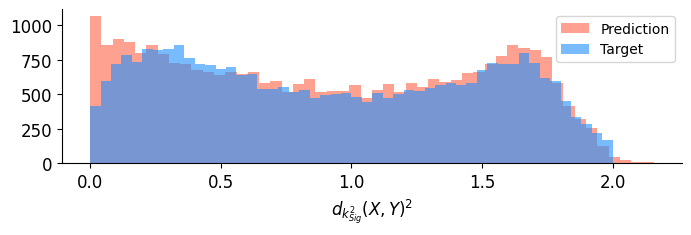

In [388]:
def change_ax_font(tick, fontsize):
    try:
        tick.label.set_fontsize(fontsize)
    except:
        try:
            tick.label1.set_fontsize(fontsize)
        except:
            pass

fig, ax = plt.subplots(figsize=(8, 2))
ax.hist(np.maximum(0.0, predicted_distances), bins=50, color='tomato', alpha=0.6, label='Prediction')
ax.hist([d for d in distances if d > 0], bins=50, color='dodgerblue', alpha=0.6, label='Target')
ax.set_xlabel(r'$d_{k_{Sig}^{2}} (X, Y)^{2}$', fontsize=12)
ax.legend(loc='best')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for tick in ax.xaxis.get_major_ticks():
    change_ax_font(tick, 12)
for tick in ax.yaxis.get_major_ticks():
    change_ax_font(tick, 12)
plt.savefig('mmd_approx_2_distances_dist_font_thesis.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Performance on Testing Dataset

In [389]:
predicted_distances = []

expected_sigs_features = []
for e in expected_sigs_test:
    expected_sigs_features.append(e[:30][:14] + e[-30:][:14])

for i, e in tqdm(enumerate(expected_sigs_features)):
        if distances_test[i] >= 0:
            d = mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, e)).unsqueeze(0).float()).cpu().item()
            predicted_distances.append(d)
            
            
print(f'MSE: {mean_squared_error(predicted_distances, [d for d in distances_test if d >= 0])}')
print(f'MAE: {mean_absolute_error(predicted_distances, [d for d in distances_test if d >= 0])}')

592it [00:00, 2359.67it/s]

MSE: 0.004578431030133843
MAE: 0.04713602118170051


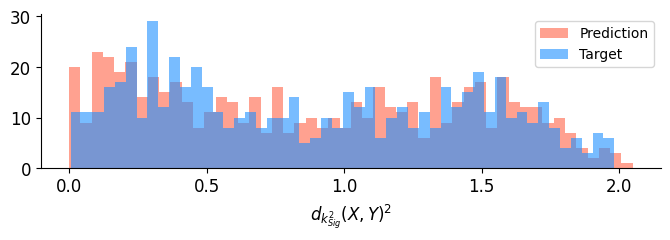

In [390]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.hist(np.maximum(0.0, predicted_distances), bins=50, color='tomato', alpha=0.6, label='Prediction')
ax.hist([d for d in distances_test if d >= 0], bins=50, color='dodgerblue', alpha=0.6, label='Target')
ax.set_xlabel(r'$d_{k_{Sig}^{2}} (X, Y)^{2}$', fontsize=12)
ax.legend(loc='best')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for tick in ax.xaxis.get_major_ticks():
    change_ax_font(tick, 12)
for tick in ax.yaxis.get_major_ticks():
    change_ax_font(tick, 12)
plt.savefig('mmd_approx_2_distances_dist_font_testset_thesis.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

### Test Metric Properties <a class="anchor" id="metric-test"></a>

In [48]:
def generate_rand_r_bergomi(S0=1.0, T=1, num_sim=400, num_time_steps=14):
    
    """
    Generate random rBergomi paths.
    :param S0: Spot value. Default is 1.
    :param T: Matiruty. Default is 1.
    :param num_sim: Number of simulations. Default is 400.
    :param num_time_steps: Number of time steps. Default is 14.
    :return: num_sim rBergomi sample paths of length num_time_steps.
    """
    
    xi_0_range = (0.01, 0.2)
    nu_range = (0.5, 4.0)
    rho_range = (-1, 1)
    H_range = (0.025, 0.5)
    v0_range = (0.2, 0.8)
    
    p_xi_0 = np.random.uniform(xi_0_range[0], xi_0_range[1])
    p_nu = np.random.uniform(nu_range[0], nu_range[1])
    p_rho = np.random.uniform(rho_range[0], rho_range[1])
    p_H = np.random.uniform(H_range[0], H_range[1])
    p_v0 = np.random.uniform(v0_range[0], v0_range[1])
    
    return r_bergomi_sample_paths_functional_central_limit(S0, p_v0, p_H, [p_xi_0 for _ in range(num_time_steps+1)], np.sqrt(2*p_H), p_nu, p_rho, T, num_time_steps, num_sim)[-1]


def generate_rand_heston(S0=1.0, T=1, num_sim=400, num_time_steps=14):
    
    """
    Generate random Heston paths.
    :param S0: Spot value. Default is 1.
    :param T: Matiruty. Default is 1.
    :param num_sim: Number of simulations. Default is 400.
    :param num_time_steps: Number of time steps. Default is 14.
    :return: num_sim Heston sample paths of length num_time_steps.
    """
    
    vol_of_vol_range = (0.2, 0.8)
    speed_range = (0.2, 0.8)
    mean_volatility_range = (0.2, 0.8)
    v0_range = (0.2, 0.8)
    rho_range = (-1, 1)
    r_range = (0.01, 0.2)
    
    
    p_v0 = np.random.uniform(v0_range[0], v0_range[1])
    p_r = np.random.uniform(r_range[0], r_range[1])
    p_rho = np.random.uniform(rho_range[0], rho_range[1])
    p_mean_vol = np.random.uniform(mean_volatility_range[0], mean_volatility_range[1])
    p_speed = np.random.uniform(speed_range[0], speed_range[1])
    p_vol_of_vol = np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1])
    
    
    return heston_sample_paths_inv(S0, p_v0, p_r, p_rho, p_mean_vol, p_speed, p_vol_of_vol, T, num_sim, num_time_steps)[0]

def generate_rand_gbm(S0=1.0, T=1, num_sim=400, num_time_steps=14):
    
    """
    Generate random Black-Scholes paths.
    :param S0: Spot value. Default is 1.
    :param T: Matiruty. Default is 1.
    :param num_sim: Number of simulations. Default is 400.
    :param num_time_steps: Number of time steps. Default is 14.
    :return: num_sim Black-Scholes sample paths of length num_time_steps.
    """
    
    sigma_range = (0.2, 0.8)
    r_range = (0.01, 0.2)
    
    p_sigma = np.random.uniform(sigma_range[0], sigma_range[1])
    p_r = np.random.uniform(r_range[0], r_range[1])
    
    return GBM_sample_paths(S0, p_r, p_sigma, T, num_sim, num_time_steps)

In [49]:
def compute_expected_sigs(sample_paths, sigma=1, sig_level=4):
    """
    Compute the expected signatures.
    :param sample_paths: Array/List of sample paths of shape [Num Samples, 2, Num Time Steps, Num Sim, 2].
    :param sigma: Sigma hyperparameter.
    :param sig_level: Signature truncation level.
    :return: List of expected signatures.
    """
    
    expceted_sigs = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(np.asarray(sample_paths), (0, 1, 3, 2, 4)), 2), sigma)), sig_level), axis=2)
    
    return expceted_sigs.reshape(*expceted_sigs.shape[:-2], -1)

### Metric Condition 1: $\sqrt{\mathcal{NN}_{2} \left( \mathbf{X}, \mathbf{X} \right)} = 0$ <a class="anchor" id="metric-test-1"></a>

In [51]:
threshold = 0.1
cond_sat = []
mmd_values = []


xi_0_range = (0.01, 0.2)
nu_range = (0.5, 4.0)
rho_range = (-1, 1)
H_range = (0.025, 0.5)
v0_range = (0.2, 0.8)

vol_of_vol_range = (0.2, 0.8)
speed_range = (0.2, 0.8)
mean_volatility_range = (0.2, 0.8)
r_range = (0.01, 0.2)

sigma_range = (0.2, 0.8)

S0=1.0
T=1
num_sim=400
num_time_steps=14

num_tests = 50000

mmd_approx_model_mixture.model.eval()
with torch.no_grad():
    for _ in tqdm(range(num_tests)):

        rand = np.random.randint(1, 4, 1)

        if rand[0] == 1:

            p_xi_0 = np.random.uniform(xi_0_range[0], xi_0_range[1])
            p_nu = np.random.uniform(nu_range[0], nu_range[1])
            p_rho = np.random.uniform(rho_range[0], rho_range[1])
            p_H = np.random.uniform(H_range[0], H_range[1])
            p_v0 = np.random.uniform(v0_range[0], v0_range[1])

            p1 = r_bergomi_sample_paths_functional_central_limit(S0, p_v0, p_H, [p_xi_0 for _ in range(num_time_steps+1)], np.sqrt(2*p_H), p_nu, p_rho, T, num_time_steps, num_sim)[-1]
            p2 = r_bergomi_sample_paths_functional_central_limit(S0, p_v0, p_H, [p_xi_0 for _ in range(num_time_steps+1)], np.sqrt(2*p_H), p_nu, p_rho, T, num_time_steps, num_sim)[-1]

        elif rand[0] == 2:

            p_v0 = np.random.uniform(v0_range[0], v0_range[1])
            p_r = np.random.uniform(r_range[0], r_range[1])
            p_rho = np.random.uniform(rho_range[0], rho_range[1])
            p_mean_vol = np.random.uniform(mean_volatility_range[0], mean_volatility_range[1])
            p_speed = np.random.uniform(speed_range[0], speed_range[1])
            p_vol_of_vol = np.random.uniform(vol_of_vol_range[0], vol_of_vol_range[1])

            p1 = heston_sample_paths_inv(S0, p_v0, p_r, p_rho, p_mean_vol, p_speed, p_vol_of_vol, T, num_sim, num_time_steps)[0]
            p2 = heston_sample_paths_inv(S0, p_v0, p_r, p_rho, p_mean_vol, p_speed, p_vol_of_vol, T, num_sim, num_time_steps)[0]

        else:

            p_sigma = np.random.uniform(sigma_range[0], sigma_range[1])
            p_r = np.random.uniform(r_range[0], r_range[1])

            p1 = GBM_sample_paths(S0, p_r, p_sigma, T, num_sim, num_time_steps)
            p2 = GBM_sample_paths(S0, p_r, p_sigma, T, num_sim, num_time_steps)

        new_feature = compute_expected_sigs([[p1, p2]], sig_level=3)

        distance = mmd_approx_model_mixture.transform(torch.tensor(new_feature).float()).cpu().item()
        
        mmd_values.append(distance)
        
        if distance < threshold:
            cond_sat.append(True)
        else:
            cond_sat.append(False)
            
counter_dict = Counter(cond_sat)
print(f'Number of Samples: {num_tests}')
print(f'Threshold: {threshold}')
print(f'Number of Distances Below Threshold: {counter_dict[True]}')

100%|██████████| 50000/50000 [02:49<00:00, 294.82it/s]

Number of Samples: 50000
Threshold: 0.1
Number of Distances Below Threshold: 43874


### Metric Condition 2: $\sqrt{\mathcal{NN}_{2} \left( \mathbf{X}, \mathbf{Y} \right)} = \sqrt{\mathcal{NN}_{2} \left( \mathbf{Y}, \mathbf{X} \right)}$ <a class="anchor" id="metric-test-2"></a>

In [52]:
threshold = 0.1
num_sim = 400

is_sat = []

num_tests = 50000

mmd_approx_model_mixture.model.eval()
with torch.no_grad():
    for i in tqdm(range(num_tests)):
        
        rand = np.random.randint(1, 4, 2)
        
        if rand[0] == 1:
            
            p1 = generate_rand_r_bergomi()
        
        elif rand[0] == 2:
            
            p1 = generate_rand_heston()
            
        else:
            
            p1 = generate_rand_gbm()
            
            
        if rand[1] == 1:
            
            p2 = generate_rand_r_bergomi()
        
        elif rand[1] == 2:
            
            p2 = generate_rand_heston()
            
        else:
            
            p2 = generate_rand_gbm()


        new_feature1 = compute_expected_sigs([[p1, p2]], sig_level=3)
        new_feature2 = compute_expected_sigs([[p2, p1]], sig_level=3)
        
        d1 = mmd_approx_model_mixture.transform(torch.tensor(new_feature1).float()).cpu().item()
        d2 = mmd_approx_model_mixture.transform(torch.tensor(new_feature2).float()).cpu().item()
        
        if abs(np.sqrt(np.maximum(d1, 0.0))-np.sqrt(np.maximum(d2, 0.0))) < threshold:
            is_sat.append(True)
        else:
            is_sat.append(False)
            

symm_counter_dict = Counter(is_sat)
print(f'Number of Samples: {num_tests}')
print(f'Threshold: {threshold}')
print(f'Number of Distances Below Threshold: {symm_counter_dict[True]}')

100%|██████████| 50000/50000 [04:20<00:00, 191.78it/s]

Number of Samples: 50000
Threshold: 0.1
Number of Distances Below Threshold: 47850


### Metric Condition 3: $\sqrt{\mathcal{NN}_{2} (\mathbf{X}, \mathbf{Z})} \leq \sqrt{\mathcal{NN}_{2} ( \mathbf{X}, \mathbf{Y})} + \sqrt{\mathcal{NN}_{2} (\mathbf{Y}, \mathbf{Z})}$ <a class="anchor" id="metric-test-3"></a>

In [54]:
num_tests = 50000

triag_inq_sat = []

mmd_approx_model_mixture.model.eval()
with torch.no_grad():
    for i in tqdm(range(num_tests)):
        
        rand = np.random.randint(1, 4, 3)
        
        if rand[0] == 1:
            
            p1 = generate_rand_r_bergomi()
        
        elif rand[0] == 2:
            
            p1 = generate_rand_heston()
            
        else:
            
            p1 = generate_rand_gbm()
            
            
        if rand[1] == 1:
            
            p2 = generate_rand_r_bergomi()
        
        elif rand[1] == 2:
            
            p2 = generate_rand_heston()
            
        else:
            
            p2 = generate_rand_gbm()
            
            
        if rand[2] == 1:
            
            p3 = generate_rand_r_bergomi()
        
        elif rand[2] == 2:
            
            p3 = generate_rand_heston()
            
        else:
            
            p3 = generate_rand_gbm()

        new_feature1 = compute_expected_sigs([[p1, p2]], sig_level=3)
        new_feature2 = compute_expected_sigs([[p2, p3]], sig_level=3)
        new_feature3 = compute_expected_sigs([[p1, p3]], sig_level=3)
        
        d1 = mmd_approx_model_mixture.transform(torch.tensor(new_feature1).float()).cpu().item()
        d2 = mmd_approx_model_mixture.transform(torch.tensor(new_feature2).float()).cpu().item()
        d3 = mmd_approx_model_mixture.transform(torch.tensor(new_feature3).float()).cpu().item()

                        
        if np.sqrt(np.maximum(d1, 0.0)) <= (np.sqrt(np.maximum(d2, 0.0))+np.sqrt(np.maximum(d3, 0.0))):
            triag_inq_sat.append(True)
        else:
            triag_inq_sat.append(False)
            
triag_inq_counter_dict = Counter(triag_inq_sat)
print(f'Number of Samples: {num_tests}')
print(f'Number of Samples Satisfying the Triangle Inequality: {triag_inq_counter_dict[True]}')

100%|██████████| 50000/50000 [06:30<00:00, 128.11it/s]

Number of Samples: 50000
Number of Samples Satisfying the Triangle Inequality: 49740


## Filtration-Sensitive Sig-Kernel Two-Sample Hypothesis Test <a class="anchor" id="hyp-test"></a>

In [192]:
static_kernel_21 = RBFKernel(sigma=0.5)
static_kernel_22 = RBFKernel(sigma=0.5)

dyadic_order = 0

lambda_ = 1e-5

signature_kernel = SigKernel([static_kernel_21, static_kernel_22], dyadic_order)

In [341]:
def compute_expected_sigs(sample_paths, sigma=1, sig_level=4):
    """
    Compute the expected signatures.
    :param sample_paths: Array/List of sample paths of shape [Num Samples, 2, Num Time Steps, Num Sim, 2].
    :param sigma: Sigma hyperparameter.
    :param sig_level: Signature truncation level.
    :return: List of expected signatures.
    """
    
    expceted_sigs = np.mean(iisignature.sig(np.exp(-np.divide(np.power(np.transpose(np.asarray(sample_paths), (0, 1, 3, 2, 4)), 2), sigma)), sig_level), axis=2)
    
    return expceted_sigs.reshape(*expceted_sigs.shape[:-2], -1)


def expected_type2_error(h1_dist: torch.Tensor, crit_value: float):
    """
    Calculates the expected type II error given a critical value from a null distribution and the alternate distribution

    :param h1_dist:     MMD distribution under the alternate hypothesis
    :param crit_value:  Critical value associated to the null distribution
    :return:
    """
    n_atoms = h1_dist.shape[0]
    num_fail = h1_dist <= crit_value
    return sum(num_fail.type(torch.float32))/n_atoms

In [347]:
# Code in this celll was adapted from Github repo: https://github.com/maudl3116/higherOrderKME.

S0 = 1.0
T = 1.0

sigma = 1

MMD_H_0 = defaultdict(list)
MMD_H_A = defaultdict(list)


MMD_1 = np.zeros((repeats, 2))
MMD_2 = np.zeros((repeats, 2))


# number of path coordinates and number of time steps
D, L = 1, 3

# experimental setup
repeats, n_samples, n, lambda_ = 500, 20000, 15, 1e-5

MMD_1 = np.ones((repeats, 2))
MMD_2 = np.ones((repeats, 2))

# to store the sample paths from X_n and X
X = np.ones((repeats, n_samples, 2, L, 2)) 
X_n = np.ones((repeats, n_samples, 2, L, 2))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, -2, 0] = 1.0 + omega_1 * 1./n
X_n[:, :, :, -1, 0] = 1.0 +  0.25 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, -1, 0] = 1.0 +  0.25 * omega_1


X[:, :, :, :, 1] = np.linspace(0, 1, L)
X_n[:, :, :, :, 1] = np.linspace(0, 1, L)


sig_level = 3

num_sim = 500

neural_net_batch_sizes = [500, 1000, 5000, 10000, 15000, 20000]

for i in tqdm(range(repeats)):
    
    p1 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)    
    p1_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    
    p2 = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
    p2_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)
       
    MMD_1[i,0] = signature_kernel.compute_mmd(p1[:num_sim, ...], p1_[:num_sim, ...], estimator='ub', order=1)   
    MMD_1[i,1] = signature_kernel.compute_mmd(p2[:num_sim, ...], p1[:num_sim, ...], estimator='ub', order=1) 
    
    MMD_2[i, 0] = signature_kernel.compute_mmd(p1[:num_sim, ...], p1_[:num_sim, ...], estimator='ub', order=2, lambda_=lambda_)
    MMD_2[i, 1] = signature_kernel.compute_mmd(p2[:num_sim, ...], p1[:num_sim, ...], estimator='ub', order=2, lambda_=lambda_) 


    for B in neural_net_batch_sizes:
        new_feature_H_0 = compute_expected_sigs([[p1[:B, ...].cpu().permute(1, 0, 2), p1_[:B, ...].cpu().permute(1, 0, 2)]], sig_level=sig_level)
        new_feature_H_A = compute_expected_sigs([[p1[:B, ...].cpu().permute(1, 0, 2), p2[:B, ...].cpu().permute(1, 0, 2)]], sig_level=sig_level)
        
        d1 = mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature_H_0)).float()).cpu().item()
        d2 = mmd_approx_model_mixture.transform(torch.tensor(np.multiply(1, new_feature_H_A)).float()).cpu().item()
        
        MMD_H_0[B].append(d1)
        MMD_H_A[B].append(d2)

100%|██████████| 500/500 [01:21<00:00,  6.16it/s]


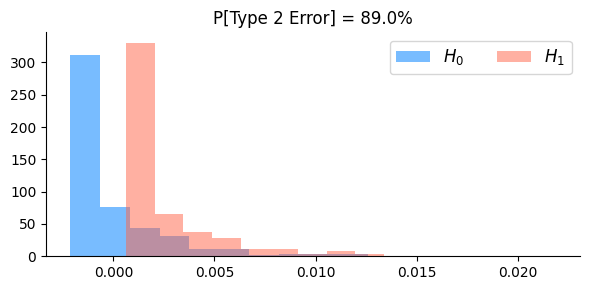

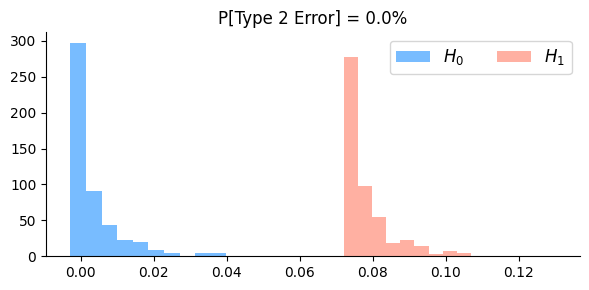

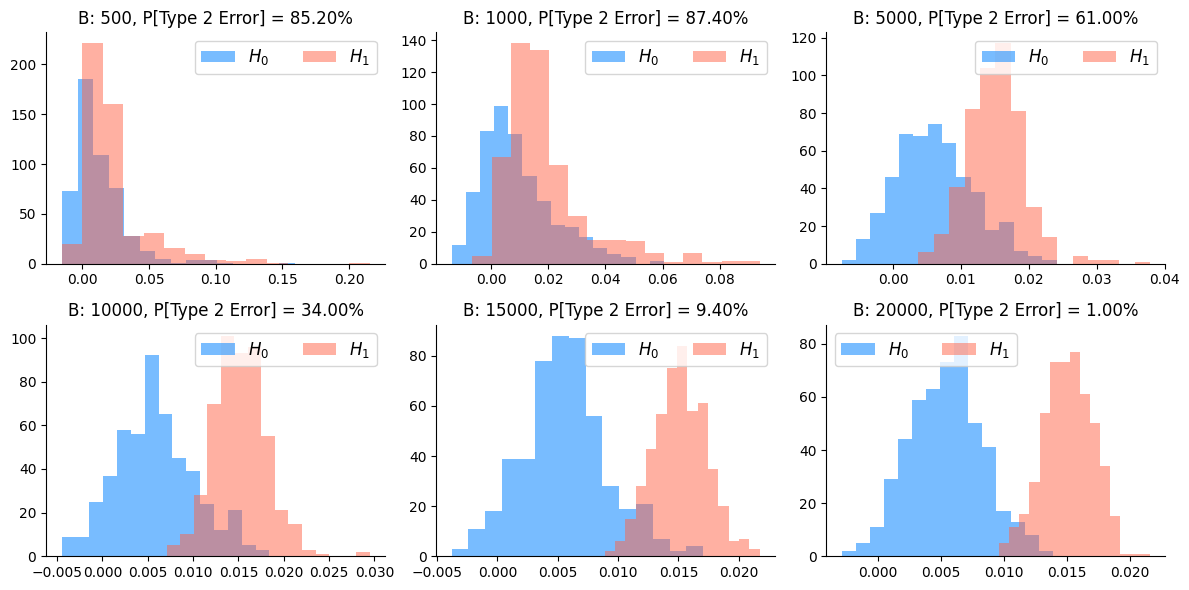

In [404]:
fig, ax = plt.subplots(figsize=(6, 3))


alpha = 0.05

crit_val = np.sort(np.asarray(MMD_1[:, 0]))[int(repeats * (1 - alpha))]
ax.hist(MMD_1[:, 0], bins= 15, label=r"$H_0$", color='dodgerblue', alpha=0.6, edgecolor="none")
ax.hist(MMD_1[:, 1], bins = 15, label=r"$H_1$", color='tomato', alpha=0.5, edgecolor="none")
ax.legend(loc='upper right', ncol=2, fontsize=12)
ax.set_title(f'P[Type 2 Error] = {100 * expected_type2_error(torch.tensor(MMD_1[:, 1]), crit_val)}%', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
filename = 'MMDApproxData/Images/mmd_approx_2_distances_filtration_thesis_rank1.svg'
file_path = Path(f'{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(filename, bbox_inches='tight', format='svg', dpi=1200)
plt.show()


fig, ax = plt.subplots(figsize=(6, 3))

crit_val = np.sort(np.asarray(MMD_2[:, 0]))[int(repeats * (1 - alpha))]
ax.hist([d for d in MMD_2[:, 0] if d < 10], bins=15, label=r"$H_0$", color='dodgerblue', alpha=0.6, edgecolor="none")
ax.hist([d for d in MMD_2[:, 1] if d < 10], bins=15, label=r"$H_1$", color='tomato', alpha=0.5, edgecolor="none")
ax.legend(loc='upper right', ncol=2, fontsize=12)
ax.set_title(f'P[Type 2 Error] = {100 * expected_type2_error(torch.tensor(MMD_2[:, 1]), crit_val)}%', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper right', ncol=2, fontsize=12)

plt.tight_layout()
filename = 'MMDApproxData/Images/mmd_approx_2_distances_filtration_thesis_rank2.svg'
file_path = Path(f'{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(filename, bbox_inches='tight', format='svg', dpi=1200)
plt.show()


j = 0
k = 0
fig, ax = plt.subplots(nrows=2, ncols=len(neural_net_batch_sizes)//2, figsize=(12, 6))
for i, B in enumerate(neural_net_batch_sizes):
    crit_val = np.sort(np.asarray(MMD_H_0[B]))[int(repeats * (1 - alpha))]
    ax[j, k].hist([d for d in MMD_H_0[B] if d < 10], bins=15, label=r'$H_0$', color='dodgerblue', alpha=0.6, edgecolor="none")
    ax[j, k].hist([d for d in MMD_H_A[B] if d < 10], bins=15, label=r'$H_1$', color='tomato', alpha=0.5, edgecolor="none")
    ax[j, k].set_title(f'B: {B}, P[Type 2 Error] = {100 * expected_type2_error(torch.tensor(MMD_H_A[B]), crit_val):.2f}%', fontsize=12)
    ax[j, k].spines['right'].set_visible(False)
    ax[j, k].spines['top'].set_visible(False)
    ax[j, k].legend(loc='best', ncol=2, fontsize=12)
    if i == 2:
        k = 0
        j += 1
    else:
        k += 1

plt.tight_layout()
filename = 'MMDApproxData/Images/mmd_approx_2_distances_filtration_model_thesis.svg'
file_path = Path(f'{filename}')
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(filename, bbox_inches='tight', format='svg', dpi=1200)
plt.show()